# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1). I'll compute the camera calibration using chessboard images

In [17]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib qt
%matplotlib inline 

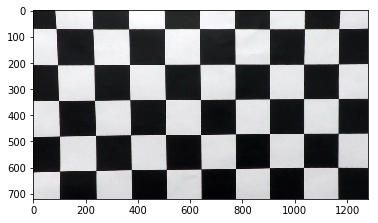

In [3]:
#Camera Calibration
def cam_cal():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images - literally a list of filenames.
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      
        #Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
   
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            #Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #plt.imshow(img)

    #Calculation distortion coefficients & camera matrix from camera_cal images.        
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

#MAIN PIPELINE
ret, mtx, dist, rvecs, tvecs = cam_cal() #Calbibrate Camera
#1) Undistort a sample image for the writeup.  
dst = cv2.undistort(cv2.imread('../camera_cal/calibration1.jpg'), mtx, dist, None, mtx)
#cv2.imwrite('../output_images/calibration1-corrected.jpg', cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)) #For Output
plt.imshow(dst)

## 2-4) Correcting for distortion & adding a pipeline for Gradient & Color

[[[  3.92082648e+02   0.00000000e+00]
  [  3.91944194e+02   1.00000000e+00]
  [  3.91805933e+02   2.00000000e+00]
  ..., 
  [  1.14961005e+03   2.00000000e+00]
  [  1.14993270e+03   1.00000000e+00]
  [  1.15025558e+03   0.00000000e+00]]]
[[[ 234.69372558    0.        ]
  [ 235.08026374    1.        ]
  [ 235.46628195    2.        ]
  ..., 
  [ 941.94309696    2.        ]
  [ 941.75282146    1.        ]
  [ 941.56232575    0.        ]]]
[[[  4.74003938e+02   0.00000000e+00]
  [  4.73753928e+02   1.00000000e+00]
  [  4.73504089e+02   2.00000000e+00]
  ..., 
  [  1.16304175e+03   2.00000000e+00]
  [  1.16343570e+03   1.00000000e+00]
  [  1.16382999e+03   0.00000000e+00]]]
[[[  3.92967440e+02   0.00000000e+00]
  [  3.92863291e+02   1.00000000e+00]
  [  3.92759313e+02   2.00000000e+00]
  ..., 
  [  1.16873024e+03   2.00000000e+00]
  [  1.16918948e+03   1.00000000e+00]
  [  1.16964937e+03   0.00000000e+00]]]
[[[  3.99119543e+02   0.00000000e+00]
  [  3.98755686e+02   1.00000000e+00]
  [  3.9

True

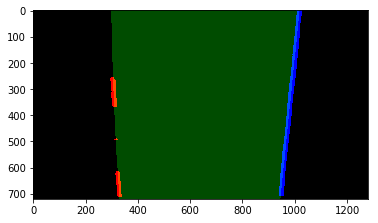

In [56]:
def binary(img):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*(abs_sobelx/np.max(abs_sobelx)))
    
    # Threshold x gradient
    thresh_min = 50
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 100
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Threshold color channel - Eliminate Saturated Shadows
    l_thresh_min = 50
    l_thresh_max = 255
    l_binary = np.zeros_like(s_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    s_binary = cv2.bitwise_and(s_binary,l_binary)
    
    # Threshold color channel - Bring out white lines (with low saturation)
    l_thresh_min = 200
    l_thresh_max = 255
    l_binary = np.zeros_like(s_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    s_binary = cv2.bitwise_or(s_binary,l_binary)
        
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    #Combine Color and X Gradient
    combined_binary=np.zeros_like(sxbinary)
    combined_binary[(s_binary==1)|(sxbinary==1)]=255
    return color_binary, combined_binary

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def perspective(img):
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    #define 4 source points using test7 (straight_lines1) trapezoid. 
    #Hard coding points
    #src = np.float32([[623.0,433.0],[656.0,433.0],[264.0,678.0],[1042.0,678.0]]) - My Original Set.  Didn't work.
    src = np.float32([[585,460],[203,720],[1127,720],[695,460]])
    # c) define 4 destination points to open the upper two points of the trapezoid
    #dst = np.float32([[264.0,433.0],[1042.0,433.0],[264.0,678.0],[1042.0,678.0]]) - My Original Set.  Didn't work.
    dst = np.float32([[320,0],[320,720],[960,720],[960,0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective() to warp your image to a top-down view  
    warped = cv2.warpPerspective(img, M, img_size)
    # Return the resulting image
    return warped, M

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    out_img_nobox = np.copy(out_img)
       
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, out_img_nobox

def region_of_interest(img, left_fitx, right_fitx, ploty):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices` and turns green. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    mask = np.zeros_like(img)  
    
    # Recast the x and y points into usable format for cv2.fillPoly() - Combining xy in Array of 2-Points
    left_fitxy = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_fitxy = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    vertices = np.hstack((left_fitxy, right_fitxy))
    #print(vertices) 
    
    #filling pixels inside the polygon defined by "vertices" with the fill color   
    cv2.fillPoly(mask, np.int_(vertices), (0,255, 0))    

    return mask

def measure_curvature_pixels(ploty, left_fit, right_fit, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''   
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/650 # meters per pixel in x dimension
    
    #Calculate vehicle offset
    lane_center=(left_fitx[719]+right_fitx[719])/2
    lane_offset=((1280/2)-lane_center)*(xm_per_pix)
    if lane_offset<0:
        offset_side='Left of'
    elif lane_offset>0:
        offset_side='Right of'
    else: 
        side=''
    lane_offset=np.abs(lane_offset)

    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + ((2*left_fit[0]*y_eval*ym_per_pix) + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + ((2*right_fit[0]*y_eval*ym_per_pix) + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    rcurve=(np.abs(left_curverad)+np.abs(right_curverad))/2  #Ignoring the 3.7m difference outer to inner.  
    
    return rcurve, lane_offset, offset_side

def fit_polynomial(binary_warped, num):
    α=1
    β=0.3
    γ=0
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, out_img_nobox = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        #print(left_fit[0])
        #print(left_fit[1])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    out_img_nobox[lefty, leftx] = [255, 0, 0]
    out_img_nobox[righty, rightx] = [0, 0, 255]
    
    mask=region_of_interest(out_img_nobox, left_fitx, right_fitx, ploty)
    out_img_nobox = cv2.addWeighted(out_img_nobox, α, mask, β, γ)#Muting green for mask.
    
    out_img_nobox[np.where((out_img_nobox>=[50,50,50]).all(axis=2))] = [0,0,0]  
 
    #Plots the left and right polynomials on the lane lines
    plt.clf()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.savefig('../output_images/test%d-corrected-bird-binary-curve.jpg' % num)
    plt.clf()
    plt.imshow(out_img_nobox)
   
    #Measure curvature of lane lines
    rcurve, lane_offset, offset_side = measure_curvature_pixels(ploty, left_fit, right_fit, left_fitx, right_fitx)
    rcurve=int(rcurve) #No decimal places
    lane_offset=round(lane_offset,2) #2 Decimal Places
    
    return out_img_nobox, rcurve, lane_offset, offset_side, 

#MAIN PIPELINE CONTINUTED
#2 & 3 Undistort all test images - straight_lines JPG renamed to test7 and test8.
test_images = glob.glob('../test_images/test*.jpg')
num=0
for fname1 in test_images:
    num+=1
    α=0.7
    β=1
    γ=0
    
    #1) Correct Images
    corrected = cv2.undistort(cv2.imread('../test_images/test%d.jpg' % num), mtx, dist, None, mtx)
    cv2.imwrite('../output_images/test%d-corrected.jpg' % num, corrected)
    
    #2*) Corrected Images to Binary-Front.  Not used beyond.   
    color_bin, combined_bin = binary(corrected)
    cv2.imwrite('../output_images/test%d-corrected-binary.jpg' % num, combined_bin)
    
    #2) Convert Corrected Images to Bird's Eye. thresholding continues on this.  
    birds_eye, m = perspective(corrected)
    cv2.imwrite('../output_images/test%d-corrected-bird.jpg' % num, birds_eye)
    
    #3) Run Binary on Corrected - Bird's Eye Photos.
    color_bin, bin_bird_persp = binary(birds_eye) 
    cv2.imwrite('../output_images/test%d-corrected-bird-binary.jpg' % num, bin_bird_persp)
    
    #4) Curve-fit and Measure curvatuve and Offset.  
    bird_binaryc, rcurve, lane_offset, offset_side = fit_polynomial(bin_bird_persp, num)

    #5) Invert Binary-Bird's Eye, draw boundary, add text
    img_size = (bird_binaryc.shape[1], bird_binaryc.shape[0])
    rewarp = cv2.warpPerspective(bird_binaryc, m, img_size, flags=cv2.WARP_INVERSE_MAP) 
    cv2.imwrite('../output_images/test%d-corrected-bird-binary-rewarp.jpg' % num, rewarp)
    weighted=cv2.addWeighted(corrected, α, cv2.cvtColor(rewarp, cv2.COLOR_RGB2BGR), β, γ) #Adding Mask to Corrected
    cv2.putText(weighted,'Radius of Curvature: = ' + str(rcurve) +"m", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(weighted,'Vehicle is ' + str(lane_offset) +"m"+' '+ offset_side + ' Center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.imwrite('../output_images/test%d-overlay.jpg' % num, weighted)

#Drawing Lines for writeup sample
test7=cv2.imread('../output_images/test7-corrected-bird.jpg')
color=[255, 0, 0]
thickness=3
test7=cv2.line(test7, (320,0),(320,720), color, thickness)
test7=cv2.line(test7, (960,0),(960,720), color, thickness)
cv2.imwrite('../output_images/test7-corrected-bird-lines.jpg', test7)


In [15]:
## Video Pipeline

In [49]:
def process_image(image):
    α=0.7
    β=1
    γ=0
    
    #1) Correct Images | mtx, dist are called for Cam_Cal Initialization 
    corrected = cv2.undistort(image, mtx, dist, None, mtx)
    
    #2) Convert Corrected Images to Bird's Eye. thresholding continues on this.  
    birds_eye, m = perspective(corrected)
    
    #3) Run Binary on Corrected - Bird's Eye Photos.
    color_bin, bin_bird_persp = binary(birds_eye) 
    
    #4) Curve-fit and Measure curvatuve and Offset.  
    bird_binaryc, rcurve, lane_offset, offset_side = fit_polynomial(bin_bird_persp, num)

    #5) Invert Binary-Bird's Eye, draw boundary, add text
    img_size = (bird_binaryc.shape[1], bird_binaryc.shape[0])
    rewarp = cv2.warpPerspective(bird_binaryc, m, img_size, flags=cv2.WARP_INVERSE_MAP) 
    weighted=cv2.addWeighted(corrected, α, cv2.cvtColor(rewarp, cv2.COLOR_RGB2BGR), β, γ) #Adding Mask to Corrected
    cv2.putText(weighted,'Radius of Curvature: = ' + str(rcurve) +"m", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(weighted,'Vehicle is ' + str(lane_offset) +"m"+' '+ offset_side + ' Center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

    return(weighted)

In [ ]:
## Project Video I/O

[[[ 242.08781945    0.        ]
  [ 242.45376423    1.        ]
  [ 242.81920485    2.        ]
  ..., 
  [ 946.43658874    2.        ]
  [ 946.20422135    1.        ]
  [ 945.97145488    0.        ]]]
[MoviePy] >>>> Building video ../output_video/P2_video_out.mp4
[MoviePy] Writing video ../output_video/P2_video_out.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

[[[ 242.08781945    0.        ]
  [ 242.45376423    1.        ]
  [ 242.81920485    2.        ]
  ..., 
  [ 946.43658874    2.        ]
  [ 946.20422135    1.        ]
  [ 945.97145488    0.        ]]]


  0%|          | 1/1261 [00:00<09:06,  2.31it/s]

[[[ 242.39152032    0.        ]
  [ 242.7559903     1.        ]
  [ 243.11996561    2.        ]
  ..., 
  [ 938.14604705    2.        ]
  [ 937.90173153    1.        ]
  [ 937.65701294    0.        ]]]


  0%|          | 2/1261 [00:00<09:12,  2.28it/s]

[[[ 240.54814701    0.        ]
  [ 240.92235836    1.        ]
  [ 241.29605633    2.        ]
  ..., 
  [ 931.079046      2.        ]
  [ 930.82285394    1.        ]
  [ 930.56625257    0.        ]]]


  0%|          | 3/1261 [00:01<09:11,  2.28it/s]

[[[ 237.51253902    0.        ]
  [ 237.89937036    1.        ]
  [ 238.28566754    2.        ]
  ..., 
  [ 922.80623194    2.        ]
  [ 922.5328943     1.        ]
  [ 922.25913209    0.        ]]]


  0%|          | 4/1261 [00:01<09:08,  2.29it/s]

[[[ 236.68618109    0.        ]
  [ 237.07230255    1.        ]
  [ 237.45789913    2.        ]
  ..., 
  [ 921.26763612    2.        ]
  [ 920.99208181    1.        ]
  [ 920.71610349    0.        ]]]


  0%|          | 5/1261 [00:02<09:07,  2.29it/s]

[[[ 234.90271693    0.        ]
  [ 235.29091099    1.        ]
  [ 235.67859058    2.        ]
  ..., 
  [ 915.66541018    2.        ]
  [ 915.38867017    1.        ]
  [ 915.11152386    0.        ]]]


  0%|          | 6/1261 [00:02<09:07,  2.29it/s]

[[[ 231.44036446    0.        ]
  [ 231.83051949    1.        ]
  [ 232.22017326    2.        ]
  ..., 
  [ 919.49021777    2.        ]
  [ 919.22210189    1.        ]
  [ 918.95359241    0.        ]]]


  1%|          | 7/1261 [00:03<09:03,  2.31it/s]

[[[ 228.90686741    0.        ]
  [ 229.3085049     1.        ]
  [ 229.70962507    2.        ]
  ..., 
  [ 912.80120695    2.        ]
  [ 912.55950593    1.        ]
  [ 912.31756029    0.        ]]]


  1%|          | 8/1261 [00:03<09:24,  2.22it/s]

[[[ 225.19828515    0.        ]
  [ 225.60417911    1.        ]
  [ 226.00955553    2.        ]
  ..., 
  [ 919.45595838    2.        ]
  [ 919.22897682    1.        ]
  [ 919.0017618     0.        ]]]


  1%|          | 9/1261 [00:03<09:18,  2.24it/s]

[[[ 222.29933176    0.        ]
  [ 222.70677238    1.        ]
  [ 223.11370161    2.        ]
  ..., 
  [ 918.99629569    2.        ]
  [ 918.7712284     1.        ]
  [ 918.54593162    0.        ]]]


  1%|          | 10/1261 [00:04<09:04,  2.30it/s]

[[[ 223.87300056    0.        ]
  [ 224.26413034    1.        ]
  [ 224.65479392    2.        ]
  ..., 
  [ 912.42161508    2.        ]
  [ 912.1896736     1.        ]
  [ 911.95750212    0.        ]]]


  1%|          | 11/1261 [00:04<09:01,  2.31it/s]

[[[ 218.26236955    0.        ]
  [ 218.64452978    1.        ]
  [ 219.02626492    2.        ]
  ..., 
  [ 933.5250427     2.        ]
  [ 933.32554575    1.        ]
  [ 933.12582676    0.        ]]]


  1%|          | 12/1261 [00:05<09:00,  2.31it/s]

[[[ 217.14925434    0.        ]
  [ 217.52872777    1.        ]
  [ 217.90779127    2.        ]
  ..., 
  [ 930.01155228    2.        ]
  [ 929.82596962    1.        ]
  [ 929.64021974    0.        ]]]


  1%|          | 13/1261 [00:05<09:00,  2.31it/s]

[[[ 217.74675443    0.        ]
  [ 218.11365065    1.        ]
  [ 218.48017492    2.        ]
  ..., 
  [ 922.72206555    2.        ]
  [ 922.51185058    1.        ]
  [ 922.3014144     0.        ]]]


  1%|          | 14/1261 [00:06<08:51,  2.35it/s]

[[[ 221.79085956    0.        ]
  [ 222.14579341    1.        ]
  [ 222.5003778     2.        ]
  ..., 
  [ 904.84181232    2.        ]
  [ 904.60547525    1.        ]
  [ 904.36889885    0.        ]]]


  1%|          | 15/1261 [00:06<08:48,  2.36it/s]

[[[ 222.91256173    0.        ]
  [ 223.26834148    1.        ]
  [ 223.62376479    2.        ]
  ..., 
  [ 884.67842414    2.        ]
  [ 884.39327538    1.        ]
  [ 884.10780729    0.        ]]]


  1%|▏         | 16/1261 [00:06<08:46,  2.36it/s]

[[[ 224.26603228    0.        ]
  [ 224.61295779    1.        ]
  [ 224.95954182    2.        ]
  ..., 
  [ 881.2153829     2.        ]
  [ 880.92513375    1.        ]
  [ 880.63455665    0.        ]]]


  1%|▏         | 17/1261 [00:07<08:43,  2.38it/s]

[[[ 224.44399724    0.        ]
  [ 224.78862432    1.        ]
  [ 225.1329142     2.        ]
  ..., 
  [ 875.13103534    2.        ]
  [ 874.83562776    1.        ]
  [ 874.53989566    0.        ]]]


  1%|▏         | 18/1261 [00:07<08:42,  2.38it/s]

[[[ 222.78309259    0.        ]
  [ 223.11993095    1.        ]
  [ 223.45645667    2.        ]
  ..., 
  [ 886.01611066    2.        ]
  [ 885.74095127    1.        ]
  [ 885.46548367    0.        ]]]


  2%|▏         | 19/1261 [00:08<08:42,  2.38it/s]

[[[ 220.30821477    0.        ]
  [ 220.64262129    1.        ]
  [ 220.9767269     2.        ]
  ..., 
  [ 893.14157029    2.        ]
  [ 892.87895951    1.        ]
  [ 892.61604854    0.        ]]]


  2%|▏         | 20/1261 [00:08<08:40,  2.39it/s]

[[[ 218.46795488    0.        ]
  [ 218.79587881    1.        ]
  [ 219.1235211     2.        ]
  ..., 
  [ 904.53445384    2.        ]
  [ 904.2885718     1.        ]
  [ 904.0423881     0.        ]]]


  2%|▏         | 21/1261 [00:09<08:41,  2.38it/s]

[[[ 214.65417104    0.        ]
  [ 214.98469244    1.        ]
  [ 215.31492996    2.        ]
  ..., 
  [ 915.99415203    2.        ]
  [ 915.76644597    1.        ]
  [ 915.53844952    0.        ]]]


  2%|▏         | 22/1261 [00:09<08:42,  2.37it/s]

[[[ 211.20360439    0.        ]
  [ 211.54196457    1.        ]
  [ 211.88001841    2.        ]
  ..., 
  [ 925.14362127    2.        ]
  [ 924.92802124    1.        ]
  [ 924.71212628    0.        ]]]


  2%|▏         | 23/1261 [00:09<09:07,  2.26it/s]

[[[ 214.24412671    0.        ]
  [ 214.5851371     1.        ]
  [ 214.92581403    2.        ]
  ..., 
  [ 916.52250964    2.        ]
  [ 916.28619119    1.        ]
  [ 916.04954549    0.        ]]]


  2%|▏         | 24/1261 [00:10<09:02,  2.28it/s]

[[[ 213.57440471    0.        ]
  [ 213.93091909    1.        ]
  [ 214.2870503     2.        ]
  ..., 
  [ 910.88077399    2.        ]
  [ 910.62970514    1.        ]
  [ 910.37828483    0.        ]]]


  2%|▏         | 25/1261 [00:10<08:58,  2.30it/s]

[[[ 211.91251716    0.        ]
  [ 212.26285703    1.        ]
  [ 212.61283017    2.        ]
  ..., 
  [ 923.47391164    2.        ]
  [ 923.2349346     1.        ]
  [ 922.99559145    0.        ]]]


  2%|▏         | 26/1261 [00:11<08:50,  2.33it/s]

[[[ 211.10861626    0.        ]
  [ 211.46638175    1.        ]
  [ 211.82375502    2.        ]
  ..., 
  [ 923.16514023    2.        ]
  [ 922.91447054    1.        ]
  [ 922.66340463    0.        ]]]


  2%|▏         | 27/1261 [00:11<08:46,  2.34it/s]

[[[ 208.69157652    0.        ]
  [ 209.04876803    1.        ]
  [ 209.40556753    2.        ]
  ..., 
  [ 937.42923719    2.        ]
  [ 937.19621262    1.        ]
  [ 936.96279346    0.        ]]]


  2%|▏         | 28/1261 [00:12<08:42,  2.36it/s]

[[[ 211.52726681    0.        ]
  [ 211.88615242    1.        ]
  [ 212.24462818    2.        ]
  ..., 
  [ 924.78971184    2.        ]
  [ 924.5207373     1.        ]
  [ 924.25131528    0.        ]]]


  2%|▏         | 29/1261 [00:12<08:40,  2.37it/s]

[[[ 211.55696967    0.        ]
  [ 211.94311896    1.        ]
  [ 212.32877248    2.        ]
  ..., 
  [ 916.22702028    2.        ]
  [ 915.95373476    1.        ]
  [ 915.68002043    0.        ]]]


  2%|▏         | 30/1261 [00:12<08:49,  2.33it/s]

[[[ 215.22049758    0.        ]
  [ 215.60948021    1.        ]
  [ 215.99794949    2.        ]
  ..., 
  [ 906.28776894    2.        ]
  [ 906.0002535     1.        ]
  [ 905.71231097    0.        ]]]


  2%|▏         | 31/1261 [00:13<08:44,  2.35it/s]

[[[ 217.44068962    0.        ]
  [ 217.84330734    1.        ]
  [ 218.24536639    2.        ]
  ..., 
  [ 891.27639995    2.        ]
  [ 890.96502225    1.        ]
  [ 890.65320337    0.        ]]]


  3%|▎         | 32/1261 [00:13<09:13,  2.22it/s]

[[[ 215.29226174    0.        ]
  [ 215.69350755    1.        ]
  [ 216.0942059     2.        ]
  ..., 
  [ 902.48087497    2.        ]
  [ 902.19484954    1.        ]
  [ 901.9084296     0.        ]]]


  3%|▎         | 33/1261 [00:14<09:03,  2.26it/s]

[[[ 215.50915641    0.        ]
  [ 215.9233081     1.        ]
  [ 216.33687825    2.        ]
  ..., 
  [ 898.19061313    2.        ]
  [ 897.91478439    1.        ]
  [ 897.63862626    0.        ]]]


  3%|▎         | 34/1261 [00:14<08:57,  2.28it/s]

[[[ 214.77422736    0.        ]
  [ 215.20022763    1.        ]
  [ 215.62561781    2.        ]
  ..., 
  [ 897.12801557    2.        ]
  [ 896.85448183    1.        ]
  [ 896.58063036    0.        ]]]


  3%|▎         | 35/1261 [00:15<08:54,  2.29it/s]

[[[ 213.22195635    0.        ]
  [ 213.65671125    1.        ]
  [ 214.09084873    2.        ]
  ..., 
  [ 889.61886353    2.        ]
  [ 889.33724516    1.        ]
  [ 889.05531009    0.        ]]]


  3%|▎         | 36/1261 [00:15<08:52,  2.30it/s]

[[[ 211.37421536    0.        ]
  [ 211.82173907    1.        ]
  [ 212.26861869    2.        ]
  ..., 
  [ 885.27756348    2.        ]
  [ 884.97712805    1.        ]
  [ 884.6763207     0.        ]]]


  3%|▎         | 37/1261 [00:15<08:49,  2.31it/s]

[[[ 208.76762004    0.        ]
  [ 209.23531553    1.        ]
  [ 209.70232461    2.        ]
  ..., 
  [ 881.13939083    2.        ]
  [ 880.83774471    1.        ]
  [ 880.53573803    0.        ]]]


  3%|▎         | 38/1261 [00:16<08:49,  2.31it/s]

[[[ 207.61662178    0.        ]
  [ 208.09500849    1.        ]
  [ 208.57268799    2.        ]
  ..., 
  [ 870.48718084    2.        ]
  [ 870.16064329    1.        ]
  [ 869.83370216    0.        ]]]


  3%|▎         | 39/1261 [00:16<09:05,  2.24it/s]

[[[ 203.74838448    0.        ]
  [ 204.22909293    1.        ]
  [ 204.70910574    2.        ]
  ..., 
  [ 865.20199388    2.        ]
  [ 864.8343917     1.        ]
  [ 864.46628092    0.        ]]]


  3%|▎         | 40/1261 [00:17<08:55,  2.28it/s]

[[[ 204.77797973    0.        ]
  [ 205.24650203    1.        ]
  [ 205.71436678    2.        ]
  ..., 
  [ 864.00370724    2.        ]
  [ 863.63505462    1.        ]
  [ 863.2658973     0.        ]]]


  3%|▎         | 41/1261 [00:17<08:50,  2.30it/s]

[[[ 203.51628492    0.        ]
  [ 203.98701325    1.        ]
  [ 204.45708685    2.        ]
  ..., 
  [ 866.57353791    2.        ]
  [ 866.21043581    1.        ]
  [ 865.84683816    0.        ]]]


  3%|▎         | 42/1261 [00:18<08:44,  2.32it/s]

[[[ 200.30207092    0.        ]
  [ 200.77539458    1.        ]
  [ 201.2480722     2.        ]
  ..., 
  [ 872.4553889     2.        ]
  [ 872.10067963    1.        ]
  [ 871.74548036    0.        ]]]


  3%|▎         | 43/1261 [00:18<10:10,  1.99it/s]

[[[ 197.81172077    0.        ]
  [ 198.27820617    1.        ]
  [ 198.74407727    2.        ]
  ..., 
  [ 882.55367558    2.        ]
  [ 882.21565323    1.        ]
  [ 881.87715079    0.        ]]]


  3%|▎         | 44/1261 [00:19<10:05,  2.01it/s]

[[[ 192.99596543    0.        ]
  [ 193.46876332    1.        ]
  [ 193.94095239    2.        ]
  ..., 
  [ 887.59918081    2.        ]
  [ 887.2671576     1.        ]
  [ 886.93465778    0.        ]]]


  4%|▎         | 45/1261 [00:19<10:03,  2.02it/s]

[[[ 194.49121524    0.        ]
  [ 194.95487495    1.        ]
  [ 195.41794333    2.        ]
  ..., 
  [ 890.59714086    2.        ]
  [ 890.29357209    1.        ]
  [ 889.98961789    0.        ]]]


  4%|▎         | 46/1261 [00:20<10:03,  2.01it/s]

[[[ 191.66994605    0.        ]
  [ 192.13138794    1.        ]
  [ 192.59225686    2.        ]
  ..., 
  [ 893.9307452     2.        ]
  [ 893.63004282    1.        ]
  [ 893.32894672    0.        ]]]


  4%|▎         | 47/1261 [00:20<10:05,  2.00it/s]

[[[ 192.270526      0.        ]
  [ 192.72534206    1.        ]
  [ 193.17960651    2.        ]
  ..., 
  [ 886.96203272    2.        ]
  [ 886.65069213    1.        ]
  [ 886.33895178    0.        ]]]


  4%|▍         | 48/1261 [00:21<09:54,  2.04it/s]

[[[ 189.52202586    0.        ]
  [ 189.9633916     1.        ]
  [ 190.40425447    2.        ]
  ..., 
  [ 897.66028124    2.        ]
  [ 897.36908958    1.        ]
  [ 897.07751548    0.        ]]]


  4%|▍         | 49/1261 [00:21<09:57,  2.03it/s]

[[[ 190.46018727    0.        ]
  [ 190.89038192    1.        ]
  [ 191.32010707    2.        ]
  ..., 
  [ 892.53119262    2.        ]
  [ 892.23163276    1.        ]
  [ 891.93168648    0.        ]]]


  4%|▍         | 50/1261 [00:22<09:50,  2.05it/s]

[[[ 190.71174724    0.        ]
  [ 191.13153887    1.        ]
  [ 191.55089179    2.        ]
  ..., 
  [ 888.91222055    2.        ]
  [ 888.59024627    1.        ]
  [ 888.26782376    0.        ]]]


  4%|▍         | 51/1261 [00:22<09:59,  2.02it/s]

[[[ 194.07060232    0.        ]
  [ 194.47127031    1.        ]
  [ 194.87154802    2.        ]
  ..., 
  [ 873.73302921    2.        ]
  [ 873.37462842    1.        ]
  [ 873.01572697    0.        ]]]


  4%|▍         | 52/1261 [00:23<09:48,  2.05it/s]

[[[ 195.90140406    0.        ]
  [ 196.2970473     1.        ]
  [ 196.69230601    2.        ]
  ..., 
  [ 870.54807975    2.        ]
  [ 870.19337733    1.        ]
  [ 869.83819158    0.        ]]]


  4%|▍         | 53/1261 [00:23<09:58,  2.02it/s]

[[[ 199.99140627    0.        ]
  [ 200.36374196    1.        ]
  [ 200.73574472    2.        ]
  ..., 
  [ 864.54978183    2.        ]
  [ 864.18714332    1.        ]
  [ 863.82402053    0.        ]]]


  4%|▍         | 54/1261 [00:24<09:49,  2.05it/s]

[[[ 201.19411839    0.        ]
  [ 201.54893273    1.        ]
  [ 201.90345674    2.        ]
  ..., 
  [ 867.52776044    2.        ]
  [ 867.17046233    1.        ]
  [ 866.81268506    0.        ]]]


  4%|▍         | 55/1261 [00:24<09:49,  2.05it/s]

[[[ 201.94995711    0.        ]
  [ 202.29737606    1.        ]
  [ 202.64451675    2.        ]
  ..., 
  [ 872.5365882     2.        ]
  [ 872.19225574    1.        ]
  [ 871.84746226    0.        ]]]


  4%|▍         | 56/1261 [00:25<10:15,  1.96it/s]

[[[ 204.63023481    0.        ]
  [ 204.96728113    1.        ]
  [ 205.30406594    2.        ]
  ..., 
  [ 870.0368897     2.        ]
  [ 869.69057894    1.        ]
  [ 869.3438134     0.        ]]]


  5%|▍         | 57/1261 [00:25<10:22,  1.93it/s]

[[[ 204.90298227    0.        ]
  [ 205.23387127    1.        ]
  [ 205.56451046    2.        ]
  ..., 
  [ 872.71259437    2.        ]
  [ 872.38309897    1.        ]
  [ 872.05319431    0.        ]]]


  5%|▍         | 58/1261 [00:26<10:14,  1.96it/s]

[[[ 208.35179864    0.        ]
  [ 208.6952786     1.        ]
  [ 209.03845167    2.        ]
  ..., 
  [ 858.25718571    2.        ]
  [ 857.92994324    1.        ]
  [ 857.60237597    0.        ]]]


  5%|▍         | 59/1261 [00:26<10:10,  1.97it/s]

[[[ 210.14387487    0.        ]
  [ 210.4979506     1.        ]
  [ 210.85167653    2.        ]
  ..., 
  [ 847.47686556    2.        ]
  [ 847.14104499    1.        ]
  [ 846.80489777    0.        ]]]


  5%|▍         | 60/1261 [00:27<10:11,  1.96it/s]

[[[ 210.14769387    0.        ]
  [ 210.51613386    1.        ]
  [ 210.88417401    2.        ]
  ..., 
  [ 843.93932902    2.        ]
  [ 843.59929689    1.        ]
  [ 843.25892851    0.        ]]]


  5%|▍         | 61/1261 [00:27<10:07,  1.98it/s]

[[[ 212.22676635    0.        ]
  [ 212.59955408    1.        ]
  [ 212.97191704    2.        ]
  ..., 
  [ 836.97929326    2.        ]
  [ 836.63319945    1.        ]
  [ 836.28676955    0.        ]]]


  5%|▍         | 62/1261 [00:28<10:45,  1.86it/s]

[[[ 212.0388422     0.        ]
  [ 212.40720741    1.        ]
  [ 212.77515388    2.        ]
  ..., 
  [ 848.90561884    2.        ]
  [ 848.59288346    1.        ]
  [ 848.27985684    0.        ]]]


  5%|▍         | 63/1261 [00:28<10:29,  1.90it/s]

[[[ 213.19635245    0.        ]
  [ 213.57323491    1.        ]
  [ 213.94966469    2.        ]
  ..., 
  [ 840.51246986    2.        ]
  [ 840.1694312     1.        ]
  [ 839.82603377    0.        ]]]


  5%|▌         | 64/1261 [00:29<10:19,  1.93it/s]

[[[ 210.20066681    0.        ]
  [ 210.58545987    1.        ]
  [ 210.96978027    2.        ]
  ..., 
  [ 850.77804039    2.        ]
  [ 850.45434361    1.        ]
  [ 850.1302955     0.        ]]]


  5%|▌         | 65/1261 [00:29<10:14,  1.95it/s]

[[[ 213.8303371     0.        ]
  [ 214.21025915    1.        ]
  [ 214.58970615    2.        ]
  ..., 
  [ 849.35398492    2.        ]
  [ 849.03531497    1.        ]
  [ 848.71630663    0.        ]]]


  5%|▌         | 66/1261 [00:30<09:57,  2.00it/s]

[[[ 214.15396925    0.        ]
  [ 214.52753033    1.        ]
  [ 214.90062984    2.        ]
  ..., 
  [ 852.79995931    2.        ]
  [ 852.4875657     1.        ]
  [ 852.17482958    0.        ]]]


  5%|▌         | 67/1261 [00:30<10:01,  1.99it/s]

[[[ 213.40946816    0.        ]
  [ 213.78353836    1.        ]
  [ 214.15713809    2.        ]
  ..., 
  [ 860.69199806    2.        ]
  [ 860.3986711     1.        ]
  [ 860.10502176    0.        ]]]


  5%|▌         | 68/1261 [00:31<09:56,  2.00it/s]

[[[ 216.33760353    0.        ]
  [ 216.70934317    1.        ]
  [ 217.08060724    2.        ]
  ..., 
  [ 852.93174578    2.        ]
  [ 852.62589357    1.        ]
  [ 852.31970692    0.        ]]]


  5%|▌         | 69/1261 [00:31<09:54,  2.00it/s]

[[[ 213.50441075    0.        ]
  [ 213.87254164    1.        ]
  [ 214.24021427    2.        ]
  ..., 
  [ 866.05847415    2.        ]
  [ 865.78070341    1.        ]
  [ 865.50262734    0.        ]]]


  6%|▌         | 70/1261 [00:32<09:50,  2.02it/s]

[[[ 213.88760263    0.        ]
  [ 214.2549489     1.        ]
  [ 214.62183884    2.        ]
  ..., 
  [ 865.9104364     2.        ]
  [ 865.6554363     1.        ]
  [ 865.40021744    0.        ]]]


  6%|▌         | 71/1261 [00:32<09:51,  2.01it/s]

[[[ 211.98905457    0.        ]
  [ 212.34939187    1.        ]
  [ 212.70930083    2.        ]
  ..., 
  [ 872.97101444    2.        ]
  [ 872.7290639     1.        ]
  [ 872.48689427    0.        ]]]


  6%|▌         | 72/1261 [00:33<09:47,  2.02it/s]

[[[ 211.82668944    0.        ]
  [ 212.1722006     1.        ]
  [ 212.51732874    2.        ]
  ..., 
  [ 877.11634388    2.        ]
  [ 876.88412476    1.        ]
  [ 876.65169343    0.        ]]]


  6%|▌         | 73/1261 [00:33<09:52,  2.01it/s]

[[[ 213.13910416    0.        ]
  [ 213.47045511    1.        ]
  [ 213.80145986    2.        ]
  ..., 
  [ 878.44723652    2.        ]
  [ 878.22223046    1.        ]
  [ 877.9970169     0.        ]]]


  6%|▌         | 74/1261 [00:34<10:13,  1.93it/s]

[[[ 211.49147488    0.        ]
  [ 211.80640312    1.        ]
  [ 212.12103821    2.        ]
  ..., 
  [ 887.96966245    2.        ]
  [ 887.75844796    1.        ]
  [ 887.54702305    0.        ]]]


  6%|▌         | 75/1261 [00:34<10:14,  1.93it/s]

[[[ 213.80223711    0.        ]
  [ 214.1077845     1.        ]
  [ 214.41305795    2.        ]
  ..., 
  [ 877.70405318    2.        ]
  [ 877.44076026    1.        ]
  [ 877.17712779    0.        ]]]


  6%|▌         | 76/1261 [00:35<10:00,  1.97it/s]

[[[ 209.7497396     0.        ]
  [ 210.04158046    1.        ]
  [ 210.33319479    2.        ]
  ..., 
  [ 894.193989      2.        ]
  [ 893.94731823    1.        ]
  [ 893.70029187    0.        ]]]


  6%|▌         | 77/1261 [00:35<10:01,  1.97it/s]

[[[ 209.95414997    0.        ]
  [ 210.23406588    1.        ]
  [ 210.51378514    2.        ]
  ..., 
  [ 898.68800298    2.        ]
  [ 898.44122485    1.        ]
  [ 898.19407336    0.        ]]]


  6%|▌         | 78/1261 [00:36<09:48,  2.01it/s]

[[[ 209.80817277    0.        ]
  [ 210.08072711    1.        ]
  [ 210.35309633    2.        ]
  ..., 
  [ 894.0750357     2.        ]
  [ 893.78755864    1.        ]
  [ 893.49960738    0.        ]]]


  6%|▋         | 79/1261 [00:36<09:57,  1.98it/s]

[[[ 210.81144388    0.        ]
  [ 211.07521195    1.        ]
  [ 211.33880957    2.        ]
  ..., 
  [ 895.44153311    2.        ]
  [ 895.16619286    1.        ]
  [ 894.890406      0.        ]]]


  6%|▋         | 80/1261 [00:37<09:50,  2.00it/s]

[[[ 214.72570663    0.        ]
  [ 214.98109358    1.        ]
  [ 215.23631195    2.        ]
  ..., 
  [ 887.97160675    2.        ]
  [ 887.68715351    1.        ]
  [ 887.40225396    0.        ]]]


  6%|▋         | 81/1261 [00:37<09:54,  1.99it/s]

[[[ 214.04013018    0.        ]
  [ 214.29788478    1.        ]
  [ 214.55545408    2.        ]
  ..., 
  [ 892.12764015    2.        ]
  [ 891.85406223    1.        ]
  [ 891.58005351    0.        ]]]


  7%|▋         | 82/1261 [00:38<09:41,  2.03it/s]

[[[ 212.95061719    0.        ]
  [ 213.21489603    1.        ]
  [ 213.47896606    2.        ]
  ..., 
  [ 893.6586343     2.        ]
  [ 893.3978244     1.        ]
  [ 893.13662812    0.        ]]]


  7%|▋         | 83/1261 [00:38<09:43,  2.02it/s]

[[[ 208.42675729    0.        ]
  [ 208.68897473    1.        ]
  [ 208.95099294    2.        ]
  ..., 
  [ 913.82362876    2.        ]
  [ 913.62686665    1.        ]
  [ 913.42987342    0.        ]]]


  7%|▋         | 84/1261 [00:39<09:30,  2.06it/s]

[[[ 209.43734085    0.        ]
  [ 209.70430604    1.        ]
  [ 209.97104714    2.        ]
  ..., 
  [ 911.84229855    2.        ]
  [ 911.63816319    1.        ]
  [ 911.43377626    0.        ]]]


  7%|▋         | 85/1261 [00:39<09:31,  2.06it/s]

[[[ 207.57658528    0.        ]
  [ 207.86500827    1.        ]
  [ 208.15314778    2.        ]
  ..., 
  [ 911.62675728    2.        ]
  [ 911.41960495    1.        ]
  [ 911.21218131    0.        ]]]


  7%|▋         | 86/1261 [00:40<09:32,  2.05it/s]

[[[ 214.98710785    0.        ]
  [ 215.29152592    1.        ]
  [ 215.59558473    2.        ]
  ..., 
  [ 894.42286159    2.        ]
  [ 894.19357858    1.        ]
  [ 893.96401976    0.        ]]]


  7%|▋         | 87/1261 [00:40<09:34,  2.04it/s]

[[[ 219.38783015    0.        ]
  [ 219.70373696    1.        ]
  [ 220.01923445    2.        ]
  ..., 
  [ 884.59462846    2.        ]
  [ 884.35667564    1.        ]
  [ 884.11845099    0.        ]]]


  7%|▋         | 88/1261 [00:41<09:37,  2.03it/s]

[[[ 222.04378996    0.        ]
  [ 222.37222077    1.        ]
  [ 222.70019617    2.        ]
  ..., 
  [ 876.56180034    2.        ]
  [ 876.30110951    1.        ]
  [ 876.04010018    0.        ]]]


  7%|▋         | 89/1261 [00:41<09:37,  2.03it/s]

[[[ 227.66645075    0.        ]
  [ 227.99993067    1.        ]
  [ 228.33292812    2.        ]
  ..., 
  [ 855.85781439    2.        ]
  [ 855.54105261    1.        ]
  [ 855.22387956    0.        ]]]


  7%|▋         | 90/1261 [00:42<09:48,  1.99it/s]

[[[ 227.06275292    0.        ]
  [ 227.39157129    1.        ]
  [ 227.7199252     2.        ]
  ..., 
  [ 868.67356023    2.        ]
  [ 868.38390832    1.        ]
  [ 868.09387435    0.        ]]]


  7%|▋         | 91/1261 [00:42<09:45,  2.00it/s]

[[[ 227.31155838    0.        ]
  [ 227.63450184    1.        ]
  [ 227.95700218    2.        ]
  ..., 
  [ 872.29230582    2.        ]
  [ 872.00840458    1.        ]
  [ 871.72412104    0.        ]]]


  7%|▋         | 92/1261 [00:43<09:42,  2.01it/s]

[[[ 231.02097747    0.        ]
  [ 231.34632369    1.        ]
  [ 231.67120712    2.        ]
  ..., 
  [ 866.51263839    2.        ]
  [ 866.21974447    1.        ]
  [ 865.9264608     0.        ]]]


  7%|▋         | 93/1261 [00:44<10:39,  1.83it/s]

[[[ 231.64922621    0.        ]
  [ 231.9749393     1.        ]
  [ 232.30019267    2.        ]
  ..., 
  [ 865.66467731    2.        ]
  [ 865.37453683    1.        ]
  [ 865.08401546    0.        ]]]


  7%|▋         | 94/1261 [00:44<10:21,  1.88it/s]

[[[ 229.6704955     0.        ]
  [ 229.99596705    1.        ]
  [ 230.32098654    2.        ]
  ..., 
  [ 874.32171636    2.        ]
  [ 874.05052147    1.        ]
  [ 873.77896143    0.        ]]]


  8%|▊         | 95/1261 [00:45<10:12,  1.90it/s]

[[[ 228.69537604    0.        ]
  [ 229.024786      1.        ]
  [ 229.35373759    2.        ]
  ..., 
  [ 876.22166013    2.        ]
  [ 875.95744871    1.        ]
  [ 875.69288745    0.        ]]]


  8%|▊         | 96/1261 [00:45<09:53,  1.96it/s]

[[[ 228.96545831    0.        ]
  [ 229.29078741    1.        ]
  [ 229.61567634    2.        ]
  ..., 
  [ 877.23774507    2.        ]
  [ 876.97825782    1.        ]
  [ 876.71842908    0.        ]]]


  8%|▊         | 97/1261 [00:46<09:49,  1.97it/s]

[[[ 226.38652947    0.        ]
  [ 226.72004244    1.        ]
  [ 227.05309897    2.        ]
  ..., 
  [ 887.08657904    2.        ]
  [ 886.84241648    1.        ]
  [ 886.59791756    0.        ]]]


  8%|▊         | 98/1261 [00:46<09:50,  1.97it/s]

[[[ 225.7219597     0.        ]
  [ 226.06583704    1.        ]
  [ 226.40923757    2.        ]
  ..., 
  [ 882.38806605    2.        ]
  [ 882.14017058    1.        ]
  [ 881.89194457    0.        ]]]


  8%|▊         | 99/1261 [00:47<09:44,  1.99it/s]

[[[ 224.90578679    0.        ]
  [ 225.24341417    1.        ]
  [ 225.58059055    2.        ]
  ..., 
  [ 889.32790666    2.        ]
  [ 889.08717184    1.        ]
  [ 888.84609725    0.        ]]]


  8%|▊         | 100/1261 [00:47<09:40,  2.00it/s]

[[[ 226.64648249    0.        ]
  [ 226.98172185    1.        ]
  [ 227.31651625    2.        ]
  ..., 
  [ 879.10794934    2.        ]
  [ 878.80625024    1.        ]
  [ 878.50405954    0.        ]]]


  8%|▊         | 101/1261 [00:47<09:38,  2.01it/s]

[[[ 228.29700849    0.        ]
  [ 228.63602102    1.        ]
  [ 228.97457428    2.        ]
  ..., 
  [ 872.71964424    2.        ]
  [ 872.40077425    1.        ]
  [ 872.08138542    0.        ]]]


  8%|▊         | 102/1261 [00:48<09:32,  2.02it/s]

[[[ 228.24455142    0.        ]
  [ 228.58439678    1.        ]
  [ 228.92378292    2.        ]
  ..., 
  [ 875.04961043    2.        ]
  [ 874.72911449    1.        ]
  [ 874.40809359    0.        ]]]


  8%|▊         | 103/1261 [00:48<09:35,  2.01it/s]

[[[ 230.10033978    0.        ]
  [ 230.43852205    1.        ]
  [ 230.77624705    2.        ]
  ..., 
  [ 881.30971989    2.        ]
  [ 881.01721711    1.        ]
  [ 880.72425128    0.        ]]]


  8%|▊         | 104/1261 [00:49<09:34,  2.01it/s]

[[[ 227.80627229    0.        ]
  [ 228.13745438    1.        ]
  [ 228.4682068     2.        ]
  ..., 
  [ 897.68801687    2.        ]
  [ 897.42452127    1.        ]
  [ 897.16059168    0.        ]]]


  8%|▊         | 105/1261 [00:49<09:36,  2.00it/s]

[[[ 226.63171572    0.        ]
  [ 226.96402242    1.        ]
  [ 227.29589952    2.        ]
  ..., 
  [ 906.23115769    2.        ]
  [ 905.98266894    1.        ]
  [ 905.7337652     0.        ]]]


  8%|▊         | 106/1261 [00:50<09:26,  2.04it/s]

[[[ 225.26819427    0.        ]
  [ 225.60366324    1.        ]
  [ 225.93869728    2.        ]
  ..., 
  [ 916.45891383    2.        ]
  [ 916.22460413    1.        ]
  [ 915.98989069    0.        ]]]


  8%|▊         | 107/1261 [00:50<09:32,  2.02it/s]

[[[ 228.38430919    0.        ]
  [ 228.72995111    1.        ]
  [ 229.07512357    2.        ]
  ..., 
  [ 908.62724997    2.        ]
  [ 908.38226064    1.        ]
  [ 908.13687547    0.        ]]]


  9%|▊         | 108/1261 [00:51<09:33,  2.01it/s]

[[[ 228.05785454    0.        ]
  [ 228.40924598    1.        ]
  [ 228.76015385    2.        ]
  ..., 
  [ 912.75970165    2.        ]
  [ 912.54623963    1.        ]
  [ 912.33248865    0.        ]]]


  9%|▊         | 109/1261 [00:51<09:40,  1.98it/s]

[[[ 227.61826093    0.        ]
  [ 227.97172075    1.        ]
  [ 228.32469407    2.        ]
  ..., 
  [ 914.90654794    2.        ]
  [ 914.69231304    1.        ]
  [ 914.47777745    0.        ]]]


  9%|▊         | 110/1261 [00:52<09:35,  2.00it/s]

[[[ 228.59388981    0.        ]
  [ 228.94998518    1.        ]
  [ 229.30558634    2.        ]
  ..., 
  [ 914.54077081    2.        ]
  [ 914.33120545    1.        ]
  [ 914.12135509    0.        ]]]


  9%|▉         | 111/1261 [00:52<09:21,  2.05it/s]

[[[ 226.18790467    0.        ]
  [ 226.53839906    1.        ]
  [ 226.88842292    2.        ]
  ..., 
  [ 930.94982119    2.        ]
  [ 930.76211443    1.        ]
  [ 930.57412125    0.        ]]]


  9%|▉         | 112/1261 [00:53<09:25,  2.03it/s]

[[[ 229.00405275    0.        ]
  [ 229.36004749    1.        ]
  [ 229.71555174    2.        ]
  ..., 
  [ 920.91283954    2.        ]
  [ 920.71351489    1.        ]
  [ 920.51391085    0.        ]]]


  9%|▉         | 113/1261 [00:53<09:20,  2.05it/s]

[[[ 229.17011952    0.        ]
  [ 229.53129788    1.        ]
  [ 229.89197524    2.        ]
  ..., 
  [ 920.37065667    2.        ]
  [ 920.16382135    1.        ]
  [ 919.95668259    0.        ]]]


  9%|▉         | 114/1261 [00:54<09:22,  2.04it/s]

[[[ 229.54507525    0.        ]
  [ 229.92546422    1.        ]
  [ 230.30529995    2.        ]
  ..., 
  [ 907.98312504    2.        ]
  [ 907.74156556    1.        ]
  [ 907.4996461     0.        ]]]


  9%|▉         | 115/1261 [00:54<09:48,  1.95it/s]

[[[ 230.93436147    0.        ]
  [ 231.30816994    1.        ]
  [ 231.68144445    2.        ]
  ..., 
  [ 887.14164067    2.        ]
  [ 886.80788163    1.        ]
  [ 886.47356745    0.        ]]]


  9%|▉         | 116/1261 [00:55<09:34,  1.99it/s]

[[[ 229.33068448    0.        ]
  [ 229.70845233    1.        ]
  [ 230.08568352    2.        ]
  ..., 
  [ 888.93734102    2.        ]
  [ 888.60794657    1.        ]
  [ 888.2780081     0.        ]]]


  9%|▉         | 117/1261 [00:55<09:33,  2.00it/s]

[[[ 228.08485992    0.        ]
  [ 228.47248033    1.        ]
  [ 228.85954112    2.        ]
  ..., 
  [ 886.2019075     2.        ]
  [ 885.86566238    1.        ]
  [ 885.52886728    0.        ]]]


  9%|▉         | 118/1261 [00:56<09:21,  2.04it/s]

[[[ 227.43286642    0.        ]
  [ 227.81884621    1.        ]
  [ 228.204281      2.        ]
  ..., 
  [ 884.8947312     2.        ]
  [ 884.55410228    1.        ]
  [ 884.21291878    0.        ]]]


  9%|▉         | 119/1261 [00:56<09:25,  2.02it/s]

[[[ 227.66027174    0.        ]
  [ 228.06074784    1.        ]
  [ 228.46064359    2.        ]
  ..., 
  [ 871.88632156    2.        ]
  [ 871.5184418     1.        ]
  [ 871.14998352    0.        ]]]


 10%|▉         | 120/1261 [00:57<09:25,  2.02it/s]

[[[ 223.35049362    0.        ]
  [ 223.76914554    1.        ]
  [ 224.1871825     2.        ]
  ..., 
  [ 877.77889982    2.        ]
  [ 877.41977334    1.        ]
  [ 877.06007933    0.        ]]]


 10%|▉         | 121/1261 [00:57<09:27,  2.01it/s]

[[[ 223.64568448    0.        ]
  [ 224.06277448    1.        ]
  [ 224.47925963    2.        ]
  ..., 
  [ 875.55819953    2.        ]
  [ 875.20967877    1.        ]
  [ 874.86065169    0.        ]]]


 10%|▉         | 122/1261 [00:58<09:26,  2.01it/s]

[[[ 224.52465292    0.        ]
  [ 224.94877732    1.        ]
  [ 225.37227953    2.        ]
  ..., 
  [ 866.45360142    2.        ]
  [ 866.09102779    1.        ]
  [ 865.72793679    0.        ]]]


 10%|▉         | 123/1261 [00:58<09:22,  2.02it/s]

[[[ 226.06382705    0.        ]
  [ 226.47801684    1.        ]
  [ 226.89161364    2.        ]
  ..., 
  [ 863.71642231    2.        ]
  [ 863.34663873    1.        ]
  [ 862.97632975    0.        ]]]


 10%|▉         | 124/1261 [00:59<09:20,  2.03it/s]

[[[ 224.89900157    0.        ]
  [ 225.32079025    1.        ]
  [ 225.74197407    2.        ]
  ..., 
  [ 859.64700455    2.        ]
  [ 859.26802174    1.        ]
  [ 858.88850398    0.        ]]]


 10%|▉         | 125/1261 [00:59<09:19,  2.03it/s]

[[[ 221.28935766    0.        ]
  [ 221.70373129    1.        ]
  [ 222.11753901    2.        ]
  ..., 
  [ 873.88974094    2.        ]
  [ 873.52717601    1.        ]
  [ 873.16406542    0.        ]]]


 10%|▉         | 126/1261 [01:00<09:16,  2.04it/s]

[[[ 219.92594416    0.        ]
  [ 220.34491369    1.        ]
  [ 220.76331565    2.        ]
  ..., 
  [ 865.8430943     2.        ]
  [ 865.45918638    1.        ]
  [ 865.07470539    0.        ]]]


 10%|█         | 127/1261 [01:00<09:18,  2.03it/s]

[[[ 220.20544112    0.        ]
  [ 220.61290133    1.        ]
  [ 221.01982972    2.        ]
  ..., 
  [ 874.07823472    2.        ]
  [ 873.71524732    1.        ]
  [ 873.35171934    0.        ]]]


 10%|█         | 128/1261 [01:01<09:45,  1.94it/s]

[[[ 223.66857492    0.        ]
  [ 224.07103016    1.        ]
  [ 224.47296489    2.        ]
  ..., 
  [ 857.98258257    2.        ]
  [ 857.59720386    1.        ]
  [ 857.21128186    0.        ]]]


 10%|█         | 129/1261 [01:01<09:39,  1.95it/s]

[[[ 224.00699954    0.        ]
  [ 224.39949455    1.        ]
  [ 224.79149584    2.        ]
  ..., 
  [ 863.1297585     2.        ]
  [ 862.75757113    1.        ]
  [ 862.38485657    0.        ]]]


 10%|█         | 130/1261 [01:02<09:32,  1.98it/s]

[[[ 225.13656787    0.        ]
  [ 225.52382328    1.        ]
  [ 225.91059871    2.        ]
  ..., 
  [ 861.5623927     2.        ]
  [ 861.19137526    1.        ]
  [ 860.81984314    0.        ]]]


 10%|█         | 131/1261 [01:03<10:38,  1.77it/s]

[[[ 228.00238324    0.        ]
  [ 228.3885146     1.        ]
  [ 228.7741626     2.        ]
  ..., 
  [ 856.898372      2.        ]
  [ 856.52350263    1.        ]
  [ 856.14812657    0.        ]]]


 10%|█         | 132/1261 [01:03<10:23,  1.81it/s]

[[[ 229.22438164    0.        ]
  [ 229.60351774    1.        ]
  [ 229.98218764    2.        ]
  ..., 
  [ 863.59439472    2.        ]
  [ 863.2288151     1.        ]
  [ 862.86273587    0.        ]]]


 11%|█         | 133/1261 [01:04<10:07,  1.86it/s]

[[[ 232.80195032    0.        ]
  [ 233.16455234    1.        ]
  [ 233.52672763    2.        ]
  ..., 
  [ 864.17804868    2.        ]
  [ 863.8372961     1.        ]
  [ 863.49614211    0.        ]]]


 11%|█         | 134/1261 [01:04<10:01,  1.87it/s]

[[[ 232.16180373    0.        ]
  [ 232.5287611     1.        ]
  [ 232.89528249    2.        ]
  ..., 
  [ 869.87608145    2.        ]
  [ 869.54358186    1.        ]
  [ 869.21068058    0.        ]]]


 11%|█         | 135/1261 [01:05<09:51,  1.90it/s]

[[[ 234.07681127    0.        ]
  [ 234.43159547    1.        ]
  [ 234.7859716     2.        ]
  ..., 
  [ 877.73074159    2.        ]
  [ 877.41380282    1.        ]
  [ 877.09647904    0.        ]]]


 11%|█         | 136/1261 [01:05<09:35,  1.96it/s]

[[[ 234.66525673    0.        ]
  [ 235.01101415    1.        ]
  [ 235.35638478    2.        ]
  ..., 
  [ 888.2476733     2.        ]
  [ 887.95082484    1.        ]
  [ 887.65360533    0.        ]]]


 11%|█         | 137/1261 [01:06<09:33,  1.96it/s]

[[[ 232.59550754    0.        ]
  [ 232.94037207    1.        ]
  [ 233.28485471    2.        ]
  ..., 
  [ 899.37166205    2.        ]
  [ 899.08753239    1.        ]
  [ 898.80302579    0.        ]]]


 11%|█         | 138/1261 [01:06<09:20,  2.00it/s]

[[[ 232.96825847    0.        ]
  [ 233.31065019    1.        ]
  [ 233.65266112    2.        ]
  ..., 
  [ 901.15136767    2.        ]
  [ 900.86500748    1.        ]
  [ 900.57825266    0.        ]]]


 11%|█         | 139/1261 [01:07<09:16,  2.02it/s]

[[[ 231.46715161    0.        ]
  [ 231.80193801    1.        ]
  [ 232.13636414    2.        ]
  ..., 
  [ 912.13769537    2.        ]
  [ 911.8653586     1.        ]
  [ 911.59262611    0.        ]]]


 11%|█         | 140/1261 [01:07<09:07,  2.05it/s]

[[[ 231.15181842    0.        ]
  [ 231.4951286     1.        ]
  [ 231.83805076    2.        ]
  ..., 
  [ 908.42925966    2.        ]
  [ 908.15229895    1.        ]
  [ 907.87494316    0.        ]]]


 11%|█         | 141/1261 [01:08<10:00,  1.86it/s]

[[[ 231.69185056    0.        ]
  [ 232.03533203    1.        ]
  [ 232.37841939    2.        ]
  ..., 
  [ 912.26072732    2.        ]
  [ 912.00562024    1.        ]
  [ 911.75016392    0.        ]]]


 11%|█▏        | 142/1261 [01:08<10:20,  1.80it/s]

[[[ 235.96432641    0.        ]
  [ 236.30354501    1.        ]
  [ 236.64236321    2.        ]
  ..., 
  [ 901.19936554    2.        ]
  [ 900.93228588    1.        ]
  [ 900.66486018    0.        ]]]


 11%|█▏        | 143/1261 [01:09<09:58,  1.87it/s]

[[[ 236.73462033    0.        ]
  [ 237.07234213    1.        ]
  [ 237.40966103    2.        ]
  ..., 
  [ 900.1289504     2.        ]
  [ 899.86126308    1.        ]
  [ 899.59322453    0.        ]]]


 11%|█▏        | 144/1261 [01:09<09:42,  1.92it/s]

[[[ 237.77033856    0.        ]
  [ 238.09709274    1.        ]
  [ 238.42347206    2.        ]
  ..., 
  [ 903.24406493    2.        ]
  [ 902.98359529    1.        ]
  [ 902.72278557    0.        ]]]


 11%|█▏        | 145/1261 [01:10<09:30,  1.96it/s]

[[[ 242.50840341    0.        ]
  [ 242.82305542    1.        ]
  [ 243.13735142    2.        ]
  ..., 
  [ 899.5252572     2.        ]
  [ 899.26291664    1.        ]
  [ 899.00024824    0.        ]]]


 12%|█▏        | 146/1261 [01:10<09:26,  1.97it/s]

[[[ 242.37061842    0.        ]
  [ 242.68304419    1.        ]
  [ 242.99512106    2.        ]
  ..., 
  [ 909.18440669    2.        ]
  [ 908.96589944    1.        ]
  [ 908.74718429    0.        ]]]


 12%|█▏        | 147/1261 [01:11<09:45,  1.90it/s]

[[[ 248.50765777    0.        ]
  [ 248.82602957    1.        ]
  [ 249.14401789    2.        ]
  ..., 
  [ 889.98349385    2.        ]
  [ 889.73567962    1.        ]
  [ 889.48763865    0.        ]]]


 12%|█▏        | 148/1261 [01:11<09:35,  1.93it/s]

[[[ 249.7769503     0.        ]
  [ 250.09214117    1.        ]
  [ 250.40695353    2.        ]
  ..., 
  [ 891.07576415    2.        ]
  [ 890.82602141    1.        ]
  [ 890.57603421    0.        ]]]


 12%|█▏        | 149/1261 [01:12<09:27,  1.96it/s]

[[[ 247.93346059    0.        ]
  [ 248.23962627    1.        ]
  [ 248.5454505     2.        ]
  ..., 
  [ 902.23767322    2.        ]
  [ 902.00283505    1.        ]
  [ 901.76774118    0.        ]]]


 12%|█▏        | 150/1261 [01:12<09:23,  1.97it/s]

[[[ 246.15705769    0.        ]
  [ 246.46396639    1.        ]
  [ 246.77053549    2.        ]
  ..., 
  [ 903.10662014    2.        ]
  [ 902.85137511    1.        ]
  [ 902.59579665    0.        ]]]


 12%|█▏        | 151/1261 [01:13<09:19,  1.98it/s]

[[[ 243.41791981    0.        ]
  [ 243.72892276    1.        ]
  [ 244.03957773    2.        ]
  ..., 
  [ 909.94767629    2.        ]
  [ 909.70840129    1.        ]
  [ 909.46881013    0.        ]]]


 12%|█▏        | 152/1261 [01:14<10:40,  1.73it/s]

[[[ 244.22287321    0.        ]
  [ 244.53688418    1.        ]
  [ 244.85053562    2.        ]
  ..., 
  [ 890.09990886    2.        ]
  [ 889.79438261    1.        ]
  [ 889.48841517    0.        ]]]


 12%|█▏        | 153/1261 [01:14<10:15,  1.80it/s]

[[[ 240.52263074    0.        ]
  [ 240.83214117    1.        ]
  [ 241.14131318    2.        ]
  ..., 
  [ 901.33691609    2.        ]
  [ 901.04445784    1.        ]
  [ 900.75155767    0.        ]]]


 12%|█▏        | 154/1261 [01:15<09:56,  1.86it/s]

[[[ 235.81837651    0.        ]
  [ 236.13395542    1.        ]
  [ 236.44918915    2.        ]
  ..., 
  [ 906.23375119    2.        ]
  [ 905.95130758    1.        ]
  [ 905.66843634    0.        ]]]


 12%|█▏        | 155/1261 [01:15<09:38,  1.91it/s]

[[[ 233.60996956    0.        ]
  [ 233.93346391    1.        ]
  [ 234.25659295    2.        ]
  ..., 
  [ 904.18688576    2.        ]
  [ 903.90297862    1.        ]
  [ 903.61864387    0.        ]]]


 12%|█▏        | 156/1261 [01:16<09:31,  1.93it/s]

[[[ 231.04432604    0.        ]
  [ 231.36642414    1.        ]
  [ 231.68817007    2.        ]
  ..., 
  [ 901.59741406    2.        ]
  [ 901.31112369    1.        ]
  [ 901.02440759    0.        ]]]


 12%|█▏        | 157/1261 [01:16<09:26,  1.95it/s]

[[[ 231.52031244    0.        ]
  [ 231.86069459    1.        ]
  [ 232.20066521    2.        ]
  ..., 
  [ 884.12599192    2.        ]
  [ 883.80889796    1.        ]
  [ 883.49134923    0.        ]]]


 13%|█▎        | 158/1261 [01:17<09:21,  1.96it/s]

[[[ 225.27168439    0.        ]
  [ 225.62347677    1.        ]
  [ 225.97484262    2.        ]
  ..., 
  [ 891.82231823    2.        ]
  [ 891.5541564     1.        ]
  [ 891.28569308    0.        ]]]


 13%|█▎        | 159/1261 [01:17<09:15,  1.98it/s]

[[[ 222.29521635    0.        ]
  [ 222.66142308    1.        ]
  [ 223.0271686     2.        ]
  ..., 
  [ 883.32407514    2.        ]
  [ 883.04448942    1.        ]
  [ 882.76459529    0.        ]]]


 13%|█▎        | 160/1261 [01:18<09:13,  1.99it/s]

[[[ 218.10539107    0.        ]
  [ 218.47027342    1.        ]
  [ 218.83471174    2.        ]
  ..., 
  [ 894.12347797    2.        ]
  [ 893.86328337    1.        ]
  [ 893.60279334    0.        ]]]


 13%|█▎        | 161/1261 [01:18<09:13,  1.99it/s]

[[[ 215.66517879    0.        ]
  [ 216.03059764    1.        ]
  [ 216.3955765     2.        ]
  ..., 
  [ 897.65937047    2.        ]
  [ 897.41498981    1.        ]
  [ 897.17034673    0.        ]]]


 13%|█▎        | 162/1261 [01:19<09:13,  1.99it/s]

[[[ 211.0714136     0.        ]
  [ 211.4451822     1.        ]
  [ 211.8184987     2.        ]
  ..., 
  [ 905.92537104    2.        ]
  [ 905.69313874    1.        ]
  [ 905.46064277    0.        ]]]


 13%|█▎        | 163/1261 [01:19<09:15,  1.98it/s]

[[[ 210.88600179    0.        ]
  [ 211.26288886    1.        ]
  [ 211.63931933    2.        ]
  ..., 
  [ 898.48652473    2.        ]
  [ 898.26008288    1.        ]
  [ 898.03342157    0.        ]]]


 13%|█▎        | 164/1261 [01:20<09:11,  1.99it/s]

[[[ 212.2146354     0.        ]
  [ 212.59625834    1.        ]
  [ 212.97740917    2.        ]
  ..., 
  [ 874.5570498     2.        ]
  [ 874.25603489    1.        ]
  [ 873.9546566     0.        ]]]


 13%|█▎        | 165/1261 [01:20<09:12,  1.98it/s]

[[[ 209.14672855    0.        ]
  [ 209.52822103    1.        ]
  [ 209.90925118    2.        ]
  ..., 
  [ 877.34994181    2.        ]
  [ 877.05710081    1.        ]
  [ 876.7639051     0.        ]]]


 13%|█▎        | 166/1261 [01:21<09:21,  1.95it/s]

[[[ 211.04673868    0.        ]
  [ 211.43513455    1.        ]
  [ 211.82303828    2.        ]
  ..., 
  [ 863.90623306    2.        ]
  [ 863.58386727    1.        ]
  [ 863.2611105     0.        ]]]


 13%|█▎        | 167/1261 [01:21<09:23,  1.94it/s]

[[[ 206.89786875    0.        ]
  [ 207.27653595    1.        ]
  [ 207.65475381    2.        ]
  ..., 
  [ 881.50768375    2.        ]
  [ 881.21916797    1.        ]
  [ 880.93029096    0.        ]]]


 13%|█▎        | 168/1261 [01:22<09:10,  1.99it/s]

[[[ 206.88832289    0.        ]
  [ 207.24887728    1.        ]
  [ 207.60903299    2.        ]
  ..., 
  [ 886.25387308    2.        ]
  [ 885.97090094    1.        ]
  [ 885.68756459    0.        ]]]


 13%|█▎        | 169/1261 [01:22<09:11,  1.98it/s]

[[[ 203.47751324    0.        ]
  [ 203.82708811    1.        ]
  [ 204.17630423    2.        ]
  ..., 
  [ 897.52450795    2.        ]
  [ 897.26077943    1.        ]
  [ 896.9966934     0.        ]]]


 13%|█▎        | 170/1261 [01:23<08:58,  2.03it/s]

[[[ 201.27173122    0.        ]
  [ 201.61966982    1.        ]
  [ 201.96726081    2.        ]
  ..., 
  [ 897.57006851    2.        ]
  [ 897.29657694    1.        ]
  [ 897.02268262    0.        ]]]


 14%|█▎        | 171/1261 [01:23<09:01,  2.01it/s]

[[[ 201.26855768    0.        ]
  [ 201.60734861    1.        ]
  [ 201.94581623    2.        ]
  ..., 
  [ 892.23392646    2.        ]
  [ 891.93988043    1.        ]
  [ 891.64537955    0.        ]]]


 14%|█▎        | 172/1261 [01:24<08:51,  2.05it/s]

[[[ 201.69382375    0.        ]
  [ 202.0349407     1.        ]
  [ 202.37572191    2.        ]
  ..., 
  [ 882.54020329    2.        ]
  [ 882.22745743    1.        ]
  [ 881.91423785    0.        ]]]


 14%|█▎        | 173/1261 [01:24<08:56,  2.03it/s]

[[[ 205.45137841    0.        ]
  [ 205.79448132    1.        ]
  [ 206.1372253     2.        ]
  ..., 
  [ 866.72912794    2.        ]
  [ 866.39467781    1.        ]
  [ 866.05975219    0.        ]]]


 14%|█▍        | 174/1261 [01:25<08:46,  2.07it/s]

[[[ 202.70283192    0.        ]
  [ 203.06494005    1.        ]
  [ 203.42664154    2.        ]
  ..., 
  [ 858.62802795    2.        ]
  [ 858.27434452    1.        ]
  [ 857.92015765    0.        ]]]


 14%|█▍        | 175/1261 [01:25<08:52,  2.04it/s]

[[[ 200.99320822    0.        ]
  [ 201.36444652    1.        ]
  [ 201.73525352    2.        ]
  ..., 
  [ 834.08947348    2.        ]
  [ 833.60932902    1.        ]
  [ 833.12838678    0.        ]]]


 14%|█▍        | 176/1261 [01:26<08:52,  2.04it/s]

[[[ 200.63280773    0.        ]
  [ 200.97928842    1.        ]
  [ 201.32540753    2.        ]
  ..., 
  [ 850.38123042    2.        ]
  [ 849.93187686    1.        ]
  [ 849.48175927    0.        ]]]


 14%|█▍        | 177/1261 [01:26<08:58,  2.01it/s]

[[[ 201.15120029    0.        ]
  [ 201.49176376    1.        ]
  [ 201.83197694    2.        ]
  ..., 
  [ 854.26712996    2.        ]
  [ 853.82085481    1.        ]
  [ 853.37382433    0.        ]]]


 14%|█▍        | 178/1261 [01:27<09:10,  1.97it/s]

[[[ 201.10576198    0.        ]
  [ 201.44963795    1.        ]
  [ 201.7931521     2.        ]
  ..., 
  [ 853.35486914    2.        ]
  [ 852.89589146    1.        ]
  [ 852.43613967    0.        ]]]


 14%|█▍        | 179/1261 [01:27<09:14,  1.95it/s]

[[[ 197.82942279    0.        ]
  [ 198.19579597    1.        ]
  [ 198.56174347    2.        ]
  ..., 
  [ 861.76629463    2.        ]
  [ 861.31859381    1.        ]
  [ 860.87013245    0.        ]]]


 14%|█▍        | 180/1261 [01:28<09:14,  1.95it/s]

[[[ 200.63540295    0.        ]
  [ 201.01804937    1.        ]
  [ 201.40021033    2.        ]
  ..., 
  [ 849.62777251    2.        ]
  [ 849.15699899    1.        ]
  [ 848.68545336    0.        ]]]


 14%|█▍        | 181/1261 [01:28<10:49,  1.66it/s]

[[[ 199.35304858    0.        ]
  [ 199.74070346    1.        ]
  [ 200.12785454    2.        ]
  ..., 
  [ 861.03899461    2.        ]
  [ 860.59168223    1.        ]
  [ 860.14362678    0.        ]]]


 14%|█▍        | 182/1261 [01:29<10:19,  1.74it/s]

[[[ 204.5013234     0.        ]
  [ 204.88720869    1.        ]
  [ 205.27257363    2.        ]
  ..., 
  [ 846.01278653    2.        ]
  [ 845.53735994    1.        ]
  [ 845.06117621    0.        ]]]


 15%|█▍        | 183/1261 [01:30<09:59,  1.80it/s]

[[[ 203.42663481    0.        ]
  [ 203.83851556    1.        ]
  [ 204.24980229    2.        ]
  ..., 
  [ 836.81050695    2.        ]
  [ 836.3524393     1.        ]
  [ 835.89373984    0.        ]]]


 15%|█▍        | 184/1261 [01:30<09:47,  1.83it/s]

[[[ 201.70291312    0.        ]
  [ 202.14245755    1.        ]
  [ 202.58133418    2.        ]
  ..., 
  [ 825.27763106    2.        ]
  [ 824.79248757    1.        ]
  [ 824.30667018    0.        ]]]


 15%|█▍        | 185/1261 [01:31<10:04,  1.78it/s]

[[[ 202.90160396    0.        ]
  [ 203.37177368    1.        ]
  [ 203.84119153    2.        ]
  ..., 
  [ 798.97142559    2.        ]
  [ 798.44512804    1.        ]
  [ 797.91813772    0.        ]]]


 15%|█▍        | 186/1261 [01:31<09:46,  1.83it/s]

[[[ 203.32107554    0.        ]
  [ 203.79317453    1.        ]
  [ 204.26451722    2.        ]
  ..., 
  [ 798.27748662    2.        ]
  [ 797.75279745    1.        ]
  [ 797.22742126    0.        ]]]


 15%|█▍        | 187/1261 [01:32<09:33,  1.87it/s]

[[[ 204.00082052    0.        ]
  [ 204.47870405    1.        ]
  [ 204.95582565    2.        ]
  ..., 
  [ 793.66957084    2.        ]
  [ 793.15975321    1.        ]
  [ 792.64931233    0.        ]]]


 15%|█▍        | 188/1261 [01:32<09:30,  1.88it/s]

[[[ 206.73251104    0.        ]
  [ 207.19729308    1.        ]
  [ 207.66134846    2.        ]
  ..., 
  [ 799.89007209    2.        ]
  [ 799.4020475     1.        ]
  [ 798.91343327    0.        ]]]


 15%|█▍        | 189/1261 [01:33<09:22,  1.91it/s]

[[[ 206.48387966    0.        ]
  [ 206.94869843    1.        ]
  [ 207.41280317    2.        ]
  ..., 
  [ 800.31765849    2.        ]
  [ 799.83495818    1.        ]
  [ 799.35167851    0.        ]]]


 15%|█▌        | 190/1261 [01:33<09:18,  1.92it/s]

[[[ 206.64853814    0.        ]
  [ 207.11896721    1.        ]
  [ 207.58867904    2.        ]
  ..., 
  [ 794.27646219    2.        ]
  [ 793.78402061    1.        ]
  [ 793.29098762    0.        ]]]


 15%|█▌        | 191/1261 [01:34<09:16,  1.92it/s]

[[[ 206.26702496    0.        ]
  [ 206.72847694    1.        ]
  [ 207.18924589    2.        ]
  ..., 
  [ 804.87017264    2.        ]
  [ 804.39970909    1.        ]
  [ 803.92867522    0.        ]]]


 15%|█▌        | 192/1261 [01:34<09:13,  1.93it/s]

[[[ 208.23564576    0.        ]
  [ 208.69283241    1.        ]
  [ 209.1493552     2.        ]
  ..., 
  [ 798.94993201    2.        ]
  [ 798.47254227    1.        ]
  [ 797.99458594    0.        ]]]


 15%|█▌        | 193/1261 [01:35<09:17,  1.92it/s]

[[[ 212.09704165    0.        ]
  [ 212.52868629    1.        ]
  [ 212.9597361     2.        ]
  ..., 
  [ 805.40728729    2.        ]
  [ 804.94309759    1.        ]
  [ 804.47835018    0.        ]]]


 15%|█▌        | 194/1261 [01:35<09:18,  1.91it/s]

[[[ 212.55025219    0.        ]
  [ 212.98260909    1.        ]
  [ 213.41436694    2.        ]
  ..., 
  [ 809.73731454    2.        ]
  [ 809.2844587     1.        ]
  [ 808.83106165    0.        ]]]


 15%|█▌        | 195/1261 [01:36<09:15,  1.92it/s]

[[[ 209.12027672    0.        ]
  [ 209.51928943    1.        ]
  [ 209.91780789    2.        ]
  ..., 
  [ 847.71467245    2.        ]
  [ 847.3442819     1.        ]
  [ 846.9734519     0.        ]]]


 16%|█▌        | 196/1261 [01:36<09:11,  1.93it/s]

[[[ 203.23936866    0.        ]
  [ 203.62262667    1.        ]
  [ 204.00545019    2.        ]
  ..., 
  [ 877.83467126    2.        ]
  [ 877.52121558    1.        ]
  [ 877.20736976    0.        ]]]


 16%|█▌        | 197/1261 [01:37<09:19,  1.90it/s]

[[[ 196.36384528    0.        ]
  [ 196.73651754    1.        ]
  [ 197.10880268    2.        ]
  ..., 
  [ 905.53469711    2.        ]
  [ 905.27221479    1.        ]
  [ 905.00938356    0.        ]]]


 16%|█▌        | 198/1261 [01:37<09:24,  1.88it/s]

[[[ 189.27115306    0.        ]
  [ 189.63462292    1.        ]
  [ 189.99775254    2.        ]
  ..., 
  [ 927.52051618    2.        ]
  [ 927.29232368    1.        ]
  [ 927.0637954     0.        ]]]


 16%|█▌        | 199/1261 [01:38<09:20,  1.89it/s]

[[[ 189.41800463    0.        ]
  [ 189.78324672    1.        ]
  [ 190.14813952    2.        ]
  ..., 
  [ 919.65189628    2.        ]
  [ 919.41104925    1.        ]
  [ 919.16985993    0.        ]]]


 16%|█▌        | 200/1261 [01:38<09:23,  1.88it/s]

[[[ 189.21947228    0.        ]
  [ 189.566498      1.        ]
  [ 189.91322262    2.        ]
  ..., 
  [ 923.24201229    2.        ]
  [ 922.9995218     1.        ]
  [ 922.75666164    0.        ]]]


 16%|█▌        | 201/1261 [01:39<09:10,  1.93it/s]

[[[ 191.62850592    0.        ]
  [ 191.97816889    1.        ]
  [ 192.32750957    2.        ]
  ..., 
  [ 906.55862788    2.        ]
  [ 906.29162657    1.        ]
  [ 906.0242468     0.        ]]]


 16%|█▌        | 202/1261 [01:39<09:14,  1.91it/s]

[[[ 196.21287359    0.        ]
  [ 196.55893077    1.        ]
  [ 196.90465131    2.        ]
  ..., 
  [ 894.17241389    2.        ]
  [ 893.88076717    1.        ]
  [ 893.58871245    0.        ]]]


 16%|█▌        | 203/1261 [01:40<09:03,  1.95it/s]

[[[ 191.71053888    0.        ]
  [ 192.0800191     1.        ]
  [ 192.44910217    2.        ]
  ..., 
  [ 887.42859257    2.        ]
  [ 887.11043495    1.        ]
  [ 886.79181763    0.        ]]]


 16%|█▌        | 204/1261 [01:41<09:28,  1.86it/s]

[[[ 194.16836547    0.        ]
  [ 194.5480363     1.        ]
  [ 194.92727212    2.        ]
  ..., 
  [ 872.33454436    2.        ]
  [ 871.99057066    1.        ]
  [ 871.64611669    0.        ]]]


 16%|█▋        | 205/1261 [01:41<09:13,  1.91it/s]

[[[ 195.50790818    0.        ]
  [ 195.89405749    1.        ]
  [ 196.27974794    2.        ]
  ..., 
  [ 867.28793788    2.        ]
  [ 866.93583014    1.        ]
  [ 866.58323794    0.        ]]]


 16%|█▋        | 206/1261 [01:42<09:08,  1.92it/s]

[[[ 200.42668726    0.        ]
  [ 200.82599177    1.        ]
  [ 201.2247872     2.        ]
  ..., 
  [ 841.36373736    2.        ]
  [ 840.95954662    1.        ]
  [ 840.55482092    0.        ]]]


 16%|█▋        | 207/1261 [01:42<08:53,  1.98it/s]

[[[ 201.59568107    0.        ]
  [ 202.00324099    1.        ]
  [ 202.41026674    2.        ]
  ..., 
  [ 833.15070284    2.        ]
  [ 832.75007437    1.        ]
  [ 832.34897037    0.        ]]]


 16%|█▋        | 208/1261 [01:43<08:57,  1.96it/s]

[[[ 198.38902877    0.        ]
  [ 198.7981642     1.        ]
  [ 199.20677427    2.        ]
  ..., 
  [ 843.98264476    2.        ]
  [ 843.59767807    1.        ]
  [ 843.21223954    0.        ]]]


 17%|█▋        | 209/1261 [01:43<10:21,  1.69it/s]

[[[ 194.99583315    0.        ]
  [ 195.40525894    1.        ]
  [ 195.81417193    2.        ]
  ..., 
  [ 854.72309895    2.        ]
  [ 854.35649975    1.        ]
  [ 853.9894345     0.        ]]]


 17%|█▋        | 210/1261 [01:44<10:24,  1.68it/s]

[[[ 190.68611841    0.        ]
  [ 191.09564278    1.        ]
  [ 191.50466631    2.        ]
  ..., 
  [ 876.18463017    2.        ]
  [ 875.85603006    1.        ]
  [ 875.52699193    0.        ]]]


 17%|█▋        | 211/1261 [01:44<09:47,  1.79it/s]

[[[ 190.98236192    0.        ]
  [ 191.39634638    1.        ]
  [ 191.80981709    2.        ]
  ..., 
  [ 868.58917393    2.        ]
  [ 868.24520343    1.        ]
  [ 867.9007776     0.        ]]]


 17%|█▋        | 212/1261 [01:45<09:32,  1.83it/s]

[[[ 190.29353529    0.        ]
  [ 190.71304908    1.        ]
  [ 191.13203189    2.        ]
  ..., 
  [ 863.28898398    2.        ]
  [ 862.91159417    1.        ]
  [ 862.53365877    0.        ]]]


 17%|█▋        | 213/1261 [01:45<09:23,  1.86it/s]

[[[ 190.01380248    0.        ]
  [ 190.4345514     1.        ]
  [ 190.85476783    2.        ]
  ..., 
  [ 857.10397213    2.        ]
  [ 856.73019435    1.        ]
  [ 856.35590768    0.        ]]]


 17%|█▋        | 214/1261 [01:46<09:06,  1.92it/s]

[[[ 186.81758462    0.        ]
  [ 187.23791854    1.        ]
  [ 187.65773655    2.        ]
  ..., 
  [ 847.87046464    2.        ]
  [ 847.47412212    1.        ]
  [ 847.07723144    0.        ]]]


 17%|█▋        | 215/1261 [01:46<09:02,  1.93it/s]

[[[ 182.98834506    0.        ]
  [ 183.41886092    1.        ]
  [ 183.84884241    2.        ]
  ..., 
  [ 856.24807638    2.        ]
  [ 855.90813509    1.        ]
  [ 855.56777391    0.        ]]]


 17%|█▋        | 216/1261 [01:47<08:48,  1.98it/s]

[[[ 181.77191921    0.        ]
  [ 182.20643109    1.        ]
  [ 182.64040072    2.        ]
  ..., 
  [ 850.53037051    2.        ]
  [ 850.18626093    1.        ]
  [ 849.84173386    0.        ]]]


 17%|█▋        | 217/1261 [01:47<08:50,  1.97it/s]

[[[ 178.42029371    0.        ]
  [ 178.84049174    1.        ]
  [ 179.26020299    2.        ]
  ..., 
  [ 863.14334698    2.        ]
  [ 862.82808434    1.        ]
  [ 862.51243143    0.        ]]]


 17%|█▋        | 218/1261 [01:48<08:38,  2.01it/s]

[[[ 179.90999956    0.        ]
  [ 180.33645018    1.        ]
  [ 180.76239205    2.        ]
  ..., 
  [ 846.44965694    2.        ]
  [ 846.10795402    1.        ]
  [ 845.76584483    0.        ]]]


 17%|█▋        | 219/1261 [01:48<08:45,  1.98it/s]

[[[ 176.68666259    0.        ]
  [ 177.10050789    1.        ]
  [ 177.5138912     2.        ]
  ..., 
  [ 861.29116372    2.        ]
  [ 860.98584542    1.        ]
  [ 860.68016977    0.        ]]]


 17%|█▋        | 220/1261 [01:49<08:38,  2.01it/s]

[[[ 175.36075789    0.        ]
  [ 175.76797073    1.        ]
  [ 176.17475072    2.        ]
  ..., 
  [ 863.56593795    2.        ]
  [ 863.29749054    1.        ]
  [ 863.02882126    0.        ]]]


 18%|█▊        | 221/1261 [01:49<08:44,  1.98it/s]

[[[ 176.21855359    0.        ]
  [ 176.61594568    1.        ]
  [ 177.01293139    2.        ]
  ..., 
  [ 865.52398548    2.        ]
  [ 865.26120521    1.        ]
  [ 864.99819776    0.        ]]]


 18%|█▊        | 222/1261 [01:50<08:52,  1.95it/s]

[[[ 176.09155954    0.        ]
  [ 176.47941696    1.        ]
  [ 176.86689673    2.        ]
  ..., 
  [ 868.41885       2.        ]
  [ 868.1612037     1.        ]
  [ 867.9033263     0.        ]]]


 18%|█▊        | 223/1261 [01:50<08:53,  1.95it/s]

[[[ 180.78819003    0.        ]
  [ 181.17213845    1.        ]
  [ 181.55570689    2.        ]
  ..., 
  [ 856.56242307    2.        ]
  [ 856.29885464    1.        ]
  [ 856.03507443    0.        ]]]


 18%|█▊        | 224/1261 [01:51<08:50,  1.95it/s]

[[[ 179.30052092    0.        ]
  [ 179.67815815    1.        ]
  [ 180.05543667    2.        ]
  ..., 
  [ 867.38966872    2.        ]
  [ 867.161011      1.        ]
  [ 866.93219665    0.        ]]]


 18%|█▊        | 225/1261 [01:51<08:44,  1.98it/s]

[[[ 182.70355511    0.        ]
  [ 183.08067153    1.        ]
  [ 183.4574137     2.        ]
  ..., 
  [ 857.64763241    2.        ]
  [ 857.40190009    1.        ]
  [ 857.15598271    0.        ]]]


 18%|█▊        | 226/1261 [01:52<08:45,  1.97it/s]

[[[ 182.26676081    0.        ]
  [ 182.63513515    1.        ]
  [ 183.00315838    2.        ]
  ..., 
  [ 849.73814614    2.        ]
  [ 849.43065488    1.        ]
  [ 849.1228113     0.        ]]]


 18%|█▊        | 227/1261 [01:52<08:43,  1.97it/s]

[[[ 179.67249859    0.        ]
  [ 180.03601373    1.        ]
  [ 180.39919712    2.        ]
  ..., 
  [ 851.88471724    2.        ]
  [ 851.57155671    1.        ]
  [ 851.25801288    0.        ]]]


 18%|█▊        | 228/1261 [01:53<08:44,  1.97it/s]

[[[ 180.74966566    0.        ]
  [ 181.10991625    1.        ]
  [ 181.46983109    2.        ]
  ..., 
  [ 854.17195563    2.        ]
  [ 853.8701045     1.        ]
  [ 853.5678858     0.        ]]]


 18%|█▊        | 229/1261 [01:53<08:33,  2.01it/s]

[[[ 178.02410252    0.        ]
  [ 178.37470184    1.        ]
  [ 178.72499544    2.        ]
  ..., 
  [ 863.15680998    2.        ]
  [ 862.86903306    1.        ]
  [ 862.58088895    0.        ]]]


 18%|█▊        | 230/1261 [01:54<08:38,  1.99it/s]

[[[ 178.4162534     0.        ]
  [ 178.76467344    1.        ]
  [ 179.11279069    2.        ]
  ..., 
  [ 855.58621262    2.        ]
  [ 855.28210199    1.        ]
  [ 854.97759979    0.        ]]]


 18%|█▊        | 231/1261 [01:54<08:29,  2.02it/s]

[[[ 172.63172645    0.        ]
  [ 172.98182802    1.        ]
  [ 173.33163602    2.        ]
  ..., 
  [ 864.68956718    2.        ]
  [ 864.40357906    1.        ]
  [ 864.1172092     0.        ]]]


 18%|█▊        | 232/1261 [01:55<08:33,  2.00it/s]

[[[ 171.1483815     0.        ]
  [ 171.50174819    1.        ]
  [ 171.8548101     2.        ]
  ..., 
  [ 861.62675559    2.        ]
  [ 861.34217781    1.        ]
  [ 861.0572404     0.        ]]]


 18%|█▊        | 233/1261 [01:55<08:34,  2.00it/s]

[[[ 171.20737701    0.        ]
  [ 171.55752181    1.        ]
  [ 171.90736359    2.        ]
  ..., 
  [ 858.13877055    2.        ]
  [ 857.84727359    1.        ]
  [ 857.55540343    0.        ]]]


 19%|█▊        | 234/1261 [01:56<08:23,  2.04it/s]

[[[ 165.13750184    0.        ]
  [ 165.51359301    1.        ]
  [ 165.88931821    2.        ]
  ..., 
  [ 856.77159943    2.        ]
  [ 856.48125219    1.        ]
  [ 856.19054074    0.        ]]]


 19%|█▊        | 235/1261 [01:56<08:29,  2.01it/s]

[[[ 168.61355059    0.        ]
  [ 168.99870233    1.        ]
  [ 169.38344603    2.        ]
  ..., 
  [ 837.92007575    2.        ]
  [ 837.59686321    1.        ]
  [ 837.27325955    0.        ]]]


 19%|█▊        | 236/1261 [01:57<08:23,  2.04it/s]

[[[ 169.73568878    0.        ]
  [ 170.11120623    1.        ]
  [ 170.48633403    2.        ]
  ..., 
  [ 833.56611567    2.        ]
  [ 833.20925333    1.        ]
  [ 832.85190544    0.        ]]]


 19%|█▉        | 237/1261 [01:57<08:27,  2.02it/s]

[[[ 169.73501369    0.        ]
  [ 170.12084698    1.        ]
  [ 170.50625686    2.        ]
  ..., 
  [ 826.08968701    2.        ]
  [ 825.72028951    1.        ]
  [ 825.35040064    0.        ]]]


 19%|█▉        | 238/1261 [01:58<08:45,  1.95it/s]

[[[ 175.52875501    0.        ]
  [ 175.89567012    1.        ]
  [ 176.26218967    2.        ]
  ..., 
  [ 812.81227206    2.        ]
  [ 812.39379561    1.        ]
  [ 811.97473059    0.        ]]]


 19%|█▉        | 239/1261 [01:59<10:11,  1.67it/s]

[[[ 174.22766355    0.        ]
  [ 174.59514325    1.        ]
  [ 174.96222681    2.        ]
  ..., 
  [ 814.47617364    2.        ]
  [ 814.05616107    1.        ]
  [ 813.63555321    0.        ]]]


 19%|█▉        | 240/1261 [01:59<10:14,  1.66it/s]

[[[ 172.14557396    0.        ]
  [ 172.52591481    1.        ]
  [ 172.90582523    2.        ]
  ..., 
  [ 816.36362345    2.        ]
  [ 815.95226679    1.        ]
  [ 815.54032963    0.        ]]]


 19%|█▉        | 241/1261 [02:00<09:44,  1.74it/s]

[[[ 166.35371446    0.        ]
  [ 166.73550151    1.        ]
  [ 167.11686912    2.        ]
  ..., 
  [ 830.71988201    2.        ]
  [ 830.3365723     1.        ]
  [ 829.95271384    0.        ]]]


 19%|█▉        | 242/1261 [02:00<09:23,  1.81it/s]

[[[ 171.78116111    0.        ]
  [ 172.16189425    1.        ]
  [ 172.54219016    2.        ]
  ..., 
  [ 815.08170706    2.        ]
  [ 814.6682386     1.        ]
  [ 814.25419495    0.        ]]]


 19%|█▉        | 243/1261 [02:01<08:56,  1.90it/s]

[[[ 170.81353214    0.        ]
  [ 171.19315185    1.        ]
  [ 171.5723352     2.        ]
  ..., 
  [ 821.3481032     2.        ]
  [ 820.9490924     1.        ]
  [ 820.54952008    0.        ]]]


 19%|█▉        | 244/1261 [02:01<09:09,  1.85it/s]

[[[ 169.82292504    0.        ]
  [ 170.2192231     1.        ]
  [ 170.61503768    2.        ]
  ..., 
  [ 811.81114693    2.        ]
  [ 811.42129946    1.        ]
  [ 811.03098159    0.        ]]]


 19%|█▉        | 245/1261 [02:02<08:49,  1.92it/s]

[[[ 172.89253195    0.        ]
  [ 173.28434618    1.        ]
  [ 173.67567763    2.        ]
  ..., 
  [ 808.24481649    2.        ]
  [ 807.85267357    1.        ]
  [ 807.46005807    0.        ]]]


 20%|█▉        | 246/1261 [02:02<08:38,  1.96it/s]

[[[ 171.02171012    0.        ]
  [ 171.41531336    1.        ]
  [ 171.80843046    2.        ]
  ..., 
  [ 813.95997518    2.        ]
  [ 813.58245364    1.        ]
  [ 813.20447469    0.        ]]]


 20%|█▉        | 247/1261 [02:03<08:34,  1.97it/s]

[[[ 174.75069296    0.        ]
  [ 175.14862625    1.        ]
  [ 175.54605087    2.        ]
  ..., 
  [ 800.04511741    2.        ]
  [ 799.64158893    1.        ]
  [ 799.23757439    0.        ]]]


 20%|█▉        | 248/1261 [02:03<08:27,  2.00it/s]

[[[ 171.94602586    0.        ]
  [ 172.34489776    1.        ]
  [ 172.74326505    2.        ]
  ..., 
  [ 809.88648929    2.        ]
  [ 809.48315235    1.        ]
  [ 809.07928157    0.        ]]]


 20%|█▉        | 249/1261 [02:04<08:27,  1.99it/s]

[[[ 174.10506037    0.        ]
  [ 174.50135864    1.        ]
  [ 174.89715058    2.        ]
  ..., 
  [ 808.82750072    2.        ]
  [ 808.43119603    1.        ]
  [ 808.03438185    0.        ]]]


 20%|█▉        | 250/1261 [02:04<08:24,  2.00it/s]

[[[ 175.89322898    0.        ]
  [ 176.27171342    1.        ]
  [ 176.64973341    2.        ]
  ..., 
  [ 817.18542367    2.        ]
  [ 816.798693      1.        ]
  [ 816.41144471    0.        ]]]


 20%|█▉        | 251/1261 [02:05<08:25,  2.00it/s]

[[[ 177.06457239    0.        ]
  [ 177.43278466    1.        ]
  [ 177.80055799    2.        ]
  ..., 
  [ 826.59985368    2.        ]
  [ 826.24294958    1.        ]
  [ 825.88557811    0.        ]]]


 20%|█▉        | 252/1261 [02:05<08:16,  2.03it/s]

[[[ 178.38502186    0.        ]
  [ 178.75294273    1.        ]
  [ 179.12041798    2.        ]
  ..., 
  [ 824.9491886     2.        ]
  [ 824.58387268    1.        ]
  [ 824.21806655    0.        ]]]


 20%|██        | 253/1261 [02:06<08:21,  2.01it/s]

[[[ 177.6216188     0.        ]
  [ 177.97983668    1.        ]
  [ 178.33763922    2.        ]
  ..., 
  [ 837.32955358    2.        ]
  [ 836.98734046    1.        ]
  [ 836.64465728    0.        ]]]


 20%|██        | 254/1261 [02:06<08:25,  1.99it/s]

[[[ 181.29546819    0.        ]
  [ 181.66127346    1.        ]
  [ 182.0266302     2.        ]
  ..., 
  [ 829.71969165    2.        ]
  [ 829.36346311    1.        ]
  [ 829.00675417    0.        ]]]


 20%|██        | 255/1261 [02:07<08:23,  2.00it/s]

[[[ 182.07471751    0.        ]
  [ 182.44530543    1.        ]
  [ 182.8154236     2.        ]
  ..., 
  [ 835.50009346    2.        ]
  [ 835.15803023    1.        ]
  [ 834.81550346    0.        ]]]


 20%|██        | 256/1261 [02:07<08:13,  2.04it/s]

[[[ 185.2244561     0.        ]
  [ 185.59586623    1.        ]
  [ 185.96679428    2.        ]
  ..., 
  [ 836.29734499    2.        ]
  [ 835.98237317    1.        ]
  [ 835.66704765    0.        ]]]


 20%|██        | 257/1261 [02:08<08:21,  2.00it/s]

[[[ 192.31951555    0.        ]
  [ 192.67973827    1.        ]
  [ 193.03948281    2.        ]
  ..., 
  [ 836.93675976    2.        ]
  [ 836.62771609    1.        ]
  [ 836.31832253    0.        ]]]


 20%|██        | 258/1261 [02:08<08:11,  2.04it/s]

[[[ 192.0870264     0.        ]
  [ 192.44597028    1.        ]
  [ 192.80444249    2.        ]
  ..., 
  [ 845.20970328    2.        ]
  [ 844.90693745    1.        ]
  [ 844.60380056    0.        ]]]


 21%|██        | 259/1261 [02:09<08:15,  2.02it/s]

[[[ 200.64233219    0.        ]
  [ 200.98028683    1.        ]
  [ 201.3178066     2.        ]
  ..., 
  [ 841.79024145    2.        ]
  [ 841.48135879    1.        ]
  [ 841.17209708    0.        ]]]


 21%|██        | 260/1261 [02:09<08:08,  2.05it/s]

[[[ 198.06439716    0.        ]
  [ 198.3934642     1.        ]
  [ 198.72213386    2.        ]
  ..., 
  [ 861.76191121    2.        ]
  [ 861.48826248    1.        ]
  [ 861.21425995    0.        ]]]


 21%|██        | 261/1261 [02:10<08:10,  2.04it/s]

[[[ 203.23344384    0.        ]
  [ 203.55398491    1.        ]
  [ 203.87413759    2.        ]
  ..., 
  [ 857.72689146    2.        ]
  [ 857.4197618     1.        ]
  [ 857.11218796    0.        ]]]


 21%|██        | 262/1261 [02:10<08:34,  1.94it/s]

[[[ 208.41012615    0.        ]
  [ 208.71152488    1.        ]
  [ 209.0125701     2.        ]
  ..., 
  [ 857.09955649    2.        ]
  [ 856.76524942    1.        ]
  [ 856.43041629    0.        ]]]


 21%|██        | 263/1261 [02:11<08:23,  1.98it/s]

[[[ 212.22465451    0.        ]
  [ 212.50894807    1.        ]
  [ 212.79292028    2.        ]
  ..., 
  [ 862.82975014    2.        ]
  [ 862.50640528    1.        ]
  [ 862.18254884    0.        ]]]


 21%|██        | 264/1261 [02:11<08:20,  1.99it/s]

[[[ 211.62616606    0.        ]
  [ 211.91873302    1.        ]
  [ 212.21095218    2.        ]
  ..., 
  [ 867.11516223    2.        ]
  [ 866.80107181    1.        ]
  [ 866.48648145    0.        ]]]


 21%|██        | 265/1261 [02:12<08:20,  1.99it/s]

[[[ 205.19858015    0.        ]
  [ 205.5009616     1.        ]
  [ 205.8029875     2.        ]
  ..., 
  [ 882.63981083    2.        ]
  [ 882.35630865    1.        ]
  [ 882.07234203    0.        ]]]


 21%|██        | 266/1261 [02:12<08:26,  1.96it/s]

[[[ 211.31854134    0.        ]
  [ 211.61256973    1.        ]
  [ 211.90624513    2.        ]
  ..., 
  [ 877.68709228    2.        ]
  [ 877.39500664    1.        ]
  [ 877.10245484    0.        ]]]


 21%|██        | 267/1261 [02:13<08:14,  2.01it/s]

[[[ 211.33026318    0.        ]
  [ 211.6264575     1.        ]
  [ 211.92228937    2.        ]
  ..., 
  [ 883.69230159    2.        ]
  [ 883.41018769    1.        ]
  [ 883.12761374    0.        ]]]


 21%|██▏       | 268/1261 [02:14<09:07,  1.81it/s]

[[[ 207.1247907     0.        ]
  [ 207.43344644    1.        ]
  [ 207.74171228    2.        ]
  ..., 
  [ 894.90496869    2.        ]
  [ 894.64056932    1.        ]
  [ 894.37572291    0.        ]]]


 21%|██▏       | 269/1261 [02:14<10:03,  1.65it/s]

[[[ 207.6488256     0.        ]
  [ 207.96202522    1.        ]
  [ 208.27481883    2.        ]
  ..., 
  [ 895.60563871    2.        ]
  [ 895.36975346    1.        ]
  [ 895.13353098    0.        ]]]


 21%|██▏       | 270/1261 [02:15<09:36,  1.72it/s]

[[[ 216.6444629     0.        ]
  [ 216.9393023     1.        ]
  [ 217.23375862    2.        ]
  ..., 
  [ 890.40333899    2.        ]
  [ 890.15865625    1.        ]
  [ 889.91362733    0.        ]]]


 21%|██▏       | 271/1261 [02:15<09:04,  1.82it/s]

[[[ 224.10543625    0.        ]
  [ 224.39968445    1.        ]
  [ 224.69352992    2.        ]
  ..., 
  [ 873.35795703    2.        ]
  [ 873.08229278    1.        ]
  [ 872.80625747    0.        ]]]


 22%|██▏       | 272/1261 [02:16<08:53,  1.85it/s]

[[[ 226.92862353    0.        ]
  [ 227.2187137     1.        ]
  [ 227.50840633    2.        ]
  ..., 
  [ 875.19539341    2.        ]
  [ 874.92307463    1.        ]
  [ 874.65038192    0.        ]]]


 22%|██▏       | 273/1261 [02:16<08:33,  1.93it/s]

[[[ 230.99194364    0.        ]
  [ 231.29127383    1.        ]
  [ 231.59017138    2.        ]
  ..., 
  [ 861.01905448    2.        ]
  [ 860.71169107    1.        ]
  [ 860.40390328    0.        ]]]


 22%|██▏       | 274/1261 [02:17<08:34,  1.92it/s]

[[[ 231.93876594    0.        ]
  [ 232.23217384    1.        ]
  [ 232.5251645     2.        ]
  ..., 
  [ 871.35019392    2.        ]
  [ 871.06246841    1.        ]
  [ 870.77433424    0.        ]]]


 22%|██▏       | 275/1261 [02:17<08:20,  1.97it/s]

[[[ 230.78951762    0.        ]
  [ 231.07639044    1.        ]
  [ 231.36287047    2.        ]
  ..., 
  [ 884.41717385    2.        ]
  [ 884.15263807    1.        ]
  [ 883.88771633    0.        ]]]


 22%|██▏       | 276/1261 [02:18<08:17,  1.98it/s]

[[[ 231.2879292     0.        ]
  [ 231.57383003    1.        ]
  [ 231.85933738    2.        ]
  ..., 
  [ 889.47949954    2.        ]
  [ 889.22534284    1.        ]
  [ 888.97080871    0.        ]]]


 22%|██▏       | 277/1261 [02:18<08:11,  2.00it/s]

[[[ 231.53867988    0.        ]
  [ 231.80953181    1.        ]
  [ 232.08003611    2.        ]
  ..., 
  [ 899.61264877    2.        ]
  [ 899.37395982    1.        ]
  [ 899.13489975    0.        ]]]


 22%|██▏       | 278/1261 [02:19<08:13,  1.99it/s]

[[[ 235.78485995    0.        ]
  [ 236.0599405     1.        ]
  [ 236.33465173    2.        ]
  ..., 
  [ 892.670869      2.        ]
  [ 892.42170477    1.        ]
  [ 892.17216339    0.        ]]]


 22%|██▏       | 279/1261 [02:19<08:06,  2.02it/s]

[[[ 238.29530395    0.        ]
  [ 238.56697966    1.        ]
  [ 238.83828929    2.        ]
  ..., 
  [ 893.60303251    2.        ]
  [ 893.35164657    1.        ]
  [ 893.09987057    0.        ]]]


 22%|██▏       | 280/1261 [02:20<08:08,  2.01it/s]

[[[ 240.31733625    0.        ]
  [ 240.58527186    1.        ]
  [ 240.85284824    2.        ]
  ..., 
  [ 899.45934886    2.        ]
  [ 899.23661857    1.        ]
  [ 899.01358345    0.        ]]]


 22%|██▏       | 281/1261 [02:20<08:01,  2.03it/s]

[[[ 245.03410972    0.        ]
  [ 245.30381667    1.        ]
  [ 245.57314508    2.        ]
  ..., 
  [ 897.45863009    2.        ]
  [ 897.24224233    1.        ]
  [ 897.02557645    0.        ]]]


 22%|██▏       | 282/1261 [02:21<08:20,  1.96it/s]

[[[ 244.71504158    0.        ]
  [ 244.9756003     1.        ]
  [ 245.23581351    2.        ]
  ..., 
  [ 908.65517632    2.        ]
  [ 908.4521655     1.        ]
  [ 908.24887247    0.        ]]]


 22%|██▏       | 283/1261 [02:21<08:48,  1.85it/s]

[[[ 251.19090282    0.        ]
  [ 251.44397952    1.        ]
  [ 251.69671169    2.        ]
  ..., 
  [ 909.68715491    2.        ]
  [ 909.48388367    1.        ]
  [ 909.28032756    0.        ]]]


 23%|██▎       | 284/1261 [02:22<08:34,  1.90it/s]

[[[ 253.39558481    0.        ]
  [ 253.63459889    1.        ]
  [ 253.87330501    2.        ]
  ..., 
  [ 921.28774537    2.        ]
  [ 921.09821537    1.        ]
  [ 920.90839394    0.        ]]]


 23%|██▎       | 285/1261 [02:22<08:28,  1.92it/s]

[[[ 255.82102974    0.        ]
  [ 256.04336932    1.        ]
  [ 256.26543836    2.        ]
  ..., 
  [ 935.60789506    2.        ]
  [ 935.44898573    1.        ]
  [ 935.28982769    0.        ]]]


 23%|██▎       | 286/1261 [02:23<08:12,  1.98it/s]

[[[ 259.77272132    0.        ]
  [ 259.98700032    1.        ]
  [ 260.20102008    2.        ]
  ..., 
  [ 942.63798389    2.        ]
  [ 942.50178304    1.        ]
  [ 942.36536938    0.        ]]]


 23%|██▎       | 287/1261 [02:23<08:14,  1.97it/s]

[[[ 259.40882573    0.        ]
  [ 259.62052906    1.        ]
  [ 259.83198159    2.        ]
  ..., 
  [ 948.66617619    2.        ]
  [ 948.52051345    1.        ]
  [ 948.37458955    0.        ]]]


 23%|██▎       | 288/1261 [02:24<08:03,  2.01it/s]

[[[ 269.61038656    0.        ]
  [ 269.81117509    1.        ]
  [ 270.01171117    2.        ]
  ..., 
  [ 936.8428325     2.        ]
  [ 936.67203265    1.        ]
  [ 936.50094243    0.        ]]]


 23%|██▎       | 289/1261 [02:24<08:07,  1.99it/s]

[[[ 269.94909963    0.        ]
  [ 270.14753874    1.        ]
  [ 270.34573168    2.        ]
  ..., 
  [ 943.51584614    2.        ]
  [ 943.35310547    1.        ]
  [ 943.1900741     0.        ]]]


 23%|██▎       | 290/1261 [02:25<08:00,  2.02it/s]

[[[ 277.66710246    0.        ]
  [ 277.86523325    1.        ]
  [ 278.06309197    2.        ]
  ..., 
  [ 933.51286171    2.        ]
  [ 933.33355427    1.        ]
  [ 933.1539472     0.        ]]]


 23%|██▎       | 291/1261 [02:25<08:03,  2.00it/s]

[[[ 282.77535815    0.        ]
  [ 282.96538296    1.        ]
  [ 283.15514259    2.        ]
  ..., 
  [ 930.9481049     2.        ]
  [ 930.76566387    1.        ]
  [ 930.58292348    0.        ]]]


 23%|██▎       | 292/1261 [02:26<07:53,  2.05it/s]

[[[ 283.31015281    0.        ]
  [ 283.49335437    1.        ]
  [ 283.67631025    2.        ]
  ..., 
  [ 937.5525972     2.        ]
  [ 937.40261314    1.        ]
  [ 937.25243058    0.        ]]]


 23%|██▎       | 293/1261 [02:26<07:58,  2.02it/s]

[[[ 286.87781059    0.        ]
  [ 287.05713768    1.        ]
  [ 287.23622212    2.        ]
  ..., 
  [ 932.28894033    2.        ]
  [ 932.11609808    1.        ]
  [ 931.94298985    0.        ]]]


 23%|██▎       | 294/1261 [02:27<07:50,  2.06it/s]

[[[ 285.43064818    0.        ]
  [ 285.61270329    1.        ]
  [ 285.79451501    2.        ]
  ..., 
  [ 938.09700138    2.        ]
  [ 937.93522362    1.        ]
  [ 937.77318984    0.        ]]]


 23%|██▎       | 295/1261 [02:27<07:42,  2.09it/s]

[[[ 290.77480501    0.        ]
  [ 290.939523      1.        ]
  [ 291.10403142    2.        ]
  ..., 
  [ 933.94087216    2.        ]
  [ 933.77771679    1.        ]
  [ 933.61432274    0.        ]]]


 23%|██▎       | 296/1261 [02:28<07:50,  2.05it/s]

[[[ 289.7289981     0.        ]
  [ 289.89207669    1.        ]
  [ 290.05495202    2.        ]
  ..., 
  [ 938.34500233    2.        ]
  [ 938.18550402    1.        ]
  [ 938.02575395    0.        ]]]


 24%|██▎       | 297/1261 [02:28<07:47,  2.06it/s]

[[[ 285.83970421    0.        ]
  [ 286.0098443     1.        ]
  [ 286.17977549    2.        ]
  ..., 
  [ 936.64447868    2.        ]
  [ 936.46511273    1.        ]
  [ 936.28544031    0.        ]]]


 24%|██▎       | 298/1261 [02:29<08:38,  1.86it/s]

[[[ 285.42455595    0.        ]
  [ 285.59119215    1.        ]
  [ 285.75763169    2.        ]
  ..., 
  [ 936.47402882    2.        ]
  [ 936.28816746    1.        ]
  [ 936.1019795     0.        ]]]


 24%|██▎       | 299/1261 [02:30<09:44,  1.65it/s]

[[[ 284.88248832    0.        ]
  [ 285.03331858    1.        ]
  [ 285.18399931    2.        ]
  ..., 
  [ 944.71938854    2.        ]
  [ 944.55141447    1.        ]
  [ 944.38313968    0.        ]]]


 24%|██▍       | 300/1261 [02:30<09:18,  1.72it/s]

[[[ 282.95060346    0.        ]
  [ 283.111197      1.        ]
  [ 283.27161979    2.        ]
  ..., 
  [ 942.61892397    2.        ]
  [ 942.45581941    1.        ]
  [ 942.29243589    0.        ]]]


 24%|██▍       | 301/1261 [02:31<08:44,  1.83it/s]

[[[ 276.01630224    0.        ]
  [ 276.18659666    1.        ]
  [ 276.35671331    2.        ]
  ..., 
  [ 955.54742472    2.        ]
  [ 955.40702695    1.        ]
  [ 955.26636879    0.        ]]]


 24%|██▍       | 302/1261 [02:31<08:44,  1.83it/s]

[[[ 279.52693699    0.        ]
  [ 279.68102913    1.        ]
  [ 279.83497552    2.        ]
  ..., 
  [ 951.35646567    2.        ]
  [ 951.21213577    1.        ]
  [ 951.06755219    0.        ]]]


 24%|██▍       | 303/1261 [02:32<08:34,  1.86it/s]

[[[ 281.8845976     0.        ]
  [ 282.03036474    1.        ]
  [ 282.17600152    2.        ]
  ..., 
  [ 949.63300425    2.        ]
  [ 949.48877898    1.        ]
  [ 949.34430573    0.        ]]]


 24%|██▍       | 304/1261 [02:32<08:29,  1.88it/s]

[[[ 277.35604718    0.        ]
  [ 277.50906353    1.        ]
  [ 277.66194209    2.        ]
  ..., 
  [ 960.19584278    2.        ]
  [ 960.10060313    1.        ]
  [ 960.00526371    0.        ]]]


 24%|██▍       | 305/1261 [02:33<08:14,  1.93it/s]

[[[ 288.78694097    0.        ]
  [ 288.91834484    1.        ]
  [ 289.04963304    2.        ]
  ..., 
  [ 946.57960704    2.        ]
  [ 946.46963198    1.        ]
  [ 946.35955736    0.        ]]]


 24%|██▍       | 306/1261 [02:33<08:15,  1.93it/s]

[[[ 284.8094289     0.        ]
  [ 284.94566895    1.        ]
  [ 285.081795      2.        ]
  ..., 
  [ 961.02879328    2.        ]
  [ 960.94477717    1.        ]
  [ 960.860682      0.        ]]]


 24%|██▍       | 307/1261 [02:34<08:01,  1.98it/s]

[[[ 298.05090264    0.        ]
  [ 298.18011497    1.        ]
  [ 298.30918859    2.        ]
  ..., 
  [ 946.22506126    2.        ]
  [ 946.12612       1.        ]
  [ 946.02711096    0.        ]]]


 24%|██▍       | 308/1261 [02:34<08:01,  1.98it/s]

[[[ 300.1720832     0.        ]
  [ 300.29494606    1.        ]
  [ 300.41768198    2.        ]
  ..., 
  [ 953.95041846    2.        ]
  [ 953.86297302    1.        ]
  [ 953.7754546     0.        ]]]


 25%|██▍       | 309/1261 [02:35<07:52,  2.01it/s]

[[[ 301.78306829    0.        ]
  [ 301.92244924    1.        ]
  [ 302.06164811    2.        ]
  ..., 
  [ 955.92385514    2.        ]
  [ 955.85182318    1.        ]
  [ 955.77975305    0.        ]]]


 25%|██▍       | 310/1261 [02:35<07:56,  1.99it/s]

[[[ 313.47237675    0.        ]
  [ 313.57681995    1.        ]
  [ 313.68114514    2.        ]
  ..., 
  [ 953.48654328    2.        ]
  [ 953.42091079    1.        ]
  [ 953.35525355    0.        ]]]


 25%|██▍       | 311/1261 [02:36<07:49,  2.03it/s]

[[[ 318.52074492    0.        ]
  [ 318.60590807    1.        ]
  [ 318.69099203    2.        ]
  ..., 
  [ 956.26168572    2.        ]
  [ 956.19514382    1.        ]
  [ 956.12855636    0.        ]]]


 25%|██▍       | 312/1261 [02:36<07:56,  1.99it/s]

[[[ 330.93988673    0.        ]
  [ 331.01426889    1.        ]
  [ 331.08855804    2.        ]
  ..., 
  [ 945.3683        2.        ]
  [ 945.29017158    1.        ]
  [ 945.21199553    0.        ]]]


 25%|██▍       | 313/1261 [02:37<07:45,  2.03it/s]

[[[ 332.36599197    0.        ]
  [ 332.42204998    1.        ]
  [ 332.4780659     2.        ]
  ..., 
  [ 955.74236936    2.        ]
  [ 955.68009435    1.        ]
  [ 955.61777359    0.        ]]]


 25%|██▍       | 314/1261 [02:37<07:50,  2.01it/s]

[[[ 332.16081118    0.        ]
  [ 332.22713006    1.        ]
  [ 332.29337438    2.        ]
  ..., 
  [ 961.6629763     2.        ]
  [ 961.61187282    1.        ]
  [ 961.56072992    0.        ]]]


 25%|██▍       | 315/1261 [02:38<08:06,  1.94it/s]

[[[ 331.54964267    0.        ]
  [ 331.61628783    1.        ]
  [ 331.68285791    2.        ]
  ..., 
  [ 971.34971266    2.        ]
  [ 971.31177936    1.        ]
  [ 971.27380531    0.        ]]]


 25%|██▌       | 316/1261 [02:38<07:58,  1.97it/s]

[[[ 331.07514343    0.        ]
  [ 331.13542147    1.        ]
  [ 331.19564718    2.        ]
  ..., 
  [ 983.3802292     2.        ]
  [ 983.37431443    1.        ]
  [ 983.36841851    0.        ]]]


 25%|██▌       | 317/1261 [02:39<08:01,  1.96it/s]

[[[ 342.57232811    0.        ]
  [ 342.62124577    1.        ]
  [ 342.67010095    2.        ]
  ..., 
  [ 973.17669176    2.        ]
  [ 973.1584022     1.        ]
  [ 973.14012498    0.        ]]]


 25%|██▌       | 318/1261 [02:39<07:52,  1.99it/s]

[[[ 342.66236295    0.        ]
  [ 342.70670375    1.        ]
  [ 342.75099522    2.        ]
  ..., 
  [ 983.48780428    2.        ]
  [ 983.48974501    1.        ]
  [ 983.49171546    0.        ]]]


 25%|██▌       | 319/1261 [02:40<07:54,  1.99it/s]

[[[ 352.9740613     0.        ]
  [ 352.98879863    1.        ]
  [ 353.00353976    2.        ]
  ..., 
  [ 979.10523513    2.        ]
  [ 979.1043699     1.        ]
  [ 979.10353908    0.        ]]]


 25%|██▌       | 320/1261 [02:40<07:45,  2.02it/s]

[[[ 352.82480168    0.        ]
  [ 352.83100114    1.        ]
  [ 352.83723185    2.        ]
  ..., 
  [ 989.90686086    2.        ]
  [ 989.92137344    1.        ]
  [ 989.93591847    0.        ]]]


 25%|██▌       | 321/1261 [02:41<08:07,  1.93it/s]

[[[ 351.36306428    0.        ]
  [ 351.37110162    1.        ]
  [ 351.37917285    2.        ]
  ..., 
  [ 975.08327386    2.        ]
  [ 975.00061144    1.        ]
  [ 974.91773646    0.        ]]]


 26%|██▌       | 322/1261 [02:41<07:56,  1.97it/s]

[[[ 358.0951874     0.        ]
  [ 358.07898612    1.        ]
  [ 358.06286515    2.        ]
  ..., 
  [ 975.84531044    2.        ]
  [ 975.76629218    1.        ]
  [ 975.68707096    0.        ]]]


 26%|██▌       | 323/1261 [02:42<07:58,  1.96it/s]

[[[ 352.14623414    0.        ]
  [ 352.13107522    1.        ]
  [ 352.11601256    2.        ]
  ..., 
  [ 991.70616699    2.        ]
  [ 991.65169419    1.        ]
  [ 991.59703502    0.        ]]]


 26%|██▌       | 324/1261 [02:42<07:47,  2.00it/s]

[[[ 357.00558832    0.        ]
  [ 356.98573226    1.        ]
  [ 356.96596412    2.        ]
  ..., 
  [ 987.30191144    2.        ]
  [ 987.24294712    1.        ]
  [ 987.18380236    0.        ]]]


 26%|██▌       | 325/1261 [02:43<07:51,  1.98it/s]

[[[ 353.64083458    0.        ]
  [ 353.64457254    1.        ]
  [ 353.64833638    2.        ]
  ..., 
  [ 988.70454502    2.        ]
  [ 988.64818664    1.        ]
  [ 988.59165178    0.        ]]]


 26%|██▌       | 326/1261 [02:44<09:13,  1.69it/s]

[[[ 352.69338382    0.        ]
  [ 352.68489483    1.        ]
  [ 352.67646738    2.        ]
  ..., 
  [ 996.48788788    2.        ]
  [ 996.44153558    1.        ]
  [ 996.39501       0.        ]]]


 26%|██▌       | 327/1261 [02:44<09:47,  1.59it/s]

[[[ 353.68814312    0.        ]
  [ 353.67237428    1.        ]
  [ 353.65668036    2.        ]
  ..., 
  [ 997.50530653    2.        ]
  [ 997.46128097    1.        ]
  [ 997.41708706    0.        ]]]


 26%|██▌       | 328/1261 [02:45<09:02,  1.72it/s]

[[[  3.40795261e+02   0.00000000e+00]
  [  3.40808194e+02   1.00000000e+00]
  [  3.40821160e+02   2.00000000e+00]
  ..., 
  [  1.01670759e+03   2.00000000e+00]
  [  1.01672753e+03   1.00000000e+00]
  [  1.01674748e+03   0.00000000e+00]]]


 26%|██▌       | 329/1261 [02:45<08:42,  1.78it/s]

[[[  3.44581179e+02   0.00000000e+00]
  [  3.44603520e+02   1.00000000e+00]
  [  3.44625854e+02   2.00000000e+00]
  ..., 
  [  1.00511667e+03   2.00000000e+00]
  [  1.00510508e+03   1.00000000e+00]
  [  1.00509343e+03   0.00000000e+00]]]


 26%|██▌       | 330/1261 [02:46<08:18,  1.87it/s]

[[[  3.51099729e+02   0.00000000e+00]
  [  3.51121604e+02   1.00000000e+00]
  [  3.51143443e+02   2.00000000e+00]
  ..., 
  [  1.00037760e+03   2.00000000e+00]
  [  1.00036228e+03   1.00000000e+00]
  [  1.00034690e+03   0.00000000e+00]]]


 26%|██▌       | 331/1261 [02:46<08:12,  1.89it/s]

[[[ 359.27979634    0.        ]
  [ 359.30389623    1.        ]
  [ 359.32792525    2.        ]
  ..., 
  [ 981.84512927    2.        ]
  [ 981.80385457    1.        ]
  [ 981.76250365    0.        ]]]


 26%|██▋       | 332/1261 [02:47<07:58,  1.94it/s]

[[[ 362.45058966    0.        ]
  [ 362.47699272    1.        ]
  [ 362.50330355    2.        ]
  ..., 
  [ 976.23240763    2.        ]
  [ 976.17978051    1.        ]
  [ 976.12705448    0.        ]]]


 26%|██▋       | 333/1261 [02:47<07:58,  1.94it/s]

[[[ 361.46922932    0.        ]
  [ 361.49375372    1.        ]
  [ 361.51819824    2.        ]
  ..., 
  [ 980.7267137     2.        ]
  [ 980.68690985    1.        ]
  [ 980.6470263     0.        ]]]


 26%|██▋       | 334/1261 [02:48<07:47,  1.98it/s]

[[[ 362.51462653    0.        ]
  [ 362.53622434    1.        ]
  [ 362.55774734    2.        ]
  ..., 
  [ 981.79306654    2.        ]
  [ 981.75627926    1.        ]
  [ 981.71941833    0.        ]]]


 27%|██▋       | 335/1261 [02:48<07:50,  1.97it/s]

[[[  3.51219826e+02   0.00000000e+00]
  [  3.51250084e+02   1.00000000e+00]
  [  3.51280286e+02   2.00000000e+00]
  ..., 
  [  1.00242426e+03   2.00000000e+00]
  [  1.00241250e+03   1.00000000e+00]
  [  1.00240065e+03   0.00000000e+00]]]


 27%|██▋       | 336/1261 [02:49<07:40,  2.01it/s]

[[[  3.49361774e+02   0.00000000e+00]
  [  3.49402388e+02   1.00000000e+00]
  [  3.49442920e+02   2.00000000e+00]
  ..., 
  [  1.00557248e+03   2.00000000e+00]
  [  1.00556779e+03   1.00000000e+00]
  [  1.00556304e+03   0.00000000e+00]]]


 27%|██▋       | 337/1261 [02:49<07:41,  2.00it/s]

[[[  3.46925708e+02   0.00000000e+00]
  [  3.46968472e+02   1.00000000e+00]
  [  3.47011162e+02   2.00000000e+00]
  ..., 
  [  1.00974908e+03   2.00000000e+00]
  [  1.00975288e+03   1.00000000e+00]
  [  1.00975663e+03   0.00000000e+00]]]


 27%|██▋       | 338/1261 [02:50<07:46,  1.98it/s]

[[[  3.50766195e+02   0.00000000e+00]
  [  3.50793677e+02   1.00000000e+00]
  [  3.50821116e+02   2.00000000e+00]
  ..., 
  [  1.00996176e+03   2.00000000e+00]
  [  1.00997167e+03   1.00000000e+00]
  [  1.00998153e+03   0.00000000e+00]]]


 27%|██▋       | 339/1261 [02:50<07:56,  1.93it/s]

[[[  3.61155588e+02   0.00000000e+00]
  [  3.61160711e+02   1.00000000e+00]
  [  3.61165822e+02   2.00000000e+00]
  ..., 
  [  1.00170794e+03   2.00000000e+00]
  [  1.00170964e+03   1.00000000e+00]
  [  1.00171130e+03   0.00000000e+00]]]


 27%|██▋       | 340/1261 [02:51<07:55,  1.94it/s]

[[[  3.63972489e+02   0.00000000e+00]
  [  3.63964393e+02   1.00000000e+00]
  [  3.63956317e+02   2.00000000e+00]
  ..., 
  [  1.00521828e+03   2.00000000e+00]
  [  1.00523981e+03   1.00000000e+00]
  [  1.00526137e+03   0.00000000e+00]]]


 27%|██▋       | 341/1261 [02:51<07:45,  1.98it/s]

[[[ 376.59296589    0.        ]
  [ 376.56395637    1.        ]
  [ 376.53498237    2.        ]
  ..., 
  [ 996.10741954    2.        ]
  [ 996.14195607    1.        ]
  [ 996.17660238    0.        ]]]


 27%|██▋       | 342/1261 [02:52<07:47,  1.97it/s]

[[[  3.71107506e+02   0.00000000e+00]
  [  3.71078040e+02   1.00000000e+00]
  [  3.71048634e+02   2.00000000e+00]
  ..., 
  [  1.00544581e+03   2.00000000e+00]
  [  1.00549715e+03   1.00000000e+00]
  [  1.00554861e+03   0.00000000e+00]]]


 27%|██▋       | 343/1261 [02:52<07:36,  2.01it/s]

[[[  3.67439207e+02   0.00000000e+00]
  [  3.67406608e+02   1.00000000e+00]
  [  3.67374091e+02   2.00000000e+00]
  ..., 
  [  1.01096267e+03   2.00000000e+00]
  [  1.01101378e+03   1.00000000e+00]
  [  1.01106498e+03   0.00000000e+00]]]


 27%|██▋       | 344/1261 [02:53<07:41,  1.99it/s]

[[[  3.61536935e+02   0.00000000e+00]
  [  3.61527710e+02   1.00000000e+00]
  [  3.61518523e+02   2.00000000e+00]
  ..., 
  [  1.01773270e+03   2.00000000e+00]
  [  1.01780054e+03   1.00000000e+00]
  [  1.01786848e+03   0.00000000e+00]]]


 27%|██▋       | 345/1261 [02:53<07:32,  2.02it/s]

[[[  3.61473984e+02   0.00000000e+00]
  [  3.61443542e+02   1.00000000e+00]
  [  3.61413200e+02   2.00000000e+00]
  ..., 
  [  1.02530039e+03   2.00000000e+00]
  [  1.02537206e+03   1.00000000e+00]
  [  1.02544380e+03   0.00000000e+00]]]


 27%|██▋       | 346/1261 [02:54<07:34,  2.01it/s]

[[[  3.64464803e+02   0.00000000e+00]
  [  3.64441196e+02   1.00000000e+00]
  [  3.64417659e+02   2.00000000e+00]
  ..., 
  [  1.00744918e+03   2.00000000e+00]
  [  1.00744853e+03   1.00000000e+00]
  [  1.00744780e+03   0.00000000e+00]]]


 28%|██▊       | 347/1261 [02:54<07:29,  2.03it/s]

[[[  3.57789839e+02   0.00000000e+00]
  [  3.57773374e+02   1.00000000e+00]
  [  3.57756983e+02   2.00000000e+00]
  ..., 
  [  1.01796563e+03   2.00000000e+00]
  [  1.01797855e+03   1.00000000e+00]
  [  1.01799140e+03   0.00000000e+00]]]


 28%|██▊       | 348/1261 [02:55<07:35,  2.00it/s]

[[[  3.59635064e+02   0.00000000e+00]
  [  3.59635287e+02   1.00000000e+00]
  [  3.59635522e+02   2.00000000e+00]
  ..., 
  [  1.01417310e+03   2.00000000e+00]
  [  1.01419070e+03   1.00000000e+00]
  [  1.01420826e+03   0.00000000e+00]]]


 28%|██▊       | 349/1261 [02:55<07:31,  2.02it/s]

[[[  3.50183513e+02   0.00000000e+00]
  [  3.50211051e+02   1.00000000e+00]
  [  3.50238553e+02   2.00000000e+00]
  ..., 
  [  1.02331854e+03   2.00000000e+00]
  [  1.02334919e+03   1.00000000e+00]
  [  1.02337981e+03   0.00000000e+00]]]


 28%|██▊       | 350/1261 [02:56<07:36,  2.00it/s]

[[[  3.50174799e+02   0.00000000e+00]
  [  3.50207532e+02   1.00000000e+00]
  [  3.50240210e+02   2.00000000e+00]
  ..., 
  [  1.02263531e+03   2.00000000e+00]
  [  1.02266683e+03   1.00000000e+00]
  [  1.02269831e+03   0.00000000e+00]]]


 28%|██▊       | 351/1261 [02:56<07:29,  2.03it/s]

[[[  3.48659986e+02   0.00000000e+00]
  [  3.48701027e+02   1.00000000e+00]
  [  3.48741993e+02   2.00000000e+00]
  ..., 
  [  1.02400355e+03   2.00000000e+00]
  [  1.02404017e+03   1.00000000e+00]
  [  1.02407676e+03   0.00000000e+00]]]


 28%|██▊       | 352/1261 [02:57<07:31,  2.01it/s]

[[[  3.41799684e+02   0.00000000e+00]
  [  3.41858693e+02   1.00000000e+00]
  [  3.41917594e+02   2.00000000e+00]
  ..., 
  [  1.03463020e+03   2.00000000e+00]
  [  1.03468469e+03   1.00000000e+00]
  [  1.03473918e+03   0.00000000e+00]]]


 28%|██▊       | 353/1261 [02:57<07:25,  2.04it/s]

[[[  3.40416121e+02   0.00000000e+00]
  [  3.40495681e+02   1.00000000e+00]
  [  3.40575076e+02   2.00000000e+00]
  ..., 
  [  1.03174747e+03   2.00000000e+00]
  [  1.03181573e+03   1.00000000e+00]
  [  1.03188404e+03   0.00000000e+00]]]


 28%|██▊       | 354/1261 [02:58<07:29,  2.02it/s]

[[[  3.36625871e+02   0.00000000e+00]
  [  3.36720114e+02   1.00000000e+00]
  [  3.36814160e+02   2.00000000e+00]
  ..., 
  [  1.03610211e+03   2.00000000e+00]
  [  1.03617875e+03   1.00000000e+00]
  [  1.03625546e+03   0.00000000e+00]]]


 28%|██▊       | 355/1261 [02:58<07:38,  1.97it/s]

[[[  3.36287383e+02   0.00000000e+00]
  [  3.36384062e+02   1.00000000e+00]
  [  3.36480541e+02   2.00000000e+00]
  ..., 
  [  1.03676589e+03   2.00000000e+00]
  [  1.03684609e+03   1.00000000e+00]
  [  1.03692636e+03   0.00000000e+00]]]


 28%|██▊       | 356/1261 [02:59<09:19,  1.62it/s]

[[[  3.41679987e+02   0.00000000e+00]
  [  3.41770888e+02   1.00000000e+00]
  [  3.41861592e+02   2.00000000e+00]
  ..., 
  [  1.02723647e+03   2.00000000e+00]
  [  1.02730133e+03   1.00000000e+00]
  [  1.02736624e+03   0.00000000e+00]]]


 28%|██▊       | 357/1261 [03:00<09:18,  1.62it/s]

[[[  3.39146450e+02   0.00000000e+00]
  [  3.39231680e+02   1.00000000e+00]
  [  3.39316748e+02   2.00000000e+00]
  ..., 
  [  1.02689344e+03   2.00000000e+00]
  [  1.02693019e+03   1.00000000e+00]
  [  1.02696689e+03   0.00000000e+00]]]


 28%|██▊       | 358/1261 [03:00<08:56,  1.68it/s]

[[[  3.48291881e+02   0.00000000e+00]
  [  3.48353636e+02   1.00000000e+00]
  [  3.48415271e+02   2.00000000e+00]
  ..., 
  [  1.01198290e+03   2.00000000e+00]
  [  1.01197177e+03   1.00000000e+00]
  [  1.01196052e+03   0.00000000e+00]]]


 28%|██▊       | 359/1261 [03:01<08:33,  1.76it/s]

[[[  3.45270372e+02   0.00000000e+00]
  [  3.45328892e+02   1.00000000e+00]
  [  3.45387319e+02   2.00000000e+00]
  ..., 
  [  1.01906759e+03   2.00000000e+00]
  [  1.01907211e+03   1.00000000e+00]
  [  1.01907653e+03   0.00000000e+00]]]


 29%|██▊       | 360/1261 [03:01<08:09,  1.84it/s]

[[[  3.50891968e+02   0.00000000e+00]
  [  3.50925530e+02   1.00000000e+00]
  [  3.50959054e+02   2.00000000e+00]
  ..., 
  [  1.02042062e+03   2.00000000e+00]
  [  1.02042726e+03   1.00000000e+00]
  [  1.02043379e+03   0.00000000e+00]]]


 29%|██▊       | 361/1261 [03:02<08:00,  1.87it/s]

[[[  3.58227349e+02   0.00000000e+00]
  [  3.58237400e+02   1.00000000e+00]
  [  3.58247458e+02   2.00000000e+00]
  ..., 
  [  1.01469942e+03   2.00000000e+00]
  [  1.01470183e+03   1.00000000e+00]
  [  1.01470414e+03   0.00000000e+00]]]


 29%|██▊       | 362/1261 [03:02<07:45,  1.93it/s]

[[[  3.58724050e+02   0.00000000e+00]
  [  3.58725130e+02   1.00000000e+00]
  [  3.58726248e+02   2.00000000e+00]
  ..., 
  [  1.01855960e+03   2.00000000e+00]
  [  1.01856748e+03   1.00000000e+00]
  [  1.01857526e+03   0.00000000e+00]]]


 29%|██▉       | 363/1261 [03:03<07:46,  1.93it/s]

[[[  3.71963817e+02   0.00000000e+00]
  [  3.71934358e+02   1.00000000e+00]
  [  3.71904981e+02   2.00000000e+00]
  ..., 
  [  1.00300472e+03   2.00000000e+00]
  [  1.00299108e+03   1.00000000e+00]
  [  1.00297735e+03   0.00000000e+00]]]


 29%|██▉       | 364/1261 [03:03<07:35,  1.97it/s]

[[[  3.70208334e+02   0.00000000e+00]
  [  3.70168568e+02   1.00000000e+00]
  [  3.70128923e+02   2.00000000e+00]
  ..., 
  [  1.02673526e+03   2.00000000e+00]
  [  1.02689554e+03   1.00000000e+00]
  [  1.02705629e+03   0.00000000e+00]]]


 29%|██▉       | 365/1261 [03:04<07:39,  1.95it/s]

[[[  3.74860553e+02   0.00000000e+00]
  [  3.74796311e+02   1.00000000e+00]
  [  3.74732246e+02   2.00000000e+00]
  ..., 
  [  1.02190740e+03   2.00000000e+00]
  [  1.02201461e+03   1.00000000e+00]
  [  1.02212209e+03   0.00000000e+00]]]


 29%|██▉       | 366/1261 [03:04<07:29,  1.99it/s]

[[[  3.76640205e+02   0.00000000e+00]
  [  3.76559495e+02   1.00000000e+00]
  [  3.76478997e+02   2.00000000e+00]
  ..., 
  [  1.02326211e+03   2.00000000e+00]
  [  1.02333579e+03   1.00000000e+00]
  [  1.02340958e+03   0.00000000e+00]]]


 29%|██▉       | 367/1261 [03:05<07:34,  1.97it/s]

[[[  3.74366498e+02   0.00000000e+00]
  [  3.74271892e+02   1.00000000e+00]
  [  3.74177545e+02   2.00000000e+00]
  ..., 
  [  1.02729566e+03   2.00000000e+00]
  [  1.02735969e+03   1.00000000e+00]
  [  1.02742378e+03   0.00000000e+00]]]


 29%|██▉       | 368/1261 [03:05<07:26,  2.00it/s]

[[[  3.82560597e+02   0.00000000e+00]
  [  3.82456904e+02   1.00000000e+00]
  [  3.82353461e+02   2.00000000e+00]
  ..., 
  [  1.01837120e+03   2.00000000e+00]
  [  1.01842381e+03   1.00000000e+00]
  [  1.01847648e+03   0.00000000e+00]]]


 29%|██▉       | 369/1261 [03:06<07:30,  1.98it/s]

[[[  3.79206195e+02   0.00000000e+00]
  [  3.79099342e+02   1.00000000e+00]
  [  3.78992756e+02   2.00000000e+00]
  ..., 
  [  1.02247506e+03   2.00000000e+00]
  [  1.02251759e+03   1.00000000e+00]
  [  1.02256013e+03   0.00000000e+00]]]


 29%|██▉       | 370/1261 [03:06<07:22,  2.01it/s]

[[[  3.81206771e+02   0.00000000e+00]
  [  3.81097955e+02   1.00000000e+00]
  [  3.80989392e+02   2.00000000e+00]
  ..., 
  [  1.01464833e+03   2.00000000e+00]
  [  1.01465749e+03   1.00000000e+00]
  [  1.01466659e+03   0.00000000e+00]]]


 29%|██▉       | 371/1261 [03:07<07:26,  1.99it/s]

[[[  3.76386064e+02   0.00000000e+00]
  [  3.76276588e+02   1.00000000e+00]
  [  3.76167379e+02   2.00000000e+00]
  ..., 
  [  1.02316493e+03   2.00000000e+00]
  [  1.02319383e+03   1.00000000e+00]
  [  1.02322268e+03   0.00000000e+00]]]


 30%|██▉       | 372/1261 [03:07<07:21,  2.01it/s]

[[[  3.71842500e+02   0.00000000e+00]
  [  3.71753017e+02   1.00000000e+00]
  [  3.71663750e+02   2.00000000e+00]
  ..., 
  [  1.02599672e+03   2.00000000e+00]
  [  1.02603155e+03   1.00000000e+00]
  [  1.02606635e+03   0.00000000e+00]]]


 30%|██▉       | 373/1261 [03:08<07:31,  1.97it/s]

[[[  3.74747887e+02   0.00000000e+00]
  [  3.74670136e+02   1.00000000e+00]
  [  3.74592540e+02   2.00000000e+00]
  ..., 
  [  1.01994602e+03   2.00000000e+00]
  [  1.01998014e+03   1.00000000e+00]
  [  1.02001423e+03   0.00000000e+00]]]


 30%|██▉       | 374/1261 [03:08<08:12,  1.80it/s]

[[[  3.76509453e+02   0.00000000e+00]
  [  3.76437963e+02   1.00000000e+00]
  [  3.76366598e+02   2.00000000e+00]
  ..., 
  [  1.01626175e+03   2.00000000e+00]
  [  1.01629380e+03   1.00000000e+00]
  [  1.01632584e+03   0.00000000e+00]]]


 30%|██▉       | 375/1261 [03:09<09:49,  1.50it/s]

[[[  3.86547752e+02   0.00000000e+00]
  [  3.86485242e+02   1.00000000e+00]
  [  3.86422778e+02   2.00000000e+00]
  ..., 
  [  1.00233034e+03   2.00000000e+00]
  [  1.00234613e+03   1.00000000e+00]
  [  1.00236191e+03   0.00000000e+00]]]


 30%|██▉       | 376/1261 [03:10<08:59,  1.64it/s]

[[[  3.85226129e+02   0.00000000e+00]
  [  3.85171384e+02   1.00000000e+00]
  [  3.85116664e+02   2.00000000e+00]
  ..., 
  [  1.01823395e+03   2.00000000e+00]
  [  1.01837758e+03   1.00000000e+00]
  [  1.01852162e+03   0.00000000e+00]]]


 30%|██▉       | 377/1261 [03:10<08:31,  1.73it/s]

[[[  3.81522091e+02   0.00000000e+00]
  [  3.81500868e+02   1.00000000e+00]
  [  3.81479583e+02   2.00000000e+00]
  ..., 
  [  1.00852026e+03   2.00000000e+00]
  [  1.00858437e+03   1.00000000e+00]
  [  1.00864860e+03   0.00000000e+00]]]


 30%|██▉       | 378/1261 [03:11<08:08,  1.81it/s]

[[[  3.77874307e+02   0.00000000e+00]
  [  3.77858900e+02   1.00000000e+00]
  [  3.77843429e+02   2.00000000e+00]
  ..., 
  [  1.01808239e+03   2.00000000e+00]
  [  1.01816468e+03   1.00000000e+00]
  [  1.01824712e+03   0.00000000e+00]]]


 30%|███       | 379/1261 [03:11<08:15,  1.78it/s]

[[[  3.73872423e+02   0.00000000e+00]
  [  3.73868805e+02   1.00000000e+00]
  [  3.73865105e+02   2.00000000e+00]
  ..., 
  [  1.02426257e+03   2.00000000e+00]
  [  1.02434855e+03   1.00000000e+00]
  [  1.02443466e+03   0.00000000e+00]]]


 30%|███       | 380/1261 [03:12<07:53,  1.86it/s]

[[[  3.69708645e+02   0.00000000e+00]
  [  3.69703632e+02   1.00000000e+00]
  [  3.69698565e+02   2.00000000e+00]
  ..., 
  [  1.02979926e+03   2.00000000e+00]
  [  1.02988931e+03   1.00000000e+00]
  [  1.02997948e+03   0.00000000e+00]]]


 30%|███       | 381/1261 [03:12<07:48,  1.88it/s]

[[[  3.67123885e+02   0.00000000e+00]
  [  3.67121114e+02   1.00000000e+00]
  [  3.67118295e+02   2.00000000e+00]
  ..., 
  [  1.03522157e+03   2.00000000e+00]
  [  1.03532692e+03   1.00000000e+00]
  [  1.03543240e+03   0.00000000e+00]]]


 30%|███       | 382/1261 [03:13<07:30,  1.95it/s]

[[[  3.64498652e+02   0.00000000e+00]
  [  3.64527994e+02   1.00000000e+00]
  [  3.64557205e+02   2.00000000e+00]
  ..., 
  [  1.01916577e+03   2.00000000e+00]
  [  1.01920319e+03   1.00000000e+00]
  [  1.01924060e+03   0.00000000e+00]]]


 30%|███       | 383/1261 [03:14<09:14,  1.58it/s]

[[[  3.65024837e+02   0.00000000e+00]
  [  3.65050551e+02   1.00000000e+00]
  [  3.65076148e+02   2.00000000e+00]
  ..., 
  [  1.01926280e+03   2.00000000e+00]
  [  1.01930321e+03   1.00000000e+00]
  [  1.01934361e+03   0.00000000e+00]]]


 30%|███       | 384/1261 [03:15<09:24,  1.55it/s]

[[[  3.64017408e+02   0.00000000e+00]
  [  3.64039814e+02   1.00000000e+00]
  [  3.64062121e+02   2.00000000e+00]
  ..., 
  [  1.02076216e+03   2.00000000e+00]
  [  1.02080443e+03   1.00000000e+00]
  [  1.02084669e+03   0.00000000e+00]]]


 31%|███       | 385/1261 [03:15<08:52,  1.65it/s]

[[[  3.58761625e+02   0.00000000e+00]
  [  3.58785771e+02   1.00000000e+00]
  [  3.58809836e+02   2.00000000e+00]
  ..., 
  [  1.02438722e+03   2.00000000e+00]
  [  1.02443544e+03   1.00000000e+00]
  [  1.02448366e+03   0.00000000e+00]]]


 31%|███       | 386/1261 [03:16<08:18,  1.76it/s]

[[[  3.48979022e+02   0.00000000e+00]
  [  3.49017282e+02   1.00000000e+00]
  [  3.49055461e+02   2.00000000e+00]
  ..., 
  [  1.03310151e+03   2.00000000e+00]
  [  1.03316208e+03   1.00000000e+00]
  [  1.03322264e+03   0.00000000e+00]]]


 31%|███       | 387/1261 [03:16<08:01,  1.82it/s]

[[[  3.53515523e+02   0.00000000e+00]
  [  3.53538440e+02   1.00000000e+00]
  [  3.53561310e+02   2.00000000e+00]
  ..., 
  [  1.02730100e+03   2.00000000e+00]
  [  1.02735577e+03   1.00000000e+00]
  [  1.02741054e+03   0.00000000e+00]]]


 31%|███       | 388/1261 [03:16<07:41,  1.89it/s]

[[[  3.50815604e+02   0.00000000e+00]
  [  3.50829232e+02   1.00000000e+00]
  [  3.50842854e+02   2.00000000e+00]
  ..., 
  [  1.03282338e+03   2.00000000e+00]
  [  1.03289065e+03   1.00000000e+00]
  [  1.03295794e+03   0.00000000e+00]]]


 31%|███       | 389/1261 [03:17<07:39,  1.90it/s]

[[[  3.47140195e+02   0.00000000e+00]
  [  3.47148559e+02   1.00000000e+00]
  [  3.47156945e+02   2.00000000e+00]
  ..., 
  [  1.03752493e+03   2.00000000e+00]
  [  1.03762187e+03   1.00000000e+00]
  [  1.03771893e+03   0.00000000e+00]]]


 31%|███       | 390/1261 [03:18<07:28,  1.94it/s]

[[[  3.43134161e+02   0.00000000e+00]
  [  3.43161855e+02   1.00000000e+00]
  [  3.43189530e+02   2.00000000e+00]
  ..., 
  [  1.03843015e+03   2.00000000e+00]
  [  1.03854775e+03   1.00000000e+00]
  [  1.03866553e+03   0.00000000e+00]]]


 31%|███       | 391/1261 [03:18<07:29,  1.94it/s]

[[[  3.37163914e+02   0.00000000e+00]
  [  3.37200656e+02   1.00000000e+00]
  [  3.37237375e+02   2.00000000e+00]
  ..., 
  [  1.04015294e+03   2.00000000e+00]
  [  1.04026796e+03   1.00000000e+00]
  [  1.04038313e+03   0.00000000e+00]]]


 31%|███       | 392/1261 [03:19<07:21,  1.97it/s]

[[[  3.37474815e+02   0.00000000e+00]
  [  3.37525294e+02   1.00000000e+00]
  [  3.37575711e+02   2.00000000e+00]
  ..., 
  [  1.02879861e+03   2.00000000e+00]
  [  1.02889274e+03   1.00000000e+00]
  [  1.02898698e+03   0.00000000e+00]]]


 31%|███       | 393/1261 [03:19<07:23,  1.96it/s]

[[[  3.31347865e+02   0.00000000e+00]
  [  3.31405278e+02   1.00000000e+00]
  [  3.31462628e+02   2.00000000e+00]
  ..., 
  [  1.03012960e+03   2.00000000e+00]
  [  1.03021057e+03   1.00000000e+00]
  [  1.03029160e+03   0.00000000e+00]]]


 31%|███       | 394/1261 [03:20<07:13,  2.00it/s]

[[[  3.29588221e+02   0.00000000e+00]
  [  3.29650778e+02   1.00000000e+00]
  [  3.29713264e+02   2.00000000e+00]
  ..., 
  [  1.02654387e+03   2.00000000e+00]
  [  1.02662353e+03   1.00000000e+00]
  [  1.02670327e+03   0.00000000e+00]]]


 31%|███▏      | 395/1261 [03:20<07:18,  1.98it/s]

[[[  3.29753614e+02   0.00000000e+00]
  [  3.29801101e+02   1.00000000e+00]
  [  3.29848559e+02   2.00000000e+00]
  ..., 
  [  1.02178223e+03   2.00000000e+00]
  [  1.02184067e+03   1.00000000e+00]
  [  1.02189912e+03   0.00000000e+00]]]


 31%|███▏      | 396/1261 [03:20<07:09,  2.01it/s]

[[[  3.23498186e+02   0.00000000e+00]
  [  3.23560577e+02   1.00000000e+00]
  [  3.23622916e+02   2.00000000e+00]
  ..., 
  [  1.02376953e+03   2.00000000e+00]
  [  1.02382193e+03   1.00000000e+00]
  [  1.02387432e+03   0.00000000e+00]]]


 31%|███▏      | 397/1261 [03:21<07:14,  1.99it/s]

[[[  3.20158895e+02   0.00000000e+00]
  [  3.20239032e+02   1.00000000e+00]
  [  3.20319072e+02   2.00000000e+00]
  ..., 
  [  1.02537186e+03   2.00000000e+00]
  [  1.02543712e+03   1.00000000e+00]
  [  1.02550240e+03   0.00000000e+00]]]


 32%|███▏      | 398/1261 [03:22<07:21,  1.95it/s]

[[[  3.16444797e+02   0.00000000e+00]
  [  3.16526688e+02   1.00000000e+00]
  [  3.16608489e+02   2.00000000e+00]
  ..., 
  [  1.03098718e+03   2.00000000e+00]
  [  1.03106514e+03   1.00000000e+00]
  [  1.03114313e+03   0.00000000e+00]]]


 32%|███▏      | 399/1261 [03:22<07:22,  1.95it/s]

[[[  3.17101845e+02   0.00000000e+00]
  [  3.17183219e+02   1.00000000e+00]
  [  3.17264501e+02   2.00000000e+00]
  ..., 
  [  1.02817275e+03   2.00000000e+00]
  [  1.02824853e+03   1.00000000e+00]
  [  1.02832435e+03   0.00000000e+00]]]


 32%|███▏      | 400/1261 [03:23<07:14,  1.98it/s]

[[[  3.17991200e+02   0.00000000e+00]
  [  3.18049851e+02   1.00000000e+00]
  [  3.18108475e+02   2.00000000e+00]
  ..., 
  [  1.03283903e+03   2.00000000e+00]
  [  1.03292590e+03   1.00000000e+00]
  [  1.03301282e+03   0.00000000e+00]]]


 32%|███▏      | 401/1261 [03:23<07:18,  1.96it/s]

[[[  3.14758510e+02   0.00000000e+00]
  [  3.14831695e+02   1.00000000e+00]
  [  3.14904819e+02   2.00000000e+00]
  ..., 
  [  1.03691166e+03   2.00000000e+00]
  [  1.03705549e+03   1.00000000e+00]
  [  1.03719960e+03   0.00000000e+00]]]


 32%|███▏      | 402/1261 [03:24<07:13,  1.98it/s]

[[[  3.16164930e+02   0.00000000e+00]
  [  3.16234990e+02   1.00000000e+00]
  [  3.16304998e+02   2.00000000e+00]
  ..., 
  [  1.03006892e+03   2.00000000e+00]
  [  1.03017942e+03   1.00000000e+00]
  [  1.03029008e+03   0.00000000e+00]]]


 32%|███▏      | 403/1261 [03:24<07:18,  1.96it/s]

[[[  3.10173370e+02   0.00000000e+00]
  [  3.10251829e+02   1.00000000e+00]
  [  3.10330229e+02   2.00000000e+00]
  ..., 
  [  1.03617820e+03   2.00000000e+00]
  [  1.03629325e+03   1.00000000e+00]
  [  1.03640842e+03   0.00000000e+00]]]


 32%|███▏      | 404/1261 [03:25<07:20,  1.94it/s]

[[[  3.15715026e+02   0.00000000e+00]
  [  3.15777127e+02   1.00000000e+00]
  [  3.15839198e+02   2.00000000e+00]
  ..., 
  [  1.03102049e+03   2.00000000e+00]
  [  1.03113745e+03   1.00000000e+00]
  [  1.03125457e+03   0.00000000e+00]]]


 32%|███▏      | 405/1261 [03:25<07:12,  1.98it/s]

[[[  3.10191509e+02   0.00000000e+00]
  [  3.10256588e+02   1.00000000e+00]
  [  3.10321649e+02   2.00000000e+00]
  ..., 
  [  1.03560759e+03   2.00000000e+00]
  [  1.03572268e+03   1.00000000e+00]
  [  1.03583789e+03   0.00000000e+00]]]


 32%|███▏      | 406/1261 [03:26<07:16,  1.96it/s]

[[[  3.05317965e+02   0.00000000e+00]
  [  3.05400484e+02   1.00000000e+00]
  [  3.05482946e+02   2.00000000e+00]
  ..., 
  [  1.03406212e+03   2.00000000e+00]
  [  1.03416510e+03   1.00000000e+00]
  [  1.03426816e+03   0.00000000e+00]]]


 32%|███▏      | 407/1261 [03:26<07:10,  1.98it/s]

[[[  3.06557014e+02   0.00000000e+00]
  [  3.06632023e+02   1.00000000e+00]
  [  3.06706990e+02   2.00000000e+00]
  ..., 
  [  1.03486695e+03   2.00000000e+00]
  [  1.03497860e+03   1.00000000e+00]
  [  1.03509035e+03   0.00000000e+00]]]


 32%|███▏      | 408/1261 [03:27<07:15,  1.96it/s]

[[[  3.10134852e+02   0.00000000e+00]
  [  3.10189088e+02   1.00000000e+00]
  [  3.10243326e+02   2.00000000e+00]
  ..., 
  [  1.03589370e+03   2.00000000e+00]
  [  1.03600899e+03   1.00000000e+00]
  [  1.03612437e+03   0.00000000e+00]]]


 32%|███▏      | 409/1261 [03:27<07:09,  1.98it/s]

[[[  3.13170280e+02   0.00000000e+00]
  [  3.13225565e+02   1.00000000e+00]
  [  3.13280831e+02   2.00000000e+00]
  ..., 
  [  1.01618044e+03   2.00000000e+00]
  [  1.01622695e+03   1.00000000e+00]
  [  1.01627343e+03   0.00000000e+00]]]


 33%|███▎      | 410/1261 [03:28<07:15,  1.95it/s]

[[[  3.13468874e+02   0.00000000e+00]
  [  3.13515282e+02   1.00000000e+00]
  [  3.13561692e+02   2.00000000e+00]
  ..., 
  [  1.01942564e+03   2.00000000e+00]
  [  1.01948355e+03   1.00000000e+00]
  [  1.01954145e+03   0.00000000e+00]]]


 33%|███▎      | 411/1261 [03:28<07:06,  1.99it/s]

[[[  3.10072612e+02   0.00000000e+00]
  [  3.10137120e+02   1.00000000e+00]
  [  3.10201584e+02   2.00000000e+00]
  ..., 
  [  1.01722306e+03   2.00000000e+00]
  [  1.01727997e+03   1.00000000e+00]
  [  1.01733687e+03   0.00000000e+00]]]


 33%|███▎      | 412/1261 [03:29<07:10,  1.97it/s]

[[[  3.13932541e+02   0.00000000e+00]
  [  3.13973604e+02   1.00000000e+00]
  [  3.14014674e+02   2.00000000e+00]
  ..., 
  [  1.01787001e+03   2.00000000e+00]
  [  1.01793631e+03   1.00000000e+00]
  [  1.01800264e+03   0.00000000e+00]]]


 33%|███▎      | 413/1261 [03:29<07:36,  1.86it/s]

[[[  3.13826952e+02   0.00000000e+00]
  [  3.13872174e+02   1.00000000e+00]
  [  3.13917388e+02   2.00000000e+00]
  ..., 
  [  1.01976014e+03   2.00000000e+00]
  [  1.01985566e+03   1.00000000e+00]
  [  1.01995130e+03   0.00000000e+00]]]


 33%|███▎      | 414/1261 [03:30<09:20,  1.51it/s]

[[[  3.15391956e+02   0.00000000e+00]
  [  3.15461627e+02   1.00000000e+00]
  [  3.15531208e+02   2.00000000e+00]
  ..., 
  [  1.01006561e+03   2.00000000e+00]
  [  1.01014935e+03   1.00000000e+00]
  [  1.01023321e+03   0.00000000e+00]]]


 33%|███▎      | 415/1261 [03:31<09:08,  1.54it/s]

[[[  3.06706382e+02   0.00000000e+00]
  [  3.06782037e+02   1.00000000e+00]
  [  3.06857612e+02   2.00000000e+00]
  ..., 
  [  1.02142915e+03   2.00000000e+00]
  [  1.02153340e+03   1.00000000e+00]
  [  1.02163778e+03   0.00000000e+00]]]


 33%|███▎      | 416/1261 [03:31<08:55,  1.58it/s]

[[[  3.08607271e+02   0.00000000e+00]
  [  3.08692787e+02   1.00000000e+00]
  [  3.08778181e+02   2.00000000e+00]
  ..., 
  [  1.01445715e+03   2.00000000e+00]
  [  1.01455219e+03   1.00000000e+00]
  [  1.01464735e+03   0.00000000e+00]]]


 33%|███▎      | 417/1261 [03:32<08:15,  1.70it/s]

[[[  3.05986002e+02   0.00000000e+00]
  [  3.06071005e+02   1.00000000e+00]
  [  3.06155897e+02   2.00000000e+00]
  ..., 
  [  1.02009423e+03   2.00000000e+00]
  [  1.02020691e+03   1.00000000e+00]
  [  1.02031974e+03   0.00000000e+00]]]


 33%|███▎      | 418/1261 [03:32<07:59,  1.76it/s]

[[[  3.02019471e+02   0.00000000e+00]
  [  3.02112505e+02   1.00000000e+00]
  [  3.02205420e+02   2.00000000e+00]
  ..., 
  [  1.02428858e+03   2.00000000e+00]
  [  1.02441161e+03   1.00000000e+00]
  [  1.02453480e+03   0.00000000e+00]]]


 33%|███▎      | 419/1261 [03:33<07:38,  1.84it/s]

[[[  3.07672812e+02   0.00000000e+00]
  [  3.07761029e+02   1.00000000e+00]
  [  3.07849123e+02   2.00000000e+00]
  ..., 
  [  1.01425575e+03   2.00000000e+00]
  [  1.01434809e+03   1.00000000e+00]
  [  1.01444052e+03   0.00000000e+00]]]


 33%|███▎      | 420/1261 [03:33<07:34,  1.85it/s]

[[[  3.08825198e+02   0.00000000e+00]
  [  3.08906726e+02   1.00000000e+00]
  [  3.08988146e+02   2.00000000e+00]
  ..., 
  [  1.01671199e+03   2.00000000e+00]
  [  1.01680979e+03   1.00000000e+00]
  [  1.01690768e+03   0.00000000e+00]]]


 33%|███▎      | 421/1261 [03:34<07:17,  1.92it/s]

[[[ 315.99944362    0.        ]
  [ 316.07084438    1.        ]
  [ 316.14213752    2.        ]
  ..., 
  [ 997.72101785    2.        ]
  [ 997.76567045    1.        ]
  [ 997.81033447    0.        ]]]


 33%|███▎      | 422/1261 [03:34<07:20,  1.91it/s]

[[[  3.09463318e+02   0.00000000e+00]
  [  3.09544933e+02   1.00000000e+00]
  [  3.09626431e+02   2.00000000e+00]
  ..., 
  [  1.00465096e+03   2.00000000e+00]
  [  1.00470782e+03   1.00000000e+00]
  [  1.00476470e+03   0.00000000e+00]]]


 34%|███▎      | 423/1261 [03:35<07:09,  1.95it/s]

[[[  3.06481486e+02   0.00000000e+00]
  [  3.06558621e+02   1.00000000e+00]
  [  3.06635664e+02   2.00000000e+00]
  ..., 
  [  1.00532117e+03   2.00000000e+00]
  [  1.00538133e+03   1.00000000e+00]
  [  1.00544151e+03   0.00000000e+00]]]


 34%|███▎      | 424/1261 [03:35<07:12,  1.93it/s]

[[[  3.03012752e+02   0.00000000e+00]
  [  3.03100546e+02   1.00000000e+00]
  [  3.03188229e+02   2.00000000e+00]
  ..., 
  [  1.00636786e+03   2.00000000e+00]
  [  1.00644264e+03   1.00000000e+00]
  [  1.00651749e+03   0.00000000e+00]]]


 34%|███▎      | 425/1261 [03:36<07:03,  1.97it/s]

[[[  2.93149404e+02   0.00000000e+00]
  [  2.93244583e+02   1.00000000e+00]
  [  2.93339664e+02   2.00000000e+00]
  ..., 
  [  1.01749183e+03   2.00000000e+00]
  [  1.01759058e+03   1.00000000e+00]
  [  1.01768942e+03   0.00000000e+00]]]


 34%|███▍      | 426/1261 [03:36<07:08,  1.95it/s]

[[[  2.93930129e+02   0.00000000e+00]
  [  2.94027083e+02   1.00000000e+00]
  [  2.94123932e+02   2.00000000e+00]
  ..., 
  [  1.01268894e+03   2.00000000e+00]
  [  1.01278023e+03   1.00000000e+00]
  [  1.01287161e+03   0.00000000e+00]]]


 34%|███▍      | 427/1261 [03:37<06:58,  1.99it/s]

[[[  2.95279455e+02   0.00000000e+00]
  [  2.95365620e+02   1.00000000e+00]
  [  2.95451703e+02   2.00000000e+00]
  ..., 
  [  1.01347826e+03   2.00000000e+00]
  [  1.01357974e+03   1.00000000e+00]
  [  1.01368133e+03   0.00000000e+00]]]


 34%|███▍      | 428/1261 [03:37<07:06,  1.95it/s]

[[[  2.97742267e+02   0.00000000e+00]
  [  2.97821375e+02   1.00000000e+00]
  [  2.97900413e+02   2.00000000e+00]
  ..., 
  [  1.00804264e+03   2.00000000e+00]
  [  1.00813359e+03   1.00000000e+00]
  [  1.00822462e+03   0.00000000e+00]]]


 34%|███▍      | 429/1261 [03:38<06:58,  1.99it/s]

[[[  2.97386498e+02   0.00000000e+00]
  [  2.97456105e+02   1.00000000e+00]
  [  2.97525670e+02   2.00000000e+00]
  ..., 
  [  1.00844230e+03   2.00000000e+00]
  [  1.00853259e+03   1.00000000e+00]
  [  1.00862295e+03   0.00000000e+00]]]


 34%|███▍      | 430/1261 [03:39<07:28,  1.85it/s]

[[[  2.87555616e+02   0.00000000e+00]
  [  2.87648609e+02   1.00000000e+00]
  [  2.87741522e+02   2.00000000e+00]
  ..., 
  [  1.01485046e+03   2.00000000e+00]
  [  1.01494244e+03   1.00000000e+00]
  [  1.01503447e+03   0.00000000e+00]]]


 34%|███▍      | 431/1261 [03:39<08:51,  1.56it/s]

[[[  2.87803764e+02   0.00000000e+00]
  [  2.87891770e+02   1.00000000e+00]
  [  2.87979710e+02   2.00000000e+00]
  ..., 
  [  1.01171829e+03   2.00000000e+00]
  [  1.01180057e+03   1.00000000e+00]
  [  1.01188288e+03   0.00000000e+00]]]


 34%|███▍      | 432/1261 [03:40<09:02,  1.53it/s]

[[[  2.77740724e+02   0.00000000e+00]
  [  2.77840428e+02   1.00000000e+00]
  [  2.77940064e+02   2.00000000e+00]
  ..., 
  [  1.02249571e+03   2.00000000e+00]
  [  1.02259006e+03   1.00000000e+00]
  [  1.02268444e+03   0.00000000e+00]]]


 34%|███▍      | 433/1261 [03:41<08:16,  1.67it/s]

[[[  2.83788922e+02   0.00000000e+00]
  [  2.83876625e+02   1.00000000e+00]
  [  2.83964265e+02   2.00000000e+00]
  ..., 
  [  1.00924934e+03   2.00000000e+00]
  [  1.00929918e+03   1.00000000e+00]
  [  1.00934898e+03   0.00000000e+00]]]


 34%|███▍      | 434/1261 [03:41<07:51,  1.75it/s]

[[[  2.84574083e+02   0.00000000e+00]
  [  2.84653025e+02   1.00000000e+00]
  [  2.84731927e+02   2.00000000e+00]
  ..., 
  [  1.01090597e+03   2.00000000e+00]
  [  1.01096346e+03   1.00000000e+00]
  [  1.01102091e+03   0.00000000e+00]]]


 34%|███▍      | 435/1261 [03:42<07:37,  1.80it/s]

[[[  2.89805021e+02   0.00000000e+00]
  [  2.89868784e+02   1.00000000e+00]
  [  2.89932531e+02   2.00000000e+00]
  ..., 
  [  1.00652039e+03   2.00000000e+00]
  [  1.00657216e+03   1.00000000e+00]
  [  1.00662389e+03   0.00000000e+00]]]


 35%|███▍      | 436/1261 [03:42<07:16,  1.89it/s]

[[[ 300.40629716    0.        ]
  [ 300.45094032    1.        ]
  [ 300.49558333    2.        ]
  ..., 
  [ 996.9271533     2.        ]
  [ 996.97905577    1.        ]
  [ 997.03097063    0.        ]]]


 35%|███▍      | 437/1261 [03:43<07:37,  1.80it/s]

[[[  2.94548654e+02   0.00000000e+00]
  [  2.94599232e+02   1.00000000e+00]
  [  2.94649810e+02   2.00000000e+00]
  ..., 
  [  1.00509303e+03   2.00000000e+00]
  [  1.00516224e+03   1.00000000e+00]
  [  1.00523149e+03   0.00000000e+00]]]


 35%|███▍      | 438/1261 [03:44<09:06,  1.51it/s]

[[[ 305.28656601    0.        ]
  [ 305.30902138    1.        ]
  [ 305.33152339    2.        ]
  ..., 
  [ 993.6737241     2.        ]
  [ 993.72863765    1.        ]
  [ 993.78358694    0.        ]]]


 35%|███▍      | 439/1261 [03:44<09:23,  1.46it/s]

[[[ 317.25504378    0.        ]
  [ 317.26290378    1.        ]
  [ 317.27080172    2.        ]
  ..., 
  [ 984.97779958    2.        ]
  [ 985.02200427    1.        ]
  [ 985.06623979    0.        ]]]


 35%|███▍      | 440/1261 [03:45<08:30,  1.61it/s]

[[[ 314.65185653    0.        ]
  [ 314.65367787    1.        ]
  [ 314.65556199    2.        ]
  ..., 
  [ 989.98844847    2.        ]
  [ 990.03540635    1.        ]
  [ 990.08238149    0.        ]]]


 35%|███▍      | 441/1261 [03:45<08:03,  1.70it/s]

[[[ 313.71312135    0.        ]
  [ 313.71807301    1.        ]
  [ 313.72307862    2.        ]
  ..., 
  [ 989.65185192    2.        ]
  [ 989.68999935    1.        ]
  [ 989.72813181    0.        ]]]


 35%|███▌      | 442/1261 [03:46<07:36,  1.80it/s]

[[[  2.98549330e+02   0.00000000e+00]
  [  2.98567239e+02   1.00000000e+00]
  [  2.98585214e+02   2.00000000e+00]
  ..., 
  [  1.00902747e+03   2.00000000e+00]
  [  1.00909577e+03   1.00000000e+00]
  [  1.00916408e+03   0.00000000e+00]]]


 35%|███▌      | 443/1261 [03:46<07:28,  1.82it/s]

[[[  3.01341970e+02   0.00000000e+00]
  [  3.01351074e+02   1.00000000e+00]
  [  3.01360253e+02   2.00000000e+00]
  ..., 
  [  1.00577249e+03   2.00000000e+00]
  [  1.00583374e+03   1.00000000e+00]
  [  1.00589498e+03   0.00000000e+00]]]


 35%|███▌      | 444/1261 [03:47<07:11,  1.89it/s]

[[[  2.99025317e+02   0.00000000e+00]
  [  2.99032027e+02   1.00000000e+00]
  [  2.99038820e+02   2.00000000e+00]
  ..., 
  [  1.00631198e+03   2.00000000e+00]
  [  1.00636105e+03   1.00000000e+00]
  [  1.00641006e+03   0.00000000e+00]]]


 35%|███▌      | 445/1261 [03:47<07:07,  1.91it/s]

[[[ 305.00050886    0.        ]
  [ 304.99259528    1.        ]
  [ 304.98477779    2.        ]
  ..., 
  [ 999.06047624    2.        ]
  [ 999.09113585    1.        ]
  [ 999.12172219    0.        ]]]


 35%|███▌      | 446/1261 [03:48<06:55,  1.96it/s]

[[[ 313.67877063    0.        ]
  [ 313.66903247    1.        ]
  [ 313.6593574     2.        ]
  ..., 
  [ 988.10116851    2.        ]
  [ 988.1193602     1.        ]
  [ 988.13748253    0.        ]]]


 35%|███▌      | 447/1261 [03:48<06:55,  1.96it/s]

[[[ 311.76464261    0.        ]
  [ 311.7629506     1.        ]
  [ 311.76129708    2.        ]
  ..., 
  [ 992.14905222    2.        ]
  [ 992.17612654    1.        ]
  [ 992.20314362    0.        ]]]


 36%|███▌      | 448/1261 [03:49<06:46,  2.00it/s]

[[[ 319.82593216    0.        ]
  [ 319.80700705    1.        ]
  [ 319.78813703    2.        ]
  ..., 
  [ 986.84809405    2.        ]
  [ 986.89146391    1.        ]
  [ 986.93487747    0.        ]]]


 36%|███▌      | 449/1261 [03:49<06:49,  1.98it/s]

[[[ 316.49756217    0.        ]
  [ 316.49296446    1.        ]
  [ 316.48838805    2.        ]
  ..., 
  [ 990.92976021    2.        ]
  [ 990.98008102    1.        ]
  [ 991.03044156    0.        ]]]


 36%|███▌      | 450/1261 [03:50<06:44,  2.01it/s]

[[[ 323.94512645    0.        ]
  [ 323.91630063    1.        ]
  [ 323.88753721    2.        ]
  ..., 
  [ 991.13308576    2.        ]
  [ 991.18826108    1.        ]
  [ 991.24348706    0.        ]]]


 36%|███▌      | 451/1261 [03:50<06:47,  1.99it/s]

[[[ 324.67298904    0.        ]
  [ 324.6441057     1.        ]
  [ 324.61528052    2.        ]
  ..., 
  [ 993.98382967    2.        ]
  [ 994.04199632    1.        ]
  [ 994.10020313    0.        ]]]


 36%|███▌      | 452/1261 [03:51<06:42,  2.01it/s]

[[[ 319.99304651    0.        ]
  [ 319.97886833    1.        ]
  [ 319.96471692    2.        ]
  ..., 
  [ 999.45912518    2.        ]
  [ 999.51781165    1.        ]
  [ 999.57651529    0.        ]]]


 36%|███▌      | 453/1261 [03:51<06:47,  1.98it/s]

[[[ 330.59055148    0.        ]
  [ 330.56612388    1.        ]
  [ 330.54171878    2.        ]
  ..., 
  [ 990.86570768    2.        ]
  [ 990.90547891    1.        ]
  [ 990.94524083    0.        ]]]


 36%|███▌      | 454/1261 [03:52<06:51,  1.96it/s]

[[[ 331.44170874    0.        ]
  [ 331.42171018    1.        ]
  [ 331.40171932    2.        ]
  ..., 
  [ 995.6467731     2.        ]
  [ 995.70063968    1.        ]
  [ 995.75451827    0.        ]]]


 36%|███▌      | 455/1261 [03:52<06:53,  1.95it/s]

[[[ 332.29730412    0.        ]
  [ 332.27940783    1.        ]
  [ 332.26151152    2.        ]
  ..., 
  [ 989.60480894    2.        ]
  [ 989.61948317    1.        ]
  [ 989.63407735    0.        ]]]


 36%|███▌      | 456/1261 [03:53<06:44,  1.99it/s]

[[[ 334.67256377    0.        ]
  [ 334.6482111     1.        ]
  [ 334.62387713    2.        ]
  ..., 
  [ 992.3767663     2.        ]
  [ 992.40588845    1.        ]
  [ 992.43496168    0.        ]]]


 36%|███▌      | 457/1261 [03:53<06:49,  1.96it/s]

[[[ 334.00621524    0.        ]
  [ 333.98799833    1.        ]
  [ 333.96978606    2.        ]
  ..., 
  [ 996.0208514     2.        ]
  [ 996.05324572    1.        ]
  [ 996.08558903    0.        ]]]


 36%|███▋      | 458/1261 [03:54<06:41,  2.00it/s]

[[[ 343.68320888    0.        ]
  [ 343.66678663    1.        ]
  [ 343.65032728    2.        ]
  ..., 
  [ 989.15424919    2.        ]
  [ 989.18369952    1.        ]
  [ 989.21311499    0.        ]]]


 36%|███▋      | 459/1261 [03:54<06:46,  1.97it/s]

[[[ 341.19801181    0.        ]
  [ 341.19215606    1.        ]
  [ 341.18623723    2.        ]
  ..., 
  [ 994.81046303    2.        ]
  [ 994.85252673    1.        ]
  [ 994.89457089    0.        ]]]


 36%|███▋      | 460/1261 [03:55<06:40,  2.00it/s]

[[[ 338.15645273    0.        ]
  [ 338.16114431    1.        ]
  [ 338.16575734    2.        ]
  ..., 
  [ 997.9315708     2.        ]
  [ 997.99459736    1.        ]
  [ 998.05767786    0.        ]]]


 37%|███▋      | 461/1261 [03:55<06:45,  1.97it/s]

[[[  3.31106508e+02   0.00000000e+00]
  [  3.31125376e+02   1.00000000e+00]
  [  3.31144148e+02   2.00000000e+00]
  ..., 
  [  1.00843454e+03   2.00000000e+00]
  [  1.00852097e+03   1.00000000e+00]
  [  1.00860749e+03   0.00000000e+00]]]


 37%|███▋      | 462/1261 [03:56<06:39,  2.00it/s]

[[[  3.22522375e+02   0.00000000e+00]
  [  3.22558905e+02   1.00000000e+00]
  [  3.22595322e+02   2.00000000e+00]
  ..., 
  [  1.01696223e+03   2.00000000e+00]
  [  1.01705677e+03   1.00000000e+00]
  [  1.01715138e+03   0.00000000e+00]]]


 37%|███▋      | 463/1261 [03:56<06:48,  1.95it/s]

[[[  3.29088200e+02   0.00000000e+00]
  [  3.29137525e+02   1.00000000e+00]
  [  3.29186677e+02   2.00000000e+00]
  ..., 
  [  1.01012500e+03   2.00000000e+00]
  [  1.01022139e+03   1.00000000e+00]
  [  1.01031789e+03   0.00000000e+00]]]


 37%|███▋      | 464/1261 [03:57<06:42,  1.98it/s]

[[[  3.28538087e+02   0.00000000e+00]
  [  3.28587293e+02   1.00000000e+00]
  [  3.28636333e+02   2.00000000e+00]
  ..., 
  [  1.01146221e+03   2.00000000e+00]
  [  1.01155858e+03   1.00000000e+00]
  [  1.01165503e+03   0.00000000e+00]]]


 37%|███▋      | 465/1261 [03:57<06:46,  1.96it/s]

[[[  3.31822191e+02   0.00000000e+00]
  [  3.31877064e+02   1.00000000e+00]
  [  3.31931745e+02   2.00000000e+00]
  ..., 
  [  1.00605596e+03   2.00000000e+00]
  [  1.00614985e+03   1.00000000e+00]
  [  1.00624384e+03   0.00000000e+00]]]


 37%|███▋      | 466/1261 [03:58<06:39,  1.99it/s]

[[[  3.31630600e+02   0.00000000e+00]
  [  3.31672789e+02   1.00000000e+00]
  [  3.31714829e+02   2.00000000e+00]
  ..., 
  [  1.01071775e+03   2.00000000e+00]
  [  1.01082372e+03   1.00000000e+00]
  [  1.01092980e+03   0.00000000e+00]]]


 37%|███▋      | 467/1261 [03:58<06:43,  1.97it/s]

[[[  3.31781574e+02   0.00000000e+00]
  [  3.31821942e+02   1.00000000e+00]
  [  3.31862173e+02   2.00000000e+00]
  ..., 
  [  1.01156922e+03   2.00000000e+00]
  [  1.01167553e+03   1.00000000e+00]
  [  1.01178194e+03   0.00000000e+00]]]


 37%|███▋      | 468/1261 [03:59<07:00,  1.88it/s]

[[[  3.31702270e+02   0.00000000e+00]
  [  3.31747430e+02   1.00000000e+00]
  [  3.31792444e+02   2.00000000e+00]
  ..., 
  [  1.01215203e+03   2.00000000e+00]
  [  1.01226281e+03   1.00000000e+00]
  [  1.01237370e+03   0.00000000e+00]]]


 37%|███▋      | 469/1261 [04:00<08:42,  1.52it/s]

[[[  3.19674733e+02   0.00000000e+00]
  [  3.19734757e+02   1.00000000e+00]
  [  3.19794635e+02   2.00000000e+00]
  ..., 
  [  1.02395966e+03   2.00000000e+00]
  [  1.02408474e+03   1.00000000e+00]
  [  1.02420993e+03   0.00000000e+00]]]


 37%|███▋      | 470/1261 [04:01<08:48,  1.50it/s]

[[[  3.27890421e+02   0.00000000e+00]
  [  3.27922489e+02   1.00000000e+00]
  [  3.27954471e+02   2.00000000e+00]
  ..., 
  [  1.01688859e+03   2.00000000e+00]
  [  1.01700859e+03   1.00000000e+00]
  [  1.01712870e+03   0.00000000e+00]]]


 37%|███▋      | 471/1261 [04:01<08:13,  1.60it/s]

[[[  3.22376431e+02   0.00000000e+00]
  [  3.22420152e+02   1.00000000e+00]
  [  3.22463776e+02   2.00000000e+00]
  ..., 
  [  1.02145059e+03   2.00000000e+00]
  [  1.02157791e+03   1.00000000e+00]
  [  1.02170534e+03   0.00000000e+00]]]


 37%|███▋      | 472/1261 [04:02<07:37,  1.72it/s]

[[[  3.24491023e+02   0.00000000e+00]
  [  3.24516646e+02   1.00000000e+00]
  [  3.24542225e+02   2.00000000e+00]
  ..., 
  [  1.02391414e+03   2.00000000e+00]
  [  1.02405377e+03   1.00000000e+00]
  [  1.02419355e+03   0.00000000e+00]]]


 38%|███▊      | 473/1261 [04:02<07:40,  1.71it/s]

[[[  3.27413364e+02   0.00000000e+00]
  [  3.27435944e+02   1.00000000e+00]
  [  3.27458481e+02   2.00000000e+00]
  ..., 
  [  1.02063447e+03   2.00000000e+00]
  [  1.02076568e+03   1.00000000e+00]
  [  1.02089700e+03   0.00000000e+00]]]


 38%|███▊      | 474/1261 [04:03<07:13,  1.81it/s]

[[[  3.17490121e+02   0.00000000e+00]
  [  3.17521524e+02   1.00000000e+00]
  [  3.17552897e+02   2.00000000e+00]
  ..., 
  [  1.03387338e+03   2.00000000e+00]
  [  1.03402240e+03   1.00000000e+00]
  [  1.03417155e+03   0.00000000e+00]]]


 38%|███▊      | 475/1261 [04:03<07:05,  1.85it/s]

[[[  3.20306286e+02   0.00000000e+00]
  [  3.20325885e+02   1.00000000e+00]
  [  3.20345483e+02   2.00000000e+00]
  ..., 
  [  1.03351478e+03   2.00000000e+00]
  [  1.03366456e+03   1.00000000e+00]
  [  1.03381448e+03   0.00000000e+00]]]


 38%|███▊      | 476/1261 [04:04<06:50,  1.91it/s]

[[[  3.08314029e+02   0.00000000e+00]
  [  3.08365588e+02   1.00000000e+00]
  [  3.08417099e+02   2.00000000e+00]
  ..., 
  [  1.04299491e+03   2.00000000e+00]
  [  1.04315086e+03   1.00000000e+00]
  [  1.04330692e+03   0.00000000e+00]]]


 38%|███▊      | 477/1261 [04:04<06:50,  1.91it/s]

[[[  3.09974046e+02   0.00000000e+00]
  [  3.10007296e+02   1.00000000e+00]
  [  3.10040546e+02   2.00000000e+00]
  ..., 
  [  1.04438405e+03   2.00000000e+00]
  [  1.04452001e+03   1.00000000e+00]
  [  1.04465601e+03   0.00000000e+00]]]


 38%|███▊      | 478/1261 [04:05<06:36,  1.97it/s]

[[[  3.07077513e+02   0.00000000e+00]
  [  3.07116033e+02   1.00000000e+00]
  [  3.07154550e+02   2.00000000e+00]
  ..., 
  [  1.04844829e+03   2.00000000e+00]
  [  1.04859027e+03   1.00000000e+00]
  [  1.04873229e+03   0.00000000e+00]]]


 38%|███▊      | 479/1261 [04:05<06:40,  1.95it/s]

[[[  3.05028338e+02   0.00000000e+00]
  [  3.05055741e+02   1.00000000e+00]
  [  3.05083177e+02   2.00000000e+00]
  ..., 
  [  1.05691239e+03   2.00000000e+00]
  [  1.05706361e+03   1.00000000e+00]
  [  1.05721488e+03   0.00000000e+00]]]


 38%|███▊      | 480/1261 [04:06<06:35,  1.98it/s]

[[[  3.14163691e+02   0.00000000e+00]
  [  3.14169904e+02   1.00000000e+00]
  [  3.14176177e+02   2.00000000e+00]
  ..., 
  [  1.05043291e+03   2.00000000e+00]
  [  1.05056626e+03   1.00000000e+00]
  [  1.05069964e+03   0.00000000e+00]]]


 38%|███▊      | 481/1261 [04:06<06:38,  1.96it/s]

[[[  3.08646817e+02   0.00000000e+00]
  [  3.08653510e+02   1.00000000e+00]
  [  3.08660274e+02   2.00000000e+00]
  ..., 
  [  1.05466865e+03   2.00000000e+00]
  [  1.05479277e+03   1.00000000e+00]
  [  1.05491688e+03   0.00000000e+00]]]


 38%|███▊      | 482/1261 [04:07<06:31,  1.99it/s]

[[[  3.05699590e+02   0.00000000e+00]
  [  3.05709119e+02   1.00000000e+00]
  [  3.05718716e+02   2.00000000e+00]
  ..., 
  [  1.05490858e+03   2.00000000e+00]
  [  1.05502296e+03   1.00000000e+00]
  [  1.05513730e+03   0.00000000e+00]]]


 38%|███▊      | 483/1261 [04:07<06:35,  1.97it/s]

[[[  3.10062882e+02   0.00000000e+00]
  [  3.10081596e+02   1.00000000e+00]
  [  3.10100330e+02   2.00000000e+00]
  ..., 
  [  1.05042174e+03   2.00000000e+00]
  [  1.05053531e+03   1.00000000e+00]
  [  1.05064885e+03   0.00000000e+00]]]


 38%|███▊      | 484/1261 [04:08<06:26,  2.01it/s]

[[[  3.10892128e+02   0.00000000e+00]
  [  3.10910089e+02   1.00000000e+00]
  [  3.10928064e+02   2.00000000e+00]
  ..., 
  [  1.05003414e+03   2.00000000e+00]
  [  1.05014906e+03   1.00000000e+00]
  [  1.05026397e+03   0.00000000e+00]]]


 38%|███▊      | 485/1261 [04:08<06:34,  1.97it/s]

[[[  3.14656647e+02   0.00000000e+00]
  [  3.14691042e+02   1.00000000e+00]
  [  3.14725387e+02   2.00000000e+00]
  ..., 
  [  1.04126277e+03   2.00000000e+00]
  [  1.04137594e+03   1.00000000e+00]
  [  1.04148915e+03   0.00000000e+00]]]


 39%|███▊      | 486/1261 [04:09<06:27,  2.00it/s]

[[[  3.22079774e+02   0.00000000e+00]
  [  3.22087833e+02   1.00000000e+00]
  [  3.22095896e+02   2.00000000e+00]
  ..., 
  [  1.04017773e+03   2.00000000e+00]
  [  1.04028594e+03   1.00000000e+00]
  [  1.04039416e+03   0.00000000e+00]]]


 39%|███▊      | 487/1261 [04:09<06:30,  1.98it/s]

[[[  3.31961417e+02   0.00000000e+00]
  [  3.31954926e+02   1.00000000e+00]
  [  3.31948445e+02   2.00000000e+00]
  ..., 
  [  1.03118881e+03   2.00000000e+00]
  [  1.03128757e+03   1.00000000e+00]
  [  1.03138635e+03   0.00000000e+00]]]


 39%|███▊      | 488/1261 [04:10<06:24,  2.01it/s]

[[[  3.35974673e+02   0.00000000e+00]
  [  3.35969027e+02   1.00000000e+00]
  [  3.35963376e+02   2.00000000e+00]
  ..., 
  [  1.02708588e+03   2.00000000e+00]
  [  1.02718335e+03   1.00000000e+00]
  [  1.02728087e+03   0.00000000e+00]]]


 39%|███▉      | 489/1261 [04:10<06:28,  1.99it/s]

[[[  3.36164958e+02   0.00000000e+00]
  [  3.36161018e+02   1.00000000e+00]
  [  3.36157068e+02   2.00000000e+00]
  ..., 
  [  1.02787743e+03   2.00000000e+00]
  [  1.02797086e+03   1.00000000e+00]
  [  1.02806430e+03   0.00000000e+00]]]


 39%|███▉      | 490/1261 [04:11<06:22,  2.02it/s]

[[[  3.36544792e+02   0.00000000e+00]
  [  3.36542604e+02   1.00000000e+00]
  [  3.36540404e+02   2.00000000e+00]
  ..., 
  [  1.02684683e+03   2.00000000e+00]
  [  1.02694335e+03   1.00000000e+00]
  [  1.02703989e+03   0.00000000e+00]]]


 39%|███▉      | 491/1261 [04:11<06:27,  1.99it/s]

[[[  3.30873248e+02   0.00000000e+00]
  [  3.30870649e+02   1.00000000e+00]
  [  3.30868064e+02   2.00000000e+00]
  ..., 
  [  1.03467951e+03   2.00000000e+00]
  [  1.03478387e+03   1.00000000e+00]
  [  1.03488825e+03   0.00000000e+00]]]


 39%|███▉      | 492/1261 [04:12<06:34,  1.95it/s]

[[[  3.30212806e+02   0.00000000e+00]
  [  3.30219017e+02   1.00000000e+00]
  [  3.30225214e+02   2.00000000e+00]
  ..., 
  [  1.02304766e+03   2.00000000e+00]
  [  1.02310031e+03   1.00000000e+00]
  [  1.02315288e+03   0.00000000e+00]]]


 39%|███▉      | 493/1261 [04:12<06:38,  1.93it/s]

[[[  3.23973963e+02   0.00000000e+00]
  [  3.23981951e+02   1.00000000e+00]
  [  3.23989943e+02   2.00000000e+00]
  ..., 
  [  1.03238308e+03   2.00000000e+00]
  [  1.03245058e+03   1.00000000e+00]
  [  1.03251802e+03   0.00000000e+00]]]


 39%|███▉      | 494/1261 [04:13<06:52,  1.86it/s]

[[[  3.22196266e+02   0.00000000e+00]
  [  3.22198435e+02   1.00000000e+00]
  [  3.22200632e+02   2.00000000e+00]
  ..., 
  [  1.03571912e+03   2.00000000e+00]
  [  1.03579289e+03   1.00000000e+00]
  [  1.03586658e+03   0.00000000e+00]]]


 39%|███▉      | 495/1261 [04:14<08:22,  1.52it/s]

[[[  3.26037515e+02   0.00000000e+00]
  [  3.26028867e+02   1.00000000e+00]
  [  3.26020263e+02   2.00000000e+00]
  ..., 
  [  1.03180662e+03   2.00000000e+00]
  [  1.03187658e+03   1.00000000e+00]
  [  1.03194647e+03   0.00000000e+00]]]


 39%|███▉      | 496/1261 [04:15<08:30,  1.50it/s]

[[[  3.25349627e+02   0.00000000e+00]
  [  3.25343116e+02   1.00000000e+00]
  [  3.25336645e+02   2.00000000e+00]
  ..., 
  [  1.03166778e+03   2.00000000e+00]
  [  1.03175333e+03   1.00000000e+00]
  [  1.03183889e+03   0.00000000e+00]]]


 39%|███▉      | 497/1261 [04:15<07:55,  1.61it/s]

[[[  3.28840649e+02   0.00000000e+00]
  [  3.28832737e+02   1.00000000e+00]
  [  3.28824858e+02   2.00000000e+00]
  ..., 
  [  1.02414219e+03   2.00000000e+00]
  [  1.02421863e+03   1.00000000e+00]
  [  1.02429507e+03   0.00000000e+00]]]


 39%|███▉      | 498/1261 [04:16<07:19,  1.73it/s]

[[[  3.19782665e+02   0.00000000e+00]
  [  3.19797260e+02   1.00000000e+00]
  [  3.19811854e+02   2.00000000e+00]
  ..., 
  [  1.03065828e+03   2.00000000e+00]
  [  1.03075122e+03   1.00000000e+00]
  [  1.03084420e+03   0.00000000e+00]]]


 40%|███▉      | 499/1261 [04:16<07:05,  1.79it/s]

[[[  3.09723242e+02   0.00000000e+00]
  [  3.09755119e+02   1.00000000e+00]
  [  3.09786979e+02   2.00000000e+00]
  ..., 
  [  1.03914127e+03   2.00000000e+00]
  [  1.03924101e+03   1.00000000e+00]
  [  1.03934078e+03   0.00000000e+00]]]


 40%|███▉      | 500/1261 [04:17<06:46,  1.87it/s]

[[[  3.00778545e+02   0.00000000e+00]
  [  3.00826182e+02   1.00000000e+00]
  [  3.00873791e+02   2.00000000e+00]
  ..., 
  [  1.04894680e+03   2.00000000e+00]
  [  1.04907230e+03   1.00000000e+00]
  [  1.04919787e+03   0.00000000e+00]]]


 40%|███▉      | 501/1261 [04:17<06:41,  1.89it/s]

[[[  2.97193040e+02   0.00000000e+00]
  [  2.97234769e+02   1.00000000e+00]
  [  2.97276500e+02   2.00000000e+00]
  ..., 
  [  1.06144385e+03   2.00000000e+00]
  [  1.06158591e+03   1.00000000e+00]
  [  1.06172803e+03   0.00000000e+00]]]


 40%|███▉      | 502/1261 [04:18<06:29,  1.95it/s]

[[[  3.06743913e+02   0.00000000e+00]
  [  3.06775659e+02   1.00000000e+00]
  [  3.06807404e+02   2.00000000e+00]
  ..., 
  [  1.05111969e+03   2.00000000e+00]
  [  1.05124206e+03   1.00000000e+00]
  [  1.05136447e+03   0.00000000e+00]]]


 40%|███▉      | 503/1261 [04:18<06:32,  1.93it/s]

[[[  3.03290705e+02   0.00000000e+00]
  [  3.03343008e+02   1.00000000e+00]
  [  3.03395260e+02   2.00000000e+00]
  ..., 
  [  1.05301735e+03   2.00000000e+00]
  [  1.05313751e+03   1.00000000e+00]
  [  1.05325771e+03   0.00000000e+00]]]


 40%|███▉      | 504/1261 [04:19<06:22,  1.98it/s]

[[[  3.02770987e+02   0.00000000e+00]
  [  3.02825681e+02   1.00000000e+00]
  [  3.02880318e+02   2.00000000e+00]
  ..., 
  [  1.04586166e+03   2.00000000e+00]
  [  1.04594526e+03   1.00000000e+00]
  [  1.04602881e+03   0.00000000e+00]]]


 40%|████      | 505/1261 [04:19<06:25,  1.96it/s]

[[[  3.06648736e+02   0.00000000e+00]
  [  3.06687336e+02   1.00000000e+00]
  [  3.06725913e+02   2.00000000e+00]
  ..., 
  [  1.03945490e+03   2.00000000e+00]
  [  1.03951771e+03   1.00000000e+00]
  [  1.03958045e+03   0.00000000e+00]]]


 40%|████      | 506/1261 [04:20<06:21,  1.98it/s]

[[[  2.99933524e+02   0.00000000e+00]
  [  2.99986000e+02   1.00000000e+00]
  [  3.00038437e+02   2.00000000e+00]
  ..., 
  [  1.04787831e+03   2.00000000e+00]
  [  1.04796984e+03   1.00000000e+00]
  [  1.04806136e+03   0.00000000e+00]]]


 40%|████      | 507/1261 [04:20<06:25,  1.96it/s]

[[[  3.00860605e+02   0.00000000e+00]
  [  3.00914473e+02   1.00000000e+00]
  [  3.00968295e+02   2.00000000e+00]
  ..., 
  [  1.04726118e+03   2.00000000e+00]
  [  1.04736858e+03   1.00000000e+00]
  [  1.04747601e+03   0.00000000e+00]]]


 40%|████      | 508/1261 [04:21<06:17,  1.99it/s]

[[[  2.97503881e+02   0.00000000e+00]
  [  2.97554282e+02   1.00000000e+00]
  [  2.97604659e+02   2.00000000e+00]
  ..., 
  [  1.05064940e+03   2.00000000e+00]
  [  1.05078464e+03   1.00000000e+00]
  [  1.05092000e+03   0.00000000e+00]]]


 40%|████      | 509/1261 [04:21<06:23,  1.96it/s]

[[[  2.93786262e+02   0.00000000e+00]
  [  2.93857953e+02   1.00000000e+00]
  [  2.93929573e+02   2.00000000e+00]
  ..., 
  [  1.04424214e+03   2.00000000e+00]
  [  1.04435801e+03   1.00000000e+00]
  [  1.04447395e+03   0.00000000e+00]]]


 40%|████      | 510/1261 [04:22<06:17,  1.99it/s]

[[[  2.95314383e+02   0.00000000e+00]
  [  2.95377408e+02   1.00000000e+00]
  [  2.95440382e+02   2.00000000e+00]
  ..., 
  [  1.04342047e+03   2.00000000e+00]
  [  1.04354471e+03   1.00000000e+00]
  [  1.04366905e+03   0.00000000e+00]]]


 41%|████      | 511/1261 [04:22<06:33,  1.90it/s]

[[[  2.94569703e+02   0.00000000e+00]
  [  2.94642904e+02   1.00000000e+00]
  [  2.94716030e+02   2.00000000e+00]
  ..., 
  [  1.03949522e+03   2.00000000e+00]
  [  1.03961776e+03   1.00000000e+00]
  [  1.03974038e+03   0.00000000e+00]]]


 41%|████      | 512/1261 [04:23<06:20,  1.97it/s]

[[[  3.01800764e+02   0.00000000e+00]
  [  3.01869590e+02   1.00000000e+00]
  [  3.01938331e+02   2.00000000e+00]
  ..., 
  [  1.02365147e+03   2.00000000e+00]
  [  1.02372592e+03   1.00000000e+00]
  [  1.02380035e+03   0.00000000e+00]]]


 41%|████      | 513/1261 [04:23<06:25,  1.94it/s]

[[[  2.96580455e+02   0.00000000e+00]
  [  2.96651246e+02   1.00000000e+00]
  [  2.96721968e+02   2.00000000e+00]
  ..., 
  [  1.02615604e+03   2.00000000e+00]
  [  1.02623088e+03   1.00000000e+00]
  [  1.02630570e+03   0.00000000e+00]]]


 41%|████      | 514/1261 [04:24<06:15,  1.99it/s]

[[[  2.97059397e+02   0.00000000e+00]
  [  2.97132333e+02   1.00000000e+00]
  [  2.97205193e+02   2.00000000e+00]
  ..., 
  [  1.02245723e+03   2.00000000e+00]
  [  1.02252291e+03   1.00000000e+00]
  [  1.02258855e+03   0.00000000e+00]]]


 41%|████      | 515/1261 [04:24<06:15,  1.98it/s]

[[[  2.85134982e+02   0.00000000e+00]
  [  2.85241771e+02   1.00000000e+00]
  [  2.85348430e+02   2.00000000e+00]
  ..., 
  [  1.02941335e+03   2.00000000e+00]
  [  1.02949029e+03   1.00000000e+00]
  [  1.02956720e+03   0.00000000e+00]]]


 41%|████      | 516/1261 [04:25<06:07,  2.03it/s]

[[[  2.80215940e+02   0.00000000e+00]
  [  2.80332746e+02   1.00000000e+00]
  [  2.80449410e+02   2.00000000e+00]
  ..., 
  [  1.03047841e+03   2.00000000e+00]
  [  1.03053982e+03   1.00000000e+00]
  [  1.03060114e+03   0.00000000e+00]]]


 41%|████      | 517/1261 [04:25<06:11,  2.00it/s]

[[[  2.80307380e+02   0.00000000e+00]
  [  2.80426613e+02   1.00000000e+00]
  [  2.80545699e+02   2.00000000e+00]
  ..., 
  [  1.02417561e+03   2.00000000e+00]
  [  1.02421390e+03   1.00000000e+00]
  [  1.02425207e+03   0.00000000e+00]]]


 41%|████      | 518/1261 [04:26<06:05,  2.03it/s]

[[[  2.82908743e+02   0.00000000e+00]
  [  2.83004769e+02   1.00000000e+00]
  [  2.83100706e+02   2.00000000e+00]
  ..., 
  [  1.03527094e+03   2.00000000e+00]
  [  1.03533149e+03   1.00000000e+00]
  [  1.03539195e+03   0.00000000e+00]]]


 41%|████      | 519/1261 [04:26<06:09,  2.01it/s]

[[[  3.21068475e+02   0.00000000e+00]
  [  3.21019188e+02   1.00000000e+00]
  [  3.20970093e+02   2.00000000e+00]
  ..., 
  [  1.03052420e+03   2.00000000e+00]
  [  1.03058487e+03   1.00000000e+00]
  [  1.03064547e+03   0.00000000e+00]]]


 41%|████      | 520/1261 [04:27<06:02,  2.05it/s]

[[[  3.18848439e+02   0.00000000e+00]
  [  3.18817670e+02   1.00000000e+00]
  [  3.18787047e+02   2.00000000e+00]
  ..., 
  [  1.03441247e+03   2.00000000e+00]
  [  1.03450587e+03   1.00000000e+00]
  [  1.03459932e+03   0.00000000e+00]]]


 41%|████▏     | 521/1261 [04:27<06:06,  2.02it/s]

[[[  3.15910607e+02   0.00000000e+00]
  [  3.15904698e+02   1.00000000e+00]
  [  3.15898871e+02   2.00000000e+00]
  ..., 
  [  1.03551635e+03   2.00000000e+00]
  [  1.03560581e+03   1.00000000e+00]
  [  1.03569530e+03   0.00000000e+00]]]


 41%|████▏     | 522/1261 [04:28<06:01,  2.05it/s]

[[[  3.14604554e+02   0.00000000e+00]
  [  3.14612894e+02   1.00000000e+00]
  [  3.14621285e+02   2.00000000e+00]
  ..., 
  [  1.03597993e+03   2.00000000e+00]
  [  1.03607023e+03   1.00000000e+00]
  [  1.03616055e+03   0.00000000e+00]]]


 41%|████▏     | 523/1261 [04:28<06:07,  2.01it/s]

[[[  3.08662881e+02   0.00000000e+00]
  [  3.08709389e+02   1.00000000e+00]
  [  3.08755859e+02   2.00000000e+00]
  ..., 
  [  1.03410775e+03   2.00000000e+00]
  [  1.03420574e+03   1.00000000e+00]
  [  1.03430377e+03   0.00000000e+00]]]


 42%|████▏     | 524/1261 [04:29<06:37,  1.85it/s]

[[[  3.08429493e+02   0.00000000e+00]
  [  3.08494743e+02   1.00000000e+00]
  [  3.08559902e+02   2.00000000e+00]
  ..., 
  [  1.02905563e+03   2.00000000e+00]
  [  1.02914494e+03   1.00000000e+00]
  [  1.02923427e+03   0.00000000e+00]]]


 42%|████▏     | 525/1261 [04:30<08:03,  1.52it/s]

[[[  2.84975310e+02   0.00000000e+00]
  [  2.85110873e+02   1.00000000e+00]
  [  2.85246226e+02   2.00000000e+00]
  ..., 
  [  1.04266025e+03   2.00000000e+00]
  [  1.04276390e+03   1.00000000e+00]
  [  1.04286756e+03   0.00000000e+00]]]


 42%|████▏     | 526/1261 [04:30<08:16,  1.48it/s]

[[[  2.76725851e+02   0.00000000e+00]
  [  2.76910941e+02   1.00000000e+00]
  [  2.77095697e+02   2.00000000e+00]
  ..., 
  [  1.04688209e+03   2.00000000e+00]
  [  1.04698918e+03   1.00000000e+00]
  [  1.04709627e+03   0.00000000e+00]]]


 42%|████▏     | 527/1261 [04:31<07:44,  1.58it/s]

[[[  2.70931952e+02   0.00000000e+00]
  [  2.71112494e+02   1.00000000e+00]
  [  2.71292735e+02   2.00000000e+00]
  ..., 
  [  1.05714742e+03   2.00000000e+00]
  [  1.05726078e+03   1.00000000e+00]
  [  1.05737412e+03   0.00000000e+00]]]


 42%|████▏     | 528/1261 [04:31<07:13,  1.69it/s]

[[[  2.79802732e+02   0.00000000e+00]
  [  2.79951225e+02   1.00000000e+00]
  [  2.80099483e+02   2.00000000e+00]
  ..., 
  [  1.04488658e+03   2.00000000e+00]
  [  1.04495892e+03   1.00000000e+00]
  [  1.04503118e+03   0.00000000e+00]]]


 42%|████▏     | 529/1261 [04:32<06:59,  1.74it/s]

[[[  3.12926038e+02   0.00000000e+00]
  [  3.12969535e+02   1.00000000e+00]
  [  3.13012980e+02   2.00000000e+00]
  ..., 
  [  1.02902576e+03   2.00000000e+00]
  [  1.02907803e+03   1.00000000e+00]
  [  1.02913021e+03   0.00000000e+00]]]


 42%|████▏     | 530/1261 [04:32<06:38,  1.83it/s]

[[[  3.16769790e+02   0.00000000e+00]
  [  3.16819392e+02   1.00000000e+00]
  [  3.16868915e+02   2.00000000e+00]
  ..., 
  [  1.02041695e+03   2.00000000e+00]
  [  1.02045895e+03   1.00000000e+00]
  [  1.02050086e+03   0.00000000e+00]]]


 42%|████▏     | 531/1261 [04:33<06:30,  1.87it/s]

[[[  3.32827278e+02   0.00000000e+00]
  [  3.32852419e+02   1.00000000e+00]
  [  3.32877494e+02   2.00000000e+00]
  ..., 
  [  1.00379647e+03   2.00000000e+00]
  [  1.00382121e+03   1.00000000e+00]
  [  1.00384588e+03   0.00000000e+00]]]


 42%|████▏     | 532/1261 [04:33<06:28,  1.88it/s]

[[[  3.25702897e+02   0.00000000e+00]
  [  3.25769113e+02   1.00000000e+00]
  [  3.25835171e+02   2.00000000e+00]
  ..., 
  [  1.00679897e+03   2.00000000e+00]
  [  1.00685726e+03   1.00000000e+00]
  [  1.00691559e+03   0.00000000e+00]]]


 42%|████▏     | 533/1261 [04:34<06:25,  1.89it/s]

[[[  3.19542998e+02   0.00000000e+00]
  [  3.19644928e+02   1.00000000e+00]
  [  3.19746618e+02   2.00000000e+00]
  ..., 
  [  1.00762327e+03   2.00000000e+00]
  [  1.00767703e+03   1.00000000e+00]
  [  1.00773081e+03   0.00000000e+00]]]


 42%|████▏     | 534/1261 [04:34<06:13,  1.94it/s]

[[[  3.12980407e+02   0.00000000e+00]
  [  3.13077528e+02   1.00000000e+00]
  [  3.13174452e+02   2.00000000e+00]
  ..., 
  [  1.01927768e+03   2.00000000e+00]
  [  1.01935582e+03   1.00000000e+00]
  [  1.01943401e+03   0.00000000e+00]]]


 42%|████▏     | 535/1261 [04:35<06:13,  1.94it/s]

[[[  3.00053177e+02   0.00000000e+00]
  [  3.00165782e+02   1.00000000e+00]
  [  3.00278204e+02   2.00000000e+00]
  ..., 
  [  1.03427917e+03   2.00000000e+00]
  [  1.03437678e+03   1.00000000e+00]
  [  1.03447443e+03   0.00000000e+00]]]


 43%|████▎     | 536/1261 [04:35<06:04,  1.99it/s]

[[[  3.03083609e+02   0.00000000e+00]
  [  3.03185842e+02   1.00000000e+00]
  [  3.03287913e+02   2.00000000e+00]
  ..., 
  [  1.03604868e+03   2.00000000e+00]
  [  1.03615280e+03   1.00000000e+00]
  [  1.03625697e+03   0.00000000e+00]]]


 43%|████▎     | 537/1261 [04:36<06:07,  1.97it/s]

[[[  2.96297833e+02   0.00000000e+00]
  [  2.96409845e+02   1.00000000e+00]
  [  2.96521692e+02   2.00000000e+00]
  ..., 
  [  1.04749355e+03   2.00000000e+00]
  [  1.04761357e+03   1.00000000e+00]
  [  1.04773365e+03   0.00000000e+00]]]


 43%|████▎     | 538/1261 [04:36<05:59,  2.01it/s]

[[[  3.03552707e+02   0.00000000e+00]
  [  3.03641444e+02   1.00000000e+00]
  [  3.03730065e+02   2.00000000e+00]
  ..., 
  [  1.04942133e+03   2.00000000e+00]
  [  1.04957368e+03   1.00000000e+00]
  [  1.04972619e+03   0.00000000e+00]]]


 43%|████▎     | 539/1261 [04:37<06:03,  1.99it/s]

[[[  3.08419513e+02   0.00000000e+00]
  [  3.08486422e+02   1.00000000e+00]
  [  3.08553254e+02   2.00000000e+00]
  ..., 
  [  1.05224309e+03   2.00000000e+00]
  [  1.05239917e+03   1.00000000e+00]
  [  1.05255540e+03   0.00000000e+00]]]


 43%|████▎     | 540/1261 [04:37<06:06,  1.97it/s]

[[[  3.09771390e+02   0.00000000e+00]
  [  3.09853122e+02   1.00000000e+00]
  [  3.09934730e+02   2.00000000e+00]
  ..., 
  [  1.05232718e+03   2.00000000e+00]
  [  1.05249511e+03   1.00000000e+00]
  [  1.05266320e+03   0.00000000e+00]]]


 43%|████▎     | 541/1261 [04:38<05:59,  2.00it/s]

[[[  3.13985487e+02   0.00000000e+00]
  [  3.14060292e+02   1.00000000e+00]
  [  3.14134978e+02   2.00000000e+00]
  ..., 
  [  1.05103684e+03   2.00000000e+00]
  [  1.05120775e+03   1.00000000e+00]
  [  1.05137883e+03   0.00000000e+00]]]


 43%|████▎     | 542/1261 [04:38<05:59,  2.00it/s]

[[[  3.12976150e+02   0.00000000e+00]
  [  3.13044189e+02   1.00000000e+00]
  [  3.13112135e+02   2.00000000e+00]
  ..., 
  [  1.05528414e+03   2.00000000e+00]
  [  1.05546080e+03   1.00000000e+00]
  [  1.05563762e+03   0.00000000e+00]]]


 43%|████▎     | 543/1261 [04:39<05:52,  2.03it/s]

[[[  3.19269946e+02   0.00000000e+00]
  [  3.19317084e+02   1.00000000e+00]
  [  3.19364173e+02   2.00000000e+00]
  ..., 
  [  1.05156741e+03   2.00000000e+00]
  [  1.05174235e+03   1.00000000e+00]
  [  1.05191745e+03   0.00000000e+00]]]


 43%|████▎     | 544/1261 [04:39<05:49,  2.05it/s]

[[[  3.10715833e+02   0.00000000e+00]
  [  3.10784359e+02   1.00000000e+00]
  [  3.10852804e+02   2.00000000e+00]
  ..., 
  [  1.06496288e+03   2.00000000e+00]
  [  1.06518486e+03   1.00000000e+00]
  [  1.06540709e+03   0.00000000e+00]]]


 43%|████▎     | 545/1261 [04:40<05:51,  2.04it/s]

[[[  3.10446970e+02   0.00000000e+00]
  [  3.10510675e+02   1.00000000e+00]
  [  3.10574319e+02   2.00000000e+00]
  ..., 
  [  1.06459857e+03   2.00000000e+00]
  [  1.06481658e+03   1.00000000e+00]
  [  1.06503484e+03   0.00000000e+00]]]


 43%|████▎     | 546/1261 [04:40<05:55,  2.01it/s]

[[[  3.05930062e+02   0.00000000e+00]
  [  3.05994047e+02   1.00000000e+00]
  [  3.06057989e+02   2.00000000e+00]
  ..., 
  [  1.05564290e+03   2.00000000e+00]
  [  1.05577477e+03   1.00000000e+00]
  [  1.05590663e+03   0.00000000e+00]]]


 43%|████▎     | 547/1261 [04:41<06:02,  1.97it/s]

[[[  3.02838811e+02   0.00000000e+00]
  [  3.02904262e+02   1.00000000e+00]
  [  3.02969685e+02   2.00000000e+00]
  ..., 
  [  1.05907446e+03   2.00000000e+00]
  [  1.05921092e+03   1.00000000e+00]
  [  1.05934738e+03   0.00000000e+00]]]


 43%|████▎     | 548/1261 [04:41<05:57,  1.99it/s]

[[[  2.99825666e+02   0.00000000e+00]
  [  2.99905939e+02   1.00000000e+00]
  [  2.99986145e+02   2.00000000e+00]
  ..., 
  [  1.06092932e+03   2.00000000e+00]
  [  1.06105967e+03   1.00000000e+00]
  [  1.06119000e+03   0.00000000e+00]]]


 44%|████▎     | 549/1261 [04:42<06:02,  1.96it/s]

[[[  2.84184025e+02   0.00000000e+00]
  [  2.84294394e+02   1.00000000e+00]
  [  2.84404653e+02   2.00000000e+00]
  ..., 
  [  1.08067226e+03   2.00000000e+00]
  [  1.08082451e+03   1.00000000e+00]
  [  1.08097673e+03   0.00000000e+00]]]


 44%|████▎     | 550/1261 [04:42<06:00,  1.97it/s]

[[[  2.84877547e+02   0.00000000e+00]
  [  2.84987809e+02   1.00000000e+00]
  [  2.85097956e+02   2.00000000e+00]
  ..., 
  [  1.07206375e+03   2.00000000e+00]
  [  1.07217024e+03   1.00000000e+00]
  [  1.07227662e+03   0.00000000e+00]]]


 44%|████▎     | 551/1261 [04:43<06:28,  1.83it/s]

[[[  2.88916658e+02   0.00000000e+00]
  [  2.88984450e+02   1.00000000e+00]
  [  2.89052233e+02   2.00000000e+00]
  ..., 
  [  1.08259500e+03   2.00000000e+00]
  [  1.08272194e+03   1.00000000e+00]
  [  1.08284879e+03   0.00000000e+00]]]


 44%|████▍     | 552/1261 [04:44<07:50,  1.51it/s]

[[[  2.87554743e+02   0.00000000e+00]
  [  2.87636343e+02   1.00000000e+00]
  [  2.87717897e+02   2.00000000e+00]
  ..., 
  [  1.08581635e+03   2.00000000e+00]
  [  1.08595939e+03   1.00000000e+00]
  [  1.08610238e+03   0.00000000e+00]]]


 44%|████▍     | 553/1261 [04:45<08:46,  1.34it/s]

[[[  2.81467222e+02   0.00000000e+00]
  [  2.81564362e+02   1.00000000e+00]
  [  2.81661431e+02   2.00000000e+00]
  ..., 
  [  1.08936221e+03   2.00000000e+00]
  [  1.08951734e+03   1.00000000e+00]
  [  1.08967244e+03   0.00000000e+00]]]


 44%|████▍     | 554/1261 [04:45<07:55,  1.49it/s]

[[[  2.84017215e+02   0.00000000e+00]
  [  2.84123395e+02   1.00000000e+00]
  [  2.84229464e+02   2.00000000e+00]
  ..., 
  [  1.08614779e+03   2.00000000e+00]
  [  1.08631049e+03   1.00000000e+00]
  [  1.08647321e+03   0.00000000e+00]]]


 44%|████▍     | 555/1261 [04:46<07:30,  1.57it/s]

[[[  2.89926522e+02   0.00000000e+00]
  [  2.90035152e+02   1.00000000e+00]
  [  2.90143646e+02   2.00000000e+00]
  ..., 
  [  1.07811014e+03   2.00000000e+00]
  [  1.07828335e+03   1.00000000e+00]
  [  1.07845667e+03   0.00000000e+00]]]


 44%|████▍     | 556/1261 [04:47<06:58,  1.69it/s]

[[[  2.92117967e+02   0.00000000e+00]
  [  2.92228146e+02   1.00000000e+00]
  [  2.92338176e+02   2.00000000e+00]
  ..., 
  [  1.07143919e+03   2.00000000e+00]
  [  1.07158763e+03   1.00000000e+00]
  [  1.07173611e+03   0.00000000e+00]]]


 44%|████▍     | 557/1261 [04:47<06:47,  1.73it/s]

[[[  2.85429415e+02   0.00000000e+00]
  [  2.85547813e+02   1.00000000e+00]
  [  2.85666055e+02   2.00000000e+00]
  ..., 
  [  1.08038817e+03   2.00000000e+00]
  [  1.08056530e+03   1.00000000e+00]
  [  1.08074253e+03   0.00000000e+00]]]


 44%|████▍     | 558/1261 [04:48<06:28,  1.81it/s]

[[[  2.63790938e+02   0.00000000e+00]
  [  2.63928545e+02   1.00000000e+00]
  [  2.64066004e+02   2.00000000e+00]
  ..., 
  [  1.11275692e+03   2.00000000e+00]
  [  1.11296907e+03   1.00000000e+00]
  [  1.11318131e+03   0.00000000e+00]]]


 44%|████▍     | 559/1261 [04:48<06:25,  1.82it/s]

[[[  2.25999610e+02   0.00000000e+00]
  [  2.26153258e+02   1.00000000e+00]
  [  2.26306847e+02   2.00000000e+00]
  ..., 
  [  1.16687306e+03   2.00000000e+00]
  [  1.16714510e+03   1.00000000e+00]
  [  1.16741722e+03   0.00000000e+00]]]


 44%|████▍     | 560/1261 [04:49<06:16,  1.86it/s]

[[[  2.13690851e+02   0.00000000e+00]
  [  2.13857436e+02   1.00000000e+00]
  [  2.14023956e+02   2.00000000e+00]
  ..., 
  [  1.18346565e+03   2.00000000e+00]
  [  1.18376557e+03   1.00000000e+00]
  [  1.18406558e+03   0.00000000e+00]]]


 44%|████▍     | 561/1261 [04:49<06:19,  1.84it/s]

[[[  1.95343664e+02   0.00000000e+00]
  [  1.95551284e+02   1.00000000e+00]
  [  1.95758779e+02   2.00000000e+00]
  ..., 
  [  1.20008629e+03   2.00000000e+00]
  [  1.20039369e+03   1.00000000e+00]
  [  1.20070116e+03   0.00000000e+00]]]


 45%|████▍     | 562/1261 [04:50<06:11,  1.88it/s]

[[[  2.36149209e+02   0.00000000e+00]
  [  2.36287953e+02   1.00000000e+00]
  [  2.36426623e+02   2.00000000e+00]
  ..., 
  [  1.15681276e+03   2.00000000e+00]
  [  1.15708776e+03   1.00000000e+00]
  [  1.15736289e+03   0.00000000e+00]]]


 45%|████▍     | 563/1261 [04:50<06:18,  1.85it/s]

[[[  2.74441852e+02   0.00000000e+00]
  [  2.74520151e+02   1.00000000e+00]
  [  2.74598411e+02   2.00000000e+00]
  ..., 
  [  1.09672690e+03   2.00000000e+00]
  [  1.09688181e+03   1.00000000e+00]
  [  1.09703671e+03   0.00000000e+00]]]


 45%|████▍     | 564/1261 [04:51<06:05,  1.91it/s]

[[[  2.91747203e+02   0.00000000e+00]
  [  2.91801764e+02   1.00000000e+00]
  [  2.91856299e+02   2.00000000e+00]
  ..., 
  [  1.07953080e+03   2.00000000e+00]
  [  1.07973395e+03   1.00000000e+00]
  [  1.07993737e+03   0.00000000e+00]]]


 45%|████▍     | 565/1261 [04:51<06:06,  1.90it/s]

[[[  3.05237831e+02   0.00000000e+00]
  [  3.05310315e+02   1.00000000e+00]
  [  3.05382675e+02   2.00000000e+00]
  ..., 
  [  1.05614532e+03   2.00000000e+00]
  [  1.05630920e+03   1.00000000e+00]
  [  1.05647328e+03   0.00000000e+00]]]


 45%|████▍     | 566/1261 [04:52<05:59,  1.93it/s]

[[[  3.06667680e+02   0.00000000e+00]
  [  3.06754307e+02   1.00000000e+00]
  [  3.06840774e+02   2.00000000e+00]
  ..., 
  [  1.04337672e+03   2.00000000e+00]
  [  1.04351122e+03   1.00000000e+00]
  [  1.04364584e+03   0.00000000e+00]]]


 45%|████▍     | 567/1261 [04:52<06:03,  1.91it/s]

[[[  3.01642391e+02   0.00000000e+00]
  [  3.01748002e+02   1.00000000e+00]
  [  3.01853431e+02   2.00000000e+00]
  ..., 
  [  1.04393484e+03   2.00000000e+00]
  [  1.04406588e+03   1.00000000e+00]
  [  1.04419703e+03   0.00000000e+00]]]


 45%|████▌     | 568/1261 [04:53<05:55,  1.95it/s]

[[[  2.97706338e+02   0.00000000e+00]
  [  2.97793463e+02   1.00000000e+00]
  [  2.97880470e+02   2.00000000e+00]
  ..., 
  [  1.05725906e+03   2.00000000e+00]
  [  1.05738800e+03   1.00000000e+00]
  [  1.05751698e+03   0.00000000e+00]]]


 45%|████▌     | 569/1261 [04:53<06:00,  1.92it/s]

[[[  3.00487345e+02   0.00000000e+00]
  [  3.00549958e+02   1.00000000e+00]
  [  3.00612515e+02   2.00000000e+00]
  ..., 
  [  1.06946660e+03   2.00000000e+00]
  [  1.06961687e+03   1.00000000e+00]
  [  1.06976722e+03   0.00000000e+00]]]


 45%|████▌     | 570/1261 [04:54<06:08,  1.88it/s]

[[[  2.94600132e+02   0.00000000e+00]
  [  2.94649319e+02   1.00000000e+00]
  [  2.94698507e+02   2.00000000e+00]
  ..., 
  [  1.08805711e+03   2.00000000e+00]
  [  1.08821059e+03   1.00000000e+00]
  [  1.08836408e+03   0.00000000e+00]]]


 45%|████▌     | 571/1261 [04:54<06:10,  1.86it/s]

[[[  3.00544223e+02   0.00000000e+00]
  [  3.00578010e+02   1.00000000e+00]
  [  3.00611823e+02   2.00000000e+00]
  ..., 
  [  1.08993935e+03   2.00000000e+00]
  [  1.09010503e+03   1.00000000e+00]
  [  1.09027075e+03   0.00000000e+00]]]


 45%|████▌     | 572/1261 [04:55<06:00,  1.91it/s]

[[[  2.91706402e+02   0.00000000e+00]
  [  2.91753472e+02   1.00000000e+00]
  [  2.91800560e+02   2.00000000e+00]
  ..., 
  [  1.09062757e+03   2.00000000e+00]
  [  1.09076443e+03   1.00000000e+00]
  [  1.09090124e+03   0.00000000e+00]]]


 45%|████▌     | 573/1261 [04:55<06:03,  1.89it/s]

[[[  2.87690732e+02   0.00000000e+00]
  [  2.87770787e+02   1.00000000e+00]
  [  2.87850786e+02   2.00000000e+00]
  ..., 
  [  1.06581930e+03   2.00000000e+00]
  [  1.06585288e+03   1.00000000e+00]
  [  1.06588623e+03   0.00000000e+00]]]


 46%|████▌     | 574/1261 [04:56<05:54,  1.94it/s]

[[[  3.02721654e+02   0.00000000e+00]
  [  3.02756813e+02   1.00000000e+00]
  [  3.02791986e+02   2.00000000e+00]
  ..., 
  [  1.06472511e+03   2.00000000e+00]
  [  1.06476318e+03   1.00000000e+00]
  [  1.06480104e+03   0.00000000e+00]]]


 46%|████▌     | 575/1261 [04:56<05:58,  1.91it/s]

[[[  3.16102956e+02   0.00000000e+00]
  [  3.16097380e+02   1.00000000e+00]
  [  3.16091889e+02   2.00000000e+00]
  ..., 
  [  1.05778987e+03   2.00000000e+00]
  [  1.05783066e+03   1.00000000e+00]
  [  1.05787128e+03   0.00000000e+00]]]


 46%|████▌     | 576/1261 [04:57<05:51,  1.95it/s]

[[[  3.35024473e+02   0.00000000e+00]
  [  3.34960670e+02   1.00000000e+00]
  [  3.34897046e+02   2.00000000e+00]
  ..., 
  [  1.05220875e+03   2.00000000e+00]
  [  1.05231330e+03   1.00000000e+00]
  [  1.05241799e+03   0.00000000e+00]]]


 46%|████▌     | 577/1261 [04:58<05:59,  1.90it/s]

[[[  3.12550079e+02   0.00000000e+00]
  [  3.12593268e+02   1.00000000e+00]
  [  3.12636418e+02   2.00000000e+00]
  ..., 
  [  1.03924104e+03   2.00000000e+00]
  [  1.03930297e+03   1.00000000e+00]
  [  1.03936491e+03   0.00000000e+00]]]


 46%|████▌     | 578/1261 [04:58<05:52,  1.94it/s]

[[[  3.18123749e+02   0.00000000e+00]
  [  3.18162877e+02   1.00000000e+00]
  [  3.18201952e+02   2.00000000e+00]
  ..., 
  [  1.03145847e+03   2.00000000e+00]
  [  1.03152661e+03   1.00000000e+00]
  [  1.03159481e+03   0.00000000e+00]]]


 46%|████▌     | 579/1261 [04:59<05:56,  1.91it/s]

[[[  3.13598057e+02   0.00000000e+00]
  [  3.13647463e+02   1.00000000e+00]
  [  3.13696808e+02   2.00000000e+00]
  ..., 
  [  1.03709297e+03   2.00000000e+00]
  [  1.03717988e+03   1.00000000e+00]
  [  1.03726689e+03   0.00000000e+00]]]


 46%|████▌     | 580/1261 [04:59<05:49,  1.95it/s]

[[[  3.12202864e+02   0.00000000e+00]
  [  3.12256525e+02   1.00000000e+00]
  [  3.12310118e+02   2.00000000e+00]
  ..., 
  [  1.04594964e+03   2.00000000e+00]
  [  1.04609196e+03   1.00000000e+00]
  [  1.04623451e+03   0.00000000e+00]]]


 46%|████▌     | 581/1261 [05:00<05:53,  1.92it/s]

[[[  3.14184541e+02   0.00000000e+00]
  [  3.14221370e+02   1.00000000e+00]
  [  3.14258171e+02   2.00000000e+00]
  ..., 
  [  1.04199698e+03   2.00000000e+00]
  [  1.04210600e+03   1.00000000e+00]
  [  1.04221516e+03   0.00000000e+00]]]


 46%|████▌     | 582/1261 [05:00<06:28,  1.75it/s]

[[[  3.21285689e+02   0.00000000e+00]
  [  3.21299111e+02   1.00000000e+00]
  [  3.21312541e+02   2.00000000e+00]
  ..., 
  [  1.03138421e+03   2.00000000e+00]
  [  1.03145958e+03   1.00000000e+00]
  [  1.03153500e+03   0.00000000e+00]]]


 46%|████▌     | 583/1261 [05:01<07:46,  1.45it/s]

[[[  3.11994383e+02   0.00000000e+00]
  [  3.12063619e+02   1.00000000e+00]
  [  3.12132740e+02   2.00000000e+00]
  ..., 
  [  1.02499601e+03   2.00000000e+00]
  [  1.02508733e+03   1.00000000e+00]
  [  1.02517876e+03   0.00000000e+00]]]


 46%|████▋     | 584/1261 [05:02<08:12,  1.37it/s]

[[[  2.99982668e+02   0.00000000e+00]
  [  3.00061360e+02   1.00000000e+00]
  [  3.00139950e+02   2.00000000e+00]
  ..., 
  [  1.03751890e+03   2.00000000e+00]
  [  1.03763062e+03   1.00000000e+00]
  [  1.03774247e+03   0.00000000e+00]]]


 46%|████▋     | 585/1261 [05:03<07:22,  1.53it/s]

[[[  3.01336433e+02   0.00000000e+00]
  [  3.01434487e+02   1.00000000e+00]
  [  3.01532388e+02   2.00000000e+00]
  ..., 
  [  1.03069991e+03   2.00000000e+00]
  [  1.03081190e+03   1.00000000e+00]
  [  1.03092403e+03   0.00000000e+00]]]


 46%|████▋     | 586/1261 [05:03<06:56,  1.62it/s]

[[[  2.95123706e+02   0.00000000e+00]
  [  2.95223223e+02   1.00000000e+00]
  [  2.95322604e+02   2.00000000e+00]
  ..., 
  [  1.03983833e+03   2.00000000e+00]
  [  1.03997483e+03   1.00000000e+00]
  [  1.04011151e+03   0.00000000e+00]]]


 47%|████▋     | 587/1261 [05:04<06:29,  1.73it/s]

[[[  2.98276282e+02   0.00000000e+00]
  [  2.98367162e+02   1.00000000e+00]
  [  2.98457928e+02   2.00000000e+00]
  ..., 
  [  1.03698993e+03   2.00000000e+00]
  [  1.03713796e+03   1.00000000e+00]
  [  1.03728622e+03   0.00000000e+00]]]


 47%|████▋     | 588/1261 [05:04<06:31,  1.72it/s]

[[[  2.95862876e+02   0.00000000e+00]
  [  2.95947749e+02   1.00000000e+00]
  [  2.96032534e+02   2.00000000e+00]
  ..., 
  [  1.05199337e+03   2.00000000e+00]
  [  1.05225804e+03   1.00000000e+00]
  [  1.05252331e+03   0.00000000e+00]]]


 47%|████▋     | 589/1261 [05:05<06:10,  1.82it/s]

[[[  2.76534138e+02   0.00000000e+00]
  [  2.76655934e+02   1.00000000e+00]
  [  2.76777605e+02   2.00000000e+00]
  ..., 
  [  1.06303146e+03   2.00000000e+00]
  [  1.06324281e+03   1.00000000e+00]
  [  1.06345449e+03   0.00000000e+00]]]


 47%|████▋     | 590/1261 [05:05<06:04,  1.84it/s]

[[[  2.63098871e+02   0.00000000e+00]
  [  2.63242863e+02   1.00000000e+00]
  [  2.63386709e+02   2.00000000e+00]
  ..., 
  [  1.07732705e+03   2.00000000e+00]
  [  1.07760403e+03   1.00000000e+00]
  [  1.07788151e+03   0.00000000e+00]]]


 47%|████▋     | 591/1261 [05:06<05:50,  1.91it/s]

[[[  2.56880486e+02   0.00000000e+00]
  [  2.57051889e+02   1.00000000e+00]
  [  2.57223089e+02   2.00000000e+00]
  ..., 
  [  1.07739008e+03   2.00000000e+00]
  [  1.07766158e+03   1.00000000e+00]
  [  1.07793351e+03   0.00000000e+00]]]


 47%|████▋     | 592/1261 [05:06<05:47,  1.92it/s]

[[[  2.52221163e+02   0.00000000e+00]
  [  2.52391009e+02   1.00000000e+00]
  [  2.52560668e+02   2.00000000e+00]
  ..., 
  [  1.07381619e+03   2.00000000e+00]
  [  1.07403770e+03   1.00000000e+00]
  [  1.07425947e+03   0.00000000e+00]]]


 47%|████▋     | 593/1261 [05:07<05:48,  1.92it/s]

[[[  2.40117650e+02   0.00000000e+00]
  [  2.40320397e+02   1.00000000e+00]
  [  2.40522903e+02   2.00000000e+00]
  ..., 
  [  1.07509234e+03   2.00000000e+00]
  [  1.07529310e+03   1.00000000e+00]
  [  1.07549404e+03   0.00000000e+00]]]


 47%|████▋     | 594/1261 [05:07<05:42,  1.94it/s]

[[[  2.50553574e+02   0.00000000e+00]
  [  2.50720635e+02   1.00000000e+00]
  [  2.50887516e+02   2.00000000e+00]
  ..., 
  [  1.07584082e+03   2.00000000e+00]
  [  1.07606648e+03   1.00000000e+00]
  [  1.07629239e+03   0.00000000e+00]]]


 47%|████▋     | 595/1261 [05:08<05:48,  1.91it/s]

[[[  2.48048384e+02   0.00000000e+00]
  [  2.48200004e+02   1.00000000e+00]
  [  2.48351495e+02   2.00000000e+00]
  ..., 
  [  1.08578490e+03   2.00000000e+00]
  [  1.08601455e+03   1.00000000e+00]
  [  1.08624442e+03   0.00000000e+00]]]


 47%|████▋     | 596/1261 [05:08<05:42,  1.94it/s]

[[[  2.40002605e+02   0.00000000e+00]
  [  2.40168187e+02   1.00000000e+00]
  [  2.40333628e+02   2.00000000e+00]
  ..., 
  [  1.09436821e+03   2.00000000e+00]
  [  1.09461604e+03   1.00000000e+00]
  [  1.09486410e+03   0.00000000e+00]]]


 47%|████▋     | 597/1261 [05:09<06:25,  1.72it/s]

[[[  2.26477374e+02   0.00000000e+00]
  [  2.26680849e+02   1.00000000e+00]
  [  2.26884122e+02   2.00000000e+00]
  ..., 
  [  1.09269017e+03   2.00000000e+00]
  [  1.09291997e+03   1.00000000e+00]
  [  1.09314996e+03   0.00000000e+00]]]


 47%|████▋     | 598/1261 [05:10<07:39,  1.44it/s]

[[[  2.45254698e+02   0.00000000e+00]
  [  2.45377799e+02   1.00000000e+00]
  [  2.45500849e+02   2.00000000e+00]
  ..., 
  [  1.09928501e+03   2.00000000e+00]
  [  1.09953908e+03   1.00000000e+00]
  [  1.09979338e+03   0.00000000e+00]]]


 48%|████▊     | 599/1261 [05:11<08:01,  1.38it/s]

[[[  2.44685236e+02   0.00000000e+00]
  [  2.44809844e+02   1.00000000e+00]
  [  2.44934395e+02   2.00000000e+00]
  ..., 
  [  1.11977247e+03   2.00000000e+00]
  [  1.12011276e+03   1.00000000e+00]
  [  1.12045347e+03   0.00000000e+00]]]


 48%|████▊     | 600/1261 [05:11<07:20,  1.50it/s]

[[[  2.62340663e+02   0.00000000e+00]
  [  2.62363023e+02   1.00000000e+00]
  [  2.62385540e+02   2.00000000e+00]
  ..., 
  [  1.30055050e+03   2.00000000e+00]
  [  1.30166245e+03   1.00000000e+00]
  [  1.30277651e+03   0.00000000e+00]]]


 48%|████▊     | 601/1261 [05:12<06:48,  1.62it/s]

[[[  2.57979028e+02   0.00000000e+00]
  [  2.58004417e+02   1.00000000e+00]
  [  2.58029962e+02   2.00000000e+00]
  ..., 
  [  1.31513778e+03   2.00000000e+00]
  [  1.31624237e+03   1.00000000e+00]
  [  1.31734896e+03   0.00000000e+00]]]


 48%|████▊     | 602/1261 [05:12<06:30,  1.69it/s]

[[[  2.55208448e+02   0.00000000e+00]
  [  2.55255821e+02   1.00000000e+00]
  [  2.55303287e+02   2.00000000e+00]
  ..., 
  [  1.34716513e+03   2.00000000e+00]
  [  1.34834025e+03   1.00000000e+00]
  [  1.34951739e+03   0.00000000e+00]]]


 48%|████▊     | 603/1261 [05:13<06:10,  1.77it/s]

[[[  2.74878694e+02   0.00000000e+00]
  [  2.74857399e+02   1.00000000e+00]
  [  2.74836312e+02   2.00000000e+00]
  ..., 
  [  1.09086162e+03   2.00000000e+00]
  [  1.09101446e+03   1.00000000e+00]
  [  1.09116729e+03   0.00000000e+00]]]


 48%|████▊     | 604/1261 [05:14<07:18,  1.50it/s]

[[[  2.95622782e+02   0.00000000e+00]
  [  2.95564621e+02   1.00000000e+00]
  [  2.95506692e+02   2.00000000e+00]
  ..., 
  [  1.09760242e+03   2.00000000e+00]
  [  1.09783138e+03   1.00000000e+00]
  [  1.09806052e+03   0.00000000e+00]]]


 48%|████▊     | 605/1261 [05:15<08:15,  1.32it/s]

[[[  3.16032983e+02   0.00000000e+00]
  [  3.15950516e+02   1.00000000e+00]
  [  3.15868266e+02   2.00000000e+00]
  ..., 
  [  1.08839524e+03   2.00000000e+00]
  [  1.08869468e+03   1.00000000e+00]
  [  1.08899454e+03   0.00000000e+00]]]


 48%|████▊     | 606/1261 [05:15<07:50,  1.39it/s]

[[[  3.37139667e+02   0.00000000e+00]
  [  3.36998589e+02   1.00000000e+00]
  [  3.36857811e+02   2.00000000e+00]
  ..., 
  [  1.08002799e+03   2.00000000e+00]
  [  1.08032578e+03   1.00000000e+00]
  [  1.08062399e+03   0.00000000e+00]]]


 48%|████▊     | 607/1261 [05:16<07:10,  1.52it/s]

[[[  3.13328969e+02   0.00000000e+00]
  [  3.13252477e+02   1.00000000e+00]
  [  3.13176179e+02   2.00000000e+00]
  ..., 
  [  1.08772544e+03   2.00000000e+00]
  [  1.08803590e+03   1.00000000e+00]
  [  1.08834680e+03   0.00000000e+00]]]


 48%|████▊     | 608/1261 [05:16<06:43,  1.62it/s]

[[[  2.73681040e+02   0.00000000e+00]
  [  2.73730398e+02   1.00000000e+00]
  [  2.73779739e+02   2.00000000e+00]
  ..., 
  [  1.09300617e+03   2.00000000e+00]
  [  1.09333486e+03   1.00000000e+00]
  [  1.09366400e+03   0.00000000e+00]]]


 48%|████▊     | 609/1261 [05:17<06:31,  1.67it/s]

[[[  2.93980242e+02   0.00000000e+00]
  [  2.93935938e+02   1.00000000e+00]
  [  2.93891801e+02   2.00000000e+00]
  ..., 
  [  1.10216595e+03   2.00000000e+00]
  [  1.10253668e+03   1.00000000e+00]
  [  1.10290793e+03   0.00000000e+00]]]


 48%|████▊     | 610/1261 [05:17<06:18,  1.72it/s]

[[[  2.75700229e+02   0.00000000e+00]
  [  2.75711873e+02   1.00000000e+00]
  [  2.75723584e+02   2.00000000e+00]
  ..., 
  [  1.10867383e+03   2.00000000e+00]
  [  1.10907138e+03   1.00000000e+00]
  [  1.10946949e+03   0.00000000e+00]]]


 48%|████▊     | 611/1261 [05:18<06:01,  1.80it/s]

[[[  2.93363412e+02   0.00000000e+00]
  [  2.93328763e+02   1.00000000e+00]
  [  2.93294252e+02   2.00000000e+00]
  ..., 
  [  1.10911433e+03   2.00000000e+00]
  [  1.10953056e+03   1.00000000e+00]
  [  1.10994740e+03   0.00000000e+00]]]


 49%|████▊     | 612/1261 [05:18<05:53,  1.83it/s]

[[[  3.85689948e+02   0.00000000e+00]
  [  3.85313656e+02   1.00000000e+00]
  [  3.84938111e+02   2.00000000e+00]
  ..., 
  [  1.10078103e+03   2.00000000e+00]
  [  1.10115736e+03   1.00000000e+00]
  [  1.10153422e+03   0.00000000e+00]]]


 49%|████▊     | 613/1261 [05:19<05:53,  1.84it/s]

[[[  4.34730283e+02   0.00000000e+00]
  [  4.34177901e+02   1.00000000e+00]
  [  4.33626577e+02   2.00000000e+00]
  ..., 
  [  1.09848192e+03   2.00000000e+00]
  [  1.09885572e+03   1.00000000e+00]
  [  1.09923003e+03   0.00000000e+00]]]


 49%|████▊     | 614/1261 [05:19<05:48,  1.86it/s]

[[[  4.24518028e+02   0.00000000e+00]
  [  4.23995331e+02   1.00000000e+00]
  [  4.23473638e+02   2.00000000e+00]
  ..., 
  [  1.10352413e+03   2.00000000e+00]
  [  1.10389544e+03   1.00000000e+00]
  [  1.10426721e+03   0.00000000e+00]]]


 49%|████▉     | 615/1261 [05:20<05:36,  1.92it/s]

[[[  4.28316769e+02   0.00000000e+00]
  [  4.27835146e+02   1.00000000e+00]
  [  4.27354379e+02   2.00000000e+00]
  ..., 
  [  1.10440779e+03   2.00000000e+00]
  [  1.10480179e+03   1.00000000e+00]
  [  1.10519631e+03   0.00000000e+00]]]


 49%|████▉     | 616/1261 [05:20<05:38,  1.91it/s]

[[[  4.16868029e+02   0.00000000e+00]
  [  4.16463554e+02   1.00000000e+00]
  [  4.16059753e+02   2.00000000e+00]
  ..., 
  [  1.10487485e+03   2.00000000e+00]
  [  1.10526868e+03   1.00000000e+00]
  [  1.10566299e+03   0.00000000e+00]]]


 49%|████▉     | 617/1261 [05:21<05:39,  1.89it/s]

[[[  4.31573045e+02   0.00000000e+00]
  [  4.31129313e+02   1.00000000e+00]
  [  4.30686303e+02   2.00000000e+00]
  ..., 
  [  1.11015268e+03   2.00000000e+00]
  [  1.11055014e+03   1.00000000e+00]
  [  1.11094806e+03   0.00000000e+00]]]


 49%|████▉     | 618/1261 [05:22<05:33,  1.93it/s]

[[[  4.27631750e+02   0.00000000e+00]
  [  4.27259848e+02   1.00000000e+00]
  [  4.26888480e+02   2.00000000e+00]
  ..., 
  [  1.10849058e+03   2.00000000e+00]
  [  1.10890653e+03   1.00000000e+00]
  [  1.10932300e+03   0.00000000e+00]]]


 49%|████▉     | 619/1261 [05:22<05:36,  1.91it/s]

[[[  4.18607057e+02   0.00000000e+00]
  [  4.18272512e+02   1.00000000e+00]
  [  4.17938426e+02   2.00000000e+00]
  ..., 
  [  1.11751581e+03   2.00000000e+00]
  [  1.11793609e+03   1.00000000e+00]
  [  1.11835687e+03   0.00000000e+00]]]


 49%|████▉     | 620/1261 [05:23<05:30,  1.94it/s]

[[[  4.23680996e+02   0.00000000e+00]
  [  4.23364739e+02   1.00000000e+00]
  [  4.23048865e+02   2.00000000e+00]
  ..., 
  [  1.12054798e+03   2.00000000e+00]
  [  1.12097047e+03   1.00000000e+00]
  [  1.12139343e+03   0.00000000e+00]]]


 49%|████▉     | 621/1261 [05:23<05:33,  1.92it/s]

[[[  4.56057759e+02   0.00000000e+00]
  [  4.55614816e+02   1.00000000e+00]
  [  4.55172492e+02   2.00000000e+00]
  ..., 
  [  1.12659499e+03   2.00000000e+00]
  [  1.12697587e+03   1.00000000e+00]
  [  1.12735708e+03   0.00000000e+00]]]


 49%|████▉     | 622/1261 [05:24<05:27,  1.95it/s]

[[[  4.60009976e+02   0.00000000e+00]
  [  4.59572147e+02   1.00000000e+00]
  [  4.59134916e+02   2.00000000e+00]
  ..., 
  [  1.13507983e+03   2.00000000e+00]
  [  1.13546272e+03   1.00000000e+00]
  [  1.13584593e+03   0.00000000e+00]]]


 49%|████▉     | 623/1261 [05:24<05:35,  1.90it/s]

[[[  4.82724312e+02   0.00000000e+00]
  [  4.82220577e+02   1.00000000e+00]
  [  4.81717547e+02   2.00000000e+00]
  ..., 
  [  1.13559988e+03   2.00000000e+00]
  [  1.13595271e+03   1.00000000e+00]
  [  1.13630576e+03   0.00000000e+00]]]


 49%|████▉     | 624/1261 [05:25<05:28,  1.94it/s]

[[[  5.69455373e+02   0.00000000e+00]
  [  5.68739746e+02   1.00000000e+00]
  [  5.68025116e+02   2.00000000e+00]
  ..., 
  [  1.11964000e+03   2.00000000e+00]
  [  1.11998532e+03   1.00000000e+00]
  [  1.12033092e+03   0.00000000e+00]]]


 50%|████▉     | 625/1261 [05:25<05:29,  1.93it/s]

[[[  5.72030470e+02   0.00000000e+00]
  [  5.71325136e+02   1.00000000e+00]
  [  5.70620774e+02   2.00000000e+00]
  ..., 
  [  1.12657410e+03   2.00000000e+00]
  [  1.12692382e+03   1.00000000e+00]
  [  1.12727380e+03   0.00000000e+00]]]


 50%|████▉     | 626/1261 [05:26<05:34,  1.90it/s]

[[[  6.00189891e+02   0.00000000e+00]
  [  5.99389027e+02   1.00000000e+00]
  [  5.98589303e+02   2.00000000e+00]
  ..., 
  [  1.13307022e+03   2.00000000e+00]
  [  1.13342708e+03   1.00000000e+00]
  [  1.13378421e+03   0.00000000e+00]]]


 50%|████▉     | 627/1261 [05:26<05:33,  1.90it/s]

[[[  6.15885493e+02   0.00000000e+00]
  [  6.15099745e+02   1.00000000e+00]
  [  6.14315041e+02   2.00000000e+00]
  ..., 
  [  1.12831908e+03   2.00000000e+00]
  [  1.12869239e+03   1.00000000e+00]
  [  1.12906603e+03   0.00000000e+00]]]


 50%|████▉     | 628/1261 [05:27<05:44,  1.84it/s]

[[[  5.90759359e+02   0.00000000e+00]
  [  5.90062881e+02   1.00000000e+00]
  [  5.89367287e+02   2.00000000e+00]
  ..., 
  [  1.16993321e+03   2.00000000e+00]
  [  1.17058031e+03   1.00000000e+00]
  [  1.17122863e+03   0.00000000e+00]]]


 50%|████▉     | 629/1261 [05:27<05:36,  1.88it/s]

[[[  5.33353259e+02   0.00000000e+00]
  [  5.32788725e+02   1.00000000e+00]
  [  5.32224914e+02   2.00000000e+00]
  ..., 
  [  1.18497240e+03   2.00000000e+00]
  [  1.18558574e+03   1.00000000e+00]
  [  1.18620015e+03   0.00000000e+00]]]


 50%|████▉     | 630/1261 [05:28<05:35,  1.88it/s]

[[[  4.71663238e+02   0.00000000e+00]
  [  4.71283830e+02   1.00000000e+00]
  [  4.70904836e+02   2.00000000e+00]
  ..., 
  [  1.19097827e+03   2.00000000e+00]
  [  1.19150586e+03   1.00000000e+00]
  [  1.19203416e+03   0.00000000e+00]]]


 50%|█████     | 631/1261 [05:28<05:27,  1.92it/s]

[[[  4.50372421e+02   0.00000000e+00]
  [  4.50024659e+02   1.00000000e+00]
  [  4.49677299e+02   2.00000000e+00]
  ..., 
  [  1.19565598e+03   2.00000000e+00]
  [  1.19611251e+03   1.00000000e+00]
  [  1.19656945e+03   0.00000000e+00]]]


 50%|█████     | 632/1261 [05:29<05:27,  1.92it/s]

[[[  4.49719367e+02   0.00000000e+00]
  [  4.49372457e+02   1.00000000e+00]
  [  4.49025943e+02   2.00000000e+00]
  ..., 
  [  1.19163750e+03   2.00000000e+00]
  [  1.19206264e+03   1.00000000e+00]
  [  1.19248811e+03   0.00000000e+00]]]


 50%|█████     | 633/1261 [05:30<06:41,  1.57it/s]

[[[  4.67567893e+02   0.00000000e+00]
  [  4.67194812e+02   1.00000000e+00]
  [  4.66822136e+02   2.00000000e+00]
  ..., 
  [  1.20221626e+03   2.00000000e+00]
  [  1.20279854e+03   1.00000000e+00]
  [  1.20338160e+03   0.00000000e+00]]]


 50%|█████     | 634/1261 [05:31<07:34,  1.38it/s]

[[[  5.10345799e+02   0.00000000e+00]
  [  5.09880576e+02   1.00000000e+00]
  [  5.09415872e+02   2.00000000e+00]
  ..., 
  [  1.15356414e+03   2.00000000e+00]
  [  1.15394486e+03   1.00000000e+00]
  [  1.15432589e+03   0.00000000e+00]]]


 50%|█████     | 635/1261 [05:31<07:25,  1.40it/s]

[[[  5.50724956e+02   0.00000000e+00]
  [  5.50185778e+02   1.00000000e+00]
  [  5.49647193e+02   2.00000000e+00]
  ..., 
  [  1.14173327e+03   2.00000000e+00]
  [  1.14213204e+03   1.00000000e+00]
  [  1.14253121e+03   0.00000000e+00]]]


 50%|█████     | 636/1261 [05:32<06:42,  1.55it/s]

[[[  5.87253639e+02   0.00000000e+00]
  [  5.86669960e+02   1.00000000e+00]
  [  5.86086881e+02   2.00000000e+00]
  ..., 
  [  1.12892756e+03   2.00000000e+00]
  [  1.12934071e+03   1.00000000e+00]
  [  1.12975434e+03   0.00000000e+00]]]


 51%|█████     | 637/1261 [05:32<06:22,  1.63it/s]

[[[  5.86485894e+02   0.00000000e+00]
  [  5.85920283e+02   1.00000000e+00]
  [  5.85355237e+02   2.00000000e+00]
  ..., 
  [  1.13231860e+03   2.00000000e+00]
  [  1.13273459e+03   1.00000000e+00]
  [  1.13315106e+03   0.00000000e+00]]]


 51%|█████     | 638/1261 [05:33<05:58,  1.74it/s]

[[[  5.46357594e+02   0.00000000e+00]
  [  5.45918254e+02   1.00000000e+00]
  [  5.45479278e+02   2.00000000e+00]
  ..., 
  [  1.14166511e+03   2.00000000e+00]
  [  1.14207938e+03   1.00000000e+00]
  [  1.14249409e+03   0.00000000e+00]]]


 51%|█████     | 639/1261 [05:33<05:48,  1.78it/s]

[[[  5.12215461e+02   0.00000000e+00]
  [  5.11832361e+02   1.00000000e+00]
  [  5.11449601e+02   2.00000000e+00]
  ..., 
  [  1.16029913e+03   2.00000000e+00]
  [  1.16071393e+03   1.00000000e+00]
  [  1.16112912e+03   0.00000000e+00]]]


 51%|█████     | 640/1261 [05:34<05:34,  1.85it/s]

[[[  4.81715632e+02   0.00000000e+00]
  [  4.81386926e+02   1.00000000e+00]
  [  4.81058519e+02   2.00000000e+00]
  ..., 
  [  1.17980358e+03   2.00000000e+00]
  [  1.18022337e+03   1.00000000e+00]
  [  1.18064350e+03   0.00000000e+00]]]


 51%|█████     | 641/1261 [05:34<05:34,  1.85it/s]

[[[  4.62326962e+02   0.00000000e+00]
  [  4.62063333e+02   1.00000000e+00]
  [  4.61799891e+02   2.00000000e+00]
  ..., 
  [  1.18616457e+03   2.00000000e+00]
  [  1.18660690e+03   1.00000000e+00]
  [  1.18704966e+03   0.00000000e+00]]]


 51%|█████     | 642/1261 [05:35<05:25,  1.90it/s]

[[[  4.68816609e+02   0.00000000e+00]
  [  4.68555249e+02   1.00000000e+00]
  [  4.68294058e+02   2.00000000e+00]
  ..., 
  [  1.18401786e+03   2.00000000e+00]
  [  1.18445517e+03   1.00000000e+00]
  [  1.18489288e+03   0.00000000e+00]]]


 51%|█████     | 643/1261 [05:35<05:26,  1.89it/s]

[[[  4.80066662e+02   0.00000000e+00]
  [  4.79803657e+02   1.00000000e+00]
  [  4.79540793e+02   2.00000000e+00]
  ..., 
  [  1.17717029e+03   2.00000000e+00]
  [  1.17760539e+03   1.00000000e+00]
  [  1.17804091e+03   0.00000000e+00]]]


 51%|█████     | 644/1261 [05:36<05:35,  1.84it/s]

[[[  4.84555623e+02   0.00000000e+00]
  [  4.84282119e+02   1.00000000e+00]
  [  4.84008780e+02   2.00000000e+00]
  ..., 
  [  1.17448313e+03   2.00000000e+00]
  [  1.17491592e+03   1.00000000e+00]
  [  1.17534913e+03   0.00000000e+00]]]


 51%|█████     | 645/1261 [05:37<05:23,  1.91it/s]

[[[  4.98365516e+02   0.00000000e+00]
  [  4.98070291e+02   1.00000000e+00]
  [  4.97775252e+02   2.00000000e+00]
  ..., 
  [  1.16721845e+03   2.00000000e+00]
  [  1.16764963e+03   1.00000000e+00]
  [  1.16808125e+03   0.00000000e+00]]]


 51%|█████     | 646/1261 [05:37<05:21,  1.91it/s]

[[[  4.93169186e+02   0.00000000e+00]
  [  4.92882562e+02   1.00000000e+00]
  [  4.92596125e+02   2.00000000e+00]
  ..., 
  [  1.16834717e+03   2.00000000e+00]
  [  1.16877665e+03   1.00000000e+00]
  [  1.16920656e+03   0.00000000e+00]]]


 51%|█████▏    | 647/1261 [05:38<05:16,  1.94it/s]

[[[  4.87239882e+02   0.00000000e+00]
  [  4.86980712e+02   1.00000000e+00]
  [  4.86721676e+02   2.00000000e+00]
  ..., 
  [  1.16575552e+03   2.00000000e+00]
  [  1.16617302e+03   1.00000000e+00]
  [  1.16659093e+03   0.00000000e+00]]]


 51%|█████▏    | 648/1261 [05:38<05:19,  1.92it/s]

[[[  4.81823244e+02   0.00000000e+00]
  [  4.81583153e+02   1.00000000e+00]
  [  4.81343171e+02   2.00000000e+00]
  ..., 
  [  1.16022971e+03   2.00000000e+00]
  [  1.16062892e+03   1.00000000e+00]
  [  1.16102850e+03   0.00000000e+00]]]


 51%|█████▏    | 649/1261 [05:39<05:12,  1.96it/s]

[[[  4.71710352e+02   0.00000000e+00]
  [  4.71481456e+02   1.00000000e+00]
  [  4.71252683e+02   2.00000000e+00]
  ..., 
  [  1.16314325e+03   2.00000000e+00]
  [  1.16353792e+03   1.00000000e+00]
  [  1.16393294e+03   0.00000000e+00]]]


 52%|█████▏    | 650/1261 [05:39<05:29,  1.85it/s]

[[[  4.70345057e+02   0.00000000e+00]
  [  4.70125516e+02   1.00000000e+00]
  [  4.69906081e+02   2.00000000e+00]
  ..., 
  [  1.16222919e+03   2.00000000e+00]
  [  1.16263100e+03   1.00000000e+00]
  [  1.16303320e+03   0.00000000e+00]]]


 52%|█████▏    | 651/1261 [05:40<05:18,  1.91it/s]

[[[  4.72218660e+02   0.00000000e+00]
  [  4.71981545e+02   1.00000000e+00]
  [  4.71744584e+02   2.00000000e+00]
  ..., 
  [  1.16377069e+03   2.00000000e+00]
  [  1.16418039e+03   1.00000000e+00]
  [  1.16459048e+03   0.00000000e+00]]]


 52%|█████▏    | 652/1261 [05:40<05:21,  1.89it/s]

[[[  4.75674287e+02   0.00000000e+00]
  [  4.75427450e+02   1.00000000e+00]
  [  4.75180791e+02   2.00000000e+00]
  ..., 
  [  1.16077189e+03   2.00000000e+00]
  [  1.16118295e+03   1.00000000e+00]
  [  1.16159442e+03   0.00000000e+00]]]


 52%|█████▏    | 653/1261 [05:41<05:13,  1.94it/s]

[[[  4.75589651e+02   0.00000000e+00]
  [  4.75338001e+02   1.00000000e+00]
  [  4.75086553e+02   2.00000000e+00]
  ..., 
  [  1.16443938e+03   2.00000000e+00]
  [  1.16488331e+03   1.00000000e+00]
  [  1.16532776e+03   0.00000000e+00]]]


 52%|█████▏    | 654/1261 [05:41<05:15,  1.92it/s]

[[[  4.82479836e+02   0.00000000e+00]
  [  4.82196226e+02   1.00000000e+00]
  [  4.81912897e+02   2.00000000e+00]
  ..., 
  [  1.16235212e+03   2.00000000e+00]
  [  1.16277597e+03   1.00000000e+00]
  [  1.16320027e+03   0.00000000e+00]]]


 52%|█████▏    | 655/1261 [05:42<05:08,  1.96it/s]

[[[  4.83072204e+02   0.00000000e+00]
  [  4.82781746e+02   1.00000000e+00]
  [  4.82491591e+02   2.00000000e+00]
  ..., 
  [  1.16755801e+03   2.00000000e+00]
  [  1.16800814e+03   1.00000000e+00]
  [  1.16845880e+03   0.00000000e+00]]]


 52%|█████▏    | 656/1261 [05:42<05:12,  1.93it/s]

[[[  4.88207083e+02   0.00000000e+00]
  [  4.87891401e+02   1.00000000e+00]
  [  4.87576083e+02   2.00000000e+00]
  ..., 
  [  1.16558655e+03   2.00000000e+00]
  [  1.16601298e+03   1.00000000e+00]
  [  1.16643986e+03   0.00000000e+00]]]


 52%|█████▏    | 657/1261 [05:43<05:09,  1.95it/s]

[[[  4.96530426e+02   0.00000000e+00]
  [  4.96195183e+02   1.00000000e+00]
  [  4.95860331e+02   2.00000000e+00]
  ..., 
  [  1.16418203e+03   2.00000000e+00]
  [  1.16461756e+03   1.00000000e+00]
  [  1.16505357e+03   0.00000000e+00]]]


 52%|█████▏    | 658/1261 [05:44<06:18,  1.59it/s]

[[[  4.89863498e+02   0.00000000e+00]
  [  4.89541909e+02   1.00000000e+00]
  [  4.89220693e+02   2.00000000e+00]
  ..., 
  [  1.16176760e+03   2.00000000e+00]
  [  1.16216513e+03   1.00000000e+00]
  [  1.16256302e+03   0.00000000e+00]]]


 52%|█████▏    | 659/1261 [05:45<07:06,  1.41it/s]

[[[  4.95552958e+02   0.00000000e+00]
  [  4.95217995e+02   1.00000000e+00]
  [  4.94883422e+02   2.00000000e+00]
  ..., 
  [  1.16121164e+03   2.00000000e+00]
  [  1.16161739e+03   1.00000000e+00]
  [  1.16202352e+03   0.00000000e+00]]]


 52%|█████▏    | 660/1261 [05:45<07:14,  1.38it/s]

[[[  4.90918840e+02   0.00000000e+00]
  [  4.90581613e+02   1.00000000e+00]
  [  4.90244801e+02   2.00000000e+00]
  ..., 
  [  1.15674770e+03   2.00000000e+00]
  [  1.15711067e+03   1.00000000e+00]
  [  1.15747392e+03   0.00000000e+00]]]


 52%|█████▏    | 661/1261 [05:46<06:30,  1.54it/s]

[[[  4.83176932e+02   0.00000000e+00]
  [  4.82855709e+02   1.00000000e+00]
  [  4.82534883e+02   2.00000000e+00]
  ..., 
  [  1.15713824e+03   2.00000000e+00]
  [  1.15749279e+03   1.00000000e+00]
  [  1.15784760e+03   0.00000000e+00]]]


 52%|█████▏    | 662/1261 [05:46<06:06,  1.63it/s]

[[[  4.84206137e+02   0.00000000e+00]
  [  4.83880432e+02   1.00000000e+00]
  [  4.83555130e+02   2.00000000e+00]
  ..., 
  [  1.15647761e+03   2.00000000e+00]
  [  1.15683171e+03   1.00000000e+00]
  [  1.15718608e+03   0.00000000e+00]]]


 53%|█████▎    | 663/1261 [05:47<05:56,  1.68it/s]

[[[  4.83127241e+02   0.00000000e+00]
  [  4.82808447e+02   1.00000000e+00]
  [  4.82490036e+02   2.00000000e+00]
  ..., 
  [  1.15307944e+03   2.00000000e+00]
  [  1.15341865e+03   1.00000000e+00]
  [  1.15375811e+03   0.00000000e+00]]]


 53%|█████▎    | 664/1261 [05:47<05:39,  1.76it/s]

[[[  4.85695977e+02   0.00000000e+00]
  [  4.85375360e+02   1.00000000e+00]
  [  4.85055123e+02   2.00000000e+00]
  ..., 
  [  1.15163944e+03   2.00000000e+00]
  [  1.15198679e+03   1.00000000e+00]
  [  1.15233442e+03   0.00000000e+00]]]


 53%|█████▎    | 665/1261 [05:48<05:33,  1.79it/s]

[[[  4.90482588e+02   0.00000000e+00]
  [  4.90162405e+02   1.00000000e+00]
  [  4.89842578e+02   2.00000000e+00]
  ..., 
  [  1.14734872e+03   2.00000000e+00]
  [  1.14769480e+03   1.00000000e+00]
  [  1.14804118e+03   0.00000000e+00]]]


 53%|█████▎    | 666/1261 [05:48<05:21,  1.85it/s]

[[[  4.95116270e+02   0.00000000e+00]
  [  4.94791235e+02   1.00000000e+00]
  [  4.94466550e+02   2.00000000e+00]
  ..., 
  [  1.14719318e+03   2.00000000e+00]
  [  1.14756234e+03   1.00000000e+00]
  [  1.14793190e+03   0.00000000e+00]]]


 53%|█████▎    | 667/1261 [05:49<05:16,  1.88it/s]

[[[  4.87739716e+02   0.00000000e+00]
  [  4.87429148e+02   1.00000000e+00]
  [  4.87118915e+02   2.00000000e+00]
  ..., 
  [  1.15234235e+03   2.00000000e+00]
  [  1.15271198e+03   1.00000000e+00]
  [  1.15308197e+03   0.00000000e+00]]]


 53%|█████▎    | 668/1261 [05:49<05:24,  1.83it/s]

[[[  4.81252604e+02   0.00000000e+00]
  [  4.80965701e+02   1.00000000e+00]
  [  4.80679090e+02   2.00000000e+00]
  ..., 
  [  1.15710247e+03   2.00000000e+00]
  [  1.15748754e+03   1.00000000e+00]
  [  1.15787302e+03   0.00000000e+00]]]


 53%|█████▎    | 669/1261 [05:50<05:13,  1.89it/s]

[[[  4.77908773e+02   0.00000000e+00]
  [  4.77637251e+02   1.00000000e+00]
  [  4.77365987e+02   2.00000000e+00]
  ..., 
  [  1.15723839e+03   2.00000000e+00]
  [  1.15761192e+03   1.00000000e+00]
  [  1.15798581e+03   0.00000000e+00]]]


 53%|█████▎    | 670/1261 [05:50<05:11,  1.90it/s]

[[[  4.76410821e+02   0.00000000e+00]
  [  4.76139322e+02   1.00000000e+00]
  [  4.75868086e+02   2.00000000e+00]
  ..., 
  [  1.15455672e+03   2.00000000e+00]
  [  1.15489614e+03   1.00000000e+00]
  [  1.15523582e+03   0.00000000e+00]]]


 53%|█████▎    | 671/1261 [05:51<05:08,  1.92it/s]

[[[  4.85181123e+02   0.00000000e+00]
  [  4.84898435e+02   1.00000000e+00]
  [  4.84616011e+02   2.00000000e+00]
  ..., 
  [  1.14807833e+03   2.00000000e+00]
  [  1.14841082e+03   1.00000000e+00]
  [  1.14874358e+03   0.00000000e+00]]]


 53%|█████▎    | 672/1261 [05:52<05:17,  1.85it/s]

[[[  4.78717617e+02   0.00000000e+00]
  [  4.78467623e+02   1.00000000e+00]
  [  4.78217817e+02   2.00000000e+00]
  ..., 
  [  1.15009009e+03   2.00000000e+00]
  [  1.15042568e+03   1.00000000e+00]
  [  1.15076154e+03   0.00000000e+00]]]


 53%|█████▎    | 673/1261 [05:52<05:15,  1.86it/s]

[[[  4.82782243e+02   0.00000000e+00]
  [  4.82519888e+02   1.00000000e+00]
  [  4.82257748e+02   2.00000000e+00]
  ..., 
  [  1.14735995e+03   2.00000000e+00]
  [  1.14769528e+03   1.00000000e+00]
  [  1.14803090e+03   0.00000000e+00]]]


 53%|█████▎    | 674/1261 [05:53<05:14,  1.87it/s]

[[[  4.82179412e+02   0.00000000e+00]
  [  4.81926681e+02   1.00000000e+00]
  [  4.81674142e+02   2.00000000e+00]
  ..., 
  [  1.14705374e+03   2.00000000e+00]
  [  1.14739241e+03   1.00000000e+00]
  [  1.14773138e+03   0.00000000e+00]]]


 54%|█████▎    | 675/1261 [05:53<05:06,  1.91it/s]

[[[  4.86660141e+02   0.00000000e+00]
  [  4.86395967e+02   1.00000000e+00]
  [  4.86132007e+02   2.00000000e+00]
  ..., 
  [  1.14474239e+03   2.00000000e+00]
  [  1.14508473e+03   1.00000000e+00]
  [  1.14542738e+03   0.00000000e+00]]]


 54%|█████▎    | 676/1261 [05:54<05:03,  1.93it/s]

[[[  4.87226568e+02   0.00000000e+00]
  [  4.86958636e+02   1.00000000e+00]
  [  4.86690930e+02   2.00000000e+00]
  ..., 
  [  1.14397268e+03   2.00000000e+00]
  [  1.14431603e+03   1.00000000e+00]
  [  1.14465971e+03   0.00000000e+00]]]


 54%|█████▎    | 677/1261 [05:54<05:03,  1.92it/s]

[[[  4.81388754e+02   0.00000000e+00]
  [  4.81137862e+02   1.00000000e+00]
  [  4.80887171e+02   2.00000000e+00]
  ..., 
  [  1.14732213e+03   2.00000000e+00]
  [  1.14767007e+03   1.00000000e+00]
  [  1.14801833e+03   0.00000000e+00]]]


 54%|█████▍    | 678/1261 [05:55<05:04,  1.92it/s]

[[[  4.83961428e+02   0.00000000e+00]
  [  4.83710383e+02   1.00000000e+00]
  [  4.83459534e+02   2.00000000e+00]
  ..., 
  [  1.14688517e+03   2.00000000e+00]
  [  1.14726084e+03   1.00000000e+00]
  [  1.14763695e+03   0.00000000e+00]]]


 54%|█████▍    | 679/1261 [05:55<05:06,  1.90it/s]

[[[  4.79891529e+02   0.00000000e+00]
  [  4.79647276e+02   1.00000000e+00]
  [  4.79403217e+02   2.00000000e+00]
  ..., 
  [  1.14793676e+03   2.00000000e+00]
  [  1.14830928e+03   1.00000000e+00]
  [  1.14868220e+03   0.00000000e+00]]]


 54%|█████▍    | 680/1261 [05:56<05:00,  1.93it/s]

[[[  4.82367597e+02   0.00000000e+00]
  [  4.82121381e+02   1.00000000e+00]
  [  4.81875358e+02   2.00000000e+00]
  ..., 
  [  1.14732999e+03   2.00000000e+00]
  [  1.14770843e+03   1.00000000e+00]
  [  1.14808731e+03   0.00000000e+00]]]


 54%|█████▍    | 681/1261 [05:56<05:01,  1.92it/s]

[[[  4.79836783e+02   0.00000000e+00]
  [  4.79595280e+02   1.00000000e+00]
  [  4.79353969e+02   2.00000000e+00]
  ..., 
  [  1.14953394e+03   2.00000000e+00]
  [  1.14991757e+03   1.00000000e+00]
  [  1.15030164e+03   0.00000000e+00]]]


 54%|█████▍    | 682/1261 [05:57<04:59,  1.94it/s]

[[[  4.76069611e+02   0.00000000e+00]
  [  4.75839742e+02   1.00000000e+00]
  [  4.75610048e+02   2.00000000e+00]
  ..., 
  [  1.14956166e+03   2.00000000e+00]
  [  1.14994273e+03   1.00000000e+00]
  [  1.15032421e+03   0.00000000e+00]]]


 54%|█████▍    | 683/1261 [05:57<05:02,  1.91it/s]

[[[  4.74066265e+02   0.00000000e+00]
  [  4.73831235e+02   1.00000000e+00]
  [  4.73596404e+02   2.00000000e+00]
  ..., 
  [  1.15665074e+03   2.00000000e+00]
  [  1.15705663e+03   1.00000000e+00]
  [  1.15746297e+03   0.00000000e+00]]]


 54%|█████▍    | 684/1261 [05:58<04:54,  1.96it/s]

[[[  4.74674415e+02   0.00000000e+00]
  [  4.74436393e+02   1.00000000e+00]
  [  4.74198578e+02   2.00000000e+00]
  ..., 
  [  1.15447223e+03   2.00000000e+00]
  [  1.15486571e+03   1.00000000e+00]
  [  1.15525962e+03   0.00000000e+00]]]


 54%|█████▍    | 685/1261 [05:58<04:55,  1.95it/s]

[[[  4.76133091e+02   0.00000000e+00]
  [  4.75897257e+02   1.00000000e+00]
  [  4.75661625e+02   2.00000000e+00]
  ..., 
  [  1.14061053e+03   2.00000000e+00]
  [  1.14095483e+03   1.00000000e+00]
  [  1.14129946e+03   0.00000000e+00]]]


 54%|█████▍    | 686/1261 [05:59<04:59,  1.92it/s]

[[[  4.77375368e+02   0.00000000e+00]
  [  4.77131524e+02   1.00000000e+00]
  [  4.76887902e+02   2.00000000e+00]
  ..., 
  [  1.14047951e+03   2.00000000e+00]
  [  1.14082328e+03   1.00000000e+00]
  [  1.14116738e+03   0.00000000e+00]]]


 54%|█████▍    | 687/1261 [05:59<04:58,  1.92it/s]

[[[  4.74040061e+02   0.00000000e+00]
  [  4.73792476e+02   1.00000000e+00]
  [  4.73545135e+02   2.00000000e+00]
  ..., 
  [  1.14231486e+03   2.00000000e+00]
  [  1.14265795e+03   1.00000000e+00]
  [  1.14300138e+03   0.00000000e+00]]]


 55%|█████▍    | 688/1261 [06:00<06:15,  1.53it/s]

[[[  4.62104220e+02   0.00000000e+00]
  [  4.61877162e+02   1.00000000e+00]
  [  4.61650339e+02   2.00000000e+00]
  ..., 
  [  1.14914885e+03   2.00000000e+00]
  [  1.14949579e+03   1.00000000e+00]
  [  1.14984305e+03   0.00000000e+00]]]


 55%|█████▍    | 689/1261 [06:01<06:59,  1.36it/s]

[[[  4.63540459e+02   0.00000000e+00]
  [  4.63305980e+02   1.00000000e+00]
  [  4.63071755e+02   2.00000000e+00]
  ..., 
  [  1.14706737e+03   2.00000000e+00]
  [  1.14741568e+03   1.00000000e+00]
  [  1.14776431e+03   0.00000000e+00]]]


 55%|█████▍    | 690/1261 [06:02<07:06,  1.34it/s]

[[[  4.70042683e+02   0.00000000e+00]
  [  4.69778102e+02   1.00000000e+00]
  [  4.69513837e+02   2.00000000e+00]
  ..., 
  [  1.14566939e+03   2.00000000e+00]
  [  1.14601536e+03   1.00000000e+00]
  [  1.14636165e+03   0.00000000e+00]]]


 55%|█████▍    | 691/1261 [06:03<06:19,  1.50it/s]

[[[  4.77115022e+02   0.00000000e+00]
  [  4.76831306e+02   1.00000000e+00]
  [  4.76547938e+02   2.00000000e+00]
  ..., 
  [  1.14140476e+03   2.00000000e+00]
  [  1.14174855e+03   1.00000000e+00]
  [  1.14209267e+03   0.00000000e+00]]]


 55%|█████▍    | 692/1261 [06:03<05:53,  1.61it/s]

[[[  4.79384798e+02   0.00000000e+00]
  [  4.79086733e+02   1.00000000e+00]
  [  4.78789047e+02   2.00000000e+00]
  ..., 
  [  1.14163637e+03   2.00000000e+00]
  [  1.14198362e+03   1.00000000e+00]
  [  1.14233123e+03   0.00000000e+00]]]


 55%|█████▍    | 693/1261 [06:04<05:29,  1.73it/s]

[[[  4.78419863e+02   0.00000000e+00]
  [  4.78121243e+02   1.00000000e+00]
  [  4.77823003e+02   2.00000000e+00]
  ..., 
  [  1.14342417e+03   2.00000000e+00]
  [  1.14377622e+03   1.00000000e+00]
  [  1.14412862e+03   0.00000000e+00]]]


 55%|█████▌    | 694/1261 [06:04<05:15,  1.80it/s]

[[[  4.81017849e+02   0.00000000e+00]
  [  4.80707820e+02   1.00000000e+00]
  [  4.80398194e+02   2.00000000e+00]
  ..., 
  [  1.14127794e+03   2.00000000e+00]
  [  1.14162386e+03   1.00000000e+00]
  [  1.14197013e+03   0.00000000e+00]]]


 55%|█████▌    | 695/1261 [06:05<05:07,  1.84it/s]

[[[  4.82059477e+02   0.00000000e+00]
  [  4.81742697e+02   1.00000000e+00]
  [  4.81426332e+02   2.00000000e+00]
  ..., 
  [  1.13861499e+03   2.00000000e+00]
  [  1.13894022e+03   1.00000000e+00]
  [  1.13926574e+03   0.00000000e+00]]]


 55%|█████▌    | 696/1261 [06:05<04:55,  1.91it/s]

[[[  4.89438786e+02   0.00000000e+00]
  [  4.89101429e+02   1.00000000e+00]
  [  4.88764516e+02   2.00000000e+00]
  ..., 
  [  1.12691061e+03   2.00000000e+00]
  [  1.12719232e+03   1.00000000e+00]
  [  1.12747422e+03   0.00000000e+00]]]


 55%|█████▌    | 697/1261 [06:06<04:53,  1.92it/s]

[[[  4.94558393e+02   0.00000000e+00]
  [  4.94210444e+02   1.00000000e+00]
  [  4.93862949e+02   2.00000000e+00]
  ..., 
  [  1.13428767e+03   2.00000000e+00]
  [  1.13462412e+03   1.00000000e+00]
  [  1.13496090e+03   0.00000000e+00]]]


 55%|█████▌    | 698/1261 [06:06<04:44,  1.98it/s]

[[[  4.94965921e+02   0.00000000e+00]
  [  4.94625656e+02   1.00000000e+00]
  [  4.94285822e+02   2.00000000e+00]
  ..., 
  [  1.13392236e+03   2.00000000e+00]
  [  1.13425833e+03   1.00000000e+00]
  [  1.13459462e+03   0.00000000e+00]]]


 55%|█████▌    | 699/1261 [06:06<04:46,  1.96it/s]

[[[  5.03086214e+02   0.00000000e+00]
  [  5.02737168e+02   1.00000000e+00]
  [  5.02388543e+02   2.00000000e+00]
  ..., 
  [  1.12946402e+03   2.00000000e+00]
  [  1.12980237e+03   1.00000000e+00]
  [  1.13014108e+03   0.00000000e+00]]]


 56%|█████▌    | 700/1261 [06:07<04:39,  2.01it/s]

[[[  5.07039849e+02   0.00000000e+00]
  [  5.06681283e+02   1.00000000e+00]
  [  5.06323150e+02   2.00000000e+00]
  ..., 
  [  1.12850524e+03   2.00000000e+00]
  [  1.12884484e+03   1.00000000e+00]
  [  1.12918480e+03   0.00000000e+00]]]


 56%|█████▌    | 701/1261 [06:07<04:40,  1.99it/s]

[[[  5.00305012e+02   0.00000000e+00]
  [  4.99958649e+02   1.00000000e+00]
  [  4.99612708e+02   2.00000000e+00]
  ..., 
  [  1.13092549e+03   2.00000000e+00]
  [  1.13126304e+03   1.00000000e+00]
  [  1.13160094e+03   0.00000000e+00]]]


 56%|█████▌    | 702/1261 [06:08<04:34,  2.03it/s]

[[[  4.99289690e+02   0.00000000e+00]
  [  4.98950428e+02   1.00000000e+00]
  [  4.98611564e+02   2.00000000e+00]
  ..., 
  [  1.13167814e+03   2.00000000e+00]
  [  1.13202189e+03   1.00000000e+00]
  [  1.13236599e+03   0.00000000e+00]]]


 56%|█████▌    | 703/1261 [06:08<04:40,  1.99it/s]

[[[  5.00654289e+02   0.00000000e+00]
  [  5.00317606e+02   1.00000000e+00]
  [  4.99981303e+02   2.00000000e+00]
  ..., 
  [  1.13655119e+03   2.00000000e+00]
  [  1.13694129e+03   1.00000000e+00]
  [  1.13733190e+03   0.00000000e+00]]]


 56%|█████▌    | 704/1261 [06:09<04:36,  2.02it/s]

[[[  5.05550201e+02   0.00000000e+00]
  [  5.05206530e+02   1.00000000e+00]
  [  5.04863235e+02   2.00000000e+00]
  ..., 
  [  1.13546588e+03   2.00000000e+00]
  [  1.13585635e+03   1.00000000e+00]
  [  1.13624733e+03   0.00000000e+00]]]


 56%|█████▌    | 705/1261 [06:09<04:40,  1.98it/s]

[[[  5.02831511e+02   0.00000000e+00]
  [  5.02493059e+02   1.00000000e+00]
  [  5.02154975e+02   2.00000000e+00]
  ..., 
  [  1.13898838e+03   2.00000000e+00]
  [  1.13938611e+03   1.00000000e+00]
  [  1.13978435e+03   0.00000000e+00]]]


 56%|█████▌    | 706/1261 [06:10<04:35,  2.01it/s]

[[[  4.98275821e+02   0.00000000e+00]
  [  4.97951306e+02   1.00000000e+00]
  [  4.97627132e+02   2.00000000e+00]
  ..., 
  [  1.14067809e+03   2.00000000e+00]
  [  1.14107718e+03   1.00000000e+00]
  [  1.14147676e+03   0.00000000e+00]]]


 56%|█████▌    | 707/1261 [06:10<04:39,  1.98it/s]

[[[  4.97805540e+02   0.00000000e+00]
  [  4.97484016e+02   1.00000000e+00]
  [  4.97162823e+02   2.00000000e+00]
  ..., 
  [  1.14072328e+03   2.00000000e+00]
  [  1.14111876e+03   1.00000000e+00]
  [  1.14151472e+03   0.00000000e+00]]]


 56%|█████▌    | 708/1261 [06:11<04:34,  2.01it/s]

[[[  5.00127523e+02   0.00000000e+00]
  [  4.99800392e+02   1.00000000e+00]
  [  4.99473600e+02   2.00000000e+00]
  ..., 
  [  1.13235023e+03   2.00000000e+00]
  [  1.13271481e+03   1.00000000e+00]
  [  1.13307980e+03   0.00000000e+00]]]


 56%|█████▌    | 709/1261 [06:11<04:37,  1.99it/s]

[[[  5.00220005e+02   0.00000000e+00]
  [  4.99904251e+02   1.00000000e+00]
  [  4.99588799e+02   2.00000000e+00]
  ..., 
  [  1.13225946e+03   2.00000000e+00]
  [  1.13262814e+03   1.00000000e+00]
  [  1.13299724e+03   0.00000000e+00]]]


 56%|█████▋    | 710/1261 [06:12<04:31,  2.03it/s]

[[[  4.96107859e+02   0.00000000e+00]
  [  4.95809043e+02   1.00000000e+00]
  [  4.95510498e+02   2.00000000e+00]
  ..., 
  [  1.13350583e+03   2.00000000e+00]
  [  1.13387299e+03   1.00000000e+00]
  [  1.13424056e+03   0.00000000e+00]]]


 56%|█████▋    | 711/1261 [06:12<04:37,  1.99it/s]

[[[  4.92546862e+02   0.00000000e+00]
  [  4.92248261e+02   1.00000000e+00]
  [  4.91949944e+02   2.00000000e+00]
  ..., 
  [  1.13638355e+03   2.00000000e+00]
  [  1.13675246e+03   1.00000000e+00]
  [  1.13712178e+03   0.00000000e+00]]]


 56%|█████▋    | 712/1261 [06:13<04:54,  1.86it/s]

[[[  4.88025789e+02   0.00000000e+00]
  [  4.87733984e+02   1.00000000e+00]
  [  4.87442463e+02   2.00000000e+00]
  ..., 
  [  1.14021584e+03   2.00000000e+00]
  [  1.14059025e+03   1.00000000e+00]
  [  1.14096506e+03   0.00000000e+00]]]


 57%|█████▋    | 713/1261 [06:14<06:00,  1.52it/s]

[[[  4.94503819e+02   0.00000000e+00]
  [  4.94196115e+02   1.00000000e+00]
  [  4.93888724e+02   2.00000000e+00]
  ..., 
  [  1.13719346e+03   2.00000000e+00]
  [  1.13757048e+03   1.00000000e+00]
  [  1.13794792e+03   0.00000000e+00]]]


 57%|█████▋    | 714/1261 [06:15<06:37,  1.37it/s]

[[[  5.00362991e+02   0.00000000e+00]
  [  5.00055741e+02   1.00000000e+00]
  [  4.99748776e+02   2.00000000e+00]
  ..., 
  [  1.13742099e+03   2.00000000e+00]
  [  1.13780481e+03   1.00000000e+00]
  [  1.13818906e+03   0.00000000e+00]]]


 57%|█████▋    | 715/1261 [06:16<06:35,  1.38it/s]

[[[  5.00384333e+02   0.00000000e+00]
  [  5.00075679e+02   1.00000000e+00]
  [  4.99767318e+02   2.00000000e+00]
  ..., 
  [  1.14128030e+03   2.00000000e+00]
  [  1.14168614e+03   1.00000000e+00]
  [  1.14209247e+03   0.00000000e+00]]]


 57%|█████▋    | 716/1261 [06:16<05:55,  1.53it/s]

[[[  4.93744988e+02   0.00000000e+00]
  [  4.93444971e+02   1.00000000e+00]
  [  4.93145250e+02   2.00000000e+00]
  ..., 
  [  1.14858671e+03   2.00000000e+00]
  [  1.14899895e+03   1.00000000e+00]
  [  1.14941168e+03   0.00000000e+00]]]


 57%|█████▋    | 717/1261 [06:17<05:31,  1.64it/s]

[[[  4.88619653e+02   0.00000000e+00]
  [  4.88329141e+02   1.00000000e+00]
  [  4.88038919e+02   2.00000000e+00]
  ..., 
  [  1.15477610e+03   2.00000000e+00]
  [  1.15518910e+03   1.00000000e+00]
  [  1.15560257e+03   0.00000000e+00]]]


 57%|█████▋    | 718/1261 [06:17<05:09,  1.75it/s]

[[[  4.88246009e+02   0.00000000e+00]
  [  4.87964462e+02   1.00000000e+00]
  [  4.87683182e+02   2.00000000e+00]
  ..., 
  [  1.15915177e+03   2.00000000e+00]
  [  1.15957223e+03   1.00000000e+00]
  [  1.15999315e+03   0.00000000e+00]]]


 57%|█████▋    | 719/1261 [06:18<04:58,  1.81it/s]

[[[  4.87447027e+02   0.00000000e+00]
  [  4.87166565e+02   1.00000000e+00]
  [  4.86886370e+02   2.00000000e+00]
  ..., 
  [  1.16521416e+03   2.00000000e+00]
  [  1.16564473e+03   1.00000000e+00]
  [  1.16607577e+03   0.00000000e+00]]]


 57%|█████▋    | 720/1261 [06:18<04:46,  1.89it/s]

[[[  4.90217377e+02   0.00000000e+00]
  [  4.89940752e+02   1.00000000e+00]
  [  4.89664372e+02   2.00000000e+00]
  ..., 
  [  1.17048305e+03   2.00000000e+00]
  [  1.17092017e+03   1.00000000e+00]
  [  1.17135776e+03   0.00000000e+00]]]


 57%|█████▋    | 721/1261 [06:19<04:42,  1.91it/s]

[[[  4.89907537e+02   0.00000000e+00]
  [  4.89632613e+02   1.00000000e+00]
  [  4.89357929e+02   2.00000000e+00]
  ..., 
  [  1.17810721e+03   2.00000000e+00]
  [  1.17855829e+03   1.00000000e+00]
  [  1.17900985e+03   0.00000000e+00]]]


 57%|█████▋    | 722/1261 [06:19<04:33,  1.97it/s]

[[[  4.90008072e+02   0.00000000e+00]
  [  4.89732958e+02   1.00000000e+00]
  [  4.89458089e+02   2.00000000e+00]
  ..., 
  [  1.16766219e+03   2.00000000e+00]
  [  1.16804504e+03   1.00000000e+00]
  [  1.16842821e+03   0.00000000e+00]]]


 57%|█████▋    | 723/1261 [06:20<04:34,  1.96it/s]

[[[  4.89540621e+02   0.00000000e+00]
  [  4.89265889e+02   1.00000000e+00]
  [  4.88991408e+02   2.00000000e+00]
  ..., 
  [  1.16853872e+03   2.00000000e+00]
  [  1.16891567e+03   1.00000000e+00]
  [  1.16929293e+03   0.00000000e+00]]]


 57%|█████▋    | 724/1261 [06:20<04:27,  2.01it/s]

[[[  4.84992390e+02   0.00000000e+00]
  [  4.84720462e+02   1.00000000e+00]
  [  4.84448793e+02   2.00000000e+00]
  ..., 
  [  1.17608557e+03   2.00000000e+00]
  [  1.17646651e+03   1.00000000e+00]
  [  1.17684775e+03   0.00000000e+00]]]


 57%|█████▋    | 725/1261 [06:21<04:31,  1.98it/s]

[[[  4.92270933e+02   0.00000000e+00]
  [  4.91978184e+02   1.00000000e+00]
  [  4.91685735e+02   2.00000000e+00]
  ..., 
  [  1.17843344e+03   2.00000000e+00]
  [  1.17883046e+03   1.00000000e+00]
  [  1.17922781e+03   0.00000000e+00]]]


 58%|█████▊    | 726/1261 [06:21<04:26,  2.01it/s]

[[[  4.97895811e+02   0.00000000e+00]
  [  4.97599170e+02   1.00000000e+00]
  [  4.97302815e+02   2.00000000e+00]
  ..., 
  [  1.18051307e+03   2.00000000e+00]
  [  1.18091604e+03   1.00000000e+00]
  [  1.18131935e+03   0.00000000e+00]]]


 58%|█████▊    | 727/1261 [06:22<04:27,  2.00it/s]

[[[  5.00027311e+02   0.00000000e+00]
  [  4.99731095e+02   1.00000000e+00]
  [  4.99435162e+02   2.00000000e+00]
  ..., 
  [  1.18132187e+03   2.00000000e+00]
  [  1.18173729e+03   1.00000000e+00]
  [  1.18215310e+03   0.00000000e+00]]]


 58%|█████▊    | 728/1261 [06:22<04:23,  2.03it/s]

[[[  5.08069767e+02   0.00000000e+00]
  [  5.07745738e+02   1.00000000e+00]
  [  5.07422044e+02   2.00000000e+00]
  ..., 
  [  1.18446174e+03   2.00000000e+00]
  [  1.18488630e+03   1.00000000e+00]
  [  1.18531127e+03   0.00000000e+00]]]


 58%|█████▊    | 729/1261 [06:23<04:26,  1.99it/s]

[[[  5.06949600e+02   0.00000000e+00]
  [  5.06636947e+02   1.00000000e+00]
  [  5.06324604e+02   2.00000000e+00]
  ..., 
  [  1.18717285e+03   2.00000000e+00]
  [  1.18759875e+03   1.00000000e+00]
  [  1.18802506e+03   0.00000000e+00]]]


 58%|█████▊    | 730/1261 [06:23<04:22,  2.02it/s]

[[[  5.18433367e+02   0.00000000e+00]
  [  5.18087593e+02   1.00000000e+00]
  [  5.17742185e+02   2.00000000e+00]
  ..., 
  [  1.18756177e+03   2.00000000e+00]
  [  1.18799617e+03   1.00000000e+00]
  [  1.18843101e+03   0.00000000e+00]]]


 58%|█████▊    | 731/1261 [06:24<04:24,  2.00it/s]

[[[  5.27544595e+02   0.00000000e+00]
  [  5.27180297e+02   1.00000000e+00]
  [  5.26816389e+02   2.00000000e+00]
  ..., 
  [  1.18538031e+03   2.00000000e+00]
  [  1.18582001e+03   1.00000000e+00]
  [  1.18626017e+03   0.00000000e+00]]]


 58%|█████▊    | 732/1261 [06:24<04:18,  2.05it/s]

[[[  5.35236995e+02   0.00000000e+00]
  [  5.34861554e+02   1.00000000e+00]
  [  5.34486510e+02   2.00000000e+00]
  ..., 
  [  1.17567423e+03   2.00000000e+00]
  [  1.17607699e+03   1.00000000e+00]
  [  1.17648012e+03   0.00000000e+00]]]


 58%|█████▊    | 733/1261 [06:25<04:22,  2.01it/s]

[[[  5.37106322e+02   0.00000000e+00]
  [  5.36727967e+02   1.00000000e+00]
  [  5.36350008e+02   2.00000000e+00]
  ..., 
  [  1.17325355e+03   2.00000000e+00]
  [  1.17363987e+03   1.00000000e+00]
  [  1.17402652e+03   0.00000000e+00]]]


 58%|█████▊    | 734/1261 [06:25<04:18,  2.04it/s]

[[[  5.36034233e+02   0.00000000e+00]
  [  5.35654702e+02   1.00000000e+00]
  [  5.35275579e+02   2.00000000e+00]
  ..., 
  [  1.17554230e+03   2.00000000e+00]
  [  1.17592799e+03   1.00000000e+00]
  [  1.17631402e+03   0.00000000e+00]]]


 58%|█████▊    | 735/1261 [06:26<04:21,  2.01it/s]

[[[  5.38830433e+02   0.00000000e+00]
  [  5.38446535e+02   1.00000000e+00]
  [  5.38063051e+02   2.00000000e+00]
  ..., 
  [  1.17718091e+03   2.00000000e+00]
  [  1.17757276e+03   1.00000000e+00]
  [  1.17796496e+03   0.00000000e+00]]]


 58%|█████▊    | 736/1261 [06:26<04:30,  1.94it/s]

[[[  5.37380638e+02   0.00000000e+00]
  [  5.37012905e+02   1.00000000e+00]
  [  5.36645541e+02   2.00000000e+00]
  ..., 
  [  1.18288748e+03   2.00000000e+00]
  [  1.18329487e+03   1.00000000e+00]
  [  1.18370263e+03   0.00000000e+00]]]


 58%|█████▊    | 737/1261 [06:27<04:30,  1.94it/s]

[[[  5.42887286e+02   0.00000000e+00]
  [  5.42513808e+02   1.00000000e+00]
  [  5.42140695e+02   2.00000000e+00]
  ..., 
  [  1.18141281e+03   2.00000000e+00]
  [  1.18182211e+03   1.00000000e+00]
  [  1.18223179e+03   0.00000000e+00]]]


 59%|█████▊    | 738/1261 [06:27<04:23,  1.99it/s]

[[[  5.38357057e+02   0.00000000e+00]
  [  5.37989437e+02   1.00000000e+00]
  [  5.37622188e+02   2.00000000e+00]
  ..., 
  [  1.18553216e+03   2.00000000e+00]
  [  1.18594297e+03   1.00000000e+00]
  [  1.18635416e+03   0.00000000e+00]]]


 59%|█████▊    | 739/1261 [06:28<04:23,  1.98it/s]

[[[  5.47423998e+02   0.00000000e+00]
  [  5.47043553e+02   1.00000000e+00]
  [  5.46663484e+02   2.00000000e+00]
  ..., 
  [  1.18641898e+03   2.00000000e+00]
  [  1.18688026e+03   1.00000000e+00]
  [  1.18734210e+03   0.00000000e+00]]]


 59%|█████▊    | 740/1261 [06:28<04:18,  2.01it/s]

[[[  5.47096590e+02   0.00000000e+00]
  [  5.46730997e+02   1.00000000e+00]
  [  5.46365733e+02   2.00000000e+00]
  ..., 
  [  1.18866990e+03   2.00000000e+00]
  [  1.18913641e+03   1.00000000e+00]
  [  1.18960348e+03   0.00000000e+00]]]


 59%|█████▉    | 741/1261 [06:29<04:21,  1.99it/s]

[[[  5.53370426e+02   0.00000000e+00]
  [  5.52996970e+02   1.00000000e+00]
  [  5.52623846e+02   2.00000000e+00]
  ..., 
  [  1.18883385e+03   2.00000000e+00]
  [  1.18930737e+03   1.00000000e+00]
  [  1.18978146e+03   0.00000000e+00]]]


 59%|█████▉    | 742/1261 [06:29<04:17,  2.01it/s]

[[[  5.51044188e+02   0.00000000e+00]
  [  5.50682295e+02   1.00000000e+00]
  [  5.50320715e+02   2.00000000e+00]
  ..., 
  [  1.19127733e+03   2.00000000e+00]
  [  1.19175729e+03   1.00000000e+00]
  [  1.19223784e+03   0.00000000e+00]]]


 59%|█████▉    | 743/1261 [06:30<04:20,  1.99it/s]

[[[  5.56140231e+02   0.00000000e+00]
  [  5.55764506e+02   1.00000000e+00]
  [  5.55389119e+02   2.00000000e+00]
  ..., 
  [  1.19120790e+03   2.00000000e+00]
  [  1.19168759e+03   1.00000000e+00]
  [  1.19216784e+03   0.00000000e+00]]]


 59%|█████▉    | 744/1261 [06:30<04:16,  2.01it/s]

[[[  5.51412436e+02   0.00000000e+00]
  [  5.51055959e+02   1.00000000e+00]
  [  5.50699785e+02   2.00000000e+00]
  ..., 
  [  1.19753959e+03   2.00000000e+00]
  [  1.19803181e+03   1.00000000e+00]
  [  1.19852461e+03   0.00000000e+00]]]


 59%|█████▉    | 745/1261 [06:31<04:19,  1.99it/s]

[[[  5.49081194e+02   0.00000000e+00]
  [  5.48730991e+02   1.00000000e+00]
  [  5.48381083e+02   2.00000000e+00]
  ..., 
  [  1.18766554e+03   2.00000000e+00]
  [  1.18808287e+03   1.00000000e+00]
  [  1.18850060e+03   0.00000000e+00]]]


 59%|█████▉    | 746/1261 [06:31<04:15,  2.02it/s]

[[[  5.44315169e+02   0.00000000e+00]
  [  5.43986422e+02   1.00000000e+00]
  [  5.43657933e+02   2.00000000e+00]
  ..., 
  [  1.18935857e+03   2.00000000e+00]
  [  1.18976585e+03   1.00000000e+00]
  [  1.19017350e+03   0.00000000e+00]]]


 59%|█████▉    | 747/1261 [06:32<04:17,  1.99it/s]

[[[  5.41953290e+02   0.00000000e+00]
  [  5.41627268e+02   1.00000000e+00]
  [  5.41301512e+02   2.00000000e+00]
  ..., 
  [  1.19552178e+03   2.00000000e+00]
  [  1.19593761e+03   1.00000000e+00]
  [  1.19635382e+03   0.00000000e+00]]]


 59%|█████▉    | 748/1261 [06:32<04:13,  2.02it/s]

[[[  5.40806961e+02   0.00000000e+00]
  [  5.40480355e+02   1.00000000e+00]
  [  5.40154029e+02   2.00000000e+00]
  ..., 
  [  1.20338731e+03   2.00000000e+00]
  [  1.20381360e+03   1.00000000e+00]
  [  1.20424027e+03   0.00000000e+00]]]


 59%|█████▉    | 749/1261 [06:33<04:17,  1.99it/s]

[[[  5.44233565e+02   0.00000000e+00]
  [  5.43903998e+02   1.00000000e+00]
  [  5.43574709e+02   2.00000000e+00]
  ..., 
  [  1.21109293e+03   2.00000000e+00]
  [  1.21154868e+03   1.00000000e+00]
  [  1.21200486e+03   0.00000000e+00]]]


 59%|█████▉    | 750/1261 [06:33<04:13,  2.02it/s]

[[[  5.49473833e+02   0.00000000e+00]
  [  5.49132179e+02   1.00000000e+00]
  [  5.48790826e+02   2.00000000e+00]
  ..., 
  [  1.21540324e+03   2.00000000e+00]
  [  1.21586456e+03   1.00000000e+00]
  [  1.21632631e+03   0.00000000e+00]]]


 60%|█████▉    | 751/1261 [06:34<04:16,  1.99it/s]

[[[  5.44961110e+02   0.00000000e+00]
  [  5.44640202e+02   1.00000000e+00]
  [  5.44319552e+02   2.00000000e+00]
  ..., 
  [  1.22301733e+03   2.00000000e+00]
  [  1.22351007e+03   1.00000000e+00]
  [  1.22400334e+03   0.00000000e+00]]]


 60%|█████▉    | 752/1261 [06:34<04:12,  2.02it/s]

[[[  5.49313077e+02   0.00000000e+00]
  [  5.48989636e+02   1.00000000e+00]
  [  5.48666448e+02   2.00000000e+00]
  ..., 
  [  1.22740317e+03   2.00000000e+00]
  [  1.22790848e+03   1.00000000e+00]
  [  1.22841435e+03   0.00000000e+00]]]


 60%|█████▉    | 753/1261 [06:35<05:03,  1.68it/s]

[[[  5.58873420e+02   0.00000000e+00]
  [  5.58540267e+02   1.00000000e+00]
  [  5.58207366e+02   2.00000000e+00]
  ..., 
  [  1.22763968e+03   2.00000000e+00]
  [  1.22815238e+03   1.00000000e+00]
  [  1.22866564e+03   0.00000000e+00]]]


 60%|█████▉    | 754/1261 [06:36<05:52,  1.44it/s]

[[[  5.63773056e+02   0.00000000e+00]
  [  5.63432018e+02   1.00000000e+00]
  [  5.63091246e+02   2.00000000e+00]
  ..., 
  [  1.23217526e+03   2.00000000e+00]
  [  1.23269521e+03   1.00000000e+00]
  [  1.23321574e+03   0.00000000e+00]]]


 60%|█████▉    | 755/1261 [06:37<06:37,  1.27it/s]

[[[  5.61955904e+02   0.00000000e+00]
  [  5.61607998e+02   1.00000000e+00]
  [  5.61260390e+02   2.00000000e+00]
  ..., 
  [  1.24266218e+03   2.00000000e+00]
  [  1.24319352e+03   1.00000000e+00]
  [  1.24372542e+03   0.00000000e+00]]]


 60%|█████▉    | 756/1261 [06:37<05:55,  1.42it/s]

[[[  5.59029299e+02   0.00000000e+00]
  [  5.58688446e+02   1.00000000e+00]
  [  5.58347889e+02   2.00000000e+00]
  ..., 
  [  1.24609892e+03   2.00000000e+00]
  [  1.24662437e+03   1.00000000e+00]
  [  1.24715036e+03   0.00000000e+00]]]


 60%|██████    | 757/1261 [06:38<05:33,  1.51it/s]

[[[  5.49359343e+02   0.00000000e+00]
  [  5.49050949e+02   1.00000000e+00]
  [  5.48742798e+02   2.00000000e+00]
  ..., 
  [  1.24403330e+03   2.00000000e+00]
  [  1.24453401e+03   1.00000000e+00]
  [  1.24503518e+03   0.00000000e+00]]]


 60%|██████    | 758/1261 [06:38<05:09,  1.63it/s]

[[[  5.47246660e+02   0.00000000e+00]
  [  5.46940769e+02   1.00000000e+00]
  [  5.46635130e+02   2.00000000e+00]
  ..., 
  [  1.24852250e+03   2.00000000e+00]
  [  1.24902609e+03   1.00000000e+00]
  [  1.24953014e+03   0.00000000e+00]]]


 60%|██████    | 759/1261 [06:39<04:57,  1.69it/s]

[[[  5.47386910e+02   0.00000000e+00]
  [  5.47070610e+02   1.00000000e+00]
  [  5.46754603e+02   2.00000000e+00]
  ..., 
  [  1.23033583e+03   2.00000000e+00]
  [  1.23075228e+03   1.00000000e+00]
  [  1.23116902e+03   0.00000000e+00]]]


 60%|██████    | 760/1261 [06:39<04:42,  1.77it/s]

[[[  5.49071466e+02   0.00000000e+00]
  [  5.48739122e+02   1.00000000e+00]
  [  5.48407116e+02   2.00000000e+00]
  ..., 
  [  1.22917457e+03   2.00000000e+00]
  [  1.22959207e+03   1.00000000e+00]
  [  1.23000987e+03   0.00000000e+00]]]


 60%|██████    | 761/1261 [06:40<04:51,  1.72it/s]

[[[  5.45094963e+02   0.00000000e+00]
  [  5.44754906e+02   1.00000000e+00]
  [  5.44415231e+02   2.00000000e+00]
  ..., 
  [  1.23864575e+03   2.00000000e+00]
  [  1.23908873e+03   1.00000000e+00]
  [  1.23953205e+03   0.00000000e+00]]]


 60%|██████    | 762/1261 [06:41<04:37,  1.80it/s]

[[[  5.44696755e+02   0.00000000e+00]
  [  5.44359282e+02   1.00000000e+00]
  [  5.44022180e+02   2.00000000e+00]
  ..., 
  [  1.23589675e+03   2.00000000e+00]
  [  1.23633396e+03   1.00000000e+00]
  [  1.23677150e+03   0.00000000e+00]]]


 61%|██████    | 763/1261 [06:41<04:34,  1.81it/s]

[[[  5.39102400e+02   0.00000000e+00]
  [  5.38779205e+02   1.00000000e+00]
  [  5.38456365e+02   2.00000000e+00]
  ..., 
  [  1.23654341e+03   2.00000000e+00]
  [  1.23698688e+03   1.00000000e+00]
  [  1.23743072e+03   0.00000000e+00]]]


 61%|██████    | 764/1261 [06:42<04:25,  1.87it/s]

[[[  5.36854721e+02   0.00000000e+00]
  [  5.36541090e+02   1.00000000e+00]
  [  5.36227793e+02   2.00000000e+00]
  ..., 
  [  1.23686737e+03   2.00000000e+00]
  [  1.23730543e+03   1.00000000e+00]
  [  1.23774383e+03   0.00000000e+00]]]


 61%|██████    | 765/1261 [06:42<04:26,  1.86it/s]

[[[  5.44986267e+02   0.00000000e+00]
  [  5.44650006e+02   1.00000000e+00]
  [  5.44314114e+02   2.00000000e+00]
  ..., 
  [  1.23235179e+03   2.00000000e+00]
  [  1.23278547e+03   1.00000000e+00]
  [  1.23321950e+03   0.00000000e+00]]]


 61%|██████    | 766/1261 [06:43<04:22,  1.89it/s]

[[[  5.43657648e+02   0.00000000e+00]
  [  5.43313735e+02   1.00000000e+00]
  [  5.42970222e+02   2.00000000e+00]
  ..., 
  [  1.23178855e+03   2.00000000e+00]
  [  1.23221249e+03   1.00000000e+00]
  [  1.23263677e+03   0.00000000e+00]]]


 61%|██████    | 767/1261 [06:43<04:59,  1.65it/s]

[[[  5.50597425e+02   0.00000000e+00]
  [  5.50231862e+02   1.00000000e+00]
  [  5.49866735e+02   2.00000000e+00]
  ..., 
  [  1.22845851e+03   2.00000000e+00]
  [  1.22886886e+03   1.00000000e+00]
  [  1.22927951e+03   0.00000000e+00]]]


 61%|██████    | 768/1261 [06:44<05:49,  1.41it/s]

[[[  5.61963914e+02   0.00000000e+00]
  [  5.61561227e+02   1.00000000e+00]
  [  5.61159046e+02   2.00000000e+00]
  ..., 
  [  1.21751562e+03   2.00000000e+00]
  [  1.21789025e+03   1.00000000e+00]
  [  1.21826511e+03   0.00000000e+00]]]


 61%|██████    | 769/1261 [06:45<06:32,  1.25it/s]

[[[  5.61586898e+02   0.00000000e+00]
  [  5.61194252e+02   1.00000000e+00]
  [  5.60802084e+02   2.00000000e+00]
  ..., 
  [  1.21359753e+03   2.00000000e+00]
  [  1.21396191e+03   1.00000000e+00]
  [  1.21432653e+03   0.00000000e+00]]]


 61%|██████    | 770/1261 [06:46<05:58,  1.37it/s]

[[[  5.61011323e+02   0.00000000e+00]
  [  5.60618922e+02   1.00000000e+00]
  [  5.60227001e+02   2.00000000e+00]
  ..., 
  [  1.21463855e+03   2.00000000e+00]
  [  1.21499837e+03   1.00000000e+00]
  [  1.21535842e+03   0.00000000e+00]]]


 61%|██████    | 771/1261 [06:46<05:29,  1.49it/s]

[[[  5.50843357e+02   0.00000000e+00]
  [  5.50478599e+02   1.00000000e+00]
  [  5.50114277e+02   2.00000000e+00]
  ..., 
  [  1.21964532e+03   2.00000000e+00]
  [  1.22000452e+03   1.00000000e+00]
  [  1.22036393e+03   0.00000000e+00]]]


 61%|██████    | 772/1261 [06:47<05:04,  1.61it/s]

[[[  5.45670846e+02   0.00000000e+00]
  [  5.45321904e+02   1.00000000e+00]
  [  5.44973365e+02   2.00000000e+00]
  ..., 
  [  1.22127227e+03   2.00000000e+00]
  [  1.22163436e+03   1.00000000e+00]
  [  1.22199668e+03   0.00000000e+00]]]


 61%|██████▏   | 773/1261 [06:48<04:51,  1.67it/s]

[[[  5.45856601e+02   0.00000000e+00]
  [  5.45508020e+02   1.00000000e+00]
  [  5.45159842e+02   2.00000000e+00]
  ..., 
  [  1.22189769e+03   2.00000000e+00]
  [  1.22227433e+03   1.00000000e+00]
  [  1.22265124e+03   0.00000000e+00]]]


 61%|██████▏   | 774/1261 [06:48<04:35,  1.77it/s]

[[[  5.43041984e+02   0.00000000e+00]
  [  5.42702369e+02   1.00000000e+00]
  [  5.42363138e+02   2.00000000e+00]
  ..., 
  [  1.22193464e+03   2.00000000e+00]
  [  1.22231731e+03   1.00000000e+00]
  [  1.22270027e+03   0.00000000e+00]]]


 61%|██████▏   | 775/1261 [06:49<04:31,  1.79it/s]

[[[  5.47424555e+02   0.00000000e+00]
  [  5.47087439e+02   1.00000000e+00]
  [  5.46750678e+02   2.00000000e+00]
  ..., 
  [  1.21660504e+03   2.00000000e+00]
  [  1.21700261e+03   1.00000000e+00]
  [  1.21740057e+03   0.00000000e+00]]]


 62%|██████▏   | 776/1261 [06:49<04:22,  1.85it/s]

[[[  5.52850824e+02   0.00000000e+00]
  [  5.52493470e+02   1.00000000e+00]
  [  5.52136512e+02   2.00000000e+00]
  ..., 
  [  1.21254951e+03   2.00000000e+00]
  [  1.21294297e+03   1.00000000e+00]
  [  1.21333682e+03   0.00000000e+00]]]


 62%|██████▏   | 777/1261 [06:50<04:20,  1.86it/s]

[[[  5.59347054e+02   0.00000000e+00]
  [  5.58982681e+02   1.00000000e+00]
  [  5.58618699e+02   2.00000000e+00]
  ..., 
  [  1.20611978e+03   2.00000000e+00]
  [  1.20651484e+03   1.00000000e+00]
  [  1.20691032e+03   0.00000000e+00]]]


 62%|██████▏   | 778/1261 [06:50<04:14,  1.89it/s]

[[[  5.57542107e+02   0.00000000e+00]
  [  5.57194195e+02   1.00000000e+00]
  [  5.56846631e+02   2.00000000e+00]
  ..., 
  [  1.20249481e+03   2.00000000e+00]
  [  1.20287796e+03   1.00000000e+00]
  [  1.20326150e+03   0.00000000e+00]]]


 62%|██████▏   | 779/1261 [06:51<04:16,  1.88it/s]

[[[  5.52674035e+02   0.00000000e+00]
  [  5.52340759e+02   1.00000000e+00]
  [  5.52007808e+02   2.00000000e+00]
  ..., 
  [  1.20346711e+03   2.00000000e+00]
  [  1.20385336e+03   1.00000000e+00]
  [  1.20424000e+03   0.00000000e+00]]]


 62%|██████▏   | 780/1261 [06:51<04:12,  1.91it/s]

[[[  5.44726550e+02   0.00000000e+00]
  [  5.44417062e+02   1.00000000e+00]
  [  5.44107861e+02   2.00000000e+00]
  ..., 
  [  1.20924905e+03   2.00000000e+00]
  [  1.20966166e+03   1.00000000e+00]
  [  1.21007473e+03   0.00000000e+00]]]


 62%|██████▏   | 781/1261 [06:52<04:25,  1.81it/s]

[[[  5.31565540e+02   0.00000000e+00]
  [  5.31282152e+02   1.00000000e+00]
  [  5.30999025e+02   2.00000000e+00]
  ..., 
  [  1.20659763e+03   2.00000000e+00]
  [  1.20696265e+03   1.00000000e+00]
  [  1.20732800e+03   0.00000000e+00]]]


 62%|██████▏   | 782/1261 [06:52<04:14,  1.88it/s]

[[[  5.31378284e+02   0.00000000e+00]
  [  5.31094596e+02   1.00000000e+00]
  [  5.30811172e+02   2.00000000e+00]
  ..., 
  [  1.20074170e+03   2.00000000e+00]
  [  1.20109880e+03   1.00000000e+00]
  [  1.20145621e+03   0.00000000e+00]]]


 62%|██████▏   | 783/1261 [06:53<04:11,  1.90it/s]

[[[  5.22644851e+02   0.00000000e+00]
  [  5.22387983e+02   1.00000000e+00]
  [  5.22131334e+02   2.00000000e+00]
  ..., 
  [  1.20009646e+03   2.00000000e+00]
  [  1.20045384e+03   1.00000000e+00]
  [  1.20081154e+03   0.00000000e+00]]]


 62%|██████▏   | 784/1261 [06:53<04:03,  1.96it/s]

[[[  5.17402409e+02   0.00000000e+00]
  [  5.17146461e+02   1.00000000e+00]
  [  5.16890754e+02   2.00000000e+00]
  ..., 
  [  1.20187032e+03   2.00000000e+00]
  [  1.20222801e+03   1.00000000e+00]
  [  1.20258601e+03   0.00000000e+00]]]


 62%|██████▏   | 785/1261 [06:54<04:04,  1.94it/s]

[[[  5.24710009e+02   0.00000000e+00]
  [  5.24426021e+02   1.00000000e+00]
  [  5.24142331e+02   2.00000000e+00]
  ..., 
  [  1.19965683e+03   2.00000000e+00]
  [  1.20002537e+03   1.00000000e+00]
  [  1.20039428e+03   0.00000000e+00]]]


 62%|██████▏   | 786/1261 [06:54<04:00,  1.98it/s]

[[[  5.22577929e+02   0.00000000e+00]
  [  5.22296390e+02   1.00000000e+00]
  [  5.22015150e+02   2.00000000e+00]
  ..., 
  [  1.20044127e+03   2.00000000e+00]
  [  1.20081841e+03   1.00000000e+00]
  [  1.20119594e+03   0.00000000e+00]]]


 62%|██████▏   | 787/1261 [06:55<04:02,  1.95it/s]

[[[  5.26598156e+02   0.00000000e+00]
  [  5.26309102e+02   1.00000000e+00]
  [  5.26020354e+02   2.00000000e+00]
  ..., 
  [  1.19865151e+03   2.00000000e+00]
  [  1.19905407e+03   1.00000000e+00]
  [  1.19945712e+03   0.00000000e+00]]]


 62%|██████▏   | 788/1261 [06:55<03:59,  1.98it/s]

[[[  5.31179156e+02   0.00000000e+00]
  [  5.30885470e+02   1.00000000e+00]
  [  5.30592090e+02   2.00000000e+00]
  ..., 
  [  1.19422848e+03   2.00000000e+00]
  [  1.19463355e+03   1.00000000e+00]
  [  1.19503912e+03   0.00000000e+00]]]


 63%|██████▎   | 789/1261 [06:56<04:01,  1.95it/s]

[[[  5.34544047e+02   0.00000000e+00]
  [  5.34244912e+02   1.00000000e+00]
  [  5.33946086e+02   2.00000000e+00]
  ..., 
  [  1.19544648e+03   2.00000000e+00]
  [  1.19586443e+03   1.00000000e+00]
  [  1.19628291e+03   0.00000000e+00]]]


 63%|██████▎   | 790/1261 [06:56<03:57,  1.98it/s]

[[[  5.30243033e+02   0.00000000e+00]
  [  5.29957246e+02   1.00000000e+00]
  [  5.29671748e+02   2.00000000e+00]
  ..., 
  [  1.19713355e+03   2.00000000e+00]
  [  1.19755046e+03   1.00000000e+00]
  [  1.19796787e+03   0.00000000e+00]]]


 63%|██████▎   | 791/1261 [06:57<03:59,  1.97it/s]

[[[  5.22395984e+02   0.00000000e+00]
  [  5.22134870e+02   1.00000000e+00]
  [  5.21874002e+02   2.00000000e+00]
  ..., 
  [  1.19809995e+03   2.00000000e+00]
  [  1.19850182e+03   1.00000000e+00]
  [  1.19890414e+03   0.00000000e+00]]]


 63%|██████▎   | 792/1261 [06:57<03:55,  1.99it/s]

[[[  5.21527186e+02   0.00000000e+00]
  [  5.21278952e+02   1.00000000e+00]
  [  5.21030930e+02   2.00000000e+00]
  ..., 
  [  1.19552490e+03   2.00000000e+00]
  [  1.19592747e+03   1.00000000e+00]
  [  1.19633049e+03   0.00000000e+00]]]


 63%|██████▎   | 793/1261 [06:58<04:10,  1.87it/s]

[[[  5.18107220e+02   0.00000000e+00]
  [  5.17874640e+02   1.00000000e+00]
  [  5.17642240e+02   2.00000000e+00]
  ..., 
  [  1.17541445e+03   2.00000000e+00]
  [  1.17572468e+03   1.00000000e+00]
  [  1.17603515e+03   0.00000000e+00]]]


 63%|██████▎   | 794/1261 [06:58<04:04,  1.91it/s]

[[[  5.18482884e+02   0.00000000e+00]
  [  5.18255880e+02   1.00000000e+00]
  [  5.18029041e+02   2.00000000e+00]
  ..., 
  [  1.17063717e+03   2.00000000e+00]
  [  1.17094836e+03   1.00000000e+00]
  [  1.17125982e+03   0.00000000e+00]]]


 63%|██████▎   | 795/1261 [06:59<03:57,  1.97it/s]

[[[  5.16719408e+02   0.00000000e+00]
  [  5.16505685e+02   1.00000000e+00]
  [  5.16292100e+02   2.00000000e+00]
  ..., 
  [  1.16205242e+03   2.00000000e+00]
  [  1.16235100e+03   1.00000000e+00]
  [  1.16264985e+03   0.00000000e+00]]]


 63%|██████▎   | 796/1261 [07:00<04:27,  1.74it/s]

[[[  5.08328751e+02   0.00000000e+00]
  [  5.08133802e+02   1.00000000e+00]
  [  5.07938971e+02   2.00000000e+00]
  ..., 
  [  1.16383815e+03   2.00000000e+00]
  [  1.16414161e+03   1.00000000e+00]
  [  1.16444534e+03   0.00000000e+00]]]


 63%|██████▎   | 797/1261 [07:01<05:16,  1.47it/s]

[[[  5.08179692e+02   0.00000000e+00]
  [  5.07974895e+02   1.00000000e+00]
  [  5.07770250e+02   2.00000000e+00]
  ..., 
  [  1.16171230e+03   2.00000000e+00]
  [  1.16201042e+03   1.00000000e+00]
  [  1.16230881e+03   0.00000000e+00]]]


 63%|██████▎   | 798/1261 [07:01<05:52,  1.31it/s]

[[[  4.96118424e+02   0.00000000e+00]
  [  4.95937255e+02   1.00000000e+00]
  [  4.95756213e+02   2.00000000e+00]
  ..., 
  [  1.16736789e+03   2.00000000e+00]
  [  1.16767189e+03   1.00000000e+00]
  [  1.16797616e+03   0.00000000e+00]]]


 63%|██████▎   | 799/1261 [07:02<05:28,  1.41it/s]

[[[  4.84805535e+02   0.00000000e+00]
  [  4.84653967e+02   1.00000000e+00]
  [  4.84502483e+02   2.00000000e+00]
  ..., 
  [  1.16976954e+03   2.00000000e+00]
  [  1.17007721e+03   1.00000000e+00]
  [  1.17038515e+03   0.00000000e+00]]]


 63%|██████▎   | 800/1261 [07:03<05:14,  1.47it/s]

[[[  4.79776859e+02   0.00000000e+00]
  [  4.79628117e+02   1.00000000e+00]
  [  4.79479471e+02   2.00000000e+00]
  ..., 
  [  1.16991486e+03   2.00000000e+00]
  [  1.17021895e+03   1.00000000e+00]
  [  1.17052331e+03   0.00000000e+00]]]


 64%|██████▎   | 801/1261 [07:03<04:47,  1.60it/s]

[[[  4.74763977e+02   0.00000000e+00]
  [  4.74620722e+02   1.00000000e+00]
  [  4.74477563e+02   2.00000000e+00]
  ..., 
  [  1.17163075e+03   2.00000000e+00]
  [  1.17194240e+03   1.00000000e+00]
  [  1.17225434e+03   0.00000000e+00]]]


 64%|██████▎   | 802/1261 [07:04<04:33,  1.68it/s]

[[[  4.75872167e+02   0.00000000e+00]
  [  4.75715789e+02   1.00000000e+00]
  [  4.75559541e+02   2.00000000e+00]
  ..., 
  [  1.16800293e+03   2.00000000e+00]
  [  1.16830758e+03   1.00000000e+00]
  [  1.16861250e+03   0.00000000e+00]]]


 64%|██████▎   | 803/1261 [07:04<04:18,  1.77it/s]

[[[  4.83724645e+02   0.00000000e+00]
  [  4.83549375e+02   1.00000000e+00]
  [  4.83374264e+02   2.00000000e+00]
  ..., 
  [  1.14954499e+03   2.00000000e+00]
  [  1.14980670e+03   1.00000000e+00]
  [  1.15006863e+03   0.00000000e+00]]]


 64%|██████▍   | 804/1261 [07:05<04:12,  1.81it/s]

[[[  4.95286747e+02   0.00000000e+00]
  [  4.95072265e+02   1.00000000e+00]
  [  4.94858017e+02   2.00000000e+00]
  ..., 
  [  1.12754980e+03   2.00000000e+00]
  [  1.12774209e+03   1.00000000e+00]
  [  1.12793446e+03   0.00000000e+00]]]


 64%|██████▍   | 805/1261 [07:05<04:01,  1.89it/s]

[[[  4.88883051e+02   0.00000000e+00]
  [  4.88688503e+02   1.00000000e+00]
  [  4.88494155e+02   2.00000000e+00]
  ..., 
  [  1.12581378e+03   2.00000000e+00]
  [  1.12601665e+03   1.00000000e+00]
  [  1.12621965e+03   0.00000000e+00]]]


 64%|██████▍   | 806/1261 [07:06<04:01,  1.89it/s]

[[[  4.86031083e+02   0.00000000e+00]
  [  4.85831795e+02   1.00000000e+00]
  [  4.85632734e+02   2.00000000e+00]
  ..., 
  [  1.12483303e+03   2.00000000e+00]
  [  1.12503543e+03   1.00000000e+00]
  [  1.12523795e+03   0.00000000e+00]]]


 64%|██████▍   | 807/1261 [07:06<03:53,  1.94it/s]

[[[  4.87506170e+02   0.00000000e+00]
  [  4.87294307e+02   1.00000000e+00]
  [  4.87082706e+02   2.00000000e+00]
  ..., 
  [  1.12099210e+03   2.00000000e+00]
  [  1.12119838e+03   1.00000000e+00]
  [  1.12140480e+03   0.00000000e+00]]]


 64%|██████▍   | 808/1261 [07:07<03:53,  1.94it/s]

[[[  4.79318754e+02   0.00000000e+00]
  [  4.79102089e+02   1.00000000e+00]
  [  4.78885736e+02   2.00000000e+00]
  ..., 
  [  1.12654988e+03   2.00000000e+00]
  [  1.12676001e+03   1.00000000e+00]
  [  1.12697029e+03   0.00000000e+00]]]


 64%|██████▍   | 809/1261 [07:07<03:50,  1.96it/s]

[[[  4.72949735e+02   0.00000000e+00]
  [  4.72736852e+02   1.00000000e+00]
  [  4.72524289e+02   2.00000000e+00]
  ..., 
  [  1.13135808e+03   2.00000000e+00]
  [  1.13157634e+03   1.00000000e+00]
  [  1.13179474e+03   0.00000000e+00]]]


 64%|██████▍   | 810/1261 [07:08<03:53,  1.93it/s]

[[[  4.73465769e+02   0.00000000e+00]
  [  4.73229272e+02   1.00000000e+00]
  [  4.72993159e+02   2.00000000e+00]
  ..., 
  [  1.13163149e+03   2.00000000e+00]
  [  1.13185669e+03   1.00000000e+00]
  [  1.13208208e+03   0.00000000e+00]]]


 64%|██████▍   | 811/1261 [07:08<03:49,  1.96it/s]

[[[  4.61006744e+02   0.00000000e+00]
  [  4.60788265e+02   1.00000000e+00]
  [  4.60570157e+02   2.00000000e+00]
  ..., 
  [  1.14440669e+03   2.00000000e+00]
  [  1.14470105e+03   1.00000000e+00]
  [  1.14499581e+03   0.00000000e+00]]]


 64%|██████▍   | 812/1261 [07:09<03:53,  1.92it/s]

[[[  4.57286685e+02   0.00000000e+00]
  [  4.57068174e+02   1.00000000e+00]
  [  4.56850040e+02   2.00000000e+00]
  ..., 
  [  1.14347456e+03   2.00000000e+00]
  [  1.14375736e+03   1.00000000e+00]
  [  1.14404051e+03   0.00000000e+00]]]


 64%|██████▍   | 813/1261 [07:09<03:48,  1.96it/s]

[[[  4.49843379e+02   0.00000000e+00]
  [  4.49640515e+02   1.00000000e+00]
  [  4.49438000e+02   2.00000000e+00]
  ..., 
  [  1.14442592e+03   2.00000000e+00]
  [  1.14471769e+03   1.00000000e+00]
  [  1.14500983e+03   0.00000000e+00]]]


 65%|██████▍   | 814/1261 [07:10<03:49,  1.94it/s]

[[[  4.50834447e+02   0.00000000e+00]
  [  4.50626038e+02   1.00000000e+00]
  [  4.50417979e+02   2.00000000e+00]
  ..., 
  [  1.14187066e+03   2.00000000e+00]
  [  1.14216829e+03   1.00000000e+00]
  [  1.14246629e+03   0.00000000e+00]]]


 65%|██████▍   | 815/1261 [07:10<03:46,  1.97it/s]

[[[  4.66564042e+02   0.00000000e+00]
  [  4.66310498e+02   1.00000000e+00]
  [  4.66057369e+02   2.00000000e+00]
  ..., 
  [  1.12938305e+03   2.00000000e+00]
  [  1.12967730e+03   1.00000000e+00]
  [  1.12997195e+03   0.00000000e+00]]]


 65%|██████▍   | 816/1261 [07:11<03:49,  1.94it/s]

[[[  4.78906027e+02   0.00000000e+00]
  [  4.78636360e+02   1.00000000e+00]
  [  4.78367096e+02   2.00000000e+00]
  ..., 
  [  1.11525746e+03   2.00000000e+00]
  [  1.11553745e+03   1.00000000e+00]
  [  1.11581783e+03   0.00000000e+00]]]


 65%|██████▍   | 817/1261 [07:11<03:45,  1.97it/s]

[[[  4.77727689e+02   0.00000000e+00]
  [  4.77468993e+02   1.00000000e+00]
  [  4.77210665e+02   2.00000000e+00]
  ..., 
  [  1.11661010e+03   2.00000000e+00]
  [  1.11690936e+03   1.00000000e+00]
  [  1.11720906e+03   0.00000000e+00]]]


 65%|██████▍   | 818/1261 [07:12<04:46,  1.55it/s]

[[[  4.72798626e+02   0.00000000e+00]
  [  4.72542393e+02   1.00000000e+00]
  [  4.72286538e+02   2.00000000e+00]
  ..., 
  [  1.12196019e+03   2.00000000e+00]
  [  1.12226736e+03   1.00000000e+00]
  [  1.12257495e+03   0.00000000e+00]]]


 65%|██████▍   | 819/1261 [07:13<05:19,  1.38it/s]

[[[  4.72508257e+02   0.00000000e+00]
  [  4.72243790e+02   1.00000000e+00]
  [  4.71979718e+02   2.00000000e+00]
  ..., 
  [  1.12562556e+03   2.00000000e+00]
  [  1.12594076e+03   1.00000000e+00]
  [  1.12625639e+03   0.00000000e+00]]]


 65%|██████▌   | 820/1261 [07:14<05:41,  1.29it/s]

[[[  4.66327431e+02   0.00000000e+00]
  [  4.66070059e+02   1.00000000e+00]
  [  4.65813081e+02   2.00000000e+00]
  ..., 
  [  1.13071680e+03   2.00000000e+00]
  [  1.13104262e+03   1.00000000e+00]
  [  1.13136889e+03   0.00000000e+00]]]


 65%|██████▌   | 821/1261 [07:15<05:02,  1.46it/s]

[[[  4.53208770e+02   0.00000000e+00]
  [  4.52977861e+02   1.00000000e+00]
  [  4.52747309e+02   2.00000000e+00]
  ..., 
  [  1.13944498e+03   2.00000000e+00]
  [  1.13978108e+03   1.00000000e+00]
  [  1.14011762e+03   0.00000000e+00]]]


 65%|██████▌   | 822/1261 [07:15<04:50,  1.51it/s]

[[[  4.47553162e+02   0.00000000e+00]
  [  4.47346133e+02   1.00000000e+00]
  [  4.47139401e+02   2.00000000e+00]
  ..., 
  [  1.14278072e+03   2.00000000e+00]
  [  1.14313795e+03   1.00000000e+00]
  [  1.14349567e+03   0.00000000e+00]]]


 65%|██████▌   | 823/1261 [07:16<04:26,  1.64it/s]

[[[  4.46929818e+02   0.00000000e+00]
  [  4.46726502e+02   1.00000000e+00]
  [  4.46523466e+02   2.00000000e+00]
  ..., 
  [  1.14454793e+03   2.00000000e+00]
  [  1.14492323e+03   1.00000000e+00]
  [  1.14529906e+03   0.00000000e+00]]]


 65%|██████▌   | 824/1261 [07:16<04:26,  1.64it/s]

[[[  4.47543841e+02   0.00000000e+00]
  [  4.47349247e+02   1.00000000e+00]
  [  4.47154893e+02   2.00000000e+00]
  ..., 
  [  1.14393745e+03   2.00000000e+00]
  [  1.14430984e+03   1.00000000e+00]
  [  1.14468272e+03   0.00000000e+00]]]


 65%|██████▌   | 825/1261 [07:17<05:06,  1.42it/s]

[[[  4.54174755e+02   0.00000000e+00]
  [  4.53960836e+02   1.00000000e+00]
  [  4.53747186e+02   2.00000000e+00]
  ..., 
  [  1.14084520e+03   2.00000000e+00]
  [  1.14122030e+03   1.00000000e+00]
  [  1.14159590e+03   0.00000000e+00]]]


 66%|██████▌   | 826/1261 [07:18<05:39,  1.28it/s]

[[[  4.55764627e+02   0.00000000e+00]
  [  4.55542026e+02   1.00000000e+00]
  [  4.55319712e+02   2.00000000e+00]
  ..., 
  [  1.14058278e+03   2.00000000e+00]
  [  1.14096469e+03   1.00000000e+00]
  [  1.14134710e+03   0.00000000e+00]]]


 66%|██████▌   | 827/1261 [07:19<05:37,  1.28it/s]

[[[  4.57605154e+02   0.00000000e+00]
  [  4.57375487e+02   1.00000000e+00]
  [  4.57146117e+02   2.00000000e+00]
  ..., 
  [  1.13672581e+03   2.00000000e+00]
  [  1.13708232e+03   1.00000000e+00]
  [  1.13743925e+03   0.00000000e+00]]]


 66%|██████▌   | 828/1261 [07:19<05:03,  1.42it/s]

[[[  4.54906692e+02   0.00000000e+00]
  [  4.54690657e+02   1.00000000e+00]
  [  4.54474890e+02   2.00000000e+00]
  ..., 
  [  1.13418292e+03   2.00000000e+00]
  [  1.13453314e+03   1.00000000e+00]
  [  1.13488378e+03   0.00000000e+00]]]


 66%|██████▌   | 829/1261 [07:20<04:35,  1.57it/s]

[[[  4.49770974e+02   0.00000000e+00]
  [  4.49565187e+02   1.00000000e+00]
  [  4.49359656e+02   2.00000000e+00]
  ..., 
  [  1.13931685e+03   2.00000000e+00]
  [  1.13968281e+03   1.00000000e+00]
  [  1.14004920e+03   0.00000000e+00]]]


 66%|██████▌   | 830/1261 [07:20<04:20,  1.65it/s]

[[[  4.47323969e+02   0.00000000e+00]
  [  4.47121239e+02   1.00000000e+00]
  [  4.46918765e+02   2.00000000e+00]
  ..., 
  [  1.13790887e+03   2.00000000e+00]
  [  1.13826199e+03   1.00000000e+00]
  [  1.13861551e+03   0.00000000e+00]]]


 66%|██████▌   | 831/1261 [07:21<04:03,  1.77it/s]

[[[  4.42175663e+02   0.00000000e+00]
  [  4.41981019e+02   1.00000000e+00]
  [  4.41786626e+02   2.00000000e+00]
  ..., 
  [  1.14137634e+03   2.00000000e+00]
  [  1.14173901e+03   1.00000000e+00]
  [  1.14210209e+03   0.00000000e+00]]]


 66%|██████▌   | 832/1261 [07:21<03:56,  1.81it/s]

[[[  4.39079193e+02   0.00000000e+00]
  [  4.38888483e+02   1.00000000e+00]
  [  4.38698024e+02   2.00000000e+00]
  ..., 
  [  1.14010413e+03   2.00000000e+00]
  [  1.14046154e+03   1.00000000e+00]
  [  1.14081935e+03   0.00000000e+00]]]


 66%|██████▌   | 833/1261 [07:22<03:46,  1.89it/s]

[[[  4.28801723e+02   0.00000000e+00]
  [  4.28616242e+02   1.00000000e+00]
  [  4.28431035e+02   2.00000000e+00]
  ..., 
  [  1.14870824e+03   2.00000000e+00]
  [  1.14908487e+03   1.00000000e+00]
  [  1.14946190e+03   0.00000000e+00]]]


 66%|██████▌   | 834/1261 [07:22<03:45,  1.89it/s]

[[[  4.30933386e+02   0.00000000e+00]
  [  4.30719648e+02   1.00000000e+00]
  [  4.30506251e+02   2.00000000e+00]
  ..., 
  [  1.15130095e+03   2.00000000e+00]
  [  1.15170039e+03   1.00000000e+00]
  [  1.15210032e+03   0.00000000e+00]]]


 66%|██████▌   | 835/1261 [07:23<03:39,  1.94it/s]

[[[  4.17150624e+02   0.00000000e+00]
  [  4.16967341e+02   1.00000000e+00]
  [  4.16784357e+02   2.00000000e+00]
  ..., 
  [  1.15652898e+03   2.00000000e+00]
  [  1.15694069e+03   1.00000000e+00]
  [  1.15735290e+03   0.00000000e+00]]]


 66%|██████▋   | 836/1261 [07:23<03:39,  1.94it/s]

[[[  4.10118559e+02   0.00000000e+00]
  [  4.09933415e+02   1.00000000e+00]
  [  4.09748595e+02   2.00000000e+00]
  ..., 
  [  1.16212328e+03   2.00000000e+00]
  [  1.16253754e+03   1.00000000e+00]
  [  1.16295228e+03   0.00000000e+00]]]


 66%|██████▋   | 837/1261 [07:24<03:33,  1.98it/s]

[[[  4.21732833e+02   0.00000000e+00]
  [  4.21495305e+02   1.00000000e+00]
  [  4.21258205e+02   2.00000000e+00]
  ..., 
  [  1.16054517e+03   2.00000000e+00]
  [  1.16096685e+03   1.00000000e+00]
  [  1.16138901e+03   0.00000000e+00]]]


 66%|██████▋   | 838/1261 [07:24<03:35,  1.96it/s]

[[[  4.23875732e+02   0.00000000e+00]
  [  4.23633643e+02   1.00000000e+00]
  [  4.23391977e+02   2.00000000e+00]
  ..., 
  [  1.15804043e+03   2.00000000e+00]
  [  1.15846185e+03   1.00000000e+00]
  [  1.15888376e+03   0.00000000e+00]]]


 67%|██████▋   | 839/1261 [07:25<03:31,  1.99it/s]

[[[  4.28784667e+02   0.00000000e+00]
  [  4.28531235e+02   1.00000000e+00]
  [  4.28278227e+02   2.00000000e+00]
  ..., 
  [  1.15479179e+03   2.00000000e+00]
  [  1.15520704e+03   1.00000000e+00]
  [  1.15562277e+03   0.00000000e+00]]]


 67%|██████▋   | 840/1261 [07:25<03:34,  1.96it/s]

[[[  4.20401657e+02   0.00000000e+00]
  [  4.20164355e+02   1.00000000e+00]
  [  4.19927459e+02   2.00000000e+00]
  ..., 
  [  1.15700056e+03   2.00000000e+00]
  [  1.15741370e+03   1.00000000e+00]
  [  1.15782729e+03   0.00000000e+00]]]


 67%|██████▋   | 841/1261 [07:26<03:30,  2.00it/s]

[[[  4.11126620e+02   0.00000000e+00]
  [  4.10887123e+02   1.00000000e+00]
  [  4.10648065e+02   2.00000000e+00]
  ..., 
  [  1.16476819e+03   2.00000000e+00]
  [  1.16518908e+03   1.00000000e+00]
  [  1.16561041e+03   0.00000000e+00]]]


 67%|██████▋   | 842/1261 [07:26<03:32,  1.97it/s]

[[[  4.09724174e+02   0.00000000e+00]
  [  4.09482531e+02   1.00000000e+00]
  [  4.09241328e+02   2.00000000e+00]
  ..., 
  [  1.16525568e+03   2.00000000e+00]
  [  1.16567610e+03   1.00000000e+00]
  [  1.16609696e+03   0.00000000e+00]]]


 67%|██████▋   | 843/1261 [07:27<03:28,  2.00it/s]

[[[  3.99800661e+02   0.00000000e+00]
  [  3.99582317e+02   1.00000000e+00]
  [  3.99364371e+02   2.00000000e+00]
  ..., 
  [  1.16617623e+03   2.00000000e+00]
  [  1.16658844e+03   1.00000000e+00]
  [  1.16700105e+03   0.00000000e+00]]]


 67%|██████▋   | 844/1261 [07:28<03:40,  1.89it/s]

[[[  4.04766531e+02   0.00000000e+00]
  [  4.04522757e+02   1.00000000e+00]
  [  4.04279428e+02   2.00000000e+00]
  ..., 
  [  1.15370558e+03   2.00000000e+00]
  [  1.15406748e+03   1.00000000e+00]
  [  1.15442968e+03   0.00000000e+00]]]


 67%|██████▋   | 845/1261 [07:28<03:35,  1.93it/s]

[[[  4.13705120e+02   0.00000000e+00]
  [  4.13455202e+02   1.00000000e+00]
  [  4.13205699e+02   2.00000000e+00]
  ..., 
  [  1.14742681e+03   2.00000000e+00]
  [  1.14778251e+03   1.00000000e+00]
  [  1.14813852e+03   0.00000000e+00]]]


 67%|██████▋   | 846/1261 [07:29<03:36,  1.91it/s]

[[[  4.08694862e+02   0.00000000e+00]
  [  4.08466775e+02   1.00000000e+00]
  [  4.08239046e+02   2.00000000e+00]
  ..., 
  [  1.15454529e+03   2.00000000e+00]
  [  1.15493114e+03   1.00000000e+00]
  [  1.15531735e+03   0.00000000e+00]]]


 67%|██████▋   | 847/1261 [07:29<03:56,  1.75it/s]

[[[  4.02402419e+02   0.00000000e+00]
  [  4.02185342e+02   1.00000000e+00]
  [  4.01968606e+02   2.00000000e+00]
  ..., 
  [  1.16244123e+03   2.00000000e+00]
  [  1.16284600e+03   1.00000000e+00]
  [  1.16325118e+03   0.00000000e+00]]]


 67%|██████▋   | 848/1261 [07:30<04:45,  1.44it/s]

[[[  4.04552357e+02   0.00000000e+00]
  [  4.04331792e+02   1.00000000e+00]
  [  4.04111562e+02   2.00000000e+00]
  ..., 
  [  1.16503076e+03   2.00000000e+00]
  [  1.16544235e+03   1.00000000e+00]
  [  1.16585436e+03   0.00000000e+00]]]


 67%|██████▋   | 849/1261 [07:31<05:10,  1.33it/s]

[[[  4.10591977e+02   0.00000000e+00]
  [  4.10358242e+02   1.00000000e+00]
  [  4.10124847e+02   2.00000000e+00]
  ..., 
  [  1.16703183e+03   2.00000000e+00]
  [  1.16742884e+03   1.00000000e+00]
  [  1.16782619e+03   0.00000000e+00]]]


 67%|██████▋   | 850/1261 [07:32<05:09,  1.33it/s]

[[[  4.12293021e+02   0.00000000e+00]
  [  4.12078149e+02   1.00000000e+00]
  [  4.11863549e+02   2.00000000e+00]
  ..., 
  [  1.16796281e+03   2.00000000e+00]
  [  1.16834648e+03   1.00000000e+00]
  [  1.16873045e+03   0.00000000e+00]]]


 67%|██████▋   | 851/1261 [07:32<04:36,  1.48it/s]

[[[  4.11327319e+02   0.00000000e+00]
  [  4.11117696e+02   1.00000000e+00]
  [  4.10908329e+02   2.00000000e+00]
  ..., 
  [  1.17253498e+03   2.00000000e+00]
  [  1.17292025e+03   1.00000000e+00]
  [  1.17330581e+03   0.00000000e+00]]]


 68%|██████▊   | 852/1261 [07:33<04:20,  1.57it/s]

[[[  4.12379468e+02   0.00000000e+00]
  [  4.12192158e+02   1.00000000e+00]
  [  4.12005030e+02   2.00000000e+00]
  ..., 
  [  1.16829980e+03   2.00000000e+00]
  [  1.16867043e+03   1.00000000e+00]
  [  1.16904133e+03   0.00000000e+00]]]


 68%|██████▊   | 853/1261 [07:33<04:02,  1.68it/s]

[[[  4.06507576e+02   0.00000000e+00]
  [  4.06333357e+02   1.00000000e+00]
  [  4.06159305e+02   2.00000000e+00]
  ..., 
  [  1.17357587e+03   2.00000000e+00]
  [  1.17394945e+03   1.00000000e+00]
  [  1.17432329e+03   0.00000000e+00]]]


 68%|██████▊   | 854/1261 [07:34<03:54,  1.73it/s]

[[[  4.03433587e+02   0.00000000e+00]
  [  4.03273293e+02   1.00000000e+00]
  [  4.03113133e+02   2.00000000e+00]
  ..., 
  [  1.17497974e+03   2.00000000e+00]
  [  1.17534606e+03   1.00000000e+00]
  [  1.17571262e+03   0.00000000e+00]]]


 68%|██████▊   | 855/1261 [07:34<03:43,  1.82it/s]

[[[  4.06164143e+02   0.00000000e+00]
  [  4.05995434e+02   1.00000000e+00]
  [  4.05826882e+02   2.00000000e+00]
  ..., 
  [  1.17196807e+03   2.00000000e+00]
  [  1.17232744e+03   1.00000000e+00]
  [  1.17268703e+03   0.00000000e+00]]]


 68%|██████▊   | 856/1261 [07:35<03:39,  1.85it/s]

[[[  4.05467510e+02   0.00000000e+00]
  [  4.05304470e+02   1.00000000e+00]
  [  4.05141573e+02   2.00000000e+00]
  ..., 
  [  1.16920446e+03   2.00000000e+00]
  [  1.16955723e+03   1.00000000e+00]
  [  1.16991023e+03   0.00000000e+00]]]


 68%|██████▊   | 857/1261 [07:35<03:31,  1.91it/s]

[[[  4.14690015e+02   0.00000000e+00]
  [  4.14500666e+02   1.00000000e+00]
  [  4.14311499e+02   2.00000000e+00]
  ..., 
  [  1.16270720e+03   2.00000000e+00]
  [  1.16305523e+03   1.00000000e+00]
  [  1.16340348e+03   0.00000000e+00]]]


 68%|██████▊   | 858/1261 [07:36<03:29,  1.92it/s]

[[[  4.18310791e+02   0.00000000e+00]
  [  4.18111103e+02   1.00000000e+00]
  [  4.17911620e+02   2.00000000e+00]
  ..., 
  [  1.16897559e+03   2.00000000e+00]
  [  1.16938638e+03   1.00000000e+00]
  [  1.16979759e+03   0.00000000e+00]]]


 68%|██████▊   | 859/1261 [07:36<03:23,  1.97it/s]

[[[  4.22753234e+02   0.00000000e+00]
  [  4.22524061e+02   1.00000000e+00]
  [  4.22295165e+02   2.00000000e+00]
  ..., 
  [  1.16986493e+03   2.00000000e+00]
  [  1.17029463e+03   1.00000000e+00]
  [  1.17072480e+03   0.00000000e+00]]]


 68%|██████▊   | 860/1261 [07:37<03:25,  1.95it/s]

[[[  4.23611309e+02   0.00000000e+00]
  [  4.23390460e+02   1.00000000e+00]
  [  4.23169859e+02   2.00000000e+00]
  ..., 
  [  1.16953160e+03   2.00000000e+00]
  [  1.16996049e+03   1.00000000e+00]
  [  1.17038984e+03   0.00000000e+00]]]


 68%|██████▊   | 861/1261 [07:37<03:21,  1.99it/s]

[[[  4.20096410e+02   0.00000000e+00]
  [  4.19877586e+02   1.00000000e+00]
  [  4.19659023e+02   2.00000000e+00]
  ..., 
  [  1.17292791e+03   2.00000000e+00]
  [  1.17336855e+03   1.00000000e+00]
  [  1.17380966e+03   0.00000000e+00]]]


 68%|██████▊   | 862/1261 [07:38<03:22,  1.98it/s]

[[[  4.14120367e+02   0.00000000e+00]
  [  4.13924755e+02   1.00000000e+00]
  [  4.13729357e+02   2.00000000e+00]
  ..., 
  [  1.17757477e+03   2.00000000e+00]
  [  1.17802723e+03   1.00000000e+00]
  [  1.17848018e+03   0.00000000e+00]]]


 68%|██████▊   | 863/1261 [07:38<03:18,  2.01it/s]

[[[  4.08126210e+02   0.00000000e+00]
  [  4.07932077e+02   1.00000000e+00]
  [  4.07738185e+02   2.00000000e+00]
  ..., 
  [  1.18070624e+03   2.00000000e+00]
  [  1.18114902e+03   1.00000000e+00]
  [  1.18159223e+03   0.00000000e+00]]]


 69%|██████▊   | 864/1261 [07:39<03:20,  1.98it/s]

[[[  3.96812447e+02   0.00000000e+00]
  [  3.96638058e+02   1.00000000e+00]
  [  3.96463894e+02   2.00000000e+00]
  ..., 
  [  1.18792807e+03   2.00000000e+00]
  [  1.18837724e+03   1.00000000e+00]
  [  1.18882684e+03   0.00000000e+00]]]


 69%|██████▊   | 865/1261 [07:40<03:27,  1.91it/s]

[[[  3.99965656e+02   0.00000000e+00]
  [  3.99795940e+02   1.00000000e+00]
  [  3.99626425e+02   2.00000000e+00]
  ..., 
  [  1.18572169e+03   2.00000000e+00]
  [  1.18616954e+03   1.00000000e+00]
  [  1.18661781e+03   0.00000000e+00]]]


 69%|██████▊   | 866/1261 [07:40<03:27,  1.90it/s]

[[[  3.90182291e+02   0.00000000e+00]
  [  3.90027183e+02   1.00000000e+00]
  [  3.89872271e+02   2.00000000e+00]
  ..., 
  [  1.19425721e+03   2.00000000e+00]
  [  1.19471147e+03   1.00000000e+00]
  [  1.19516614e+03   0.00000000e+00]]]


 69%|██████▉   | 867/1261 [07:41<03:21,  1.95it/s]

[[[  3.93907637e+02   0.00000000e+00]
  [  3.93743630e+02   1.00000000e+00]
  [  3.93579831e+02   2.00000000e+00]
  ..., 
  [  1.19774741e+03   2.00000000e+00]
  [  1.19822013e+03   1.00000000e+00]
  [  1.19869329e+03   0.00000000e+00]]]


 69%|██████▉   | 868/1261 [07:41<03:21,  1.95it/s]

[[[  4.01924151e+02   0.00000000e+00]
  [  4.01738564e+02   1.00000000e+00]
  [  4.01553222e+02   2.00000000e+00]
  ..., 
  [  1.19961518e+03   2.00000000e+00]
  [  1.20010383e+03   1.00000000e+00]
  [  1.20059296e+03   0.00000000e+00]]]


 69%|██████▉   | 869/1261 [07:42<03:18,  1.97it/s]

[[[  4.00912032e+02   0.00000000e+00]
  [  4.00732724e+02   1.00000000e+00]
  [  4.00553639e+02   2.00000000e+00]
  ..., 
  [  1.20915990e+03   2.00000000e+00]
  [  1.20967512e+03   1.00000000e+00]
  [  1.21019088e+03   0.00000000e+00]]]


 69%|██████▉   | 870/1261 [07:42<03:21,  1.94it/s]

[[[  4.09781408e+02   0.00000000e+00]
  [  4.09574108e+02   1.00000000e+00]
  [  4.09367082e+02   2.00000000e+00]
  ..., 
  [  1.17902509e+03   2.00000000e+00]
  [  1.17941974e+03   1.00000000e+00]
  [  1.17981467e+03   0.00000000e+00]]]


 69%|██████▉   | 871/1261 [07:43<03:17,  1.98it/s]

[[[  4.01387944e+02   0.00000000e+00]
  [  4.01188789e+02   1.00000000e+00]
  [  4.00989915e+02   2.00000000e+00]
  ..., 
  [  1.26019645e+03   2.00000000e+00]
  [  1.26088924e+03   1.00000000e+00]
  [  1.26158288e+03   0.00000000e+00]]]


 69%|██████▉   | 872/1261 [07:43<03:17,  1.97it/s]

[[[  3.99308004e+02   0.00000000e+00]
  [  3.99122968e+02   1.00000000e+00]
  [  3.98938176e+02   2.00000000e+00]
  ..., 
  [  1.19836603e+03   2.00000000e+00]
  [  1.19882015e+03   1.00000000e+00]
  [  1.19927466e+03   0.00000000e+00]]]


 69%|██████▉   | 873/1261 [07:44<03:50,  1.68it/s]

[[[  3.92794594e+02   0.00000000e+00]
  [  3.92615629e+02   1.00000000e+00]
  [  3.92436916e+02   2.00000000e+00]
  ..., 
  [  1.25876599e+03   2.00000000e+00]
  [  1.25941679e+03   1.00000000e+00]
  [  1.26006831e+03   0.00000000e+00]]]


 69%|██████▉   | 874/1261 [07:45<04:31,  1.42it/s]

[[[  3.94939906e+02   0.00000000e+00]
  [  3.94752314e+02   1.00000000e+00]
  [  3.94564992e+02   2.00000000e+00]
  ..., 
  [  1.20778534e+03   2.00000000e+00]
  [  1.20825867e+03   1.00000000e+00]
  [  1.20873242e+03   0.00000000e+00]]]


 69%|██████▉   | 875/1261 [07:46<04:56,  1.30it/s]

[[[  4.01345626e+02   0.00000000e+00]
  [  4.01157966e+02   1.00000000e+00]
  [  4.00970554e+02   2.00000000e+00]
  ..., 
  [  1.20021609e+03   2.00000000e+00]
  [  1.20065244e+03   1.00000000e+00]
  [  1.20108911e+03   0.00000000e+00]]]


 69%|██████▉   | 876/1261 [07:46<04:44,  1.35it/s]

[[[  3.88339160e+02   0.00000000e+00]
  [  3.88195453e+02   1.00000000e+00]
  [  3.88051915e+02   2.00000000e+00]
  ..., 
  [  1.20394195e+03   2.00000000e+00]
  [  1.20437357e+03   1.00000000e+00]
  [  1.20480549e+03   0.00000000e+00]]]


 70%|██████▉   | 877/1261 [07:47<04:13,  1.52it/s]

[[[  3.94037682e+02   0.00000000e+00]
  [  3.93860300e+02   1.00000000e+00]
  [  3.93683166e+02   2.00000000e+00]
  ..., 
  [  1.20805822e+03   2.00000000e+00]
  [  1.20849834e+03   1.00000000e+00]
  [  1.20893877e+03   0.00000000e+00]]]


 70%|██████▉   | 878/1261 [07:47<03:57,  1.62it/s]

[[[  4.00022689e+02   0.00000000e+00]
  [  3.99829263e+02   1.00000000e+00]
  [  3.99636112e+02   2.00000000e+00]
  ..., 
  [  1.20190088e+03   2.00000000e+00]
  [  1.20232322e+03   1.00000000e+00]
  [  1.20274585e+03   0.00000000e+00]]]


 70%|██████▉   | 879/1261 [07:48<03:40,  1.73it/s]

[[[  4.02830288e+02   0.00000000e+00]
  [  4.02623368e+02   1.00000000e+00]
  [  4.02416752e+02   2.00000000e+00]
  ..., 
  [  1.20421121e+03   2.00000000e+00]
  [  1.20464498e+03   1.00000000e+00]
  [  1.20507907e+03   0.00000000e+00]]]


 70%|██████▉   | 880/1261 [07:48<03:35,  1.77it/s]

[[[  4.07975807e+02   0.00000000e+00]
  [  4.07759416e+02   1.00000000e+00]
  [  4.07543332e+02   2.00000000e+00]
  ..., 
  [  1.20525428e+03   2.00000000e+00]
  [  1.20569444e+03   1.00000000e+00]
  [  1.20613494e+03   0.00000000e+00]]]


 70%|██████▉   | 881/1261 [07:49<03:26,  1.84it/s]

[[[  3.96189062e+02   0.00000000e+00]
  [  3.95998541e+02   1.00000000e+00]
  [  3.95808289e+02   2.00000000e+00]
  ..., 
  [  1.23413747e+03   2.00000000e+00]
  [  1.23469161e+03   1.00000000e+00]
  [  1.23524633e+03   0.00000000e+00]]]


 70%|██████▉   | 882/1261 [07:49<03:23,  1.86it/s]

[[[  4.05413947e+02   0.00000000e+00]
  [  4.05196811e+02   1.00000000e+00]
  [  4.04979982e+02   2.00000000e+00]
  ..., 
  [  1.17978999e+03   2.00000000e+00]
  [  1.18012241e+03   1.00000000e+00]
  [  1.18045495e+03   0.00000000e+00]]]


 70%|███████   | 883/1261 [07:50<03:16,  1.92it/s]

[[[  4.09958832e+02   0.00000000e+00]
  [  4.09753381e+02   1.00000000e+00]
  [  4.09548179e+02   2.00000000e+00]
  ..., 
  [  1.18694708e+03   2.00000000e+00]
  [  1.18735431e+03   1.00000000e+00]
  [  1.18776189e+03   0.00000000e+00]]]


 70%|███████   | 884/1261 [07:50<03:17,  1.91it/s]

[[[  4.11887166e+02   0.00000000e+00]
  [  4.11693246e+02   1.00000000e+00]
  [  4.11499530e+02   2.00000000e+00]
  ..., 
  [  1.18431616e+03   2.00000000e+00]
  [  1.18472769e+03   1.00000000e+00]
  [  1.18513959e+03   0.00000000e+00]]]


 70%|███████   | 885/1261 [07:51<03:13,  1.94it/s]

[[[  4.27616990e+02   0.00000000e+00]
  [  4.27394473e+02   1.00000000e+00]
  [  4.27172187e+02   2.00000000e+00]
  ..., 
  [  1.17508358e+03   2.00000000e+00]
  [  1.17549491e+03   1.00000000e+00]
  [  1.17590663e+03   0.00000000e+00]]]


 70%|███████   | 886/1261 [07:51<03:14,  1.93it/s]

[[[  4.21587691e+02   0.00000000e+00]
  [  4.21384767e+02   1.00000000e+00]
  [  4.21182044e+02   2.00000000e+00]
  ..., 
  [  1.17639192e+03   2.00000000e+00]
  [  1.17679384e+03   1.00000000e+00]
  [  1.17719612e+03   0.00000000e+00]]]


 70%|███████   | 887/1261 [07:52<03:10,  1.96it/s]

[[[  4.29632183e+02   0.00000000e+00]
  [  4.29418945e+02   1.00000000e+00]
  [  4.29205904e+02   2.00000000e+00]
  ..., 
  [  1.17025534e+03   2.00000000e+00]
  [  1.17064626e+03   1.00000000e+00]
  [  1.17103751e+03   0.00000000e+00]]]


 70%|███████   | 888/1261 [07:52<03:11,  1.95it/s]

[[[  4.32280567e+02   0.00000000e+00]
  [  4.32070948e+02   1.00000000e+00]
  [  4.31861508e+02   2.00000000e+00]
  ..., 
  [  1.16790921e+03   2.00000000e+00]
  [  1.16829644e+03   1.00000000e+00]
  [  1.16868401e+03   0.00000000e+00]]]


 70%|███████   | 889/1261 [07:53<03:06,  1.99it/s]

[[[  4.15451360e+02   0.00000000e+00]
  [  4.15301691e+02   1.00000000e+00]
  [  4.15152089e+02   2.00000000e+00]
  ..., 
  [  1.17234544e+03   2.00000000e+00]
  [  1.17272844e+03   1.00000000e+00]
  [  1.17311174e+03   0.00000000e+00]]]


 71%|███████   | 890/1261 [07:53<03:09,  1.96it/s]

[[[  4.07100089e+02   0.00000000e+00]
  [  4.06973235e+02   1.00000000e+00]
  [  4.06846421e+02   2.00000000e+00]
  ..., 
  [  1.17488924e+03   2.00000000e+00]
  [  1.17527307e+03   1.00000000e+00]
  [  1.17565720e+03   0.00000000e+00]]]


 71%|███████   | 891/1261 [07:54<03:15,  1.90it/s]

[[[  4.03186567e+02   0.00000000e+00]
  [  4.03061947e+02   1.00000000e+00]
  [  4.02937380e+02   2.00000000e+00]
  ..., 
  [  1.18669781e+03   2.00000000e+00]
  [  1.18711862e+03   1.00000000e+00]
  [  1.18753980e+03   0.00000000e+00]]]


 71%|███████   | 892/1261 [07:55<03:14,  1.90it/s]

[[[  4.06197752e+02   0.00000000e+00]
  [  4.06066895e+02   1.00000000e+00]
  [  4.05936103e+02   2.00000000e+00]
  ..., 
  [  1.16438543e+03   2.00000000e+00]
  [  1.16471795e+03   1.00000000e+00]
  [  1.16505067e+03   0.00000000e+00]]]


 71%|███████   | 893/1261 [07:55<03:09,  1.94it/s]

[[[  4.16203544e+02   0.00000000e+00]
  [  4.16030962e+02   1.00000000e+00]
  [  4.15858537e+02   2.00000000e+00]
  ..., 
  [  1.16471842e+03   2.00000000e+00]
  [  1.16505879e+03   1.00000000e+00]
  [  1.16539938e+03   0.00000000e+00]]]


 71%|███████   | 894/1261 [07:56<03:09,  1.94it/s]

[[[  4.23870017e+02   0.00000000e+00]
  [  4.23691347e+02   1.00000000e+00]
  [  4.23512827e+02   2.00000000e+00]
  ..., 
  [  1.16922470e+03   2.00000000e+00]
  [  1.16960961e+03   1.00000000e+00]
  [  1.16999489e+03   0.00000000e+00]]]


 71%|███████   | 895/1261 [07:56<03:05,  1.97it/s]

[[[  4.29139965e+02   0.00000000e+00]
  [  4.28953832e+02   1.00000000e+00]
  [  4.28767861e+02   2.00000000e+00]
  ..., 
  [  1.16981864e+03   2.00000000e+00]
  [  1.17020690e+03   1.00000000e+00]
  [  1.17059552e+03   0.00000000e+00]]]


 71%|███████   | 896/1261 [07:57<03:07,  1.94it/s]

[[[  4.23211911e+02   0.00000000e+00]
  [  4.23042578e+02   1.00000000e+00]
  [  4.22873386e+02   2.00000000e+00]
  ..., 
  [  1.17702335e+03   2.00000000e+00]
  [  1.17741232e+03   1.00000000e+00]
  [  1.17780161e+03   0.00000000e+00]]]


 71%|███████   | 897/1261 [07:57<03:04,  1.97it/s]

[[[  4.26445939e+02   0.00000000e+00]
  [  4.26264154e+02   1.00000000e+00]
  [  4.26082541e+02   2.00000000e+00]
  ..., 
  [  1.17618958e+03   2.00000000e+00]
  [  1.17656297e+03   1.00000000e+00]
  [  1.17693664e+03   0.00000000e+00]]]


 71%|███████   | 898/1261 [07:58<03:07,  1.94it/s]

[[[  4.23570996e+02   0.00000000e+00]
  [  4.23387974e+02   1.00000000e+00]
  [  4.23205146e+02   2.00000000e+00]
  ..., 
  [  1.17448431e+03   2.00000000e+00]
  [  1.17483213e+03   1.00000000e+00]
  [  1.17518016e+03   0.00000000e+00]]]


 71%|███████▏  | 899/1261 [07:58<03:06,  1.94it/s]

[[[  4.25597657e+02   0.00000000e+00]
  [  4.25426268e+02   1.00000000e+00]
  [  4.25255034e+02   2.00000000e+00]
  ..., 
  [  1.16842921e+03   2.00000000e+00]
  [  1.16876665e+03   1.00000000e+00]
  [  1.16910428e+03   0.00000000e+00]]]


 71%|███████▏  | 900/1261 [07:59<03:09,  1.91it/s]

[[[  4.28819632e+02   0.00000000e+00]
  [  4.28656767e+02   1.00000000e+00]
  [  4.28494025e+02   2.00000000e+00]
  ..., 
  [  1.15794310e+03   2.00000000e+00]
  [  1.15825451e+03   1.00000000e+00]
  [  1.15856608e+03   0.00000000e+00]]]


 71%|███████▏  | 901/1261 [08:00<03:47,  1.58it/s]

[[[  4.17755097e+02   0.00000000e+00]
  [  4.17617645e+02   1.00000000e+00]
  [  4.17480285e+02   2.00000000e+00]
  ..., 
  [  1.15886180e+03   2.00000000e+00]
  [  1.15916645e+03   1.00000000e+00]
  [  1.15947124e+03   0.00000000e+00]]]


 72%|███████▏  | 902/1261 [08:01<04:23,  1.36it/s]

[[[  4.13259040e+02   0.00000000e+00]
  [  4.13126545e+02   1.00000000e+00]
  [  4.12994152e+02   2.00000000e+00]
  ..., 
  [  1.15947592e+03   2.00000000e+00]
  [  1.15978542e+03   1.00000000e+00]
  [  1.16009508e+03   0.00000000e+00]]]


 72%|███████▏  | 903/1261 [08:01<04:43,  1.26it/s]

[[[  4.01037015e+02   0.00000000e+00]
  [  4.00934736e+02   1.00000000e+00]
  [  4.00832520e+02   2.00000000e+00]
  ..., 
  [  1.17032365e+03   2.00000000e+00]
  [  1.17067393e+03   1.00000000e+00]
  [  1.17102444e+03   0.00000000e+00]]]


 72%|███████▏  | 904/1261 [08:02<04:26,  1.34it/s]

[[[  3.93965889e+02   0.00000000e+00]
  [  3.93876384e+02   1.00000000e+00]
  [  3.93786929e+02   2.00000000e+00]
  ..., 
  [  1.17021512e+03   2.00000000e+00]
  [  1.17056098e+03   1.00000000e+00]
  [  1.17090709e+03   0.00000000e+00]]]


 72%|███████▏  | 905/1261 [08:03<03:57,  1.50it/s]

[[[  3.96135595e+02   0.00000000e+00]
  [  3.96034209e+02   1.00000000e+00]
  [  3.95932901e+02   2.00000000e+00]
  ..., 
  [  1.17230630e+03   2.00000000e+00]
  [  1.17268555e+03   1.00000000e+00]
  [  1.17306516e+03   0.00000000e+00]]]


 72%|███████▏  | 906/1261 [08:03<03:41,  1.60it/s]

[[[  3.89166838e+02   0.00000000e+00]
  [  3.89075019e+02   1.00000000e+00]
  [  3.88983277e+02   2.00000000e+00]
  ..., 
  [  1.18416005e+03   2.00000000e+00]
  [  1.18459055e+03   1.00000000e+00]
  [  1.18502152e+03   0.00000000e+00]]]


 72%|███████▏  | 907/1261 [08:04<03:25,  1.73it/s]

[[[  4.05335139e+02   0.00000000e+00]
  [  4.05171893e+02   1.00000000e+00]
  [  4.05008879e+02   2.00000000e+00]
  ..., 
  [  1.18111105e+03   2.00000000e+00]
  [  1.18154980e+03   1.00000000e+00]
  [  1.18198903e+03   0.00000000e+00]]]


 72%|███████▏  | 908/1261 [08:04<03:18,  1.78it/s]

[[[  4.11180477e+02   0.00000000e+00]
  [  4.10989807e+02   1.00000000e+00]
  [  4.10799424e+02   2.00000000e+00]
  ..., 
  [  1.18040388e+03   2.00000000e+00]
  [  1.18084782e+03   1.00000000e+00]
  [  1.18129225e+03   0.00000000e+00]]]


 72%|███████▏  | 909/1261 [08:05<03:09,  1.86it/s]

[[[  4.16844391e+02   0.00000000e+00]
  [  4.16650221e+02   1.00000000e+00]
  [  4.16456321e+02   2.00000000e+00]
  ..., 
  [  1.17855606e+03   2.00000000e+00]
  [  1.17900902e+03   1.00000000e+00]
  [  1.17946249e+03   0.00000000e+00]]]


 72%|███████▏  | 910/1261 [08:05<03:07,  1.88it/s]

[[[  4.14209041e+02   0.00000000e+00]
  [  4.14018992e+02   1.00000000e+00]
  [  4.13829214e+02   2.00000000e+00]
  ..., 
  [  1.17841154e+03   2.00000000e+00]
  [  1.17885907e+03   1.00000000e+00]
  [  1.17930708e+03   0.00000000e+00]]]


 72%|███████▏  | 911/1261 [08:06<03:02,  1.92it/s]

[[[  4.10142223e+02   0.00000000e+00]
  [  4.09954495e+02   1.00000000e+00]
  [  4.09767037e+02   2.00000000e+00]
  ..., 
  [  1.18435830e+03   2.00000000e+00]
  [  1.18481454e+03   1.00000000e+00]
  [  1.18527127e+03   0.00000000e+00]]]


 72%|███████▏  | 912/1261 [08:06<03:03,  1.90it/s]

[[[  4.18215564e+02   0.00000000e+00]
  [  4.18003895e+02   1.00000000e+00]
  [  4.17792539e+02   2.00000000e+00]
  ..., 
  [  1.18091591e+03   2.00000000e+00]
  [  1.18136985e+03   1.00000000e+00]
  [  1.18182427e+03   0.00000000e+00]]]


 72%|███████▏  | 913/1261 [08:07<02:59,  1.94it/s]

[[[  4.13167656e+02   0.00000000e+00]
  [  4.12975775e+02   1.00000000e+00]
  [  4.12784165e+02   2.00000000e+00]
  ..., 
  [  1.18379377e+03   2.00000000e+00]
  [  1.18425797e+03   1.00000000e+00]
  [  1.18472266e+03   0.00000000e+00]]]


 72%|███████▏  | 914/1261 [08:07<03:00,  1.92it/s]

[[[  4.11191053e+02   0.00000000e+00]
  [  4.10981684e+02   1.00000000e+00]
  [  4.10772646e+02   2.00000000e+00]
  ..., 
  [  1.19013701e+03   2.00000000e+00]
  [  1.19061342e+03   1.00000000e+00]
  [  1.19109033e+03   0.00000000e+00]]]


 73%|███████▎  | 915/1261 [08:08<03:04,  1.87it/s]

[[[  4.17783533e+02   0.00000000e+00]
  [  4.17557034e+02   1.00000000e+00]
  [  4.17330888e+02   2.00000000e+00]
  ..., 
  [  1.19731575e+03   2.00000000e+00]
  [  1.19782270e+03   1.00000000e+00]
  [  1.19833020e+03   0.00000000e+00]]]


 73%|███████▎  | 916/1261 [08:08<03:03,  1.88it/s]

[[[  4.12660340e+02   0.00000000e+00]
  [  4.12438660e+02   1.00000000e+00]
  [  4.12217330e+02   2.00000000e+00]
  ..., 
  [  1.17400109e+03   2.00000000e+00]
  [  1.17439557e+03   1.00000000e+00]
  [  1.17479038e+03   0.00000000e+00]]]


 73%|███████▎  | 917/1261 [08:09<02:57,  1.93it/s]

[[[  4.14501294e+02   0.00000000e+00]
  [  4.14287599e+02   1.00000000e+00]
  [  4.14074216e+02   2.00000000e+00]
  ..., 
  [  1.17873386e+03   2.00000000e+00]
  [  1.17914745e+03   1.00000000e+00]
  [  1.17956139e+03   0.00000000e+00]]]


 73%|███████▎  | 918/1261 [08:09<02:58,  1.92it/s]

[[[  4.17344439e+02   0.00000000e+00]
  [  4.17104523e+02   1.00000000e+00]
  [  4.16864979e+02   2.00000000e+00]
  ..., 
  [  1.18195585e+03   2.00000000e+00]
  [  1.18237863e+03   1.00000000e+00]
  [  1.18280179e+03   0.00000000e+00]]]


 73%|███████▎  | 919/1261 [08:10<02:54,  1.96it/s]

[[[  4.24733701e+02   0.00000000e+00]
  [  4.24480124e+02   1.00000000e+00]
  [  4.24226923e+02   2.00000000e+00]
  ..., 
  [  1.17924907e+03   2.00000000e+00]
  [  1.17966820e+03   1.00000000e+00]
  [  1.18008769e+03   0.00000000e+00]]]


 73%|███████▎  | 920/1261 [08:10<02:57,  1.93it/s]

[[[  4.22405418e+02   0.00000000e+00]
  [  4.22186137e+02   1.00000000e+00]
  [  4.21967132e+02   2.00000000e+00]
  ..., 
  [  1.17643676e+03   2.00000000e+00]
  [  1.17686522e+03   1.00000000e+00]
  [  1.17729409e+03   0.00000000e+00]]]


 73%|███████▎  | 921/1261 [08:11<02:52,  1.97it/s]

[[[  4.23389730e+02   0.00000000e+00]
  [  4.23166802e+02   1.00000000e+00]
  [  4.22944145e+02   2.00000000e+00]
  ..., 
  [  1.17461417e+03   2.00000000e+00]
  [  1.17500848e+03   1.00000000e+00]
  [  1.17540309e+03   0.00000000e+00]]]


 73%|███████▎  | 922/1261 [08:11<02:54,  1.94it/s]

[[[  4.24279726e+02   0.00000000e+00]
  [  4.24062624e+02   1.00000000e+00]
  [  4.23845766e+02   2.00000000e+00]
  ..., 
  [  1.17285513e+03   2.00000000e+00]
  [  1.17324744e+03   1.00000000e+00]
  [  1.17364006e+03   0.00000000e+00]]]


 73%|███████▎  | 923/1261 [08:12<02:51,  1.97it/s]

[[[  4.22763678e+02   0.00000000e+00]
  [  4.22548919e+02   1.00000000e+00]
  [  4.22334403e+02   2.00000000e+00]
  ..., 
  [  1.17111027e+03   2.00000000e+00]
  [  1.17149059e+03   1.00000000e+00]
  [  1.17187118e+03   0.00000000e+00]]]


 73%|███████▎  | 924/1261 [08:12<02:53,  1.94it/s]

[[[  4.44353548e+02   0.00000000e+00]
  [  4.44068120e+02   1.00000000e+00]
  [  4.43783060e+02   2.00000000e+00]
  ..., 
  [  1.16171821e+03   2.00000000e+00]
  [  1.16208832e+03   1.00000000e+00]
  [  1.16245872e+03   0.00000000e+00]]]


 73%|███████▎  | 925/1261 [08:13<02:50,  1.97it/s]

[[[  4.46923124e+02   0.00000000e+00]
  [  4.46637902e+02   1.00000000e+00]
  [  4.46353034e+02   2.00000000e+00]
  ..., 
  [  1.15370296e+03   2.00000000e+00]
  [  1.15404827e+03   1.00000000e+00]
  [  1.15439383e+03   0.00000000e+00]]]


 73%|███████▎  | 926/1261 [08:14<03:29,  1.60it/s]

[[[  4.44165710e+02   0.00000000e+00]
  [  4.43874235e+02   1.00000000e+00]
  [  4.43583143e+02   2.00000000e+00]
  ..., 
  [  1.15625356e+03   2.00000000e+00]
  [  1.15659486e+03   1.00000000e+00]
  [  1.15693639e+03   0.00000000e+00]]]


 74%|███████▎  | 927/1261 [08:15<03:59,  1.39it/s]

[[[  4.41884745e+02   0.00000000e+00]
  [  4.41610091e+02   1.00000000e+00]
  [  4.41335775e+02   2.00000000e+00]
  ..., 
  [  1.15375082e+03   2.00000000e+00]
  [  1.15408089e+03   1.00000000e+00]
  [  1.15441117e+03   0.00000000e+00]]]


 74%|███████▎  | 928/1261 [08:16<04:23,  1.27it/s]

[[[  4.31586083e+02   0.00000000e+00]
  [  4.31348926e+02   1.00000000e+00]
  [  4.31112032e+02   2.00000000e+00]
  ..., 
  [  1.16457218e+03   2.00000000e+00]
  [  1.16493752e+03   1.00000000e+00]
  [  1.16530314e+03   0.00000000e+00]]]


 74%|███████▎  | 929/1261 [08:16<04:10,  1.32it/s]

[[[  4.36935601e+02   0.00000000e+00]
  [  4.36690885e+02   1.00000000e+00]
  [  4.36446430e+02   2.00000000e+00]
  ..., 
  [  1.16445358e+03   2.00000000e+00]
  [  1.16485955e+03   1.00000000e+00]
  [  1.16526596e+03   0.00000000e+00]]]


 74%|███████▍  | 930/1261 [08:17<03:48,  1.45it/s]

[[[  4.38575621e+02   0.00000000e+00]
  [  4.38340009e+02   1.00000000e+00]
  [  4.38104630e+02   2.00000000e+00]
  ..., 
  [  1.16483729e+03   2.00000000e+00]
  [  1.16524276e+03   1.00000000e+00]
  [  1.16564865e+03   0.00000000e+00]]]


 74%|███████▍  | 931/1261 [08:17<03:27,  1.59it/s]

[[[  4.35809954e+02   0.00000000e+00]
  [  4.35588212e+02   1.00000000e+00]
  [  4.35366677e+02   2.00000000e+00]
  ..., 
  [  1.16671192e+03   2.00000000e+00]
  [  1.16711636e+03   1.00000000e+00]
  [  1.16752121e+03   0.00000000e+00]]]


 74%|███████▍  | 932/1261 [08:18<03:16,  1.67it/s]

[[[  4.42163905e+02   0.00000000e+00]
  [  4.41934380e+02   1.00000000e+00]
  [  4.41705065e+02   2.00000000e+00]
  ..., 
  [  1.16604107e+03   2.00000000e+00]
  [  1.16645045e+03   1.00000000e+00]
  [  1.16686025e+03   0.00000000e+00]]]


 74%|███████▍  | 933/1261 [08:18<03:04,  1.77it/s]

[[[  4.32488228e+02   0.00000000e+00]
  [  4.32291504e+02   1.00000000e+00]
  [  4.32094937e+02   2.00000000e+00]
  ..., 
  [  1.17212811e+03   2.00000000e+00]
  [  1.17254527e+03   1.00000000e+00]
  [  1.17296286e+03   0.00000000e+00]]]


 74%|███████▍  | 934/1261 [08:19<03:01,  1.80it/s]

[[[  4.41570104e+02   0.00000000e+00]
  [  4.41355369e+02   1.00000000e+00]
  [  4.41140814e+02   2.00000000e+00]
  ..., 
  [  1.16971226e+03   2.00000000e+00]
  [  1.17012636e+03   1.00000000e+00]
  [  1.17054088e+03   0.00000000e+00]]]


 74%|███████▍  | 935/1261 [08:19<02:54,  1.86it/s]

[[[  4.41689929e+02   0.00000000e+00]
  [  4.41482236e+02   1.00000000e+00]
  [  4.41274712e+02   2.00000000e+00]
  ..., 
  [  1.16965278e+03   2.00000000e+00]
  [  1.17006480e+03   1.00000000e+00]
  [  1.17047723e+03   0.00000000e+00]]]


 74%|███████▍  | 936/1261 [08:20<03:01,  1.79it/s]

[[[  4.40298101e+02   0.00000000e+00]
  [  4.40079267e+02   1.00000000e+00]
  [  4.39860652e+02   2.00000000e+00]
  ..., 
  [  1.17033401e+03   2.00000000e+00]
  [  1.17073619e+03   1.00000000e+00]
  [  1.17113875e+03   0.00000000e+00]]]


 74%|███████▍  | 937/1261 [08:20<02:54,  1.86it/s]

[[[  4.48541974e+02   0.00000000e+00]
  [  4.48297188e+02   1.00000000e+00]
  [  4.48052671e+02   2.00000000e+00]
  ..., 
  [  1.16872039e+03   2.00000000e+00]
  [  1.16911938e+03   1.00000000e+00]
  [  1.16951874e+03   0.00000000e+00]]]


 74%|███████▍  | 938/1261 [08:21<02:53,  1.86it/s]

[[[  4.48330740e+02   0.00000000e+00]
  [  4.48070473e+02   1.00000000e+00]
  [  4.47810527e+02   2.00000000e+00]
  ..., 
  [  1.17443354e+03   2.00000000e+00]
  [  1.17485093e+03   1.00000000e+00]
  [  1.17526872e+03   0.00000000e+00]]]


 74%|███████▍  | 939/1261 [08:21<02:47,  1.93it/s]

[[[  4.59237293e+02   0.00000000e+00]
  [  4.58928896e+02   1.00000000e+00]
  [  4.58620921e+02   2.00000000e+00]
  ..., 
  [  1.18150237e+03   2.00000000e+00]
  [  1.18195163e+03   1.00000000e+00]
  [  1.18240135e+03   0.00000000e+00]]]


 75%|███████▍  | 940/1261 [08:22<02:47,  1.91it/s]

[[[  4.60202722e+02   0.00000000e+00]
  [  4.59891790e+02   1.00000000e+00]
  [  4.59581285e+02   2.00000000e+00]
  ..., 
  [  1.18386874e+03   2.00000000e+00]
  [  1.18434655e+03   1.00000000e+00]
  [  1.18482492e+03   0.00000000e+00]]]


 75%|███████▍  | 941/1261 [08:23<02:45,  1.94it/s]

[[[  4.53004938e+02   0.00000000e+00]
  [  4.52716715e+02   1.00000000e+00]
  [  4.52428873e+02   2.00000000e+00]
  ..., 
  [  1.18907890e+03   2.00000000e+00]
  [  1.18957954e+03   1.00000000e+00]
  [  1.19008079e+03   0.00000000e+00]]]


 75%|███████▍  | 942/1261 [08:23<02:47,  1.91it/s]

[[[  4.65676956e+02   0.00000000e+00]
  [  4.65342489e+02   1.00000000e+00]
  [  4.65008494e+02   2.00000000e+00]
  ..., 
  [  1.19083453e+03   2.00000000e+00]
  [  1.19133853e+03   1.00000000e+00]
  [  1.19184313e+03   0.00000000e+00]]]


 75%|███████▍  | 943/1261 [08:24<02:43,  1.95it/s]

[[[  4.51468470e+02   0.00000000e+00]
  [  4.51160342e+02   1.00000000e+00]
  [  4.50852658e+02   2.00000000e+00]
  ..., 
  [  1.20096138e+03   2.00000000e+00]
  [  1.20147580e+03   1.00000000e+00]
  [  1.20199080e+03   0.00000000e+00]]]


 75%|███████▍  | 944/1261 [08:24<02:44,  1.93it/s]

[[[  4.56885609e+02   0.00000000e+00]
  [  4.56582848e+02   1.00000000e+00]
  [  4.56280489e+02   2.00000000e+00]
  ..., 
  [  1.19952574e+03   2.00000000e+00]
  [  1.20003608e+03   1.00000000e+00]
  [  1.20054699e+03   0.00000000e+00]]]


 75%|███████▍  | 945/1261 [08:25<02:41,  1.95it/s]

[[[  4.51781177e+02   0.00000000e+00]
  [  4.51502617e+02   1.00000000e+00]
  [  4.51224410e+02   2.00000000e+00]
  ..., 
  [  1.19812716e+03   2.00000000e+00]
  [  1.19860766e+03   1.00000000e+00]
  [  1.19908863e+03   0.00000000e+00]]]


 75%|███████▌  | 946/1261 [08:25<02:44,  1.92it/s]

[[[  4.44607008e+02   0.00000000e+00]
  [  4.44344223e+02   1.00000000e+00]
  [  4.44081769e+02   2.00000000e+00]
  ..., 
  [  1.20554309e+03   2.00000000e+00]
  [  1.20603480e+03   1.00000000e+00]
  [  1.20652697e+03   0.00000000e+00]]]


 75%|███████▌  | 947/1261 [08:26<02:40,  1.96it/s]

[[[  4.57695729e+02   0.00000000e+00]
  [  4.57396202e+02   1.00000000e+00]
  [  4.57097066e+02   2.00000000e+00]
  ..., 
  [  1.20359750e+03   2.00000000e+00]
  [  1.20408919e+03   1.00000000e+00]
  [  1.20458135e+03   0.00000000e+00]]]


 75%|███████▌  | 948/1261 [08:26<02:41,  1.94it/s]

[[[  4.49046199e+02   0.00000000e+00]
  [  4.48773784e+02   1.00000000e+00]
  [  4.48501710e+02   2.00000000e+00]
  ..., 
  [  1.20890604e+03   2.00000000e+00]
  [  1.20939694e+03   1.00000000e+00]
  [  1.20988831e+03   0.00000000e+00]]]


 75%|███████▌  | 949/1261 [08:27<02:37,  1.98it/s]

[[[  4.49653608e+02   0.00000000e+00]
  [  4.49390847e+02   1.00000000e+00]
  [  4.49128390e+02   2.00000000e+00]
  ..., 
  [  1.20873464e+03   2.00000000e+00]
  [  1.20921960e+03   1.00000000e+00]
  [  1.20970501e+03   0.00000000e+00]]]


 75%|███████▌  | 950/1261 [08:27<02:39,  1.95it/s]

[[[  4.40972926e+02   0.00000000e+00]
  [  4.40748290e+02   1.00000000e+00]
  [  4.40523873e+02   2.00000000e+00]
  ..., 
  [  1.19138703e+03   2.00000000e+00]
  [  1.19178345e+03   1.00000000e+00]
  [  1.19218012e+03   0.00000000e+00]]]


 75%|███████▌  | 951/1261 [08:28<02:36,  1.98it/s]

[[[  4.26675112e+02   0.00000000e+00]
  [  4.26479447e+02   1.00000000e+00]
  [  4.26283966e+02   2.00000000e+00]
  ..., 
  [  1.22109854e+03   2.00000000e+00]
  [  1.22158495e+03   1.00000000e+00]
  [  1.22207177e+03   0.00000000e+00]]]


 75%|███████▌  | 952/1261 [08:28<02:37,  1.96it/s]

[[[  4.37442771e+02   0.00000000e+00]
  [  4.37238267e+02   1.00000000e+00]
  [  4.37033931e+02   2.00000000e+00]
  ..., 
  [  1.19985982e+03   2.00000000e+00]
  [  1.20027864e+03   1.00000000e+00]
  [  1.20069776e+03   0.00000000e+00]]]


 76%|███████▌  | 953/1261 [08:29<02:34,  1.99it/s]

[[[  4.34699293e+02   0.00000000e+00]
  [  4.34475428e+02   1.00000000e+00]
  [  4.34251804e+02   2.00000000e+00]
  ..., 
  [  1.28347916e+03   2.00000000e+00]
  [  1.28421100e+03   1.00000000e+00]
  [  1.28494374e+03   0.00000000e+00]]]


 76%|███████▌  | 954/1261 [08:30<03:14,  1.58it/s]

[[[  4.40891697e+02   0.00000000e+00]
  [  4.40661244e+02   1.00000000e+00]
  [  4.40431026e+02   2.00000000e+00]
  ..., 
  [  1.20514733e+03   2.00000000e+00]
  [  1.20556801e+03   1.00000000e+00]
  [  1.20598898e+03   0.00000000e+00]]]


 76%|███████▌  | 955/1261 [08:30<03:39,  1.40it/s]

[[[  4.56308671e+02   0.00000000e+00]
  [  4.56041205e+02   1.00000000e+00]
  [  4.55774029e+02   2.00000000e+00]
  ..., 
  [  1.20063548e+03   2.00000000e+00]
  [  1.20105707e+03   1.00000000e+00]
  [  1.20147897e+03   0.00000000e+00]]]


 76%|███████▌  | 956/1261 [08:31<04:01,  1.26it/s]

[[[  4.49459312e+02   0.00000000e+00]
  [  4.49215818e+02   1.00000000e+00]
  [  4.48972570e+02   2.00000000e+00]
  ..., 
  [  1.20657504e+03   2.00000000e+00]
  [  1.20700814e+03   1.00000000e+00]
  [  1.20744157e+03   0.00000000e+00]]]


 76%|███████▌  | 957/1261 [08:32<03:48,  1.33it/s]

[[[  4.66429597e+02   0.00000000e+00]
  [  4.66141133e+02   1.00000000e+00]
  [  4.65852989e+02   2.00000000e+00]
  ..., 
  [  1.19807726e+03   2.00000000e+00]
  [  1.19846291e+03   1.00000000e+00]
  [  1.19884877e+03   0.00000000e+00]]]


 76%|███████▌  | 958/1261 [08:33<03:27,  1.46it/s]

[[[  4.54583607e+02   0.00000000e+00]
  [  4.54340033e+02   1.00000000e+00]
  [  4.54096697e+02   2.00000000e+00]
  ..., 
  [  1.20134023e+03   2.00000000e+00]
  [  1.20170632e+03   1.00000000e+00]
  [  1.20207257e+03   0.00000000e+00]]]


 76%|███████▌  | 959/1261 [08:33<03:08,  1.60it/s]

[[[  4.67267189e+02   0.00000000e+00]
  [  4.67012917e+02   1.00000000e+00]
  [  4.66758871e+02   2.00000000e+00]
  ..., 
  [  1.19329894e+03   2.00000000e+00]
  [  1.19365554e+03   1.00000000e+00]
  [  1.19401232e+03   0.00000000e+00]]]


 76%|███████▌  | 960/1261 [08:34<03:07,  1.60it/s]

[[[  4.78272507e+02   0.00000000e+00]
  [  4.77975539e+02   1.00000000e+00]
  [  4.77678890e+02   2.00000000e+00]
  ..., 
  [  1.19121669e+03   2.00000000e+00]
  [  1.19155788e+03   1.00000000e+00]
  [  1.19189921e+03   0.00000000e+00]]]


 76%|███████▌  | 961/1261 [08:34<02:54,  1.72it/s]

[[[  4.81074343e+02   0.00000000e+00]
  [  4.80767725e+02   1.00000000e+00]
  [  4.80461448e+02   2.00000000e+00]
  ..., 
  [  1.19370989e+03   2.00000000e+00]
  [  1.19404988e+03   1.00000000e+00]
  [  1.19439000e+03   0.00000000e+00]]]


 76%|███████▋  | 962/1261 [08:35<02:50,  1.75it/s]

[[[  4.91390980e+02   0.00000000e+00]
  [  4.91063648e+02   1.00000000e+00]
  [  4.90736686e+02   2.00000000e+00]
  ..., 
  [  1.18865283e+03   2.00000000e+00]
  [  1.18898322e+03   1.00000000e+00]
  [  1.18931376e+03   0.00000000e+00]]]


 76%|███████▋  | 963/1261 [08:35<02:43,  1.82it/s]

[[[  4.81302890e+02   0.00000000e+00]
  [  4.81019567e+02   1.00000000e+00]
  [  4.80736527e+02   2.00000000e+00]
  ..., 
  [  1.20303586e+03   2.00000000e+00]
  [  1.20340981e+03   1.00000000e+00]
  [  1.20378400e+03   0.00000000e+00]]]


 76%|███████▋  | 964/1261 [08:36<02:42,  1.83it/s]

[[[  4.93808398e+02   0.00000000e+00]
  [  4.93491457e+02   1.00000000e+00]
  [  4.93174854e+02   2.00000000e+00]
  ..., 
  [  1.20055882e+03   2.00000000e+00]
  [  1.20097057e+03   1.00000000e+00]
  [  1.20138271e+03   0.00000000e+00]]]


 77%|███████▋  | 965/1261 [08:36<02:36,  1.89it/s]

[[[  5.04823484e+02   0.00000000e+00]
  [  5.04487909e+02   1.00000000e+00]
  [  5.04152685e+02   2.00000000e+00]
  ..., 
  [  1.19837649e+03   2.00000000e+00]
  [  1.19879659e+03   1.00000000e+00]
  [  1.19921711e+03   0.00000000e+00]]]


 77%|███████▋  | 966/1261 [08:37<02:35,  1.90it/s]

[[[  5.03721034e+02   0.00000000e+00]
  [  5.03380475e+02   1.00000000e+00]
  [  5.03040292e+02   2.00000000e+00]
  ..., 
  [  1.19981672e+03   2.00000000e+00]
  [  1.20023386e+03   1.00000000e+00]
  [  1.20065141e+03   0.00000000e+00]]]


 77%|███████▋  | 967/1261 [08:37<02:31,  1.94it/s]

[[[  4.79921814e+02   0.00000000e+00]
  [  4.79707660e+02   1.00000000e+00]
  [  4.79493611e+02   2.00000000e+00]
  ..., 
  [  1.19638465e+03   2.00000000e+00]
  [  1.19679777e+03   1.00000000e+00]
  [  1.19721129e+03   0.00000000e+00]]]


 77%|███████▋  | 968/1261 [08:38<02:32,  1.92it/s]

[[[  4.78286553e+02   0.00000000e+00]
  [  4.78072306e+02   1.00000000e+00]
  [  4.77858173e+02   2.00000000e+00]
  ..., 
  [  1.19894380e+03   2.00000000e+00]
  [  1.19936077e+03   1.00000000e+00]
  [  1.19977816e+03   0.00000000e+00]]]


 77%|███████▋  | 969/1261 [08:38<02:29,  1.96it/s]

[[[  4.76707024e+02   0.00000000e+00]
  [  4.76462577e+02   1.00000000e+00]
  [  4.76218348e+02   2.00000000e+00]
  ..., 
  [  1.20382361e+03   2.00000000e+00]
  [  1.20424218e+03   1.00000000e+00]
  [  1.20466114e+03   0.00000000e+00]]]


 77%|███████▋  | 970/1261 [08:39<02:29,  1.94it/s]

[[[  4.45326369e+02   0.00000000e+00]
  [  4.45218731e+02   1.00000000e+00]
  [  4.45111040e+02   2.00000000e+00]
  ..., 
  [  1.20337749e+03   2.00000000e+00]
  [  1.20379846e+03   1.00000000e+00]
  [  1.20421983e+03   0.00000000e+00]]]


 77%|███████▋  | 971/1261 [08:39<02:26,  1.97it/s]

[[[  4.54693881e+02   0.00000000e+00]
  [  4.54544776e+02   1.00000000e+00]
  [  4.54395703e+02   2.00000000e+00]
  ..., 
  [  1.20392565e+03   2.00000000e+00]
  [  1.20434226e+03   1.00000000e+00]
  [  1.20475925e+03   0.00000000e+00]]]


 77%|███████▋  | 972/1261 [08:40<02:29,  1.94it/s]

[[[  4.64991275e+02   0.00000000e+00]
  [  4.64812607e+02   1.00000000e+00]
  [  4.64634021e+02   2.00000000e+00]
  ..., 
  [  1.20063310e+03   2.00000000e+00]
  [  1.20105232e+03   1.00000000e+00]
  [  1.20147193e+03   0.00000000e+00]]]


 77%|███████▋  | 973/1261 [08:40<02:26,  1.96it/s]

[[[  4.56190073e+02   0.00000000e+00]
  [  4.56038836e+02   1.00000000e+00]
  [  4.55887635e+02   2.00000000e+00]
  ..., 
  [  1.18233573e+03   2.00000000e+00]
  [  1.18265562e+03   1.00000000e+00]
  [  1.18297569e+03   0.00000000e+00]]]


 77%|███████▋  | 974/1261 [08:41<02:27,  1.94it/s]

[[[  4.58838607e+02   0.00000000e+00]
  [  4.58671137e+02   1.00000000e+00]
  [  4.58503747e+02   2.00000000e+00]
  ..., 
  [  1.17366165e+03   2.00000000e+00]
  [  1.17396196e+03   1.00000000e+00]
  [  1.17426244e+03   0.00000000e+00]]]


 77%|███████▋  | 975/1261 [08:41<02:28,  1.92it/s]

[[[  4.60800924e+02   0.00000000e+00]
  [  4.60642791e+02   1.00000000e+00]
  [  4.60484708e+02   2.00000000e+00]
  ..., 
  [  1.16840474e+03   2.00000000e+00]
  [  1.16869692e+03   1.00000000e+00]
  [  1.16898926e+03   0.00000000e+00]]]


 77%|███████▋  | 976/1261 [08:42<02:25,  1.95it/s]

[[[  4.54863228e+02   0.00000000e+00]
  [  4.54708640e+02   1.00000000e+00]
  [  4.54554123e+02   2.00000000e+00]
  ..., 
  [  1.16494617e+03   2.00000000e+00]
  [  1.16520633e+03   1.00000000e+00]
  [  1.16546655e+03   0.00000000e+00]]]


 77%|███████▋  | 977/1261 [08:42<02:28,  1.92it/s]

[[[  4.59580695e+02   0.00000000e+00]
  [  4.59412980e+02   1.00000000e+00]
  [  4.59245371e+02   2.00000000e+00]
  ..., 
  [  1.15226648e+03   2.00000000e+00]
  [  1.15250737e+03   1.00000000e+00]
  [  1.15274832e+03   0.00000000e+00]]]


 78%|███████▊  | 978/1261 [08:43<02:25,  1.95it/s]

[[[  4.56672038e+02   0.00000000e+00]
  [  4.56500484e+02   1.00000000e+00]
  [  4.56329070e+02   2.00000000e+00]
  ..., 
  [  1.14564195e+03   2.00000000e+00]
  [  1.14585619e+03   1.00000000e+00]
  [  1.14607044e+03   0.00000000e+00]]]


 78%|███████▊  | 979/1261 [08:44<03:01,  1.55it/s]

[[[  4.56716247e+02   0.00000000e+00]
  [  4.56542113e+02   1.00000000e+00]
  [  4.56368129e+02   2.00000000e+00]
  ..., 
  [  1.13953680e+03   2.00000000e+00]
  [  1.13973127e+03   1.00000000e+00]
  [  1.13992571e+03   0.00000000e+00]]]


 78%|███████▊  | 980/1261 [08:45<03:23,  1.38it/s]

[[[  4.47107773e+02   0.00000000e+00]
  [  4.46977704e+02   1.00000000e+00]
  [  4.46847694e+02   2.00000000e+00]
  ..., 
  [  1.12459419e+03   2.00000000e+00]
  [  1.12470883e+03   1.00000000e+00]
  [  1.12482324e+03   0.00000000e+00]]]


 78%|███████▊  | 981/1261 [08:46<03:55,  1.19it/s]

[[[  4.32458650e+02   0.00000000e+00]
  [  4.32370193e+02   1.00000000e+00]
  [  4.32281734e+02   2.00000000e+00]
  ..., 
  [  1.15675417e+03   2.00000000e+00]
  [  1.15706907e+03   1.00000000e+00]
  [  1.15738425e+03   0.00000000e+00]]]


 78%|███████▊  | 982/1261 [08:47<03:36,  1.29it/s]

[[[  4.30812402e+02   0.00000000e+00]
  [  4.30710218e+02   1.00000000e+00]
  [  4.30608091e+02   2.00000000e+00]
  ..., 
  [  1.16672148e+03   2.00000000e+00]
  [  1.16709614e+03   1.00000000e+00]
  [  1.16747121e+03   0.00000000e+00]]]


 78%|███████▊  | 983/1261 [08:47<03:15,  1.42it/s]

[[[  4.16461963e+02   0.00000000e+00]
  [  4.16378832e+02   1.00000000e+00]
  [  4.16295760e+02   2.00000000e+00]
  ..., 
  [  1.16985726e+03   2.00000000e+00]
  [  1.17022005e+03   1.00000000e+00]
  [  1.17058321e+03   0.00000000e+00]]]


 78%|███████▊  | 984/1261 [08:48<02:57,  1.56it/s]

[[[  4.12409161e+02   0.00000000e+00]
  [  4.12336665e+02   1.00000000e+00]
  [  4.12264211e+02   2.00000000e+00]
  ..., 
  [  1.17706720e+03   2.00000000e+00]
  [  1.17747133e+03   1.00000000e+00]
  [  1.17787592e+03   0.00000000e+00]]]


 78%|███████▊  | 985/1261 [08:48<02:47,  1.65it/s]

[[[  4.05695414e+02   0.00000000e+00]
  [  4.05634718e+02   1.00000000e+00]
  [  4.05574059e+02   2.00000000e+00]
  ..., 
  [  1.17561358e+03   2.00000000e+00]
  [  1.17601976e+03   1.00000000e+00]
  [  1.17642641e+03   0.00000000e+00]]]


 78%|███████▊  | 986/1261 [08:49<02:37,  1.74it/s]

[[[  4.07053759e+02   0.00000000e+00]
  [  4.06960127e+02   1.00000000e+00]
  [  4.06866622e+02   2.00000000e+00]
  ..., 
  [  1.17474586e+03   2.00000000e+00]
  [  1.17514778e+03   1.00000000e+00]
  [  1.17555015e+03   0.00000000e+00]]]


 78%|███████▊  | 987/1261 [08:49<02:33,  1.79it/s]

[[[  4.20255889e+02   0.00000000e+00]
  [  4.20111912e+02   1.00000000e+00]
  [  4.19968154e+02   2.00000000e+00]
  ..., 
  [  1.15368164e+03   2.00000000e+00]
  [  1.15402881e+03   1.00000000e+00]
  [  1.15437636e+03   0.00000000e+00]]]


 78%|███████▊  | 988/1261 [08:50<02:27,  1.86it/s]

[[[  4.01949227e+02   0.00000000e+00]
  [  4.01845987e+02   1.00000000e+00]
  [  4.01742913e+02   2.00000000e+00]
  ..., 
  [  1.16195936e+03   2.00000000e+00]
  [  1.16232178e+03   1.00000000e+00]
  [  1.16268459e+03   0.00000000e+00]]]


 78%|███████▊  | 989/1261 [08:50<02:25,  1.87it/s]

[[[  3.86484332e+02   0.00000000e+00]
  [  3.86432591e+02   1.00000000e+00]
  [  3.86380905e+02   2.00000000e+00]
  ..., 
  [  1.16706947e+03   2.00000000e+00]
  [  1.16743655e+03   1.00000000e+00]
  [  1.16780401e+03   0.00000000e+00]]]


 79%|███████▊  | 990/1261 [08:51<02:25,  1.86it/s]

[[[  4.05384980e+02   0.00000000e+00]
  [  4.05216108e+02   1.00000000e+00]
  [  4.05047574e+02   2.00000000e+00]
  ..., 
  [  1.16573514e+03   2.00000000e+00]
  [  1.16610869e+03   1.00000000e+00]
  [  1.16648264e+03   0.00000000e+00]]]


 79%|███████▊  | 991/1261 [08:51<02:22,  1.90it/s]

[[[  3.95242874e+02   0.00000000e+00]
  [  3.95085253e+02   1.00000000e+00]
  [  3.94927963e+02   2.00000000e+00]
  ..., 
  [  1.16758471e+03   2.00000000e+00]
  [  1.16794197e+03   1.00000000e+00]
  [  1.16829958e+03   0.00000000e+00]]]


 79%|███████▊  | 992/1261 [08:52<02:22,  1.89it/s]

[[[  3.93486226e+02   0.00000000e+00]
  [  3.93375775e+02   1.00000000e+00]
  [  3.93265503e+02   2.00000000e+00]
  ..., 
  [  1.15949655e+03   2.00000000e+00]
  [  1.15985701e+03   1.00000000e+00]
  [  1.16021783e+03   0.00000000e+00]]]


 79%|███████▊  | 993/1261 [08:52<02:21,  1.90it/s]

[[[  3.83144509e+02   0.00000000e+00]
  [  3.83073607e+02   1.00000000e+00]
  [  3.83002804e+02   2.00000000e+00]
  ..., 
  [  1.15651861e+03   2.00000000e+00]
  [  1.15688001e+03   1.00000000e+00]
  [  1.15724179e+03   0.00000000e+00]]]


 79%|███████▉  | 994/1261 [08:53<02:22,  1.88it/s]

[[[  4.05932756e+02   0.00000000e+00]
  [  4.05746608e+02   1.00000000e+00]
  [  4.05560820e+02   2.00000000e+00]
  ..., 
  [  1.15125370e+03   2.00000000e+00]
  [  1.15161986e+03   1.00000000e+00]
  [  1.15198642e+03   0.00000000e+00]]]


 79%|███████▉  | 995/1261 [08:53<02:18,  1.92it/s]

[[[  3.95728307e+02   0.00000000e+00]
  [  3.95571736e+02   1.00000000e+00]
  [  3.95415476e+02   2.00000000e+00]
  ..., 
  [  1.14464166e+03   2.00000000e+00]
  [  1.14497798e+03   1.00000000e+00]
  [  1.14531464e+03   0.00000000e+00]]]


 79%|███████▉  | 996/1261 [08:54<02:20,  1.89it/s]

[[[  3.90698438e+02   0.00000000e+00]
  [  3.90533792e+02   1.00000000e+00]
  [  3.90369485e+02   2.00000000e+00]
  ..., 
  [  1.14961325e+03   2.00000000e+00]
  [  1.14994498e+03   1.00000000e+00]
  [  1.15027700e+03   0.00000000e+00]]]


 79%|███████▉  | 997/1261 [08:54<02:17,  1.92it/s]

[[[  3.86527815e+02   0.00000000e+00]
  [  3.86383896e+02   1.00000000e+00]
  [  3.86240252e+02   2.00000000e+00]
  ..., 
  [  1.14869945e+03   2.00000000e+00]
  [  1.14903404e+03   1.00000000e+00]
  [  1.14936894e+03   0.00000000e+00]]]


 79%|███████▉  | 998/1261 [08:55<02:18,  1.90it/s]

[[[  3.73251163e+02   0.00000000e+00]
  [  3.73122187e+02   1.00000000e+00]
  [  3.72993479e+02   2.00000000e+00]
  ..., 
  [  1.15353284e+03   2.00000000e+00]
  [  1.15385350e+03   1.00000000e+00]
  [  1.15417439e+03   0.00000000e+00]]]


 79%|███████▉  | 999/1261 [08:55<02:16,  1.93it/s]

[[[  3.70974313e+02   0.00000000e+00]
  [  3.70879933e+02   1.00000000e+00]
  [  3.70785698e+02   2.00000000e+00]
  ..., 
  [  1.14669082e+03   2.00000000e+00]
  [  1.14699077e+03   1.00000000e+00]
  [  1.14729092e+03   0.00000000e+00]]]


 79%|███████▉  | 1000/1261 [08:56<02:16,  1.91it/s]

[[[  3.51381092e+02   0.00000000e+00]
  [  3.51362995e+02   1.00000000e+00]
  [  3.51344863e+02   2.00000000e+00]
  ..., 
  [  1.15601193e+03   2.00000000e+00]
  [  1.15636138e+03   1.00000000e+00]
  [  1.15671118e+03   0.00000000e+00]]]


 79%|███████▉  | 1001/1261 [08:56<02:17,  1.88it/s]

[[[  3.29197564e+02   0.00000000e+00]
  [  3.29194049e+02   1.00000000e+00]
  [  3.29190514e+02   2.00000000e+00]
  ..., 
  [  1.17555446e+03   2.00000000e+00]
  [  1.17591346e+03   1.00000000e+00]
  [  1.17627277e+03   0.00000000e+00]]]


 79%|███████▉  | 1002/1261 [08:57<02:20,  1.85it/s]

[[[  3.08124739e+02   0.00000000e+00]
  [  3.08132127e+02   1.00000000e+00]
  [  3.08139529e+02   2.00000000e+00]
  ..., 
  [  1.18722305e+03   2.00000000e+00]
  [  1.18757975e+03   1.00000000e+00]
  [  1.18793670e+03   0.00000000e+00]]]


 80%|███████▉  | 1003/1261 [08:58<02:20,  1.83it/s]

[[[  2.80001754e+02   0.00000000e+00]
  [  2.80032670e+02   1.00000000e+00]
  [  2.80063632e+02   2.00000000e+00]
  ..., 
  [  1.20618509e+03   2.00000000e+00]
  [  1.20658601e+03   1.00000000e+00]
  [  1.20698728e+03   0.00000000e+00]]]


 80%|███████▉  | 1004/1261 [08:58<02:17,  1.87it/s]

[[[  2.86017374e+02   0.00000000e+00]
  [  2.86051628e+02   1.00000000e+00]
  [  2.86085888e+02   2.00000000e+00]
  ..., 
  [  1.20662823e+03   2.00000000e+00]
  [  1.20703606e+03   1.00000000e+00]
  [  1.20744426e+03   0.00000000e+00]]]


 80%|███████▉  | 1005/1261 [08:59<02:20,  1.83it/s]

[[[  3.56042630e+02   0.00000000e+00]
  [  3.55994479e+02   1.00000000e+00]
  [  3.55946325e+02   2.00000000e+00]
  ..., 
  [  1.17530103e+03   2.00000000e+00]
  [  1.17575553e+03   1.00000000e+00]
  [  1.17621066e+03   0.00000000e+00]]]


 80%|███████▉  | 1006/1261 [08:59<02:17,  1.86it/s]

[[[  3.34966234e+02   0.00000000e+00]
  [  3.34994279e+02   1.00000000e+00]
  [  3.35022184e+02   2.00000000e+00]
  ..., 
  [  1.18752775e+03   2.00000000e+00]
  [  1.18801882e+03   1.00000000e+00]
  [  1.18851059e+03   0.00000000e+00]]]


 80%|███████▉  | 1007/1261 [09:00<02:18,  1.84it/s]

[[[  3.85533955e+02   0.00000000e+00]
  [  3.85432085e+02   1.00000000e+00]
  [  3.85330255e+02   2.00000000e+00]
  ..., 
  [  1.17593248e+03   2.00000000e+00]
  [  1.17644963e+03   1.00000000e+00]
  [  1.17696755e+03   0.00000000e+00]]]


 80%|███████▉  | 1008/1261 [09:00<02:15,  1.87it/s]

[[[  3.76075561e+02   0.00000000e+00]
  [  3.75976394e+02   1.00000000e+00]
  [  3.75877298e+02   2.00000000e+00]
  ..., 
  [  1.17882388e+03   2.00000000e+00]
  [  1.17932691e+03   1.00000000e+00]
  [  1.17983062e+03   0.00000000e+00]]]


 80%|████████  | 1009/1261 [09:01<02:17,  1.83it/s]

[[[  3.68054134e+02   0.00000000e+00]
  [  3.67917893e+02   1.00000000e+00]
  [  3.67781851e+02   2.00000000e+00]
  ..., 
  [  1.18087506e+03   2.00000000e+00]
  [  1.18135975e+03   1.00000000e+00]
  [  1.18184504e+03   0.00000000e+00]]]


 80%|████████  | 1010/1261 [09:01<02:15,  1.85it/s]

[[[  3.63291825e+02   0.00000000e+00]
  [  3.63174894e+02   1.00000000e+00]
  [  3.63058125e+02   2.00000000e+00]
  ..., 
  [  1.17789302e+03   2.00000000e+00]
  [  1.17839011e+03   1.00000000e+00]
  [  1.17888783e+03   0.00000000e+00]]]


 80%|████████  | 1011/1261 [09:02<02:17,  1.82it/s]

[[[  3.16711412e+02   0.00000000e+00]
  [  3.16690255e+02   1.00000000e+00]
  [  3.16669136e+02   2.00000000e+00]
  ..., 
  [  1.19844468e+03   2.00000000e+00]
  [  1.19896000e+03   1.00000000e+00]
  [  1.19947591e+03   0.00000000e+00]]]


 80%|████████  | 1012/1261 [09:02<02:15,  1.84it/s]

[[[  3.05333149e+02   0.00000000e+00]
  [  3.05359467e+02   1.00000000e+00]
  [  3.05385706e+02   2.00000000e+00]
  ..., 
  [  1.20656771e+03   2.00000000e+00]
  [  1.20712585e+03   1.00000000e+00]
  [  1.20768466e+03   0.00000000e+00]]]


 80%|████████  | 1013/1261 [09:03<02:44,  1.51it/s]

[[[  2.95584974e+02   0.00000000e+00]
  [  2.95645090e+02   1.00000000e+00]
  [  2.95705072e+02   2.00000000e+00]
  ..., 
  [  1.19436259e+03   2.00000000e+00]
  [  1.19487189e+03   1.00000000e+00]
  [  1.19538177e+03   0.00000000e+00]]]


 80%|████████  | 1014/1261 [09:04<03:05,  1.33it/s]

[[[  2.86000420e+02   0.00000000e+00]
  [  2.86069836e+02   1.00000000e+00]
  [  2.86139125e+02   2.00000000e+00]
  ..., 
  [  1.20718762e+03   2.00000000e+00]
  [  1.20774243e+03   1.00000000e+00]
  [  1.20829789e+03   0.00000000e+00]]]


 80%|████████  | 1015/1261 [09:05<03:21,  1.22it/s]

[[[  3.02873940e+02   0.00000000e+00]
  [  3.02850830e+02   1.00000000e+00]
  [  3.02827813e+02   2.00000000e+00]
  ..., 
  [  1.16556089e+03   2.00000000e+00]
  [  1.16602310e+03   1.00000000e+00]
  [  1.16648597e+03   0.00000000e+00]]]


 81%|████████  | 1016/1261 [09:06<03:19,  1.23it/s]

[[[  3.22012779e+02   0.00000000e+00]
  [  3.21892442e+02   1.00000000e+00]
  [  3.21772410e+02   2.00000000e+00]
  ..., 
  [  1.17402012e+03   2.00000000e+00]
  [  1.17449171e+03   1.00000000e+00]
  [  1.17496391e+03   0.00000000e+00]]]


 81%|████████  | 1017/1261 [09:07<03:00,  1.35it/s]

[[[  3.29307605e+02   0.00000000e+00]
  [  3.29191397e+02   1.00000000e+00]
  [  3.29075446e+02   2.00000000e+00]
  ..., 
  [  1.17129931e+03   2.00000000e+00]
  [  1.17173795e+03   1.00000000e+00]
  [  1.17217705e+03   0.00000000e+00]]]


 81%|████████  | 1018/1261 [09:07<02:43,  1.48it/s]

[[[  3.22859260e+02   0.00000000e+00]
  [  3.22771387e+02   1.00000000e+00]
  [  3.22683712e+02   2.00000000e+00]
  ..., 
  [  1.17384916e+03   2.00000000e+00]
  [  1.17429048e+03   1.00000000e+00]
  [  1.17473224e+03   0.00000000e+00]]]


 81%|████████  | 1019/1261 [09:08<02:34,  1.56it/s]

[[[  3.15768573e+02   0.00000000e+00]
  [  3.15688350e+02   1.00000000e+00]
  [  3.15608329e+02   2.00000000e+00]
  ..., 
  [  1.18121929e+03   2.00000000e+00]
  [  1.18164870e+03   1.00000000e+00]
  [  1.18207849e+03   0.00000000e+00]]]


 81%|████████  | 1020/1261 [09:08<02:25,  1.65it/s]

[[[  3.24001407e+02   0.00000000e+00]
  [  3.23973418e+02   1.00000000e+00]
  [  3.23945433e+02   2.00000000e+00]
  ..., 
  [  1.16542432e+03   2.00000000e+00]
  [  1.16581676e+03   1.00000000e+00]
  [  1.16620952e+03   0.00000000e+00]]]


 81%|████████  | 1021/1261 [09:09<02:52,  1.39it/s]

[[[  3.01080053e+02   0.00000000e+00]
  [  3.01107714e+02   1.00000000e+00]
  [  3.01135300e+02   2.00000000e+00]
  ..., 
  [  1.17448512e+03   2.00000000e+00]
  [  1.17488930e+03   1.00000000e+00]
  [  1.17529380e+03   0.00000000e+00]]]


 81%|████████  | 1022/1261 [09:10<03:21,  1.19it/s]

[[[  2.75557896e+02   0.00000000e+00]
  [  2.75651353e+02   1.00000000e+00]
  [  2.75744625e+02   2.00000000e+00]
  ..., 
  [  1.17765683e+03   2.00000000e+00]
  [  1.17804392e+03   1.00000000e+00]
  [  1.17843127e+03   0.00000000e+00]]]


 81%|████████  | 1023/1261 [09:11<03:31,  1.13it/s]

[[[  2.62053565e+02   0.00000000e+00]
  [  2.62175626e+02   1.00000000e+00]
  [  2.62297467e+02   2.00000000e+00]
  ..., 
  [  1.17760209e+03   2.00000000e+00]
  [  1.17798038e+03   1.00000000e+00]
  [  1.17835891e+03   0.00000000e+00]]]


 81%|████████  | 1024/1261 [09:12<03:13,  1.22it/s]

[[[  2.55948333e+02   0.00000000e+00]
  [  2.56047525e+02   1.00000000e+00]
  [  2.56146586e+02   2.00000000e+00]
  ..., 
  [  1.18464765e+03   2.00000000e+00]
  [  1.18504482e+03   1.00000000e+00]
  [  1.18544227e+03   0.00000000e+00]]]


 81%|████████▏ | 1025/1261 [09:13<02:54,  1.35it/s]

[[[  2.69790229e+02   0.00000000e+00]
  [  2.69877054e+02   1.00000000e+00]
  [  2.69963736e+02   2.00000000e+00]
  ..., 
  [  1.15572960e+03   2.00000000e+00]
  [  1.15607960e+03   1.00000000e+00]
  [  1.15642987e+03   0.00000000e+00]]]


 81%|████████▏ | 1026/1261 [09:13<02:36,  1.50it/s]

[[[  2.84682406e+02   0.00000000e+00]
  [  2.84730927e+02   1.00000000e+00]
  [  2.84779360e+02   2.00000000e+00]
  ..., 
  [  1.14711337e+03   2.00000000e+00]
  [  1.14746569e+03   1.00000000e+00]
  [  1.14781831e+03   0.00000000e+00]]]


 81%|████████▏ | 1027/1261 [09:14<02:42,  1.44it/s]

[[[  4.34910530e+02   0.00000000e+00]
  [  4.34411799e+02   1.00000000e+00]
  [  4.33913971e+02   2.00000000e+00]
  ..., 
  [  1.13761209e+03   2.00000000e+00]
  [  1.13796057e+03   1.00000000e+00]
  [  1.13830936e+03   0.00000000e+00]]]


 82%|████████▏ | 1028/1261 [09:15<02:57,  1.31it/s]

[[[  4.29242898e+02   0.00000000e+00]
  [  4.28788073e+02   1.00000000e+00]
  [  4.28334048e+02   2.00000000e+00]
  ..., 
  [  1.13005367e+03   2.00000000e+00]
  [  1.13039433e+03   1.00000000e+00]
  [  1.13073530e+03   0.00000000e+00]]]


 82%|████████▏ | 1029/1261 [09:16<03:10,  1.22it/s]

[[[  3.17076671e+02   0.00000000e+00]
  [  3.17012285e+02   1.00000000e+00]
  [  3.16948014e+02   2.00000000e+00]
  ..., 
  [  1.13471984e+03   2.00000000e+00]
  [  1.13506347e+03   1.00000000e+00]
  [  1.13540741e+03   0.00000000e+00]]]


 82%|████████▏ | 1030/1261 [09:17<03:16,  1.17it/s]

[[[  4.62428086e+02   0.00000000e+00]
  [  4.61871199e+02   1.00000000e+00]
  [  4.61315256e+02   2.00000000e+00]
  ..., 
  [  1.10796737e+03   2.00000000e+00]
  [  1.10820818e+03   1.00000000e+00]
  [  1.10844909e+03   0.00000000e+00]]]


 82%|████████▏ | 1031/1261 [09:17<02:57,  1.30it/s]

[[[  4.59373788e+02   0.00000000e+00]
  [  4.58816219e+02   1.00000000e+00]
  [  4.58259603e+02   2.00000000e+00]
  ..., 
  [  1.10673375e+03   2.00000000e+00]
  [  1.10697040e+03   1.00000000e+00]
  [  1.10720715e+03   0.00000000e+00]]]


 82%|████████▏ | 1032/1261 [09:18<02:37,  1.45it/s]

[[[  4.57921623e+02   0.00000000e+00]
  [  4.57329780e+02   1.00000000e+00]
  [  4.56738986e+02   2.00000000e+00]
  ..., 
  [  1.13607534e+03   2.00000000e+00]
  [  1.13640572e+03   1.00000000e+00]
  [  1.13673635e+03   0.00000000e+00]]]


 82%|████████▏ | 1033/1261 [09:18<02:27,  1.54it/s]

[[[  4.22150251e+02   0.00000000e+00]
  [  4.21750812e+02   1.00000000e+00]
  [  4.21352013e+02   2.00000000e+00]
  ..., 
  [  1.09825208e+03   2.00000000e+00]
  [  1.09846260e+03   1.00000000e+00]
  [  1.09867319e+03   0.00000000e+00]]]


 82%|████████▏ | 1034/1261 [09:19<02:20,  1.61it/s]

[[[  4.35097786e+02   0.00000000e+00]
  [  4.34697738e+02   1.00000000e+00]
  [  4.34298283e+02   2.00000000e+00]
  ..., 
  [  1.09776580e+03   2.00000000e+00]
  [  1.09799137e+03   1.00000000e+00]
  [  1.09821706e+03   0.00000000e+00]]]


 82%|████████▏ | 1035/1261 [09:19<02:13,  1.69it/s]

[[[  4.85324857e+02   0.00000000e+00]
  [  4.84842764e+02   1.00000000e+00]
  [  4.84361291e+02   2.00000000e+00]
  ..., 
  [  1.14089844e+03   2.00000000e+00]
  [  1.14133320e+03   1.00000000e+00]
  [  1.14176848e+03   0.00000000e+00]]]


 82%|████████▏ | 1036/1261 [09:20<02:10,  1.72it/s]

[[[  4.87210508e+02   0.00000000e+00]
  [  4.86702679e+02   1.00000000e+00]
  [  4.86195547e+02   2.00000000e+00]
  ..., 
  [  1.14764653e+03   2.00000000e+00]
  [  1.14809875e+03   1.00000000e+00]
  [  1.14855152e+03   0.00000000e+00]]]


 82%|████████▏ | 1037/1261 [09:20<02:05,  1.79it/s]

[[[  4.34973474e+02   0.00000000e+00]
  [  4.34690467e+02   1.00000000e+00]
  [  4.34407705e+02   2.00000000e+00]
  ..., 
  [  1.15637300e+03   2.00000000e+00]
  [  1.15686108e+03   1.00000000e+00]
  [  1.15734982e+03   0.00000000e+00]]]


 82%|████████▏ | 1038/1261 [09:21<02:03,  1.80it/s]

[[[  4.46357445e+02   0.00000000e+00]
  [  4.46086174e+02   1.00000000e+00]
  [  4.45815085e+02   2.00000000e+00]
  ..., 
  [  1.15585293e+03   2.00000000e+00]
  [  1.15635165e+03   1.00000000e+00]
  [  1.15685103e+03   0.00000000e+00]]]


 82%|████████▏ | 1039/1261 [09:22<02:02,  1.81it/s]

[[[  3.75786585e+02   0.00000000e+00]
  [  3.75792117e+02   1.00000000e+00]
  [  3.75797304e+02   2.00000000e+00]
  ..., 
  [  1.16875251e+03   2.00000000e+00]
  [  1.16927073e+03   1.00000000e+00]
  [  1.16978963e+03   0.00000000e+00]]]


 82%|████████▏ | 1040/1261 [09:22<01:58,  1.86it/s]

[[[  3.48128547e+02   0.00000000e+00]
  [  3.48228001e+02   1.00000000e+00]
  [  3.48326958e+02   2.00000000e+00]
  ..., 
  [  1.17967619e+03   2.00000000e+00]
  [  1.18022721e+03   1.00000000e+00]
  [  1.18077893e+03   0.00000000e+00]]]


 83%|████████▎ | 1041/1261 [09:23<01:59,  1.84it/s]

[[[  3.84389224e+02   0.00000000e+00]
  [  3.84347046e+02   1.00000000e+00]
  [  3.84304628e+02   2.00000000e+00]
  ..., 
  [  1.17329874e+03   2.00000000e+00]
  [  1.17381513e+03   1.00000000e+00]
  [  1.17433213e+03   0.00000000e+00]]]


 83%|████████▎ | 1042/1261 [09:23<01:56,  1.89it/s]

[[[  4.13301097e+02   0.00000000e+00]
  [  4.13032456e+02   1.00000000e+00]
  [  4.12764146e+02   2.00000000e+00]
  ..., 
  [  1.18257646e+03   2.00000000e+00]
  [  1.18310419e+03   1.00000000e+00]
  [  1.18363253e+03   0.00000000e+00]]]


 83%|████████▎ | 1043/1261 [09:24<01:54,  1.90it/s]

[[[  4.23485097e+02   0.00000000e+00]
  [  4.23172889e+02   1.00000000e+00]
  [  4.22861091e+02   2.00000000e+00]
  ..., 
  [  1.19518178e+03   2.00000000e+00]
  [  1.19575524e+03   1.00000000e+00]
  [  1.19632937e+03   0.00000000e+00]]]


 83%|████████▎ | 1044/1261 [09:24<01:53,  1.92it/s]

[[[  3.98762776e+02   0.00000000e+00]
  [  3.98465373e+02   1.00000000e+00]
  [  3.98168484e+02   2.00000000e+00]
  ..., 
  [  1.21299269e+03   2.00000000e+00]
  [  1.21355578e+03   1.00000000e+00]
  [  1.21411945e+03   0.00000000e+00]]]


 83%|████████▎ | 1045/1261 [09:25<01:50,  1.95it/s]

[[[  4.27234568e+02   0.00000000e+00]
  [  4.26885289e+02   1.00000000e+00]
  [  4.26536566e+02   2.00000000e+00]
  ..., 
  [  1.18314061e+03   2.00000000e+00]
  [  1.18363082e+03   1.00000000e+00]
  [  1.18412151e+03   0.00000000e+00]]]


 83%|████████▎ | 1046/1261 [09:25<01:57,  1.83it/s]

[[[  4.37557700e+02   0.00000000e+00]
  [  4.37151831e+02   1.00000000e+00]
  [  4.36746633e+02   2.00000000e+00]
  ..., 
  [  1.24126297e+03   2.00000000e+00]
  [  1.24204034e+03   1.00000000e+00]
  [  1.24281892e+03   0.00000000e+00]]]


 83%|████████▎ | 1047/1261 [09:26<01:53,  1.89it/s]

[[[  4.13815029e+02   0.00000000e+00]
  [  4.13395327e+02   1.00000000e+00]
  [  4.12976386e+02   2.00000000e+00]
  ..., 
  [  1.29827015e+03   2.00000000e+00]
  [  1.29923601e+03   1.00000000e+00]
  [  1.30020347e+03   0.00000000e+00]]]


 83%|████████▎ | 1048/1261 [09:26<01:56,  1.83it/s]

[[[  3.96081163e+02   0.00000000e+00]
  [  3.95736011e+02   1.00000000e+00]
  [  3.95391430e+02   2.00000000e+00]
  ..., 
  [  1.34231552e+03   2.00000000e+00]
  [  1.34343422e+03   1.00000000e+00]
  [  1.34455475e+03   0.00000000e+00]]]


 83%|████████▎ | 1049/1261 [09:27<01:53,  1.87it/s]

[[[  3.73913271e+02   0.00000000e+00]
  [  3.73659356e+02   1.00000000e+00]
  [  3.73405803e+02   2.00000000e+00]
  ..., 
  [  1.44379031e+03   2.00000000e+00]
  [  1.44527806e+03   1.00000000e+00]
  [  1.44676833e+03   0.00000000e+00]]]


 83%|████████▎ | 1050/1261 [09:27<01:56,  1.81it/s]

[[[  4.07608308e+02   0.00000000e+00]
  [  4.07298174e+02   1.00000000e+00]
  [  4.06988434e+02   2.00000000e+00]
  ..., 
  [  1.18841825e+03   2.00000000e+00]
  [  1.18884927e+03   1.00000000e+00]
  [  1.18928059e+03   0.00000000e+00]]]


 83%|████████▎ | 1051/1261 [09:28<01:53,  1.85it/s]

[[[  4.07609054e+02   0.00000000e+00]
  [  4.07311307e+02   1.00000000e+00]
  [  4.07013908e+02   2.00000000e+00]
  ..., 
  [  1.19030601e+03   2.00000000e+00]
  [  1.19074897e+03   1.00000000e+00]
  [  1.19119228e+03   0.00000000e+00]]]


 83%|████████▎ | 1052/1261 [09:29<02:14,  1.55it/s]

[[[  3.92264206e+02   0.00000000e+00]
  [  3.92029981e+02   1.00000000e+00]
  [  3.91795970e+02   2.00000000e+00]
  ..., 
  [  1.19474021e+03   2.00000000e+00]
  [  1.19514565e+03   1.00000000e+00]
  [  1.19555129e+03   0.00000000e+00]]]


 84%|████████▎ | 1053/1261 [09:30<02:33,  1.35it/s]

[[[  4.28858469e+02   0.00000000e+00]
  [  4.28604653e+02   1.00000000e+00]
  [  4.28350981e+02   2.00000000e+00]
  ..., 
  [  1.17855481e+03   2.00000000e+00]
  [  1.17897596e+03   1.00000000e+00]
  [  1.17939743e+03   0.00000000e+00]]]


 84%|████████▎ | 1054/1261 [09:31<02:50,  1.22it/s]

[[[  4.44364066e+02   0.00000000e+00]
  [  4.44121827e+02   1.00000000e+00]
  [  4.43879652e+02   2.00000000e+00]
  ..., 
  [  1.16721132e+03   2.00000000e+00]
  [  1.16760050e+03   1.00000000e+00]
  [  1.16798996e+03   0.00000000e+00]]]


 84%|████████▎ | 1055/1261 [09:32<02:55,  1.18it/s]

[[[  4.61552999e+02   0.00000000e+00]
  [  4.61282822e+02   1.00000000e+00]
  [  4.61012739e+02   2.00000000e+00]
  ..., 
  [  1.15436324e+03   2.00000000e+00]
  [  1.15471259e+03   1.00000000e+00]
  [  1.15506215e+03   0.00000000e+00]]]


 84%|████████▎ | 1056/1261 [09:32<02:36,  1.31it/s]

[[[  4.81817857e+02   0.00000000e+00]
  [  4.81510919e+02   1.00000000e+00]
  [  4.81204120e+02   2.00000000e+00]
  ..., 
  [  1.14941186e+03   2.00000000e+00]
  [  1.14977432e+03   1.00000000e+00]
  [  1.15013706e+03   0.00000000e+00]]]


 84%|████████▍ | 1057/1261 [09:33<02:21,  1.44it/s]

[[[  4.83439856e+02   0.00000000e+00]
  [  4.83138027e+02   1.00000000e+00]
  [  4.82836335e+02   2.00000000e+00]
  ..., 
  [  1.14774825e+03   2.00000000e+00]
  [  1.14811222e+03   1.00000000e+00]
  [  1.14847647e+03   0.00000000e+00]]]


 84%|████████▍ | 1058/1261 [09:33<02:12,  1.53it/s]

[[[  4.98975334e+02   0.00000000e+00]
  [  4.98644947e+02   1.00000000e+00]
  [  4.98314749e+02   2.00000000e+00]
  ..., 
  [  1.13668191e+03   2.00000000e+00]
  [  1.13704114e+03   1.00000000e+00]
  [  1.13740068e+03   0.00000000e+00]]]


 84%|████████▍ | 1059/1261 [09:34<02:02,  1.64it/s]

[[[  5.08698977e+02   0.00000000e+00]
  [  5.08375089e+02   1.00000000e+00]
  [  5.08051363e+02   2.00000000e+00]
  ..., 
  [  1.13122732e+03   2.00000000e+00]
  [  1.13160804e+03   1.00000000e+00]
  [  1.13198917e+03   0.00000000e+00]]]


 84%|████████▍ | 1060/1261 [09:34<01:59,  1.68it/s]

[[[  5.26862882e+02   0.00000000e+00]
  [  5.26515117e+02   1.00000000e+00]
  [  5.26167537e+02   2.00000000e+00]
  ..., 
  [  1.12093061e+03   2.00000000e+00]
  [  1.12131116e+03   1.00000000e+00]
  [  1.12169216e+03   0.00000000e+00]]]


 84%|████████▍ | 1061/1261 [09:35<01:53,  1.76it/s]

[[[  5.28366561e+02   0.00000000e+00]
  [  5.28001054e+02   1.00000000e+00]
  [  5.27635799e+02   2.00000000e+00]
  ..., 
  [  1.12356277e+03   2.00000000e+00]
  [  1.12394343e+03   1.00000000e+00]
  [  1.12432454e+03   0.00000000e+00]]]


 84%|████████▍ | 1062/1261 [09:35<01:51,  1.78it/s]

[[[  4.90405997e+02   0.00000000e+00]
  [  4.90099695e+02   1.00000000e+00]
  [  4.89793628e+02   2.00000000e+00]
  ..., 
  [  1.14595047e+03   2.00000000e+00]
  [  1.14633688e+03   1.00000000e+00]
  [  1.14672368e+03   0.00000000e+00]]]


 84%|████████▍ | 1063/1261 [09:36<01:54,  1.73it/s]

[[[  4.73875773e+02   0.00000000e+00]
  [  4.73589350e+02   1.00000000e+00]
  [  4.73303173e+02   2.00000000e+00]
  ..., 
  [  1.15724138e+03   2.00000000e+00]
  [  1.15762634e+03   1.00000000e+00]
  [  1.15801166e+03   0.00000000e+00]]]


 84%|████████▍ | 1064/1261 [09:37<01:50,  1.78it/s]

[[[  4.44845971e+02   0.00000000e+00]
  [  4.44610330e+02   1.00000000e+00]
  [  4.44374900e+02   2.00000000e+00]
  ..., 
  [  1.17385498e+03   2.00000000e+00]
  [  1.17424603e+03   1.00000000e+00]
  [  1.17463738e+03   0.00000000e+00]]]


 84%|████████▍ | 1065/1261 [09:37<01:51,  1.76it/s]

[[[  4.25609020e+02   0.00000000e+00]
  [  4.25407213e+02   1.00000000e+00]
  [  4.25205594e+02   2.00000000e+00]
  ..., 
  [  1.18749806e+03   2.00000000e+00]
  [  1.18791022e+03   1.00000000e+00]
  [  1.18832270e+03   0.00000000e+00]]]


 85%|████████▍ | 1066/1261 [09:38<01:48,  1.80it/s]

[[[  4.31471115e+02   0.00000000e+00]
  [  4.31267157e+02   1.00000000e+00]
  [  4.31063374e+02   2.00000000e+00]
  ..., 
  [  1.18087708e+03   2.00000000e+00]
  [  1.18127331e+03   1.00000000e+00]
  [  1.18166984e+03   0.00000000e+00]]]


 85%|████████▍ | 1067/1261 [09:38<01:53,  1.72it/s]

[[[  4.23415995e+02   0.00000000e+00]
  [  4.23235735e+02   1.00000000e+00]
  [  4.23055619e+02   2.00000000e+00]
  ..., 
  [  1.18406643e+03   2.00000000e+00]
  [  1.18446381e+03   1.00000000e+00]
  [  1.18486147e+03   0.00000000e+00]]]


 85%|████████▍ | 1068/1261 [09:39<01:49,  1.77it/s]

[[[  4.37754960e+02   0.00000000e+00]
  [  4.37556622e+02   1.00000000e+00]
  [  4.37358426e+02   2.00000000e+00]
  ..., 
  [  1.17730326e+03   2.00000000e+00]
  [  1.17769784e+03   1.00000000e+00]
  [  1.17809274e+03   0.00000000e+00]]]


 85%|████████▍ | 1069/1261 [09:39<01:48,  1.77it/s]

[[[  4.38374008e+02   0.00000000e+00]
  [  4.38186767e+02   1.00000000e+00]
  [  4.37999632e+02   2.00000000e+00]
  ..., 
  [  1.17649202e+03   2.00000000e+00]
  [  1.17688893e+03   1.00000000e+00]
  [  1.17728617e+03   0.00000000e+00]]]


 85%|████████▍ | 1070/1261 [09:40<01:45,  1.81it/s]

[[[  4.22420877e+02   0.00000000e+00]
  [  4.22267516e+02   1.00000000e+00]
  [  4.22114227e+02   2.00000000e+00]
  ..., 
  [  1.18618522e+03   2.00000000e+00]
  [  1.18659336e+03   1.00000000e+00]
  [  1.18700183e+03   0.00000000e+00]]]


 85%|████████▍ | 1071/1261 [09:41<01:46,  1.79it/s]

[[[  4.33173140e+02   0.00000000e+00]
  [  4.32997315e+02   1.00000000e+00]
  [  4.32821595e+02   2.00000000e+00]
  ..., 
  [  1.18226647e+03   2.00000000e+00]
  [  1.18268266e+03   1.00000000e+00]
  [  1.18309923e+03   0.00000000e+00]]]


 85%|████████▌ | 1072/1261 [09:41<01:43,  1.82it/s]

[[[  4.24074583e+02   0.00000000e+00]
  [  4.23930714e+02   1.00000000e+00]
  [  4.23786894e+02   2.00000000e+00]
  ..., 
  [  1.24406785e+03   2.00000000e+00]
  [  1.24471255e+03   1.00000000e+00]
  [  1.24535807e+03   0.00000000e+00]]]


 85%|████████▌ | 1073/1261 [09:42<01:44,  1.80it/s]

[[[  4.28176754e+02   0.00000000e+00]
  [  4.28024347e+02   1.00000000e+00]
  [  4.27872007e+02   2.00000000e+00]
  ..., 
  [  1.19818728e+03   2.00000000e+00]
  [  1.19866071e+03   1.00000000e+00]
  [  1.19913464e+03   0.00000000e+00]]]


 85%|████████▌ | 1074/1261 [09:42<01:42,  1.82it/s]

[[[  4.39126553e+02   0.00000000e+00]
  [  4.38942988e+02   1.00000000e+00]
  [  4.38759545e+02   2.00000000e+00]
  ..., 
  [  1.19912987e+03   2.00000000e+00]
  [  1.19959319e+03   1.00000000e+00]
  [  1.20005694e+03   0.00000000e+00]]]


 85%|████████▌ | 1075/1261 [09:43<01:43,  1.79it/s]

[[[  4.36077790e+02   0.00000000e+00]
  [  4.35895472e+02   1.00000000e+00]
  [  4.35713292e+02   2.00000000e+00]
  ..., 
  [  1.20173978e+03   2.00000000e+00]
  [  1.20216795e+03   1.00000000e+00]
  [  1.20259643e+03   0.00000000e+00]]]


 85%|████████▌ | 1076/1261 [09:43<01:41,  1.82it/s]

[[[  4.59425285e+02   0.00000000e+00]
  [  4.59212837e+02   1.00000000e+00]
  [  4.59000535e+02   2.00000000e+00]
  ..., 
  [  1.18964524e+03   2.00000000e+00]
  [  1.19006068e+03   1.00000000e+00]
  [  1.19047643e+03   0.00000000e+00]]]


 85%|████████▌ | 1077/1261 [09:44<01:42,  1.79it/s]

[[[  4.65547722e+02   0.00000000e+00]
  [  4.65319007e+02   1.00000000e+00]
  [  4.65090476e+02   2.00000000e+00]
  ..., 
  [  1.19353738e+03   2.00000000e+00]
  [  1.19396399e+03   1.00000000e+00]
  [  1.19439095e+03   0.00000000e+00]]]


 85%|████████▌ | 1078/1261 [09:44<01:40,  1.81it/s]

[[[  4.66691412e+02   0.00000000e+00]
  [  4.66450139e+02   1.00000000e+00]
  [  4.66209086e+02   2.00000000e+00]
  ..., 
  [  1.19538606e+03   2.00000000e+00]
  [  1.19579402e+03   1.00000000e+00]
  [  1.19620226e+03   0.00000000e+00]]]


 86%|████████▌ | 1079/1261 [09:45<02:00,  1.51it/s]

[[[  4.62422864e+02   0.00000000e+00]
  [  4.62189561e+02   1.00000000e+00]
  [  4.61956482e+02   2.00000000e+00]
  ..., 
  [  1.19738355e+03   2.00000000e+00]
  [  1.19778129e+03   1.00000000e+00]
  [  1.19817930e+03   0.00000000e+00]]]


 86%|████████▌ | 1080/1261 [09:46<02:16,  1.32it/s]

[[[  4.51690804e+02   0.00000000e+00]
  [  4.51459586e+02   1.00000000e+00]
  [  4.51228626e+02   2.00000000e+00]
  ..., 
  [  1.21123997e+03   2.00000000e+00]
  [  1.21163586e+03   1.00000000e+00]
  [  1.21203196e+03   0.00000000e+00]]]


 86%|████████▌ | 1081/1261 [09:47<02:29,  1.20it/s]

[[[  4.56215062e+02   0.00000000e+00]
  [  4.55984474e+02   1.00000000e+00]
  [  4.55754126e+02   2.00000000e+00]
  ..., 
  [  1.19633545e+03   2.00000000e+00]
  [  1.19668131e+03   1.00000000e+00]
  [  1.19702731e+03   0.00000000e+00]]]


 86%|████████▌ | 1082/1261 [09:48<02:36,  1.14it/s]

[[[  4.59625409e+02   0.00000000e+00]
  [  4.59374575e+02   1.00000000e+00]
  [  4.59124031e+02   2.00000000e+00]
  ..., 
  [  1.20487363e+03   2.00000000e+00]
  [  1.20525506e+03   1.00000000e+00]
  [  1.20563670e+03   0.00000000e+00]]]


 86%|████████▌ | 1083/1261 [09:49<02:20,  1.27it/s]

[[[  4.53692911e+02   0.00000000e+00]
  [  4.53455222e+02   1.00000000e+00]
  [  4.53217803e+02   2.00000000e+00]
  ..., 
  [  1.20807237e+03   2.00000000e+00]
  [  1.20847105e+03   1.00000000e+00]
  [  1.20887002e+03   0.00000000e+00]]]


 86%|████████▌ | 1084/1261 [09:49<02:06,  1.40it/s]

[[[  4.49654720e+02   0.00000000e+00]
  [  4.49451706e+02   1.00000000e+00]
  [  4.49248875e+02   2.00000000e+00]
  ..., 
  [  1.21684659e+03   2.00000000e+00]
  [  1.21729628e+03   1.00000000e+00]
  [  1.21774639e+03   0.00000000e+00]]]


 86%|████████▌ | 1085/1261 [09:50<01:56,  1.51it/s]

[[[  4.32858019e+02   0.00000000e+00]
  [  4.32688974e+02   1.00000000e+00]
  [  4.32520074e+02   2.00000000e+00]
  ..., 
  [  1.22709614e+03   2.00000000e+00]
  [  1.22755153e+03   1.00000000e+00]
  [  1.22800729e+03   0.00000000e+00]]]


 86%|████████▌ | 1086/1261 [09:51<01:50,  1.58it/s]

[[[  4.43033787e+02   0.00000000e+00]
  [  4.42842742e+02   1.00000000e+00]
  [  4.42651868e+02   2.00000000e+00]
  ..., 
  [  1.22070444e+03   2.00000000e+00]
  [  1.22116165e+03   1.00000000e+00]
  [  1.22161926e+03   0.00000000e+00]]]


 86%|████████▌ | 1087/1261 [09:51<01:46,  1.64it/s]

[[[  4.56908052e+02   0.00000000e+00]
  [  4.56670258e+02   1.00000000e+00]
  [  4.56432725e+02   2.00000000e+00]
  ..., 
  [  1.21418506e+03   2.00000000e+00]
  [  1.21462539e+03   1.00000000e+00]
  [  1.21506608e+03   0.00000000e+00]]]


 86%|████████▋ | 1088/1261 [09:52<01:40,  1.72it/s]

[[[  4.56270179e+02   0.00000000e+00]
  [  4.56046609e+02   1.00000000e+00]
  [  4.55823260e+02   2.00000000e+00]
  ..., 
  [  1.21256533e+03   2.00000000e+00]
  [  1.21300728e+03   1.00000000e+00]
  [  1.21344961e+03   0.00000000e+00]]]


 86%|████████▋ | 1089/1261 [09:52<01:37,  1.76it/s]

[[[  4.67576444e+02   0.00000000e+00]
  [  4.67327969e+02   1.00000000e+00]
  [  4.67079750e+02   2.00000000e+00]
  ..., 
  [  1.20051277e+03   2.00000000e+00]
  [  1.20094375e+03   1.00000000e+00]
  [  1.20137512e+03   0.00000000e+00]]]


 86%|████████▋ | 1090/1261 [09:53<01:35,  1.79it/s]

[[[  4.51979416e+02   0.00000000e+00]
  [  4.51774815e+02   1.00000000e+00]
  [  4.51570402e+02   2.00000000e+00]
  ..., 
  [  1.20273192e+03   2.00000000e+00]
  [  1.20315289e+03   1.00000000e+00]
  [  1.20357421e+03   0.00000000e+00]]]


 87%|████████▋ | 1091/1261 [09:53<01:37,  1.75it/s]

[[[  4.45281438e+02   0.00000000e+00]
  [  4.45095479e+02   1.00000000e+00]
  [  4.44909680e+02   2.00000000e+00]
  ..., 
  [  1.20564631e+03   2.00000000e+00]
  [  1.20608491e+03   1.00000000e+00]
  [  1.20652390e+03   0.00000000e+00]]]


 87%|████████▋ | 1092/1261 [09:54<01:34,  1.78it/s]

[[[  4.49246353e+02   0.00000000e+00]
  [  4.49025053e+02   1.00000000e+00]
  [  4.48804005e+02   2.00000000e+00]
  ..., 
  [  1.20699776e+03   2.00000000e+00]
  [  1.20744115e+03   1.00000000e+00]
  [  1.20788494e+03   0.00000000e+00]]]


 87%|████████▋ | 1093/1261 [09:54<01:34,  1.78it/s]

[[[  4.37315818e+02   0.00000000e+00]
  [  4.37128227e+02   1.00000000e+00]
  [  4.36940834e+02   2.00000000e+00]
  ..., 
  [  1.21238143e+03   2.00000000e+00]
  [  1.21283432e+03   1.00000000e+00]
  [  1.21328761e+03   0.00000000e+00]]]


 87%|████████▋ | 1094/1261 [09:55<01:32,  1.80it/s]

[[[  4.47911848e+02   0.00000000e+00]
  [  4.47721413e+02   1.00000000e+00]
  [  4.47531144e+02   2.00000000e+00]
  ..., 
  [  1.19336636e+03   2.00000000e+00]
  [  1.19378880e+03   1.00000000e+00]
  [  1.19421164e+03   0.00000000e+00]]]


 87%|████████▋ | 1095/1261 [09:55<01:31,  1.81it/s]

[[[  4.52258335e+02   0.00000000e+00]
  [  4.52056154e+02   1.00000000e+00]
  [  4.51854160e+02   2.00000000e+00]
  ..., 
  [  1.19028828e+03   2.00000000e+00]
  [  1.19069247e+03   1.00000000e+00]
  [  1.19109698e+03   0.00000000e+00]]]


 87%|████████▋ | 1096/1261 [09:56<01:29,  1.84it/s]

[[[  4.55121553e+02   0.00000000e+00]
  [  4.54912621e+02   1.00000000e+00]
  [  4.54703888e+02   2.00000000e+00]
  ..., 
  [  1.18915260e+03   2.00000000e+00]
  [  1.18956174e+03   1.00000000e+00]
  [  1.18997123e+03   0.00000000e+00]]]


 87%|████████▋ | 1097/1261 [09:57<01:29,  1.84it/s]

[[[  4.53557482e+02   0.00000000e+00]
  [  4.53370570e+02   1.00000000e+00]
  [  4.53183801e+02   2.00000000e+00]
  ..., 
  [  1.18779679e+03   2.00000000e+00]
  [  1.18820899e+03   1.00000000e+00]
  [  1.18862156e+03   0.00000000e+00]]]


 87%|████████▋ | 1098/1261 [09:57<01:26,  1.88it/s]

[[[  4.50721005e+02   0.00000000e+00]
  [  4.50533316e+02   1.00000000e+00]
  [  4.50345790e+02   2.00000000e+00]
  ..., 
  [  1.18704557e+03   2.00000000e+00]
  [  1.18741567e+03   1.00000000e+00]
  [  1.18778600e+03   0.00000000e+00]]]


 87%|████████▋ | 1099/1261 [09:58<01:27,  1.85it/s]

[[[  4.50937560e+02   0.00000000e+00]
  [  4.50763722e+02   1.00000000e+00]
  [  4.50590014e+02   2.00000000e+00]
  ..., 
  [  1.18369923e+03   2.00000000e+00]
  [  1.18405762e+03   1.00000000e+00]
  [  1.18441622e+03   0.00000000e+00]]]


 87%|████████▋ | 1100/1261 [09:58<01:25,  1.89it/s]

[[[  4.50556991e+02   0.00000000e+00]
  [  4.50394293e+02   1.00000000e+00]
  [  4.50231704e+02   2.00000000e+00]
  ..., 
  [  1.18266837e+03   2.00000000e+00]
  [  1.18302387e+03   1.00000000e+00]
  [  1.18337959e+03   0.00000000e+00]]]


 87%|████████▋ | 1101/1261 [09:59<01:46,  1.50it/s]

[[[  4.23691946e+02   0.00000000e+00]
  [  4.23584934e+02   1.00000000e+00]
  [  4.23477973e+02   2.00000000e+00]
  ..., 
  [  1.20381133e+03   2.00000000e+00]
  [  1.20418016e+03   1.00000000e+00]
  [  1.20454918e+03   0.00000000e+00]]]


 87%|████████▋ | 1102/1261 [10:00<01:57,  1.35it/s]

[[[  4.28808572e+02   0.00000000e+00]
  [  4.28700273e+02   1.00000000e+00]
  [  4.28592018e+02   2.00000000e+00]
  ..., 
  [  1.19679987e+03   2.00000000e+00]
  [  1.19715212e+03   1.00000000e+00]
  [  1.19750457e+03   0.00000000e+00]]]


 87%|████████▋ | 1103/1261 [10:01<02:07,  1.24it/s]

[[[  4.31461484e+02   0.00000000e+00]
  [  4.31319493e+02   1.00000000e+00]
  [  4.31177645e+02   2.00000000e+00]
  ..., 
  [  1.19798685e+03   2.00000000e+00]
  [  1.19832021e+03   1.00000000e+00]
  [  1.19865371e+03   0.00000000e+00]]]


 88%|████████▊ | 1104/1261 [10:02<02:08,  1.22it/s]

[[[  4.31561099e+02   0.00000000e+00]
  [  4.31417264e+02   1.00000000e+00]
  [  4.31273582e+02   2.00000000e+00]
  ..., 
  [  1.19302817e+03   2.00000000e+00]
  [  1.19333919e+03   1.00000000e+00]
  [  1.19365032e+03   0.00000000e+00]]]


 88%|████████▊ | 1105/1261 [10:02<01:54,  1.36it/s]

[[[  4.51907214e+02   0.00000000e+00]
  [  4.51707861e+02   1.00000000e+00]
  [  4.51508754e+02   2.00000000e+00]
  ..., 
  [  1.17831877e+03   2.00000000e+00]
  [  1.17861598e+03   1.00000000e+00]
  [  1.17891331e+03   0.00000000e+00]]]


 88%|████████▊ | 1106/1261 [10:03<01:45,  1.47it/s]

[[[  4.35160197e+02   0.00000000e+00]
  [  4.34986563e+02   1.00000000e+00]
  [  4.34813170e+02   2.00000000e+00]
  ..., 
  [  1.19844116e+03   2.00000000e+00]
  [  1.19879691e+03   1.00000000e+00]
  [  1.19915291e+03   0.00000000e+00]]]


 88%|████████▊ | 1107/1261 [10:03<01:35,  1.61it/s]

[[[  4.54854785e+02   0.00000000e+00]
  [  4.54620658e+02   1.00000000e+00]
  [  4.54386870e+02   2.00000000e+00]
  ..., 
  [  1.18946188e+03   2.00000000e+00]
  [  1.18984224e+03   1.00000000e+00]
  [  1.19022298e+03   0.00000000e+00]]]


 88%|████████▊ | 1108/1261 [10:04<01:30,  1.68it/s]

[[[  4.47521338e+02   0.00000000e+00]
  [  4.47291338e+02   1.00000000e+00]
  [  4.47061698e+02   2.00000000e+00]
  ..., 
  [  1.19651212e+03   2.00000000e+00]
  [  1.19689785e+03   1.00000000e+00]
  [  1.19728396e+03   0.00000000e+00]]]


 88%|████████▊ | 1109/1261 [10:04<01:25,  1.78it/s]

[[[  4.48514849e+02   0.00000000e+00]
  [  4.48286890e+02   1.00000000e+00]
  [  4.48059279e+02   2.00000000e+00]
  ..., 
  [  1.19254701e+03   2.00000000e+00]
  [  1.19293822e+03   1.00000000e+00]
  [  1.19332982e+03   0.00000000e+00]]]


 88%|████████▊ | 1110/1261 [10:05<01:24,  1.79it/s]

[[[  4.55435730e+02   0.00000000e+00]
  [  4.55214853e+02   1.00000000e+00]
  [  4.54994271e+02   2.00000000e+00]
  ..., 
  [  1.18104612e+03   2.00000000e+00]
  [  1.18143542e+03   1.00000000e+00]
  [  1.18182514e+03   0.00000000e+00]]]


 88%|████████▊ | 1111/1261 [10:05<01:21,  1.85it/s]

[[[  4.44256990e+02   0.00000000e+00]
  [  4.44058258e+02   1.00000000e+00]
  [  4.43859793e+02   2.00000000e+00]
  ..., 
  [  1.18691103e+03   2.00000000e+00]
  [  1.18731927e+03   1.00000000e+00]
  [  1.18772795e+03   0.00000000e+00]]]


 88%|████████▊ | 1112/1261 [10:06<01:21,  1.82it/s]

[[[  4.48827752e+02   0.00000000e+00]
  [  4.48629017e+02   1.00000000e+00]
  [  4.48430528e+02   2.00000000e+00]
  ..., 
  [  1.17548294e+03   2.00000000e+00]
  [  1.17587553e+03   1.00000000e+00]
  [  1.17626854e+03   0.00000000e+00]]]


 88%|████████▊ | 1113/1261 [10:07<01:20,  1.83it/s]

[[[  4.42278701e+02   0.00000000e+00]
  [  4.42089007e+02   1.00000000e+00]
  [  4.41899556e+02   2.00000000e+00]
  ..., 
  [  1.17624629e+03   2.00000000e+00]
  [  1.17664274e+03   1.00000000e+00]
  [  1.17703961e+03   0.00000000e+00]]]


 88%|████████▊ | 1114/1261 [10:07<01:18,  1.88it/s]

[[[  4.29516018e+02   0.00000000e+00]
  [  4.29351386e+02   1.00000000e+00]
  [  4.29186967e+02   2.00000000e+00]
  ..., 
  [  1.18246879e+03   2.00000000e+00]
  [  1.18288122e+03   1.00000000e+00]
  [  1.18329409e+03   0.00000000e+00]]]


 88%|████████▊ | 1115/1261 [10:08<01:18,  1.87it/s]

[[[  4.46752692e+02   0.00000000e+00]
  [  4.46561626e+02   1.00000000e+00]
  [  4.46370786e+02   2.00000000e+00]
  ..., 
  [  1.16494795e+03   2.00000000e+00]
  [  1.16534426e+03   1.00000000e+00]
  [  1.16574102e+03   0.00000000e+00]]]


 89%|████████▊ | 1116/1261 [10:08<01:16,  1.91it/s]

[[[  4.47496082e+02   0.00000000e+00]
  [  4.47319056e+02   1.00000000e+00]
  [  4.47142210e+02   2.00000000e+00]
  ..., 
  [  1.17187705e+03   2.00000000e+00]
  [  1.17231692e+03   1.00000000e+00]
  [  1.17275734e+03   0.00000000e+00]]]


 89%|████████▊ | 1117/1261 [10:09<01:15,  1.90it/s]

[[[  4.44853447e+02   0.00000000e+00]
  [  4.44685968e+02   1.00000000e+00]
  [  4.44518651e+02   2.00000000e+00]
  ..., 
  [  1.17359821e+03   2.00000000e+00]
  [  1.17405812e+03   1.00000000e+00]
  [  1.17451863e+03   0.00000000e+00]]]


 89%|████████▊ | 1118/1261 [10:09<01:13,  1.95it/s]

[[[  4.39980408e+02   0.00000000e+00]
  [  4.39812409e+02   1.00000000e+00]
  [  4.39644594e+02   2.00000000e+00]
  ..., 
  [  1.18036666e+03   2.00000000e+00]
  [  1.18085778e+03   1.00000000e+00]
  [  1.18134957e+03   0.00000000e+00]]]


 89%|████████▊ | 1119/1261 [10:10<01:13,  1.93it/s]

[[[  4.26735121e+02   0.00000000e+00]
  [  4.26592021e+02   1.00000000e+00]
  [  4.26449082e+02   2.00000000e+00]
  ..., 
  [  1.18961043e+03   2.00000000e+00]
  [  1.19008345e+03   1.00000000e+00]
  [  1.19055702e+03   0.00000000e+00]]]


 89%|████████▉ | 1120/1261 [10:10<01:12,  1.95it/s]

[[[  4.11879096e+02   0.00000000e+00]
  [  4.11786805e+02   1.00000000e+00]
  [  4.11694579e+02   2.00000000e+00]
  ..., 
  [  1.19678752e+03   2.00000000e+00]
  [  1.19726873e+03   1.00000000e+00]
  [  1.19775049e+03   0.00000000e+00]]]


 89%|████████▉ | 1121/1261 [10:11<01:12,  1.93it/s]

[[[  4.04482932e+02   0.00000000e+00]
  [  4.04388483e+02   1.00000000e+00]
  [  4.04294135e+02   2.00000000e+00]
  ..., 
  [  1.20353119e+03   2.00000000e+00]
  [  1.20398380e+03   1.00000000e+00]
  [  1.20443682e+03   0.00000000e+00]]]


 89%|████████▉ | 1122/1261 [10:11<01:11,  1.96it/s]

[[[  3.95643332e+02   0.00000000e+00]
  [  3.95548365e+02   1.00000000e+00]
  [  3.95453534e+02   2.00000000e+00]
  ..., 
  [  1.21462143e+03   2.00000000e+00]
  [  1.21508102e+03   1.00000000e+00]
  [  1.21554102e+03   0.00000000e+00]]]


 89%|████████▉ | 1123/1261 [10:12<01:12,  1.90it/s]

[[[  4.01674573e+02   0.00000000e+00]
  [  4.01582507e+02   1.00000000e+00]
  [  4.01490550e+02   2.00000000e+00]
  ..., 
  [  1.20816062e+03   2.00000000e+00]
  [  1.20861572e+03   1.00000000e+00]
  [  1.20907123e+03   0.00000000e+00]]]


 89%|████████▉ | 1124/1261 [10:12<01:16,  1.78it/s]

[[[  3.90681513e+02   0.00000000e+00]
  [  3.90603391e+02   1.00000000e+00]
  [  3.90525378e+02   2.00000000e+00]
  ..., 
  [  1.21686205e+03   2.00000000e+00]
  [  1.21731251e+03   1.00000000e+00]
  [  1.21776334e+03   0.00000000e+00]]]


 89%|████████▉ | 1125/1261 [10:13<01:14,  1.84it/s]

[[[  3.97670446e+02   0.00000000e+00]
  [  3.97566851e+02   1.00000000e+00]
  [  3.97463410e+02   2.00000000e+00]
  ..., 
  [  1.21616794e+03   2.00000000e+00]
  [  1.21661698e+03   1.00000000e+00]
  [  1.21706639e+03   0.00000000e+00]]]


 89%|████████▉ | 1126/1261 [10:13<01:13,  1.84it/s]

[[[  4.10834998e+02   0.00000000e+00]
  [  4.10693694e+02   1.00000000e+00]
  [  4.10552604e+02   2.00000000e+00]
  ..., 
  [  1.20843435e+03   2.00000000e+00]
  [  1.20886403e+03   1.00000000e+00]
  [  1.20929404e+03   0.00000000e+00]]]


 89%|████████▉ | 1127/1261 [10:14<01:10,  1.91it/s]

[[[  4.03741312e+02   0.00000000e+00]
  [  4.03613398e+02   1.00000000e+00]
  [  4.03485681e+02   2.00000000e+00]
  ..., 
  [  1.20986884e+03   2.00000000e+00]
  [  1.21028052e+03   1.00000000e+00]
  [  1.21069248e+03   0.00000000e+00]]]


 89%|████████▉ | 1128/1261 [10:15<01:14,  1.78it/s]

[[[  4.26148764e+02   0.00000000e+00]
  [  4.25954278e+02   1.00000000e+00]
  [  4.25760100e+02   2.00000000e+00]
  ..., 
  [  1.18867261e+03   2.00000000e+00]
  [  1.18904356e+03   1.00000000e+00]
  [  1.18941476e+03   0.00000000e+00]]]


 90%|████████▉ | 1129/1261 [10:15<01:28,  1.49it/s]

[[[  4.37226607e+02   0.00000000e+00]
  [  4.36997515e+02   1.00000000e+00]
  [  4.36768785e+02   2.00000000e+00]
  ..., 
  [  1.19338889e+03   2.00000000e+00]
  [  1.19379369e+03   1.00000000e+00]
  [  1.19419884e+03   0.00000000e+00]]]


 90%|████████▉ | 1130/1261 [10:16<01:39,  1.31it/s]

[[[  4.35994381e+02   0.00000000e+00]
  [  4.35765147e+02   1.00000000e+00]
  [  4.35536275e+02   2.00000000e+00]
  ..., 
  [  1.19447252e+03   2.00000000e+00]
  [  1.19490306e+03   1.00000000e+00]
  [  1.19533402e+03   0.00000000e+00]]]


 90%|████████▉ | 1131/1261 [10:17<01:45,  1.24it/s]

[[[  4.58464545e+02   0.00000000e+00]
  [  4.58177706e+02   1.00000000e+00]
  [  4.57891308e+02   2.00000000e+00]
  ..., 
  [  1.18186544e+03   2.00000000e+00]
  [  1.18227021e+03   1.00000000e+00]
  [  1.18267535e+03   0.00000000e+00]]]


 90%|████████▉ | 1132/1261 [10:18<01:44,  1.23it/s]

[[[  4.38323795e+02   0.00000000e+00]
  [  4.38082245e+02   1.00000000e+00]
  [  4.37841072e+02   2.00000000e+00]
  ..., 
  [  1.19218218e+03   2.00000000e+00]
  [  1.19258589e+03   1.00000000e+00]
  [  1.19298992e+03   0.00000000e+00]]]


 90%|████████▉ | 1133/1261 [10:19<01:34,  1.36it/s]

[[[  4.38326505e+02   0.00000000e+00]
  [  4.38099197e+02   1.00000000e+00]
  [  4.37872216e+02   2.00000000e+00]
  ..., 
  [  1.18401413e+03   2.00000000e+00]
  [  1.18439569e+03   1.00000000e+00]
  [  1.18477753e+03   0.00000000e+00]]]


 90%|████████▉ | 1134/1261 [10:19<01:25,  1.49it/s]

[[[  4.37139614e+02   0.00000000e+00]
  [  4.36918570e+02   1.00000000e+00]
  [  4.36697834e+02   2.00000000e+00]
  ..., 
  [  1.18216430e+03   2.00000000e+00]
  [  1.18254820e+03   1.00000000e+00]
  [  1.18293240e+03   0.00000000e+00]]]


 90%|█████████ | 1135/1261 [10:20<01:17,  1.62it/s]

[[[  4.37743161e+02   0.00000000e+00]
  [  4.37532459e+02   1.00000000e+00]
  [  4.37322027e+02   2.00000000e+00]
  ..., 
  [  1.17651650e+03   2.00000000e+00]
  [  1.17689011e+03   1.00000000e+00]
  [  1.17726402e+03   0.00000000e+00]]]


 90%|█████████ | 1136/1261 [10:20<01:14,  1.67it/s]

[[[  4.46687374e+02   0.00000000e+00]
  [  4.46471747e+02   1.00000000e+00]
  [  4.46256369e+02   2.00000000e+00]
  ..., 
  [  1.16538731e+03   2.00000000e+00]
  [  1.16574232e+03   1.00000000e+00]
  [  1.16609761e+03   0.00000000e+00]]]


 90%|█████████ | 1137/1261 [10:21<01:10,  1.76it/s]

[[[  4.40408087e+02   0.00000000e+00]
  [  4.40201572e+02   1.00000000e+00]
  [  4.39995309e+02   2.00000000e+00]
  ..., 
  [  1.16465098e+03   2.00000000e+00]
  [  1.16499123e+03   1.00000000e+00]
  [  1.16533173e+03   0.00000000e+00]]]


 90%|█████████ | 1138/1261 [10:21<01:08,  1.79it/s]

[[[  4.43433912e+02   0.00000000e+00]
  [  4.43227024e+02   1.00000000e+00]
  [  4.43020368e+02   2.00000000e+00]
  ..., 
  [  1.15895696e+03   2.00000000e+00]
  [  1.15928704e+03   1.00000000e+00]
  [  1.15961736e+03   0.00000000e+00]]]


 90%|█████████ | 1139/1261 [10:22<01:05,  1.86it/s]

[[[  4.44505484e+02   0.00000000e+00]
  [  4.44302978e+02   1.00000000e+00]
  [  4.44100690e+02   2.00000000e+00]
  ..., 
  [  1.16181268e+03   2.00000000e+00]
  [  1.16217071e+03   1.00000000e+00]
  [  1.16252906e+03   0.00000000e+00]]]


 90%|█████████ | 1140/1261 [10:22<01:05,  1.84it/s]

[[[  4.24043510e+02   0.00000000e+00]
  [  4.23910816e+02   1.00000000e+00]
  [  4.23778208e+02   2.00000000e+00]
  ..., 
  [  1.17077344e+03   2.00000000e+00]
  [  1.17115393e+03   1.00000000e+00]
  [  1.17153480e+03   0.00000000e+00]]]


 90%|█████████ | 1141/1261 [10:23<01:03,  1.89it/s]

[[[  4.27716971e+02   0.00000000e+00]
  [  4.27568306e+02   1.00000000e+00]
  [  4.27419765e+02   2.00000000e+00]
  ..., 
  [  1.16812599e+03   2.00000000e+00]
  [  1.16851627e+03   1.00000000e+00]
  [  1.16890697e+03   0.00000000e+00]]]


 91%|█████████ | 1142/1261 [10:23<01:03,  1.88it/s]

[[[  4.30884063e+02   0.00000000e+00]
  [  4.30716268e+02   1.00000000e+00]
  [  4.30548647e+02   2.00000000e+00]
  ..., 
  [  1.16753608e+03   2.00000000e+00]
  [  1.16792046e+03   1.00000000e+00]
  [  1.16830524e+03   0.00000000e+00]]]


 91%|█████████ | 1143/1261 [10:24<01:01,  1.92it/s]

[[[  4.31749022e+02   0.00000000e+00]
  [  4.31576691e+02   1.00000000e+00]
  [  4.31404545e+02   2.00000000e+00]
  ..., 
  [  1.16645623e+03   2.00000000e+00]
  [  1.16683827e+03   1.00000000e+00]
  [  1.16722069e+03   0.00000000e+00]]]


 91%|█████████ | 1144/1261 [10:24<01:01,  1.89it/s]

[[[  4.42598233e+02   0.00000000e+00]
  [  4.42413504e+02   1.00000000e+00]
  [  4.42228961e+02   2.00000000e+00]
  ..., 
  [  1.15772967e+03   2.00000000e+00]
  [  1.15810713e+03   1.00000000e+00]
  [  1.15848498e+03   0.00000000e+00]]]


 91%|█████████ | 1145/1261 [10:25<00:59,  1.94it/s]

[[[  4.34150908e+02   0.00000000e+00]
  [  4.33971101e+02   1.00000000e+00]
  [  4.33791504e+02   2.00000000e+00]
  ..., 
  [  1.16476521e+03   2.00000000e+00]
  [  1.16514077e+03   1.00000000e+00]
  [  1.16551670e+03   0.00000000e+00]]]


 91%|█████████ | 1146/1261 [10:25<00:59,  1.92it/s]

[[[  4.32874494e+02   0.00000000e+00]
  [  4.32693963e+02   1.00000000e+00]
  [  4.32513652e+02   2.00000000e+00]
  ..., 
  [  1.16153163e+03   2.00000000e+00]
  [  1.16190073e+03   1.00000000e+00]
  [  1.16227018e+03   0.00000000e+00]]]


 91%|█████████ | 1147/1261 [10:26<00:58,  1.95it/s]

[[[  4.36872945e+02   0.00000000e+00]
  [  4.36682707e+02   1.00000000e+00]
  [  4.36492705e+02   2.00000000e+00]
  ..., 
  [  1.15722342e+03   2.00000000e+00]
  [  1.15758627e+03   1.00000000e+00]
  [  1.15794946e+03   0.00000000e+00]]]


 91%|█████████ | 1148/1261 [10:27<00:58,  1.93it/s]

[[[  4.17722087e+02   0.00000000e+00]
  [  4.17572019e+02   1.00000000e+00]
  [  4.17422143e+02   2.00000000e+00]
  ..., 
  [  1.17127813e+03   2.00000000e+00]
  [  1.17166036e+03   1.00000000e+00]
  [  1.17204294e+03   0.00000000e+00]]]


 91%|█████████ | 1149/1261 [10:27<00:57,  1.94it/s]

[[[  4.23440067e+02   0.00000000e+00]
  [  4.23290184e+02   1.00000000e+00]
  [  4.23140463e+02   2.00000000e+00]
  ..., 
  [  1.16043267e+03   2.00000000e+00]
  [  1.16079237e+03   1.00000000e+00]
  [  1.16115239e+03   0.00000000e+00]]]


 91%|█████████ | 1150/1261 [10:28<00:57,  1.92it/s]

[[[  4.22978627e+02   0.00000000e+00]
  [  4.22818133e+02   1.00000000e+00]
  [  4.22657837e+02   2.00000000e+00]
  ..., 
  [  1.15993013e+03   2.00000000e+00]
  [  1.16028399e+03   1.00000000e+00]
  [  1.16063815e+03   0.00000000e+00]]]


 91%|█████████▏| 1151/1261 [10:28<00:56,  1.95it/s]

[[[  4.18787406e+02   0.00000000e+00]
  [  4.18643116e+02   1.00000000e+00]
  [  4.18498989e+02   2.00000000e+00]
  ..., 
  [  1.16610566e+03   2.00000000e+00]
  [  1.16650142e+03   1.00000000e+00]
  [  1.16689760e+03   0.00000000e+00]]]


 91%|█████████▏| 1152/1261 [10:29<01:07,  1.63it/s]

[[[  4.20317433e+02   0.00000000e+00]
  [  4.20168929e+02   1.00000000e+00]
  [  4.20020596e+02   2.00000000e+00]
  ..., 
  [  1.16592111e+03   2.00000000e+00]
  [  1.16633561e+03   1.00000000e+00]
  [  1.16675059e+03   0.00000000e+00]]]


 91%|█████████▏| 1153/1261 [10:30<01:20,  1.34it/s]

[[[  4.00562468e+02   0.00000000e+00]
  [  4.00462124e+02   1.00000000e+00]
  [  4.00361879e+02   2.00000000e+00]
  ..., 
  [  1.17909867e+03   2.00000000e+00]
  [  1.17952250e+03   1.00000000e+00]
  [  1.17994680e+03   0.00000000e+00]]]


 92%|█████████▏| 1154/1261 [10:31<01:33,  1.15it/s]

[[[  4.05393954e+02   0.00000000e+00]
  [  4.05282895e+02   1.00000000e+00]
  [  4.05171945e+02   2.00000000e+00]
  ..., 
  [  1.17741103e+03   2.00000000e+00]
  [  1.17782792e+03   1.00000000e+00]
  [  1.17824524e+03   0.00000000e+00]]]


 92%|█████████▏| 1155/1261 [10:32<01:34,  1.13it/s]

[[[  4.03906377e+02   0.00000000e+00]
  [  4.03789705e+02   1.00000000e+00]
  [  4.03673164e+02   2.00000000e+00]
  ..., 
  [  1.17981634e+03   2.00000000e+00]
  [  1.18022640e+03   1.00000000e+00]
  [  1.18063685e+03   0.00000000e+00]]]


 92%|█████████▏| 1156/1261 [10:33<01:23,  1.26it/s]

[[[  3.89637706e+02   0.00000000e+00]
  [  3.89544238e+02   1.00000000e+00]
  [  3.89450881e+02   2.00000000e+00]
  ..., 
  [  1.19242021e+03   2.00000000e+00]
  [  1.19283784e+03   1.00000000e+00]
  [  1.19325584e+03   0.00000000e+00]]]


 92%|█████████▏| 1157/1261 [10:33<01:13,  1.42it/s]

[[[  4.01629839e+02   0.00000000e+00]
  [  4.01503928e+02   1.00000000e+00]
  [  4.01378174e+02   2.00000000e+00]
  ..., 
  [  1.18855626e+03   2.00000000e+00]
  [  1.18896862e+03   1.00000000e+00]
  [  1.18938134e+03   0.00000000e+00]]]


 92%|█████████▏| 1158/1261 [10:34<01:07,  1.52it/s]

[[[  4.04774816e+02   0.00000000e+00]
  [  4.04637137e+02   1.00000000e+00]
  [  4.04499635e+02   2.00000000e+00]
  ..., 
  [  1.19069380e+03   2.00000000e+00]
  [  1.19110252e+03   1.00000000e+00]
  [  1.19151158e+03   0.00000000e+00]]]


 92%|█████████▏| 1159/1261 [10:34<01:02,  1.64it/s]

[[[  4.15300970e+02   0.00000000e+00]
  [  4.15139711e+02   1.00000000e+00]
  [  4.14978655e+02   2.00000000e+00]
  ..., 
  [  1.18620398e+03   2.00000000e+00]
  [  1.18661016e+03   1.00000000e+00]
  [  1.18701670e+03   0.00000000e+00]]]


 92%|█████████▏| 1160/1261 [10:35<00:59,  1.69it/s]

[[[  4.34785739e+02   0.00000000e+00]
  [  4.34583624e+02   1.00000000e+00]
  [  4.34381751e+02   2.00000000e+00]
  ..., 
  [  1.17166865e+03   2.00000000e+00]
  [  1.17204531e+03   1.00000000e+00]
  [  1.17242229e+03   0.00000000e+00]]]


 92%|█████████▏| 1161/1261 [10:35<00:56,  1.77it/s]

[[[  4.28862643e+02   0.00000000e+00]
  [  4.28655120e+02   1.00000000e+00]
  [  4.28447877e+02   2.00000000e+00]
  ..., 
  [  1.18897523e+03   2.00000000e+00]
  [  1.18940008e+03   1.00000000e+00]
  [  1.18982532e+03   0.00000000e+00]]]


 92%|█████████▏| 1162/1261 [10:36<00:55,  1.80it/s]

[[[  4.45038785e+02   0.00000000e+00]
  [  4.44791163e+02   1.00000000e+00]
  [  4.44543872e+02   2.00000000e+00]
  ..., 
  [  1.18344173e+03   2.00000000e+00]
  [  1.18388583e+03   1.00000000e+00]
  [  1.18433042e+03   0.00000000e+00]]]


 92%|█████████▏| 1163/1261 [10:36<00:52,  1.87it/s]

[[[  4.52553969e+02   0.00000000e+00]
  [  4.52279059e+02   1.00000000e+00]
  [  4.52004523e+02   2.00000000e+00]
  ..., 
  [  1.18665221e+03   2.00000000e+00]
  [  1.18712454e+03   1.00000000e+00]
  [  1.18759744e+03   0.00000000e+00]]]


 92%|█████████▏| 1164/1261 [10:37<00:51,  1.87it/s]

[[[  4.40374193e+02   0.00000000e+00]
  [  4.40112276e+02   1.00000000e+00]
  [  4.39850736e+02   2.00000000e+00]
  ..., 
  [  1.19775321e+03   2.00000000e+00]
  [  1.19821647e+03   1.00000000e+00]
  [  1.19868021e+03   0.00000000e+00]]]


 92%|█████████▏| 1165/1261 [10:37<00:50,  1.92it/s]

[[[  4.43902008e+02   0.00000000e+00]
  [  4.43647946e+02   1.00000000e+00]
  [  4.43394217e+02   2.00000000e+00]
  ..., 
  [  1.19860969e+03   2.00000000e+00]
  [  1.19908471e+03   1.00000000e+00]
  [  1.19956023e+03   0.00000000e+00]]]


 92%|█████████▏| 1166/1261 [10:38<00:49,  1.91it/s]

[[[  4.45397371e+02   0.00000000e+00]
  [  4.45132703e+02   1.00000000e+00]
  [  4.44868392e+02   2.00000000e+00]
  ..., 
  [  1.20433698e+03   2.00000000e+00]
  [  1.20482327e+03   1.00000000e+00]
  [  1.20531007e+03   0.00000000e+00]]]


 93%|█████████▎| 1167/1261 [10:38<00:48,  1.95it/s]

[[[  4.43361870e+02   0.00000000e+00]
  [  4.43116833e+02   1.00000000e+00]
  [  4.42872095e+02   2.00000000e+00]
  ..., 
  [  1.20381678e+03   2.00000000e+00]
  [  1.20428650e+03   1.00000000e+00]
  [  1.20475667e+03   0.00000000e+00]]]


 93%|█████████▎| 1168/1261 [10:39<00:48,  1.93it/s]

[[[  4.50350248e+02   0.00000000e+00]
  [  4.50123927e+02   1.00000000e+00]
  [  4.49897813e+02   2.00000000e+00]
  ..., 
  [  1.20149629e+03   2.00000000e+00]
  [  1.20198013e+03   1.00000000e+00]
  [  1.20246446e+03   0.00000000e+00]]]


 93%|█████████▎| 1169/1261 [10:39<00:46,  1.96it/s]

[[[  4.49485589e+02   0.00000000e+00]
  [  4.49264502e+02   1.00000000e+00]
  [  4.49043609e+02   2.00000000e+00]
  ..., 
  [  1.20576657e+03   2.00000000e+00]
  [  1.20625458e+03   1.00000000e+00]
  [  1.20674308e+03   0.00000000e+00]]]


 93%|█████████▎| 1170/1261 [10:40<00:47,  1.93it/s]

[[[  4.64544094e+02   0.00000000e+00]
  [  4.64290568e+02   1.00000000e+00]
  [  4.64037277e+02   2.00000000e+00]
  ..., 
  [  1.20081569e+03   2.00000000e+00]
  [  1.20129799e+03   1.00000000e+00]
  [  1.20178078e+03   0.00000000e+00]]]


 93%|█████████▎| 1171/1261 [10:40<00:45,  1.96it/s]

[[[  4.63915225e+02   0.00000000e+00]
  [  4.63669028e+02   1.00000000e+00]
  [  4.63423051e+02   2.00000000e+00]
  ..., 
  [  1.20593066e+03   2.00000000e+00]
  [  1.20642951e+03   1.00000000e+00]
  [  1.20692888e+03   0.00000000e+00]]]


 93%|█████████▎| 1172/1261 [10:41<00:45,  1.94it/s]

[[[  4.59416693e+02   0.00000000e+00]
  [  4.59183713e+02   1.00000000e+00]
  [  4.58950929e+02   2.00000000e+00]
  ..., 
  [  1.21737531e+03   2.00000000e+00]
  [  1.21789941e+03   1.00000000e+00]
  [  1.21842405e+03   0.00000000e+00]]]


 93%|█████████▎| 1173/1261 [10:41<00:44,  1.97it/s]

[[[  4.68910857e+02   0.00000000e+00]
  [  4.68679232e+02   1.00000000e+00]
  [  4.68447766e+02   2.00000000e+00]
  ..., 
  [  1.19051533e+03   2.00000000e+00]
  [  1.19095166e+03   1.00000000e+00]
  [  1.19138840e+03   0.00000000e+00]]]


 93%|█████████▎| 1174/1261 [10:42<00:44,  1.94it/s]

[[[  4.65693431e+02   0.00000000e+00]
  [  4.65459460e+02   1.00000000e+00]
  [  4.65225678e+02   2.00000000e+00]
  ..., 
  [  1.19247482e+03   2.00000000e+00]
  [  1.19289856e+03   1.00000000e+00]
  [  1.19332265e+03   0.00000000e+00]]]


 93%|█████████▎| 1175/1261 [10:42<00:45,  1.88it/s]

[[[  4.59845065e+02   0.00000000e+00]
  [  4.59629800e+02   1.00000000e+00]
  [  4.59414698e+02   2.00000000e+00]
  ..., 
  [  1.20129631e+03   2.00000000e+00]
  [  1.20173965e+03   1.00000000e+00]
  [  1.20218338e+03   0.00000000e+00]]]


 93%|█████████▎| 1176/1261 [10:43<00:45,  1.86it/s]

[[[  4.70078904e+02   0.00000000e+00]
  [  4.69845953e+02   1.00000000e+00]
  [  4.69613186e+02   2.00000000e+00]
  ..., 
  [  1.20036557e+03   2.00000000e+00]
  [  1.20080933e+03   1.00000000e+00]
  [  1.20125347e+03   0.00000000e+00]]]


 93%|█████████▎| 1177/1261 [10:43<00:43,  1.91it/s]

[[[  4.61600096e+02   0.00000000e+00]
  [  4.61370168e+02   1.00000000e+00]
  [  4.61140461e+02   2.00000000e+00]
  ..., 
  [  1.20902697e+03   2.00000000e+00]
  [  1.20946123e+03   1.00000000e+00]
  [  1.20989582e+03   0.00000000e+00]]]


 93%|█████████▎| 1178/1261 [10:44<00:43,  1.90it/s]

[[[  4.59582044e+02   0.00000000e+00]
  [  4.59386578e+02   1.00000000e+00]
  [  4.59191241e+02   2.00000000e+00]
  ..., 
  [  1.20206083e+03   2.00000000e+00]
  [  1.20245144e+03   1.00000000e+00]
  [  1.20284226e+03   0.00000000e+00]]]


 93%|█████████▎| 1179/1261 [10:45<00:42,  1.94it/s]

[[[  4.60303822e+02   0.00000000e+00]
  [  4.60108001e+02   1.00000000e+00]
  [  4.59912316e+02   2.00000000e+00]
  ..., 
  [  1.19878138e+03   2.00000000e+00]
  [  1.19914973e+03   1.00000000e+00]
  [  1.19951824e+03   0.00000000e+00]]]


 94%|█████████▎| 1180/1261 [10:45<00:52,  1.56it/s]

[[[  4.54747632e+02   0.00000000e+00]
  [  4.54570127e+02   1.00000000e+00]
  [  4.54392729e+02   2.00000000e+00]
  ..., 
  [  1.20278504e+03   2.00000000e+00]
  [  1.20314937e+03   1.00000000e+00]
  [  1.20351385e+03   0.00000000e+00]]]


 94%|█████████▎| 1181/1261 [10:46<00:57,  1.38it/s]

[[[  4.60200770e+02   0.00000000e+00]
  [  4.60013617e+02   1.00000000e+00]
  [  4.59826592e+02   2.00000000e+00]
  ..., 
  [  1.19820234e+03   2.00000000e+00]
  [  1.19855730e+03   1.00000000e+00]
  [  1.19891242e+03   0.00000000e+00]]]


 94%|█████████▎| 1182/1261 [10:47<01:03,  1.25it/s]

[[[  4.56718368e+02   0.00000000e+00]
  [  4.56536277e+02   1.00000000e+00]
  [  4.56354320e+02   2.00000000e+00]
  ..., 
  [  1.19583639e+03   2.00000000e+00]
  [  1.19616210e+03   1.00000000e+00]
  [  1.19648790e+03   0.00000000e+00]]]


 94%|█████████▍| 1183/1261 [10:48<01:05,  1.20it/s]

[[[  4.58904738e+02   0.00000000e+00]
  [  4.58724742e+02   1.00000000e+00]
  [  4.58544869e+02   2.00000000e+00]
  ..., 
  [  1.18668144e+03   2.00000000e+00]
  [  1.18697716e+03   1.00000000e+00]
  [  1.18727294e+03   0.00000000e+00]]]


 94%|█████████▍| 1184/1261 [10:49<00:58,  1.31it/s]

[[[  4.76042502e+02   0.00000000e+00]
  [  4.75815640e+02   1.00000000e+00]
  [  4.75588984e+02   2.00000000e+00]
  ..., 
  [  1.17450028e+03   2.00000000e+00]
  [  1.17478395e+03   1.00000000e+00]
  [  1.17506769e+03   0.00000000e+00]]]


 94%|█████████▍| 1185/1261 [10:49<00:52,  1.46it/s]

[[[  4.66914785e+02   0.00000000e+00]
  [  4.66704560e+02   1.00000000e+00]
  [  4.66494533e+02   2.00000000e+00]
  ..., 
  [  1.21666736e+03   2.00000000e+00]
  [  1.21712279e+03   1.00000000e+00]
  [  1.21757869e+03   0.00000000e+00]]]


 94%|█████████▍| 1186/1261 [10:50<00:48,  1.56it/s]

[[[  4.73714744e+02   0.00000000e+00]
  [  4.73473809e+02   1.00000000e+00]
  [  4.73233145e+02   2.00000000e+00]
  ..., 
  [  1.21805488e+03   2.00000000e+00]
  [  1.21851822e+03   1.00000000e+00]
  [  1.21898204e+03   0.00000000e+00]]]


 94%|█████████▍| 1187/1261 [10:50<00:44,  1.68it/s]

[[[  4.74677091e+02   0.00000000e+00]
  [  4.74438000e+02   1.00000000e+00]
  [  4.74199172e+02   2.00000000e+00]
  ..., 
  [  1.22563219e+03   2.00000000e+00]
  [  1.22612812e+03   1.00000000e+00]
  [  1.22662459e+03   0.00000000e+00]]]


 94%|█████████▍| 1188/1261 [10:51<00:42,  1.73it/s]

[[[  4.64070832e+02   0.00000000e+00]
  [  4.63843114e+02   1.00000000e+00]
  [  4.63615669e+02   2.00000000e+00]
  ..., 
  [  1.23209386e+03   2.00000000e+00]
  [  1.23258342e+03   1.00000000e+00]
  [  1.23307345e+03   0.00000000e+00]]]


 94%|█████████▍| 1189/1261 [10:51<00:39,  1.81it/s]

[[[  4.70119738e+02   0.00000000e+00]
  [  4.69879668e+02   1.00000000e+00]
  [  4.69639889e+02   2.00000000e+00]
  ..., 
  [  1.22456903e+03   2.00000000e+00]
  [  1.22504512e+03   1.00000000e+00]
  [  1.22552168e+03   0.00000000e+00]]]


 94%|█████████▍| 1190/1261 [10:52<00:38,  1.83it/s]

[[[  4.75967310e+02   0.00000000e+00]
  [  4.75694781e+02   1.00000000e+00]
  [  4.75422619e+02   2.00000000e+00]
  ..., 
  [  1.22322754e+03   2.00000000e+00]
  [  1.22370271e+03   1.00000000e+00]
  [  1.22417833e+03   0.00000000e+00]]]


 94%|█████████▍| 1191/1261 [10:52<00:36,  1.89it/s]

[[[  4.80607325e+02   0.00000000e+00]
  [  4.80326598e+02   1.00000000e+00]
  [  4.80046245e+02   2.00000000e+00]
  ..., 
  [  1.21788376e+03   2.00000000e+00]
  [  1.21836154e+03   1.00000000e+00]
  [  1.21883979e+03   0.00000000e+00]]]


 95%|█████████▍| 1192/1261 [10:53<00:36,  1.88it/s]

[[[  4.87006988e+02   0.00000000e+00]
  [  4.86723158e+02   1.00000000e+00]
  [  4.86439684e+02   2.00000000e+00]
  ..., 
  [  1.21588617e+03   2.00000000e+00]
  [  1.21637953e+03   1.00000000e+00]
  [  1.21687342e+03   0.00000000e+00]]]


 95%|█████████▍| 1193/1261 [10:53<00:35,  1.93it/s]

[[[  4.77662213e+02   0.00000000e+00]
  [  4.77393074e+02   1.00000000e+00]
  [  4.77124284e+02   2.00000000e+00]
  ..., 
  [  1.21966589e+03   2.00000000e+00]
  [  1.22014714e+03   1.00000000e+00]
  [  1.22062887e+03   0.00000000e+00]]]


 95%|█████████▍| 1194/1261 [10:54<00:34,  1.92it/s]

[[[  4.89171680e+02   0.00000000e+00]
  [  4.88882506e+02   1.00000000e+00]
  [  4.88593691e+02   2.00000000e+00]
  ..., 
  [  1.18648719e+03   2.00000000e+00]
  [  1.18685772e+03   1.00000000e+00]
  [  1.18722853e+03   0.00000000e+00]]]


 95%|█████████▍| 1195/1261 [10:54<00:33,  1.95it/s]

[[[  4.89848974e+02   0.00000000e+00]
  [  4.89575619e+02   1.00000000e+00]
  [  4.89302572e+02   2.00000000e+00]
  ..., 
  [  1.19073945e+03   2.00000000e+00]
  [  1.19114109e+03   1.00000000e+00]
  [  1.19154308e+03   0.00000000e+00]]]


 95%|█████████▍| 1196/1261 [10:55<00:34,  1.86it/s]

[[[  4.81403912e+02   0.00000000e+00]
  [  4.81145995e+02   1.00000000e+00]
  [  4.80888373e+02   2.00000000e+00]
  ..., 
  [  1.19756554e+03   2.00000000e+00]
  [  1.19799002e+03   1.00000000e+00]
  [  1.19841493e+03   0.00000000e+00]]]


 95%|█████████▍| 1197/1261 [10:56<00:33,  1.92it/s]

[[[  4.73674997e+02   0.00000000e+00]
  [  4.73431468e+02   1.00000000e+00]
  [  4.73188218e+02   2.00000000e+00]
  ..., 
  [  1.20545273e+03   2.00000000e+00]
  [  1.20589239e+03   1.00000000e+00]
  [  1.20633251e+03   0.00000000e+00]]]


 95%|█████████▌| 1198/1261 [10:56<00:33,  1.91it/s]

[[[  4.49673942e+02   0.00000000e+00]
  [  4.49473639e+02   1.00000000e+00]
  [  4.49273578e+02   2.00000000e+00]
  ..., 
  [  1.22303454e+03   2.00000000e+00]
  [  1.22347390e+03   1.00000000e+00]
  [  1.22391365e+03   0.00000000e+00]]]


 95%|█████████▌| 1199/1261 [10:57<00:31,  1.94it/s]

[[[  4.34597838e+02   0.00000000e+00]
  [  4.34420366e+02   1.00000000e+00]
  [  4.34243126e+02   2.00000000e+00]
  ..., 
  [  1.23597813e+03   2.00000000e+00]
  [  1.23641934e+03   1.00000000e+00]
  [  1.23686090e+03   0.00000000e+00]]]


 95%|█████████▌| 1200/1261 [10:57<00:31,  1.91it/s]

[[[  4.47410244e+02   0.00000000e+00]
  [  4.47225214e+02   1.00000000e+00]
  [  4.47040390e+02   2.00000000e+00]
  ..., 
  [  1.23014587e+03   2.00000000e+00]
  [  1.23058871e+03   1.00000000e+00]
  [  1.23103193e+03   0.00000000e+00]]]


 95%|█████████▌| 1201/1261 [10:58<00:30,  1.95it/s]

[[[  4.44126377e+02   0.00000000e+00]
  [  4.43954978e+02   1.00000000e+00]
  [  4.43783755e+02   2.00000000e+00]
  ..., 
  [  1.23688492e+03   2.00000000e+00]
  [  1.23733872e+03   1.00000000e+00]
  [  1.23779291e+03   0.00000000e+00]]]


 95%|█████████▌| 1202/1261 [10:58<00:30,  1.92it/s]

[[[  4.49473524e+02   0.00000000e+00]
  [  4.49309315e+02   1.00000000e+00]
  [  4.49145242e+02   2.00000000e+00]
  ..., 
  [  1.23353954e+03   2.00000000e+00]
  [  1.23398854e+03   1.00000000e+00]
  [  1.23443792e+03   0.00000000e+00]]]


 95%|█████████▌| 1203/1261 [10:59<00:37,  1.55it/s]

[[[  4.64689632e+02   0.00000000e+00]
  [  4.64483131e+02   1.00000000e+00]
  [  4.64276842e+02   2.00000000e+00]
  ..., 
  [  1.23222682e+03   2.00000000e+00]
  [  1.23269039e+03   1.00000000e+00]
  [  1.23315440e+03   0.00000000e+00]]]


 95%|█████████▌| 1204/1261 [11:00<00:42,  1.34it/s]

[[[  4.78628679e+02   0.00000000e+00]
  [  4.78376664e+02   1.00000000e+00]
  [  4.78124950e+02   2.00000000e+00]
  ..., 
  [  1.22944230e+03   2.00000000e+00]
  [  1.22989670e+03   1.00000000e+00]
  [  1.23035151e+03   0.00000000e+00]]]


 96%|█████████▌| 1205/1261 [11:01<00:45,  1.24it/s]

[[[  4.99115072e+02   0.00000000e+00]
  [  4.98826895e+02   1.00000000e+00]
  [  4.98539053e+02   2.00000000e+00]
  ..., 
  [  1.22579355e+03   2.00000000e+00]
  [  1.22627057e+03   1.00000000e+00]
  [  1.22674810e+03   0.00000000e+00]]]


 96%|█████████▌| 1206/1261 [11:02<00:47,  1.17it/s]

[[[  5.13206288e+02   0.00000000e+00]
  [  5.12894505e+02   1.00000000e+00]
  [  5.12583073e+02   2.00000000e+00]
  ..., 
  [  1.22600313e+03   2.00000000e+00]
  [  1.22649926e+03   1.00000000e+00]
  [  1.22699593e+03   0.00000000e+00]]]


 96%|█████████▌| 1207/1261 [11:03<00:41,  1.31it/s]

[[[  5.10778359e+02   0.00000000e+00]
  [  5.10472994e+02   1.00000000e+00]
  [  5.10167972e+02   2.00000000e+00]
  ..., 
  [  1.22199629e+03   2.00000000e+00]
  [  1.22246329e+03   1.00000000e+00]
  [  1.22293077e+03   0.00000000e+00]]]


 96%|█████████▌| 1208/1261 [11:03<00:36,  1.43it/s]

[[[  5.28618392e+02   0.00000000e+00]
  [  5.28279600e+02   1.00000000e+00]
  [  5.27941187e+02   2.00000000e+00]
  ..., 
  [  1.22672044e+03   2.00000000e+00]
  [  1.22723595e+03   1.00000000e+00]
  [  1.22775204e+03   0.00000000e+00]]]


 96%|█████████▌| 1209/1261 [11:04<00:33,  1.57it/s]

[[[  5.18449035e+02   0.00000000e+00]
  [  5.18139696e+02   1.00000000e+00]
  [  5.17830691e+02   2.00000000e+00]
  ..., 
  [  1.23627006e+03   2.00000000e+00]
  [  1.23679311e+03   1.00000000e+00]
  [  1.23731673e+03   0.00000000e+00]]]


 96%|█████████▌| 1210/1261 [11:04<00:30,  1.65it/s]

[[[  5.24057576e+02   0.00000000e+00]
  [  5.23723932e+02   1.00000000e+00]
  [  5.23390675e+02   2.00000000e+00]
  ..., 
  [  1.23965459e+03   2.00000000e+00]
  [  1.24018778e+03   1.00000000e+00]
  [  1.24072154e+03   0.00000000e+00]]]


 96%|█████████▌| 1211/1261 [11:05<00:28,  1.75it/s]

[[[  5.20182572e+02   0.00000000e+00]
  [  5.19866591e+02   1.00000000e+00]
  [  5.19550958e+02   2.00000000e+00]
  ..., 
  [  1.24277351e+03   2.00000000e+00]
  [  1.24329607e+03   1.00000000e+00]
  [  1.24381915e+03   0.00000000e+00]]]


 96%|█████████▌| 1212/1261 [11:05<00:27,  1.79it/s]

[[[  5.01813803e+02   0.00000000e+00]
  [  5.01541192e+02   1.00000000e+00]
  [  5.01268874e+02   2.00000000e+00]
  ..., 
  [  1.25544071e+03   2.00000000e+00]
  [  1.25595520e+03   1.00000000e+00]
  [  1.25647015e+03   0.00000000e+00]]]


 96%|█████████▌| 1213/1261 [11:06<00:27,  1.72it/s]

[[[  5.09740927e+02   0.00000000e+00]
  [  5.09444106e+02   1.00000000e+00]
  [  5.09147620e+02   2.00000000e+00]
  ..., 
  [  1.25632158e+03   2.00000000e+00]
  [  1.25684236e+03   1.00000000e+00]
  [  1.25736361e+03   0.00000000e+00]]]


 96%|█████████▋| 1214/1261 [11:06<00:26,  1.80it/s]

[[[  5.12359210e+02   0.00000000e+00]
  [  5.12058698e+02   1.00000000e+00]
  [  5.11758521e+02   2.00000000e+00]
  ..., 
  [  1.25505909e+03   2.00000000e+00]
  [  1.25557475e+03   1.00000000e+00]
  [  1.25609087e+03   0.00000000e+00]]]


 96%|█████████▋| 1215/1261 [11:07<00:25,  1.83it/s]

[[[  5.01136047e+02   0.00000000e+00]
  [  5.00864397e+02   1.00000000e+00]
  [  5.00593038e+02   2.00000000e+00]
  ..., 
  [  1.26410147e+03   2.00000000e+00]
  [  1.26462732e+03   1.00000000e+00]
  [  1.26515362e+03   0.00000000e+00]]]


 96%|█████████▋| 1216/1261 [11:07<00:23,  1.88it/s]

[[[  5.04639330e+02   0.00000000e+00]
  [  5.04385716e+02   1.00000000e+00]
  [  5.04132323e+02   2.00000000e+00]
  ..., 
  [  1.25837366e+03   2.00000000e+00]
  [  1.25888525e+03   1.00000000e+00]
  [  1.25939729e+03   0.00000000e+00]]]


 97%|█████████▋| 1217/1261 [11:08<00:28,  1.52it/s]

[[[  5.00803028e+02   0.00000000e+00]
  [  5.00563382e+02   1.00000000e+00]
  [  5.00323929e+02   2.00000000e+00]
  ..., 
  [  1.26070914e+03   2.00000000e+00]
  [  1.26121339e+03   1.00000000e+00]
  [  1.26171805e+03   0.00000000e+00]]]


 97%|█████████▋| 1218/1261 [11:09<00:31,  1.35it/s]

[[[  5.00926604e+02   0.00000000e+00]
  [  5.00687692e+02   1.00000000e+00]
  [  5.00448972e+02   2.00000000e+00]
  ..., 
  [  1.26649058e+03   2.00000000e+00]
  [  1.26700952e+03   1.00000000e+00]
  [  1.26752890e+03   0.00000000e+00]]]


 97%|█████████▋| 1219/1261 [11:10<00:33,  1.24it/s]

[[[  5.07666613e+02   0.00000000e+00]
  [  5.07421497e+02   1.00000000e+00]
  [  5.07176572e+02   2.00000000e+00]
  ..., 
  [  1.31901969e+03   2.00000000e+00]
  [  1.31977969e+03   1.00000000e+00]
  [  1.32054066e+03   0.00000000e+00]]]


 97%|█████████▋| 1220/1261 [11:11<00:34,  1.19it/s]

[[[  5.04730642e+02   0.00000000e+00]
  [  5.04489676e+02   1.00000000e+00]
  [  5.04248899e+02   2.00000000e+00]
  ..., 
  [  1.32093177e+03   2.00000000e+00]
  [  1.32166251e+03   1.00000000e+00]
  [  1.32239413e+03   0.00000000e+00]]]


 97%|█████████▋| 1221/1261 [11:12<00:32,  1.24it/s]

[[[  5.11237731e+02   0.00000000e+00]
  [  5.10989105e+02   1.00000000e+00]
  [  5.10740676e+02   2.00000000e+00]
  ..., 
  [  1.25462400e+03   2.00000000e+00]
  [  1.25511722e+03   1.00000000e+00]
  [  1.25561087e+03   0.00000000e+00]]]


 97%|█████████▋| 1222/1261 [11:12<00:27,  1.40it/s]

[[[  5.24126792e+02   0.00000000e+00]
  [  5.23846663e+02   1.00000000e+00]
  [  5.23566783e+02   2.00000000e+00]
  ..., 
  [  1.24964388e+03   2.00000000e+00]
  [  1.25014680e+03   1.00000000e+00]
  [  1.25065019e+03   0.00000000e+00]]]


 97%|█████████▋| 1223/1261 [11:13<00:25,  1.51it/s]

[[[  5.21665005e+02   0.00000000e+00]
  [  5.21391429e+02   1.00000000e+00]
  [  5.21118095e+02   2.00000000e+00]
  ..., 
  [  1.25013162e+03   2.00000000e+00]
  [  1.25061294e+03   1.00000000e+00]
  [  1.25109466e+03   0.00000000e+00]]]


 97%|█████████▋| 1224/1261 [11:13<00:22,  1.64it/s]

[[[  5.26452472e+02   0.00000000e+00]
  [  5.26173430e+02   1.00000000e+00]
  [  5.25894638e+02   2.00000000e+00]
  ..., 
  [  1.23929888e+03   2.00000000e+00]
  [  1.23975154e+03   1.00000000e+00]
  [  1.24020456e+03   0.00000000e+00]]]


 97%|█████████▋| 1225/1261 [11:14<00:20,  1.71it/s]

[[[  5.12864304e+02   0.00000000e+00]
  [  5.12603950e+02   1.00000000e+00]
  [  5.12343848e+02   2.00000000e+00]
  ..., 
  [  1.24816329e+03   2.00000000e+00]
  [  1.24862108e+03   1.00000000e+00]
  [  1.24907922e+03   0.00000000e+00]]]


 97%|█████████▋| 1226/1261 [11:14<00:19,  1.80it/s]

[[[  4.96053049e+02   0.00000000e+00]
  [  4.95821559e+02   1.00000000e+00]
  [  4.95590301e+02   2.00000000e+00]
  ..., 
  [  1.25749230e+03   2.00000000e+00]
  [  1.25795518e+03   1.00000000e+00]
  [  1.25841840e+03   0.00000000e+00]]]


 97%|█████████▋| 1227/1261 [11:15<00:18,  1.82it/s]

[[[  4.90815937e+02   0.00000000e+00]
  [  4.90592535e+02   1.00000000e+00]
  [  4.90369362e+02   2.00000000e+00]
  ..., 
  [  1.25621161e+03   2.00000000e+00]
  [  1.25667299e+03   1.00000000e+00]
  [  1.25713471e+03   0.00000000e+00]]]


 97%|█████████▋| 1228/1261 [11:15<00:17,  1.87it/s]

[[[  4.78463913e+02   0.00000000e+00]
  [  4.78251456e+02   1.00000000e+00]
  [  4.78039244e+02   2.00000000e+00]
  ..., 
  [  1.26606207e+03   2.00000000e+00]
  [  1.26654153e+03   1.00000000e+00]
  [  1.26702135e+03   0.00000000e+00]]]


 97%|█████████▋| 1229/1261 [11:16<00:16,  1.89it/s]

[[[  4.77269262e+02   0.00000000e+00]
  [  4.77065318e+02   1.00000000e+00]
  [  4.76861598e+02   2.00000000e+00]
  ..., 
  [  1.26856095e+03   2.00000000e+00]
  [  1.26906855e+03   1.00000000e+00]
  [  1.26957660e+03   0.00000000e+00]]]


 98%|█████████▊| 1230/1261 [11:16<00:16,  1.92it/s]

[[[  4.80581017e+02   0.00000000e+00]
  [  4.80381642e+02   1.00000000e+00]
  [  4.80182466e+02   2.00000000e+00]
  ..., 
  [  1.33508985e+03   2.00000000e+00]
  [  1.33592006e+03   1.00000000e+00]
  [  1.33675143e+03   0.00000000e+00]]]


 98%|█████████▊| 1231/1261 [11:17<00:19,  1.55it/s]

[[[  4.77913053e+02   0.00000000e+00]
  [  4.77721133e+02   1.00000000e+00]
  [  4.77529406e+02   2.00000000e+00]
  ..., 
  [  1.32916440e+03   2.00000000e+00]
  [  1.32996034e+03   1.00000000e+00]
  [  1.33075737e+03   0.00000000e+00]]]


 98%|█████████▊| 1232/1261 [11:18<00:20,  1.38it/s]

[[[  4.85872542e+02   0.00000000e+00]
  [  4.85680227e+02   1.00000000e+00]
  [  4.85488080e+02   2.00000000e+00]
  ..., 
  [  1.23688079e+03   2.00000000e+00]
  [  1.23731567e+03   1.00000000e+00]
  [  1.23775089e+03   0.00000000e+00]]]


 98%|█████████▊| 1233/1261 [11:19<00:22,  1.26it/s]

[[[  4.81107033e+02   0.00000000e+00]
  [  4.80935473e+02   1.00000000e+00]
  [  4.80764038e+02   2.00000000e+00]
  ..., 
  [  1.23598434e+03   2.00000000e+00]
  [  1.23640810e+03   1.00000000e+00]
  [  1.23683217e+03   0.00000000e+00]]]


 98%|█████████▊| 1234/1261 [11:20<00:22,  1.20it/s]

[[[  4.71849113e+02   0.00000000e+00]
  [  4.71698471e+02   1.00000000e+00]
  [  4.71547935e+02   2.00000000e+00]
  ..., 
  [  1.23184104e+03   2.00000000e+00]
  [  1.23220495e+03   1.00000000e+00]
  [  1.23256900e+03   0.00000000e+00]]]


 98%|█████████▊| 1235/1261 [11:21<00:20,  1.28it/s]

[[[  4.70058486e+02   0.00000000e+00]
  [  4.69918370e+02   1.00000000e+00]
  [  4.69778336e+02   2.00000000e+00]
  ..., 
  [  1.22844430e+03   2.00000000e+00]
  [  1.22879773e+03   1.00000000e+00]
  [  1.22915131e+03   0.00000000e+00]]]


 98%|█████████▊| 1236/1261 [11:21<00:17,  1.43it/s]

[[[  4.58500236e+02   0.00000000e+00]
  [  4.58385439e+02   1.00000000e+00]
  [  4.58270694e+02   2.00000000e+00]
  ..., 
  [  1.23481742e+03   2.00000000e+00]
  [  1.23516881e+03   1.00000000e+00]
  [  1.23552033e+03   0.00000000e+00]]]


 98%|█████████▊| 1237/1261 [11:22<00:15,  1.53it/s]

[[[  4.57250122e+02   0.00000000e+00]
  [  4.57129780e+02   1.00000000e+00]
  [  4.57009517e+02   2.00000000e+00]
  ..., 
  [  1.23140624e+03   2.00000000e+00]
  [  1.23174728e+03   1.00000000e+00]
  [  1.23208843e+03   0.00000000e+00]]]


 98%|█████████▊| 1238/1261 [11:22<00:13,  1.65it/s]

[[[  4.60612054e+02   0.00000000e+00]
  [  4.60493232e+02   1.00000000e+00]
  [  4.60374476e+02   2.00000000e+00]
  ..., 
  [  1.21109605e+03   2.00000000e+00]
  [  1.21139052e+03   1.00000000e+00]
  [  1.21168506e+03   0.00000000e+00]]]


 98%|█████████▊| 1239/1261 [11:23<00:13,  1.67it/s]

[[[  4.54290026e+02   0.00000000e+00]
  [  4.54188520e+02   1.00000000e+00]
  [  4.54087054e+02   2.00000000e+00]
  ..., 
  [  1.21247077e+03   2.00000000e+00]
  [  1.21277066e+03   1.00000000e+00]
  [  1.21307064e+03   0.00000000e+00]]]


 98%|█████████▊| 1240/1261 [11:23<00:11,  1.76it/s]

[[[  4.55460203e+02   0.00000000e+00]
  [  4.55357864e+02   1.00000000e+00]
  [  4.55255568e+02   2.00000000e+00]
  ..., 
  [  1.20077914e+03   2.00000000e+00]
  [  1.20105962e+03   1.00000000e+00]
  [  1.20134020e+03   0.00000000e+00]]]


 98%|█████████▊| 1241/1261 [11:24<00:11,  1.80it/s]

[[[  4.58248769e+02   0.00000000e+00]
  [  4.58130179e+02   1.00000000e+00]
  [  4.58011676e+02   2.00000000e+00]
  ..., 
  [  1.19963178e+03   2.00000000e+00]
  [  1.19994017e+03   1.00000000e+00]
  [  1.20024877e+03   0.00000000e+00]]]


 98%|█████████▊| 1242/1261 [11:24<00:10,  1.84it/s]

[[[  4.48167869e+02   0.00000000e+00]
  [  4.48054530e+02   1.00000000e+00]
  [  4.47941306e+02   2.00000000e+00]
  ..., 
  [  1.20647009e+03   2.00000000e+00]
  [  1.20679120e+03   1.00000000e+00]
  [  1.20711254e+03   0.00000000e+00]]]


 99%|█████████▊| 1243/1261 [11:25<00:09,  1.85it/s]

[[[  4.49291617e+02   0.00000000e+00]
  [  4.49183371e+02   1.00000000e+00]
  [  4.49075226e+02   2.00000000e+00]
  ..., 
  [  1.19426430e+03   2.00000000e+00]
  [  1.19456214e+03   1.00000000e+00]
  [  1.19486018e+03   0.00000000e+00]]]


 99%|█████████▊| 1244/1261 [11:25<00:09,  1.86it/s]

[[[  4.37871337e+02   0.00000000e+00]
  [  4.37789707e+02   1.00000000e+00]
  [  4.37708151e+02   2.00000000e+00]
  ..., 
  [  1.19704740e+03   2.00000000e+00]
  [  1.19734912e+03   1.00000000e+00]
  [  1.19765104e+03   0.00000000e+00]]]


 99%|█████████▊| 1245/1261 [11:26<00:08,  1.91it/s]

[[[  4.32870530e+02   0.00000000e+00]
  [  4.32793986e+02   1.00000000e+00]
  [  4.32717527e+02   2.00000000e+00]
  ..., 
  [  1.19109752e+03   2.00000000e+00]
  [  1.19136954e+03   1.00000000e+00]
  [  1.19164170e+03   0.00000000e+00]]]


 99%|█████████▉| 1246/1261 [11:27<00:07,  1.91it/s]

[[[  4.41771700e+02   0.00000000e+00]
  [  4.41693884e+02   1.00000000e+00]
  [  4.41616128e+02   2.00000000e+00]
  ..., 
  [  1.16683487e+03   2.00000000e+00]
  [  1.16706906e+03   1.00000000e+00]
  [  1.16730336e+03   0.00000000e+00]]]


 99%|█████████▉| 1247/1261 [11:27<00:07,  1.91it/s]

[[[  4.34631310e+02   0.00000000e+00]
  [  4.34560579e+02   1.00000000e+00]
  [  4.34489920e+02   2.00000000e+00]
  ..., 
  [  1.17055443e+03   2.00000000e+00]
  [  1.17078668e+03   1.00000000e+00]
  [  1.17101903e+03   0.00000000e+00]]]


 99%|█████████▉| 1248/1261 [11:28<00:06,  1.94it/s]

[[[  4.37567959e+02   0.00000000e+00]
  [  4.37484732e+02   1.00000000e+00]
  [  4.37401604e+02   2.00000000e+00]
  ..., 
  [  1.16174206e+03   2.00000000e+00]
  [  1.16196037e+03   1.00000000e+00]
  [  1.16217878e+03   0.00000000e+00]]]


 99%|█████████▉| 1249/1261 [11:28<00:06,  1.92it/s]

[[[  4.40061356e+02   0.00000000e+00]
  [  4.39976811e+02   1.00000000e+00]
  [  4.39892357e+02   2.00000000e+00]
  ..., 
  [  1.14327055e+03   2.00000000e+00]
  [  1.14343861e+03   1.00000000e+00]
  [  1.14360669e+03   0.00000000e+00]]]


 99%|█████████▉| 1250/1261 [11:29<00:05,  1.97it/s]

[[[  4.26872132e+02   0.00000000e+00]
  [  4.26809128e+02   1.00000000e+00]
  [  4.26746193e+02   2.00000000e+00]
  ..., 
  [  1.15373790e+03   2.00000000e+00]
  [  1.15391301e+03   1.00000000e+00]
  [  1.15408813e+03   0.00000000e+00]]]


 99%|█████████▉| 1251/1261 [11:29<00:06,  1.62it/s]

[[[  4.24147024e+02   0.00000000e+00]
  [  4.24078467e+02   1.00000000e+00]
  [  4.24010005e+02   2.00000000e+00]
  ..., 
  [  1.14994686e+03   2.00000000e+00]
  [  1.15012055e+03   1.00000000e+00]
  [  1.15029427e+03   0.00000000e+00]]]


 99%|█████████▉| 1252/1261 [11:30<00:06,  1.42it/s]

[[[  4.21451553e+02   0.00000000e+00]
  [  4.21376574e+02   1.00000000e+00]
  [  4.21301719e+02   2.00000000e+00]
  ..., 
  [  1.14591815e+03   2.00000000e+00]
  [  1.14610839e+03   1.00000000e+00]
  [  1.14629875e+03   0.00000000e+00]]]


 99%|█████████▉| 1253/1261 [11:31<00:06,  1.29it/s]

[[[  4.08014156e+02   0.00000000e+00]
  [  4.07968911e+02   1.00000000e+00]
  [  4.07923749e+02   2.00000000e+00]
  ..., 
  [  1.14902229e+03   2.00000000e+00]
  [  1.14922264e+03   1.00000000e+00]
  [  1.14942312e+03   0.00000000e+00]]]


 99%|█████████▉| 1254/1261 [11:32<00:05,  1.22it/s]

[[[  4.12253180e+02   0.00000000e+00]
  [  4.12195894e+02   1.00000000e+00]
  [  4.12138708e+02   2.00000000e+00]
  ..., 
  [  1.13465383e+03   2.00000000e+00]
  [  1.13483391e+03   1.00000000e+00]
  [  1.13501411e+03   0.00000000e+00]]]


100%|█████████▉| 1255/1261 [11:33<00:04,  1.25it/s]

[[[  4.05475694e+02   0.00000000e+00]
  [  4.05428432e+02   1.00000000e+00]
  [  4.05381261e+02   2.00000000e+00]
  ..., 
  [  1.13141957e+03   2.00000000e+00]
  [  1.13159351e+03   1.00000000e+00]
  [  1.13176756e+03   0.00000000e+00]]]


100%|█████████▉| 1256/1261 [11:33<00:03,  1.41it/s]

[[[  3.95805427e+02   0.00000000e+00]
  [  3.95788449e+02   1.00000000e+00]
  [  3.95771505e+02   2.00000000e+00]
  ..., 
  [  1.12216766e+03   2.00000000e+00]
  [  1.12232583e+03   1.00000000e+00]
  [  1.12248409e+03   0.00000000e+00]]]


100%|█████████▉| 1257/1261 [11:34<00:02,  1.52it/s]

[[[  3.94070817e+02   0.00000000e+00]
  [  3.94064018e+02   1.00000000e+00]
  [  3.94057227e+02   2.00000000e+00]
  ..., 
  [  1.10661664e+03   2.00000000e+00]
  [  1.10675514e+03   1.00000000e+00]
  [  1.10689373e+03   0.00000000e+00]]]


100%|█████████▉| 1258/1261 [11:34<00:01,  1.63it/s]

[[[  3.81466886e+02   0.00000000e+00]
  [  3.81479621e+02   1.00000000e+00]
  [  3.81492350e+02   2.00000000e+00]
  ..., 
  [  1.11125939e+03   2.00000000e+00]
  [  1.11140080e+03   1.00000000e+00]
  [  1.11154227e+03   0.00000000e+00]]]


100%|█████████▉| 1259/1261 [11:35<00:01,  1.70it/s]

[[[  3.75027171e+02   0.00000000e+00]
  [  3.75052712e+02   1.00000000e+00]
  [  3.75078228e+02   2.00000000e+00]
  ..., 
  [  1.10166930e+03   2.00000000e+00]
  [  1.10178752e+03   1.00000000e+00]
  [  1.10190580e+03   0.00000000e+00]]]


100%|█████████▉| 1260/1261 [11:35<00:00,  1.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_video/P2_video_out.mp4 

CPU times: user 8min 39s, sys: 4.66 s, total: 8min 43s
Wall time: 11min 38s


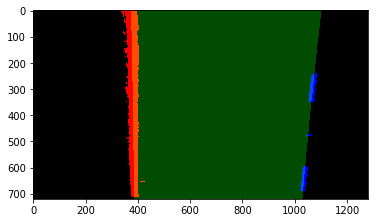

In [53]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

vid_section = VideoFileClip("../project_video.mp4")
image_clip = vid_section.fl_image(process_image) #NOTE: this function expects color images!!
%time image_clip.write_videofile('../output_video/P2_video_out.mp4', audio=False)

In [54]:
##Challenge Video IO

[[[  7.62904495e+02   0.00000000e+00]
  [  7.62188042e+02   1.00000000e+00]
  [  7.61472081e+02   2.00000000e+00]
  ..., 
  [  1.33675323e+03   2.00000000e+00]
  [  1.33792495e+03   1.00000000e+00]
  [  1.33909852e+03   0.00000000e+00]]]
[MoviePy] >>>> Building video ../output_video/P2__challenge_video_out.mp4
[MoviePy] Writing video ../output_video/P2__challenge_video_out.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

[[[  7.62904495e+02   0.00000000e+00]
  [  7.62188042e+02   1.00000000e+00]
  [  7.61472081e+02   2.00000000e+00]
  ..., 
  [  1.33675323e+03   2.00000000e+00]
  [  1.33792495e+03   1.00000000e+00]
  [  1.33909852e+03   0.00000000e+00]]]


  0%|          | 1/485 [00:00<07:05,  1.14it/s]

[[[  8.20901129e+02   0.00000000e+00]
  [  8.20004239e+02   1.00000000e+00]
  [  8.19108119e+02   2.00000000e+00]
  ..., 
  [  1.21633017e+03   2.00000000e+00]
  [  1.21711631e+03   1.00000000e+00]
  [  1.21790368e+03   0.00000000e+00]]]


  0%|          | 2/485 [00:01<07:05,  1.14it/s]

[[[  7.97672363e+02   0.00000000e+00]
  [  7.96856770e+02   1.00000000e+00]
  [  7.96041812e+02   2.00000000e+00]
  ..., 
  [  1.07988155e+03   2.00000000e+00]
  [  1.08025554e+03   1.00000000e+00]
  [  1.08063012e+03   0.00000000e+00]]]


  1%|          | 3/485 [00:02<07:07,  1.13it/s]

[[[  8.69374240e+02   0.00000000e+00]
  [  8.68322289e+02   1.00000000e+00]
  [  8.67271356e+02   2.00000000e+00]
  ..., 
  [  1.22868538e+03   2.00000000e+00]
  [  1.22947661e+03   1.00000000e+00]
  [  1.23026903e+03   0.00000000e+00]]]


  1%|          | 4/485 [00:03<06:29,  1.24it/s]

[[[ 930.89535685    0.        ]
  [ 929.64869348    1.        ]
  [ 928.4033626     2.        ]
  ..., 
  [ 432.36799601    2.        ]
  [ 430.87115271    1.        ]
  [ 429.3722028     0.        ]]]


  1%|          | 5/485 [00:03<05:35,  1.43it/s]

[[[  8.68999842e+02   0.00000000e+00]
  [  8.67935673e+02   1.00000000e+00]
  [  8.66872571e+02   2.00000000e+00]
  ..., 
  [  1.55970667e+03   2.00000000e+00]
  [  1.56142288e+03   1.00000000e+00]
  [  1.56314156e+03   0.00000000e+00]]]


  1%|          | 6/485 [00:04<04:56,  1.62it/s]

[[[  1.07869121e+03   0.00000000e+00]
  [  1.07697150e+03   1.00000000e+00]
  [  1.07525389e+03   2.00000000e+00]
  ..., 
  [  3.20895098e+02   2.00000000e+00]
  [  3.20446927e+02   1.00000000e+00]
  [  3.20000000e+02   0.00000000e+00]]]


  1%|▏         | 7/485 [00:04<04:27,  1.79it/s]

[[[ 717.76247586    0.        ]
  [ 717.219253      1.        ]
  [ 716.67621438    2.        ]
  ..., 
  [ 357.82867663    2.        ]
  [ 357.33031473    1.        ]
  [ 356.83333333    0.        ]]]


  2%|▏         | 8/485 [00:05<04:08,  1.92it/s]

[[[ 557.36618001    0.        ]
  [ 557.31678435    1.        ]
  [ 557.26682187    2.        ]
  ..., 
  [ 357.82867663    2.        ]
  [ 357.33031473    1.        ]
  [ 356.83333333    0.        ]]]


  2%|▏         | 9/485 [00:05<03:54,  2.03it/s]

[[[ 524.05351953    0.        ]
  [ 524.10048186    1.        ]
  [ 524.14674028    2.        ]
  ..., 
  [ 357.82867663    2.        ]
  [ 357.33031473    1.        ]
  [ 356.83333333    0.        ]]]


  2%|▏         | 10/485 [00:05<03:45,  2.11it/s]

[[[ 540.17044822    0.        ]
  [ 540.15252974    1.        ]
  [ 540.13402348    2.        ]
  ..., 
  [ 357.82867663    2.        ]
  [ 357.33031473    1.        ]
  [ 356.83333333    0.        ]]]


  2%|▏         | 11/485 [00:06<03:37,  2.18it/s]

[[[ 577.28204855    0.        ]
  [ 577.14262305    1.        ]
  [ 577.00280159    2.        ]
  ..., 
  [ 357.82867663    2.        ]
  [ 357.33031473    1.        ]
  [ 356.83333333    0.        ]]]


  2%|▏         | 12/485 [00:06<03:32,  2.23it/s]

[[[ 557.39863974    0.        ]
  [ 557.31246445    1.        ]
  [ 557.22581612    2.        ]
  ..., 
  [ 891.64208003    2.        ]
  [ 891.32354505    1.        ]
  [ 891.00431193    0.        ]]]


  3%|▎         | 13/485 [00:07<03:30,  2.25it/s]

[[[ 577.48959491    0.        ]
  [ 577.32427333    1.        ]
  [ 577.1586248     2.        ]
  ..., 
  [ 971.94040005    2.        ]
  [ 971.95628815    1.        ]
  [ 971.97215712    0.        ]]]


  3%|▎         | 14/485 [00:07<03:25,  2.29it/s]

[[[ 583.12730706    0.        ]
  [ 582.93368435    1.        ]
  [ 582.73979078    2.        ]
  ..., 
  [ 913.61968289    2.        ]
  [ 913.41986307    1.        ]
  [ 913.21963111    0.        ]]]


  3%|▎         | 15/485 [00:07<03:22,  2.32it/s]

[[[  5.97254782e+02   0.00000000e+00]
  [  5.97013890e+02   1.00000000e+00]
  [  5.96772802e+02   2.00000000e+00]
  ..., 
  [  1.04403289e+03   2.00000000e+00]
  [  1.04435880e+03   1.00000000e+00]
  [  1.04468531e+03   0.00000000e+00]]]


  3%|▎         | 16/485 [00:08<03:20,  2.34it/s]

[[[ 553.85450659    0.        ]
  [ 553.74450816    1.        ]
  [ 553.63411485    2.        ]
  ..., 
  [ 962.19844091    2.        ]
  [ 962.2113102     1.        ]
  [ 962.22419772    0.        ]]]


  4%|▎         | 17/485 [00:08<03:19,  2.35it/s]

[[[ 583.40326213    0.        ]
  [ 583.20604744    1.        ]
  [ 583.00856565    2.        ]
  ..., 
  [ 940.92864751    2.        ]
  [ 940.89590676    1.        ]
  [ 940.86312985    0.        ]]]


  4%|▎         | 18/485 [00:09<03:18,  2.35it/s]

[[[ 524.97127375    0.        ]
  [ 524.94810228    1.        ]
  [ 524.92439955    2.        ]
  ..., 
  [ 938.46798814    2.        ]
  [ 938.42306113    1.        ]
  [ 938.37807087    0.        ]]]


  4%|▍         | 19/485 [00:09<03:26,  2.26it/s]

[[[ 477.27537161    0.        ]
  [ 477.40115596    1.        ]
  [ 477.52617572    2.        ]
  ..., 
  [ 975.63103183    2.        ]
  [ 975.73672012    1.        ]
  [ 975.84262133    0.        ]]]


  4%|▍         | 20/485 [00:10<03:24,  2.27it/s]

[[[ 491.2475462     0.        ]
  [ 491.31169614    1.        ]
  [ 491.37520181    2.        ]
  ..., 
  [ 966.85847425    2.        ]
  [ 966.93249545    1.        ]
  [ 967.00667255    0.        ]]]


  4%|▍         | 21/485 [00:10<03:22,  2.30it/s]

[[[ 610.48630973    0.        ]
  [ 610.15447176    1.        ]
  [ 609.8226472     2.        ]
  ..., 
  [ 852.97562183    2.        ]
  [ 852.6606895     1.        ]
  [ 852.34523021    0.        ]]]


  5%|▍         | 22/485 [00:11<03:20,  2.31it/s]

[[[ 592.01767952    0.        ]
  [ 591.73784707    1.        ]
  [ 591.4579381     2.        ]
  ..., 
  [ 878.37995245    2.        ]
  [ 878.15030017    1.        ]
  [ 877.92027004    0.        ]]]


  5%|▍         | 23/485 [00:11<03:19,  2.32it/s]

[[[ 629.23961734    0.        ]
  [ 628.84719125    1.        ]
  [ 628.45486193    2.        ]
  ..., 
  [ 871.17978016    2.        ]
  [ 870.95413925    1.        ]
  [ 870.72815551    0.        ]]]


  5%|▍         | 24/485 [00:11<03:19,  2.31it/s]

[[[ 622.65896196    0.        ]
  [ 622.29850943    1.        ]
  [ 621.93808855    2.        ]
  ..., 
  [ 819.42235109    2.        ]
  [ 819.0504506     1.        ]
  [ 818.67799737    0.        ]]]


  5%|▌         | 25/485 [00:12<03:19,  2.30it/s]

[[[  7.40381541e+02   0.00000000e+00]
  [  7.39675624e+02   1.00000000e+00]
  [  7.38970253e+02   2.00000000e+00]
  ..., 
  [  1.01503328e+03   2.00000000e+00]
  [  1.01538210e+03   1.00000000e+00]
  [  1.01573166e+03   0.00000000e+00]]]


  5%|▌         | 26/485 [00:12<03:21,  2.27it/s]

[[[  6.67378774e+02   0.00000000e+00]
  [  6.66891107e+02   1.00000000e+00]
  [  6.66403653e+02   2.00000000e+00]
  ..., 
  [  1.00272831e+03   2.00000000e+00]
  [  1.00301935e+03   1.00000000e+00]
  [  1.00331100e+03   0.00000000e+00]]]


  6%|▌         | 27/485 [00:13<03:26,  2.22it/s]

[[[  6.74106850e+02   0.00000000e+00]
  [  6.73611924e+02   1.00000000e+00]
  [  6.73117207e+02   2.00000000e+00]
  ..., 
  [  1.00272833e+03   2.00000000e+00]
  [  1.00304249e+03   1.00000000e+00]
  [  1.00335731e+03   0.00000000e+00]]]


  6%|▌         | 28/485 [00:14<04:23,  1.74it/s]

[[[ 662.56845397    0.        ]
  [ 662.12302226    1.        ]
  [ 661.6777014     2.        ]
  ..., 
  [ 998.21951789    2.        ]
  [ 998.51641023    1.        ]
  [ 998.81391645    0.        ]]]


  6%|▌         | 29/485 [00:15<05:06,  1.49it/s]

[[[ 744.04667235    0.        ]
  [ 743.3452007     1.        ]
  [ 742.64423568    2.        ]
  ..., 
  [ 981.76669589    2.        ]
  [ 981.99881599    1.        ]
  [ 982.23141781    0.        ]]]


  6%|▌         | 30/485 [00:15<05:34,  1.36it/s]

[[[ 692.76712182    0.        ]
  [ 692.22639953    1.        ]
  [ 691.68593545    2.        ]
  ..., 
  [ 988.35172874    2.        ]
  [ 988.60812044    1.        ]
  [ 988.86502956    0.        ]]]


  6%|▋         | 31/485 [00:16<05:52,  1.29it/s]

[[[ 733.17736841    0.        ]
  [ 732.50378359    1.        ]
  [ 731.83067146    2.        ]
  ..., 
  [ 975.53833215    2.        ]
  [ 975.7470031     1.        ]
  [ 975.95609968    0.        ]]]


  7%|▋         | 32/485 [00:17<05:44,  1.31it/s]

[[[ 593.21525766    0.        ]
  [ 592.96977834    1.        ]
  [ 592.72411873    2.        ]
  ..., 
  [ 973.1610105     2.        ]
  [ 973.35999508    1.        ]
  [ 973.55937988    0.        ]]]


  7%|▋         | 33/485 [00:17<04:58,  1.51it/s]

[[[ 581.39467536    0.        ]
  [ 581.17577426    1.        ]
  [ 580.9566648     2.        ]
  ..., 
  [ 949.30533834    2.        ]
  [ 949.4248138     1.        ]
  [ 949.54454972    0.        ]]]


  7%|▋         | 34/485 [00:18<04:36,  1.63it/s]

[[[ 519.14499239    0.        ]
  [ 519.10152992    1.        ]
  [ 519.05761372    2.        ]
  ..., 
  [ 986.64437743    2.        ]
  [ 986.89470913    1.        ]
  [ 987.14552458    0.        ]]]


  7%|▋         | 35/485 [00:18<04:11,  1.79it/s]

[[[ 609.77831207    0.        ]
  [ 609.47050466    1.        ]
  [ 609.16262799    2.        ]
  ..., 
  [ 970.70592372    2.        ]
  [ 970.90617329    1.        ]
  [ 971.10679549    0.        ]]]


  7%|▋         | 36/485 [00:19<03:54,  1.92it/s]

[[[ 564.35576295    0.        ]
  [ 564.2253254     1.        ]
  [ 564.09449123    2.        ]
  ..., 
  [ 964.07799194    2.        ]
  [ 964.26725637    1.        ]
  [ 964.45687736    0.        ]]]


  8%|▊         | 37/485 [00:19<03:41,  2.02it/s]

[[[ 580.67777049    0.        ]
  [ 580.47557839    1.        ]
  [ 580.27313397    2.        ]
  ..., 
  [ 950.41926076    2.        ]
  [ 950.57129313    1.        ]
  [ 950.72361757    0.        ]]]


  8%|▊         | 38/485 [00:20<03:32,  2.10it/s]

[[[ 477.65896228    0.        ]
  [ 477.76272899    1.        ]
  [ 477.86578735    2.        ]
  ..., 
  [ 954.99466639    2.        ]
  [ 955.16181598    1.        ]
  [ 955.32928062    0.        ]]]


  8%|▊         | 39/485 [00:20<03:24,  2.18it/s]

[[[ 562.50776614    0.        ]
  [ 562.32909038    1.        ]
  [ 562.15016616    2.        ]
  ..., 
  [ 952.33777595    2.        ]
  [ 952.49245741    1.        ]
  [ 952.64742086    0.        ]]]


  8%|▊         | 40/485 [00:21<03:19,  2.23it/s]

[[[ 660.2821814     0.        ]
  [ 659.75862047    1.        ]
  [ 659.23539386    2.        ]
  ..., 
  [ 984.69041632    2.        ]
  [ 984.96691248    1.        ]
  [ 985.24392538    0.        ]]]


  8%|▊         | 41/485 [00:21<03:16,  2.26it/s]

[[[ 695.01740184    0.        ]
  [ 694.36641428    1.        ]
  [ 693.71597888    2.        ]
  ..., 
  [ 982.98245661    2.        ]
  [ 983.25467133    1.        ]
  [ 983.52738792    0.        ]]]


  9%|▊         | 42/485 [00:21<03:15,  2.27it/s]

[[[  6.83489718e+02   0.00000000e+00]
  [  6.82879638e+02   1.00000000e+00]
  [  6.82270037e+02   2.00000000e+00]
  ..., 
  [  1.02187870e+03   2.00000000e+00]
  [  1.02231450e+03   1.00000000e+00]
  [  1.02275111e+03   0.00000000e+00]]]


  9%|▉         | 43/485 [00:22<04:00,  1.84it/s]

[[[  7.50732523e+02   0.00000000e+00]
  [  7.49920403e+02   1.00000000e+00]
  [  7.49109059e+02   2.00000000e+00]
  ..., 
  [  1.05541252e+03   2.00000000e+00]
  [  1.05598003e+03   1.00000000e+00]
  [  1.05654858e+03   0.00000000e+00]]]


  9%|▉         | 44/485 [00:23<03:53,  1.89it/s]

[[[  6.77395035e+02   0.00000000e+00]
  [  6.76824833e+02   1.00000000e+00]
  [  6.76255012e+02   2.00000000e+00]
  ..., 
  [  1.07667995e+03   2.00000000e+00]
  [  1.07733611e+03   1.00000000e+00]
  [  1.07799345e+03   0.00000000e+00]]]


  9%|▉         | 45/485 [00:23<03:43,  1.97it/s]

[[[  6.40504816e+02   0.00000000e+00]
  [  6.40045439e+02   1.00000000e+00]
  [  6.39586264e+02   2.00000000e+00]
  ..., 
  [  1.08457019e+03   2.00000000e+00]
  [  1.08523051e+03   1.00000000e+00]
  [  1.08589199e+03   0.00000000e+00]]]


  9%|▉         | 46/485 [00:24<03:44,  1.95it/s]

[[[  6.08356101e+02   0.00000000e+00]
  [  6.07996403e+02   1.00000000e+00]
  [  6.07636745e+02   2.00000000e+00]
  ..., 
  [  1.10536627e+03   2.00000000e+00]
  [  1.10608956e+03   1.00000000e+00]
  [  1.10681410e+03   0.00000000e+00]]]


 10%|▉         | 47/485 [00:24<03:41,  1.98it/s]

[[[  5.84952831e+02   0.00000000e+00]
  [  5.84636391e+02   1.00000000e+00]
  [  5.84319961e+02   2.00000000e+00]
  ..., 
  [  1.10855898e+03   2.00000000e+00]
  [  1.10928405e+03   1.00000000e+00]
  [  1.11001035e+03   0.00000000e+00]]]


 10%|▉         | 48/485 [00:25<03:39,  1.99it/s]

[[[  9.01064309e+02   0.00000000e+00]
  [  8.99784774e+02   1.00000000e+00]
  [  8.98506715e+02   2.00000000e+00]
  ..., 
  [  1.12013474e+03   2.00000000e+00]
  [  1.12090495e+03   1.00000000e+00]
  [  1.12167646e+03   0.00000000e+00]]]


 10%|█         | 49/485 [00:25<03:44,  1.94it/s]

[[[  7.64375355e+02   0.00000000e+00]
  [  7.63546414e+02   1.00000000e+00]
  [  7.62718202e+02   2.00000000e+00]
  ..., 
  [  1.12761398e+03   2.00000000e+00]
  [  1.12841741e+03   1.00000000e+00]
  [  1.12922219e+03   0.00000000e+00]]]


 10%|█         | 50/485 [00:26<03:50,  1.89it/s]

[[[  7.72955437e+02   0.00000000e+00]
  [  7.72117874e+02   1.00000000e+00]
  [  7.71281026e+02   2.00000000e+00]
  ..., 
  [  1.12626249e+03   2.00000000e+00]
  [  1.12704921e+03   1.00000000e+00]
  [  1.12783723e+03   0.00000000e+00]]]


 11%|█         | 51/485 [00:26<03:43,  1.94it/s]

[[[  6.85908444e+02   0.00000000e+00]
  [  6.85353464e+02   1.00000000e+00]
  [  6.84798740e+02   2.00000000e+00]
  ..., 
  [  1.13000481e+03   2.00000000e+00]
  [  1.13079825e+03   1.00000000e+00]
  [  1.13159298e+03   0.00000000e+00]]]


 11%|█         | 52/485 [00:27<03:43,  1.94it/s]

[[[  6.31953167e+02   0.00000000e+00]
  [  6.31569936e+02   1.00000000e+00]
  [  6.31186687e+02   2.00000000e+00]
  ..., 
  [  1.13077016e+03   2.00000000e+00]
  [  1.13155302e+03   1.00000000e+00]
  [  1.13233712e+03   0.00000000e+00]]]


 11%|█         | 53/485 [00:27<03:38,  1.98it/s]

[[[  9.39420286e+02   0.00000000e+00]
  [  9.38061597e+02   1.00000000e+00]
  [  9.36704419e+02   2.00000000e+00]
  ..., 
  [  1.17144165e+03   2.00000000e+00]
  [  1.17236999e+03   1.00000000e+00]
  [  1.17329986e+03   0.00000000e+00]]]


 11%|█         | 54/485 [00:28<03:35,  2.00it/s]

[[[  8.83321505e+02   0.00000000e+00]
  [  8.82135991e+02   1.00000000e+00]
  [  8.80951721e+02   2.00000000e+00]
  ..., 
  [  1.16947016e+03   2.00000000e+00]
  [  1.17037004e+03   1.00000000e+00]
  [  1.17127135e+03   0.00000000e+00]]]


 11%|█▏        | 55/485 [00:28<03:38,  1.97it/s]

[[[  7.41326987e+02   0.00000000e+00]
  [  7.40586992e+02   1.00000000e+00]
  [  7.39847542e+02   2.00000000e+00]
  ..., 
  [  1.17157289e+03   2.00000000e+00]
  [  1.17246703e+03   1.00000000e+00]
  [  1.17336257e+03   0.00000000e+00]]]


 12%|█▏        | 56/485 [00:29<03:39,  1.96it/s]

[[[  7.94413553e+02   0.00000000e+00]
  [  7.93502111e+02   1.00000000e+00]
  [  7.92591488e+02   2.00000000e+00]
  ..., 
  [  1.16691985e+03   2.00000000e+00]
  [  1.16778624e+03   1.00000000e+00]
  [  1.16865396e+03   0.00000000e+00]]]


 12%|█▏        | 57/485 [00:30<04:27,  1.60it/s]

[[[  6.92136218e+02   0.00000000e+00]
  [  6.91562384e+02   1.00000000e+00]
  [  6.90988817e+02   2.00000000e+00]
  ..., 
  [  1.16607584e+03   2.00000000e+00]
  [  1.16692784e+03   1.00000000e+00]
  [  1.16778112e+03   0.00000000e+00]]]


 12%|█▏        | 58/485 [00:31<05:05,  1.40it/s]

[[[  7.47347608e+02   0.00000000e+00]
  [  7.46655747e+02   1.00000000e+00]
  [  7.45964269e+02   2.00000000e+00]
  ..., 
  [  1.18580831e+03   2.00000000e+00]
  [  1.18672374e+03   1.00000000e+00]
  [  1.18764053e+03   0.00000000e+00]]]


 12%|█▏        | 59/485 [00:31<05:29,  1.29it/s]

[[[  4.59023873e+02   0.00000000e+00]
  [  4.59220342e+02   1.00000000e+00]
  [  4.59415819e+02   2.00000000e+00]
  ..., 
  [  1.19221422e+03   2.00000000e+00]
  [  1.19313180e+03   1.00000000e+00]
  [  1.19405071e+03   0.00000000e+00]]]


 12%|█▏        | 60/485 [00:32<05:48,  1.22it/s]

[[[ -2.51580885e+02   0.00000000e+00]
  [ -2.49225005e+02   1.00000000e+00]
  [ -2.46873391e+02   2.00000000e+00]
  ..., 
  [  1.19219232e+03   2.00000000e+00]
  [  1.19308809e+03   1.00000000e+00]
  [  1.19398514e+03   0.00000000e+00]]]


 13%|█▎        | 61/485 [00:33<05:47,  1.22it/s]

[[[  8.04111501e+01   0.00000000e+00]
  [  8.17258921e+01   1.00000000e+00]
  [  8.30379904e+01   2.00000000e+00]
  ..., 
  [  1.19284270e+03   2.00000000e+00]
  [  1.19371511e+03   1.00000000e+00]
  [  1.19458872e+03   0.00000000e+00]]]


 13%|█▎        | 62/485 [00:34<05:04,  1.39it/s]

[[[  1.10968626e+03   0.00000000e+00]
  [  1.10778241e+03   1.00000000e+00]
  [  1.10588092e+03   2.00000000e+00]
  ..., 
  [  1.19546839e+03   2.00000000e+00]
  [  1.19634242e+03   1.00000000e+00]
  [  1.19721766e+03   0.00000000e+00]]]


 13%|█▎        | 63/485 [00:34<04:33,  1.54it/s]

[[[  1.30128172e+03   0.00000000e+00]
  [  1.29884600e+03   1.00000000e+00]
  [  1.29641338e+03   2.00000000e+00]
  ..., 
  [  1.18582243e+03   2.00000000e+00]
  [  1.18663986e+03   1.00000000e+00]
  [  1.18745835e+03   0.00000000e+00]]]


 13%|█▎        | 64/485 [00:35<04:18,  1.63it/s]

[[[  9.93525027e+02   0.00000000e+00]
  [  9.92049524e+02   1.00000000e+00]
  [  9.90575622e+02   2.00000000e+00]
  ..., 
  [  1.18834469e+03   2.00000000e+00]
  [  1.18916782e+03   1.00000000e+00]
  [  1.18999201e+03   0.00000000e+00]]]


 13%|█▎        | 65/485 [00:35<04:02,  1.73it/s]

[[[  9.00239549e+02   0.00000000e+00]
  [  8.99079112e+02   1.00000000e+00]
  [  8.97919759e+02   2.00000000e+00]
  ..., 
  [  1.19570579e+03   2.00000000e+00]
  [  1.19655797e+03   1.00000000e+00]
  [  1.19741126e+03   0.00000000e+00]]]


 14%|█▎        | 66/485 [00:36<03:58,  1.76it/s]

[[[  7.36034328e+02   0.00000000e+00]
  [  7.35388447e+02   1.00000000e+00]
  [  7.34742854e+02   2.00000000e+00]
  ..., 
  [  1.18698351e+03   2.00000000e+00]
  [  1.18780018e+03   1.00000000e+00]
  [  1.18861788e+03   0.00000000e+00]]]


 14%|█▍        | 67/485 [00:36<03:52,  1.79it/s]

[[[  6.62174785e+02   0.00000000e+00]
  [  6.61747454e+02   1.00000000e+00]
  [  6.61320093e+02   2.00000000e+00]
  ..., 
  [  1.18324262e+03   2.00000000e+00]
  [  1.18403248e+03   1.00000000e+00]
  [  1.18482334e+03   0.00000000e+00]]]


 14%|█▍        | 68/485 [00:37<03:43,  1.86it/s]

[[[  7.99825751e+02   0.00000000e+00]
  [  7.99016841e+02   1.00000000e+00]
  [  7.98208445e+02   2.00000000e+00]
  ..., 
  [  1.27911558e+03   2.00000000e+00]
  [  1.28030302e+03   1.00000000e+00]
  [  1.28149223e+03   0.00000000e+00]]]


 14%|█▍        | 69/485 [00:37<03:36,  1.93it/s]

[[[  1.02846940e+03   0.00000000e+00]
  [  1.02698061e+03   1.00000000e+00]
  [  1.02549335e+03   2.00000000e+00]
  ..., 
  [  1.24284620e+03   2.00000000e+00]
  [  1.24385951e+03   1.00000000e+00]
  [  1.24487424e+03   0.00000000e+00]]]


 14%|█▍        | 70/485 [00:38<03:50,  1.80it/s]

[[[  1.20174563e+03   0.00000000e+00]
  [  1.19973033e+03   1.00000000e+00]
  [  1.19771737e+03   2.00000000e+00]
  ..., 
  [  1.26079813e+03   2.00000000e+00]
  [  1.26186612e+03   1.00000000e+00]
  [  1.26293561e+03   0.00000000e+00]]]


 15%|█▍        | 71/485 [00:39<04:34,  1.51it/s]

[[[  5.22518060e+02   0.00000000e+00]
  [  5.22590121e+02   1.00000000e+00]
  [  5.22661313e+02   2.00000000e+00]
  ..., 
  [  1.24556513e+03   2.00000000e+00]
  [  1.24653963e+03   1.00000000e+00]
  [  1.24751542e+03   0.00000000e+00]]]


 15%|█▍        | 72/485 [00:40<05:06,  1.35it/s]

[[[  9.31413853e+02   0.00000000e+00]
  [  9.30290882e+02   1.00000000e+00]
  [  9.29168797e+02   2.00000000e+00]
  ..., 
  [  1.26002336e+03   2.00000000e+00]
  [  1.26103964e+03   1.00000000e+00]
  [  1.26205727e+03   0.00000000e+00]]]


 15%|█▌        | 73/485 [00:41<05:32,  1.24it/s]

[[[  5.12797456e+02   0.00000000e+00]
  [  5.12917153e+02   1.00000000e+00]
  [  5.13035896e+02   2.00000000e+00]
  ..., 
  [  1.24501880e+03   2.00000000e+00]
  [  1.24595483e+03   1.00000000e+00]
  [  1.24689204e+03   0.00000000e+00]]]


 15%|█▌        | 74/485 [00:42<05:45,  1.19it/s]

[[[  2.77648269e+02   0.00000000e+00]
  [  2.78441672e+02   1.00000000e+00]
  [  2.79233161e+02   2.00000000e+00]
  ..., 
  [  1.28829600e+03   2.00000000e+00]
  [  1.28938381e+03   1.00000000e+00]
  [  1.29047306e+03   0.00000000e+00]]]


 15%|█▌        | 75/485 [00:42<05:37,  1.22it/s]

[[[ -3.98603610e+01   0.00000000e+00]
  [ -3.81527600e+01   1.00000000e+00]
  [ -3.64483845e+01   2.00000000e+00]
  ..., 
  [  1.29294620e+03   2.00000000e+00]
  [  1.29403975e+03   1.00000000e+00]
  [  1.29513474e+03   0.00000000e+00]]]


 16%|█▌        | 76/485 [00:43<04:56,  1.38it/s]

[[[  1.02944290e+03   0.00000000e+00]
  [  1.02790808e+03   1.00000000e+00]
  [  1.02637495e+03   2.00000000e+00]
  ..., 
  [  1.29708666e+03   2.00000000e+00]
  [  1.29817987e+03   1.00000000e+00]
  [  1.29927451e+03   0.00000000e+00]]]


 16%|█▌        | 77/485 [00:43<04:26,  1.53it/s]

[[[  6.37949270e+02   0.00000000e+00]
  [  6.37616242e+02   1.00000000e+00]
  [  6.37283054e+02   2.00000000e+00]
  ..., 
  [  1.26066304e+03   2.00000000e+00]
  [  1.26156014e+03   1.00000000e+00]
  [  1.26245818e+03   0.00000000e+00]]]


 16%|█▌        | 78/485 [00:44<04:12,  1.61it/s]

[[[  7.36672293e+02   0.00000000e+00]
  [  7.35913766e+02   1.00000000e+00]
  [  7.35155900e+02   2.00000000e+00]
  ..., 
  [  1.26420136e+03   2.00000000e+00]
  [  1.26511180e+03   1.00000000e+00]
  [  1.26602323e+03   0.00000000e+00]]]


 16%|█▋        | 79/485 [00:44<03:54,  1.73it/s]

[[[  9.02304722e+02   0.00000000e+00]
  [  9.00876643e+02   1.00000000e+00]
  [  8.99450464e+02   2.00000000e+00]
  ..., 
  [  1.26838387e+03   2.00000000e+00]
  [  1.26930791e+03   1.00000000e+00]
  [  1.27023297e+03   0.00000000e+00]]]


 16%|█▋        | 80/485 [00:45<03:43,  1.81it/s]

[[[  1.83974920e+03   0.00000000e+00]
  [  1.83553760e+03   1.00000000e+00]
  [  1.83133202e+03   2.00000000e+00]
  ..., 
  [  1.26705564e+03   2.00000000e+00]
  [  1.26797286e+03   1.00000000e+00]
  [  1.26889110e+03   0.00000000e+00]]]


 17%|█▋        | 81/485 [00:45<03:40,  1.83it/s]

[[[  1.91706259e+03   0.00000000e+00]
  [  1.91261402e+03   1.00000000e+00]
  [  1.90817183e+03   2.00000000e+00]
  ..., 
  [  1.26845402e+03   2.00000000e+00]
  [  1.26934728e+03   1.00000000e+00]
  [  1.27024151e+03   0.00000000e+00]]]


 17%|█▋        | 82/485 [00:46<04:21,  1.54it/s]

[[[  1.85169221e+03   0.00000000e+00]
  [  1.84741800e+03   1.00000000e+00]
  [  1.84314995e+03   2.00000000e+00]
  ..., 
  [  1.26371830e+03   2.00000000e+00]
  [  1.26458151e+03   1.00000000e+00]
  [  1.26544562e+03   0.00000000e+00]]]


 17%|█▋        | 83/485 [00:47<04:55,  1.36it/s]

[[[  1.80312714e+03   0.00000000e+00]
  [  1.79895477e+03   1.00000000e+00]
  [  1.79478847e+03   2.00000000e+00]
  ..., 
  [  1.27063645e+03   2.00000000e+00]
  [  1.27151803e+03   1.00000000e+00]
  [  1.27240054e+03   0.00000000e+00]]]


 17%|█▋        | 84/485 [00:48<05:25,  1.23it/s]

[[[  8.17949609e+02   0.00000000e+00]
  [  8.16985823e+02   1.00000000e+00]
  [  8.16022907e+02   2.00000000e+00]
  ..., 
  [  1.26832697e+03   2.00000000e+00]
  [  1.26919926e+03   1.00000000e+00]
  [  1.27007246e+03   0.00000000e+00]]]


 18%|█▊        | 85/485 [00:49<05:38,  1.18it/s]

[[[  7.34908757e+02   0.00000000e+00]
  [  7.34351380e+02   1.00000000e+00]
  [  7.33794038e+02   2.00000000e+00]
  ..., 
  [  1.26696257e+03   2.00000000e+00]
  [  1.26782940e+03   1.00000000e+00]
  [  1.26869716e+03   0.00000000e+00]]]


 18%|█▊        | 86/485 [00:50<05:50,  1.14it/s]

[[[  5.84264839e+02   0.00000000e+00]
  [  5.84000677e+02   1.00000000e+00]
  [  5.83736356e+02   2.00000000e+00]
  ..., 
  [  1.26360666e+03   2.00000000e+00]
  [  1.26447672e+03   1.00000000e+00]
  [  1.26534772e+03   0.00000000e+00]]]


 18%|█▊        | 87/485 [00:51<05:07,  1.29it/s]

[[[  7.11619245e+02   0.00000000e+00]
  [  7.11086299e+02   1.00000000e+00]
  [  7.10553432e+02   2.00000000e+00]
  ..., 
  [  1.26441953e+03   2.00000000e+00]
  [  1.26530231e+03   1.00000000e+00]
  [  1.26618607e+03   0.00000000e+00]]]


 18%|█▊        | 88/485 [00:51<04:33,  1.45it/s]

[[[  5.35995739e+02   0.00000000e+00]
  [  5.36057953e+02   1.00000000e+00]
  [  5.36119239e+02   2.00000000e+00]
  ..., 
  [  1.26598236e+03   2.00000000e+00]
  [  1.26687312e+03   1.00000000e+00]
  [  1.26776488e+03   0.00000000e+00]]]


 18%|█▊        | 89/485 [00:52<04:10,  1.58it/s]

[[[  1.25527394e+03   0.00000000e+00]
  [  1.25296425e+03   1.00000000e+00]
  [  1.25065751e+03   2.00000000e+00]
  ..., 
  [  1.26087723e+03   2.00000000e+00]
  [  1.26173765e+03   1.00000000e+00]
  [  1.26259901e+03   0.00000000e+00]]]


 19%|█▊        | 90/485 [00:52<03:57,  1.67it/s]

[[[  1.51160887e+03   0.00000000e+00]
  [  1.50853416e+03   1.00000000e+00]
  [  1.50546360e+03   2.00000000e+00]
  ..., 
  [  1.26542134e+03   2.00000000e+00]
  [  1.26630253e+03   1.00000000e+00]
  [  1.26718471e+03   0.00000000e+00]]]


 19%|█▉        | 91/485 [00:53<03:42,  1.77it/s]

[[[  1.89317054e+03   0.00000000e+00]
  [  1.88895506e+03   1.00000000e+00]
  [  1.88474540e+03   2.00000000e+00]
  ..., 
  [  1.25387263e+03   2.00000000e+00]
  [  1.25469720e+03   1.00000000e+00]
  [  1.25552264e+03   0.00000000e+00]]]


 19%|█▉        | 92/485 [00:53<03:35,  1.82it/s]

[[[  5.32213592e+02   0.00000000e+00]
  [  5.32232549e+02   1.00000000e+00]
  [  5.32250700e+02   2.00000000e+00]
  ..., 
  [  1.25433522e+03   2.00000000e+00]
  [  1.25516248e+03   1.00000000e+00]
  [  1.25599064e+03   0.00000000e+00]]]


 19%|█▉        | 93/485 [00:54<03:27,  1.89it/s]

[[[  1.37016212e+02   0.00000000e+00]
  [  1.38216995e+02   1.00000000e+00]
  [  1.39415214e+02   2.00000000e+00]
  ..., 
  [  1.24593190e+03   2.00000000e+00]
  [  1.24672019e+03   1.00000000e+00]
  [  1.24750930e+03   0.00000000e+00]]]


 19%|█▉        | 94/485 [00:54<03:25,  1.90it/s]

[[[  5.31034857e+02   0.00000000e+00]
  [  5.31010343e+02   1.00000000e+00]
  [  5.30985198e+02   2.00000000e+00]
  ..., 
  [  1.23973928e+03   2.00000000e+00]
  [  1.24052790e+03   1.00000000e+00]
  [  1.24131737e+03   0.00000000e+00]]]


 20%|█▉        | 95/485 [00:55<03:18,  1.96it/s]

[[[  4.88006639e+02   0.00000000e+00]
  [  4.88247564e+02   1.00000000e+00]
  [  4.88487256e+02   2.00000000e+00]
  ..., 
  [  1.24652718e+03   2.00000000e+00]
  [  1.24736001e+03   1.00000000e+00]
  [  1.24819380e+03   0.00000000e+00]]]


 20%|█▉        | 96/485 [00:55<03:19,  1.95it/s]

[[[  5.34658005e+02   0.00000000e+00]
  [  5.34807553e+02   1.00000000e+00]
  [  5.34955981e+02   2.00000000e+00]
  ..., 
  [  1.24802935e+03   2.00000000e+00]
  [  1.24891126e+03   1.00000000e+00]
  [  1.24979426e+03   0.00000000e+00]]]


 20%|██        | 97/485 [00:56<03:13,  2.00it/s]

[[[  3.46685452e+02   0.00000000e+00]
  [  3.47385350e+02   1.00000000e+00]
  [  3.48083356e+02   2.00000000e+00]
  ..., 
  [  1.24152788e+03   2.00000000e+00]
  [  1.24240104e+03   1.00000000e+00]
  [  1.24327530e+03   0.00000000e+00]]]


 20%|██        | 98/485 [00:56<03:14,  1.99it/s]

[[[  5.18402145e+02   0.00000000e+00]
  [  5.18647066e+02   1.00000000e+00]
  [  5.18890671e+02   2.00000000e+00]
  ..., 
  [  1.24038937e+03   2.00000000e+00]
  [  1.24127719e+03   1.00000000e+00]
  [  1.24216615e+03   0.00000000e+00]]]


 20%|██        | 99/485 [00:57<03:10,  2.02it/s]

[[[  5.95009795e+02   0.00000000e+00]
  [  5.94967858e+02   1.00000000e+00]
  [  5.94925135e+02   2.00000000e+00]
  ..., 
  [  1.23364347e+03   2.00000000e+00]
  [  1.23449829e+03   1.00000000e+00]
  [  1.23535417e+03   0.00000000e+00]]]


 21%|██        | 100/485 [00:57<03:11,  2.01it/s]

[[[  5.32274672e+02   0.00000000e+00]
  [  5.32365694e+02   1.00000000e+00]
  [  5.32455827e+02   2.00000000e+00]
  ..., 
  [  1.23018788e+03   2.00000000e+00]
  [  1.23101107e+03   1.00000000e+00]
  [  1.23183526e+03   0.00000000e+00]]]


 21%|██        | 101/485 [00:58<03:08,  2.04it/s]

[[[  5.38193287e+02   0.00000000e+00]
  [  5.38330279e+02   1.00000000e+00]
  [  5.38466211e+02   2.00000000e+00]
  ..., 
  [  1.22653536e+03   2.00000000e+00]
  [  1.22732729e+03   1.00000000e+00]
  [  1.22812015e+03   0.00000000e+00]]]


 21%|██        | 102/485 [00:58<03:13,  1.98it/s]

[[[  2.63325033e+02   0.00000000e+00]
  [  2.64357135e+02   1.00000000e+00]
  [  2.65386767e+02   2.00000000e+00]
  ..., 
  [  1.22417191e+03   2.00000000e+00]
  [  1.22495015e+03   1.00000000e+00]
  [  1.22572930e+03   0.00000000e+00]]]


 21%|██        | 103/485 [00:59<03:18,  1.93it/s]

[[[ -1.58381485e+02   0.00000000e+00]
  [ -1.56223186e+02   1.00000000e+00]
  [ -1.54068840e+02   2.00000000e+00]
  ..., 
  [  1.22091631e+03   2.00000000e+00]
  [  1.22166149e+03   1.00000000e+00]
  [  1.22240751e+03   0.00000000e+00]]]


 21%|██▏       | 104/485 [00:59<03:17,  1.93it/s]

[[[  1.15229649e+03   0.00000000e+00]
  [  1.15037692e+03   1.00000000e+00]
  [  1.14845972e+03   2.00000000e+00]
  ..., 
  [  1.21595593e+03   2.00000000e+00]
  [  1.21668466e+03   1.00000000e+00]
  [  1.21741421e+03   0.00000000e+00]]]


 22%|██▏       | 105/485 [01:00<03:13,  1.96it/s]

[[[  5.29206531e+02   0.00000000e+00]
  [  5.29241849e+02   1.00000000e+00]
  [  5.29276455e+02   2.00000000e+00]
  ..., 
  [  1.24990708e+03   2.00000000e+00]
  [  1.25083990e+03   1.00000000e+00]
  [  1.25177406e+03   0.00000000e+00]]]


 22%|██▏       | 106/485 [01:00<03:15,  1.94it/s]

[[[  4.93270431e+02   0.00000000e+00]
  [  4.93330124e+02   1.00000000e+00]
  [  4.93389195e+02   2.00000000e+00]
  ..., 
  [  1.19448291e+03   2.00000000e+00]
  [  1.19512862e+03   1.00000000e+00]
  [  1.19577497e+03   0.00000000e+00]]]


 22%|██▏       | 107/485 [01:01<03:12,  1.97it/s]

[[[  5.04216497e+02   0.00000000e+00]
  [  5.04165180e+02   1.00000000e+00]
  [  5.04113549e+02   2.00000000e+00]
  ..., 
  [  1.19085204e+03   2.00000000e+00]
  [  1.19150438e+03   1.00000000e+00]
  [  1.19215741e+03   0.00000000e+00]]]


 22%|██▏       | 108/485 [01:01<03:13,  1.94it/s]

[[[  2.52195768e+02   0.00000000e+00]
  [  2.53082282e+02   1.00000000e+00]
  [  2.53966799e+02   2.00000000e+00]
  ..., 
  [  1.18366487e+03   2.00000000e+00]
  [  1.18431661e+03   1.00000000e+00]
  [  1.18496906e+03   0.00000000e+00]]]


 22%|██▏       | 109/485 [01:02<03:10,  1.97it/s]

[[[  2.89318817e+02   0.00000000e+00]
  [  2.90077829e+02   1.00000000e+00]
  [  2.90835061e+02   2.00000000e+00]
  ..., 
  [  1.16153049e+03   2.00000000e+00]
  [  1.16210966e+03   1.00000000e+00]
  [  1.16268942e+03   0.00000000e+00]]]


 23%|██▎       | 110/485 [01:02<03:14,  1.92it/s]

[[[  2.47365887e+02   0.00000000e+00]
  [  2.48277321e+02   1.00000000e+00]
  [  2.49186703e+02   2.00000000e+00]
  ..., 
  [  1.15869813e+03   2.00000000e+00]
  [  1.15928452e+03   1.00000000e+00]
  [  1.15987153e+03   0.00000000e+00]]]


 23%|██▎       | 111/485 [01:03<03:31,  1.77it/s]

[[[  3.26499784e+02   0.00000000e+00]
  [  3.27089400e+02   1.00000000e+00]
  [  3.27677580e+02   2.00000000e+00]
  ..., 
  [  1.15360925e+03   2.00000000e+00]
  [  1.15417018e+03   1.00000000e+00]
  [  1.15473169e+03   0.00000000e+00]]]


 23%|██▎       | 112/485 [01:04<04:14,  1.46it/s]

[[[  4.13123984e+02   0.00000000e+00]
  [  4.13325664e+02   1.00000000e+00]
  [  4.13526692e+02   2.00000000e+00]
  ..., 
  [  1.14346346e+03   2.00000000e+00]
  [  1.14401247e+03   1.00000000e+00]
  [  1.14456206e+03   0.00000000e+00]]]


 23%|██▎       | 113/485 [01:05<04:41,  1.32it/s]

[[[  3.75577281e+02   0.00000000e+00]
  [  3.76139679e+02   1.00000000e+00]
  [  3.76700491e+02   2.00000000e+00]
  ..., 
  [  1.15659702e+03   2.00000000e+00]
  [  1.15717349e+03   1.00000000e+00]
  [  1.15775059e+03   0.00000000e+00]]]


 24%|██▎       | 114/485 [01:06<05:01,  1.23it/s]

[[[  2.79647307e+02   0.00000000e+00]
  [  2.80374705e+02   1.00000000e+00]
  [  2.81100469e+02   2.00000000e+00]
  ..., 
  [  1.15956292e+03   2.00000000e+00]
  [  1.16014634e+03   1.00000000e+00]
  [  1.16073041e+03   0.00000000e+00]]]


 24%|██▎       | 115/485 [01:07<05:10,  1.19it/s]

[[[  3.44361543e+02   0.00000000e+00]
  [  3.44940299e+02   1.00000000e+00]
  [  3.45517567e+02   2.00000000e+00]
  ..., 
  [  1.16394358e+03   2.00000000e+00]
  [  1.16452327e+03   1.00000000e+00]
  [  1.16510358e+03   0.00000000e+00]]]


 24%|██▍       | 116/485 [01:07<04:58,  1.24it/s]

[[[  2.62548926e+02   0.00000000e+00]
  [  2.63382963e+02   1.00000000e+00]
  [  2.64215116e+02   2.00000000e+00]
  ..., 
  [  1.18563707e+03   2.00000000e+00]
  [  1.18631269e+03   1.00000000e+00]
  [  1.18698912e+03   0.00000000e+00]]]


 24%|██▍       | 117/485 [01:08<04:21,  1.41it/s]

[[[  2.96507574e+02   0.00000000e+00]
  [  2.97239462e+02   1.00000000e+00]
  [  2.97969627e+02   2.00000000e+00]
  ..., 
  [  1.22142240e+03   2.00000000e+00]
  [  1.22223686e+03   1.00000000e+00]
  [  1.22305238e+03   0.00000000e+00]]]


 24%|██▍       | 118/485 [01:08<04:00,  1.53it/s]

[[[  9.29006732e+02   0.00000000e+00]
  [  9.27706345e+02   1.00000000e+00]
  [  9.26407489e+02   2.00000000e+00]
  ..., 
  [  1.22083845e+03   2.00000000e+00]
  [  1.22167240e+03   1.00000000e+00]
  [  1.22250747e+03   0.00000000e+00]]]


 25%|██▍       | 119/485 [01:09<03:41,  1.65it/s]

[[[  1.67740261e+02   0.00000000e+00]
  [  1.68832107e+02   1.00000000e+00]
  [  1.69921739e+02   2.00000000e+00]
  ..., 
  [  1.19209132e+03   2.00000000e+00]
  [  1.19283880e+03   1.00000000e+00]
  [  1.19358726e+03   0.00000000e+00]]]


 25%|██▍       | 120/485 [01:09<03:32,  1.72it/s]

[[[  3.26041758e+02   0.00000000e+00]
  [  3.26711069e+02   1.00000000e+00]
  [  3.27378720e+02   2.00000000e+00]
  ..., 
  [  1.18194520e+03   2.00000000e+00]
  [  1.18265889e+03   1.00000000e+00]
  [  1.18337350e+03   0.00000000e+00]]]


 25%|██▍       | 121/485 [01:10<03:28,  1.75it/s]

[[[  2.82417732e+02   0.00000000e+00]
  [  2.83214399e+02   1.00000000e+00]
  [  2.84009210e+02   2.00000000e+00]
  ..., 
  [  1.19509483e+03   2.00000000e+00]
  [  1.19584839e+03   1.00000000e+00]
  [  1.19660293e+03   0.00000000e+00]]]


 25%|██▌       | 122/485 [01:11<03:22,  1.79it/s]

[[[  2.55946631e+02   0.00000000e+00]
  [  2.56788315e+02   1.00000000e+00]
  [  2.57628126e+02   2.00000000e+00]
  ..., 
  [  1.19545126e+03   2.00000000e+00]
  [  1.19620666e+03   1.00000000e+00]
  [  1.19696303e+03   0.00000000e+00]]]


 25%|██▌       | 123/485 [01:11<03:15,  1.85it/s]

[[[  1.80650574e+02   0.00000000e+00]
  [  1.81726173e+02   1.00000000e+00]
  [  1.82799532e+02   2.00000000e+00]
  ..., 
  [  1.17583128e+03   2.00000000e+00]
  [  1.17650914e+03   1.00000000e+00]
  [  1.17718784e+03   0.00000000e+00]]]


 26%|██▌       | 124/485 [01:12<03:15,  1.85it/s]

[[[ -2.39099515e+02   0.00000000e+00]
  [ -2.36720329e+02   1.00000000e+00]
  [ -2.34345410e+02   2.00000000e+00]
  ..., 
  [  1.15140528e+03   2.00000000e+00]
  [  1.15200864e+03   1.00000000e+00]
  [  1.15261272e+03   0.00000000e+00]]]


 26%|██▌       | 125/485 [01:12<03:10,  1.89it/s]

[[[ -3.34158829e+02   0.00000000e+00]
  [ -3.31470916e+02   1.00000000e+00]
  [ -3.28787780e+02   2.00000000e+00]
  ..., 
  [  1.35712542e+03   2.00000000e+00]
  [  1.35838001e+03   1.00000000e+00]
  [  1.35963637e+03   0.00000000e+00]]]


 26%|██▌       | 126/485 [01:13<03:10,  1.89it/s]

[[[ -1.01028603e+02   0.00000000e+00]
  [ -9.90933502e+01   1.00000000e+00]
  [ -9.71616693e+01   2.00000000e+00]
  ..., 
  [  1.38417714e+03   2.00000000e+00]
  [  1.38550512e+03   1.00000000e+00]
  [  1.38683497e+03   0.00000000e+00]]]


 26%|██▌       | 127/485 [01:13<03:06,  1.92it/s]

[[[ -2.28526678e+02   0.00000000e+00]
  [ -2.26225715e+02   1.00000000e+00]
  [ -2.23928846e+02   2.00000000e+00]
  ..., 
  [  1.41515135e+03   2.00000000e+00]
  [  1.41654864e+03   1.00000000e+00]
  [  1.41794785e+03   0.00000000e+00]]]


 26%|██▋       | 128/485 [01:14<03:08,  1.89it/s]

[[[  1.77931675e+03   0.00000000e+00]
  [  1.77575927e+03   1.00000000e+00]
  [  1.77220627e+03   2.00000000e+00]
  ..., 
  [  1.22259152e+03   2.00000000e+00]
  [  1.22337285e+03   1.00000000e+00]
  [  1.22415515e+03   0.00000000e+00]]]


 27%|██▋       | 129/485 [01:14<03:03,  1.94it/s]

[[[  1.04497885e+02   0.00000000e+00]
  [  1.05891250e+02   1.00000000e+00]
  [  1.07281778e+02   2.00000000e+00]
  ..., 
  [  1.02541298e+03   2.00000000e+00]
  [  1.02560020e+03   1.00000000e+00]
  [  1.02578751e+03   0.00000000e+00]]]


 27%|██▋       | 130/485 [01:15<03:07,  1.90it/s]

[[[ -6.15972148e+03   0.00000000e+00]
  [ -6.14034598e+03   1.00000000e+00]
  [ -6.12099914e+03   2.00000000e+00]
  ..., 
  [  8.52148106e+02   2.00000000e+00]
  [  8.51859927e+02   1.00000000e+00]
  [  8.51571173e+02   0.00000000e+00]]]


 27%|██▋       | 131/485 [01:15<03:03,  1.93it/s]

[[[ -2.71857458e+04   0.00000000e+00]
  [ -2.71057506e+04   1.00000000e+00]
  [ -2.70258716e+04   2.00000000e+00]
  ..., 
  [  1.41586316e+03   2.00000000e+00]
  [  1.41720043e+03   1.00000000e+00]
  [  1.41853947e+03   0.00000000e+00]]]


 27%|██▋       | 132/485 [01:16<03:47,  1.55it/s]

[[[-678.27424457    0.        ]
  [-674.52193681    1.        ]
  [-670.77603291    2.        ]
  ..., 
  [ 745.61596259    2.        ]
  [ 745.73374456    1.        ]
  [ 745.85144749    0.        ]]]


 27%|██▋       | 133/485 [01:17<04:18,  1.36it/s]

[[[ -6.82642994e+03   0.00000000e+00]
  [ -6.80441834e+03   1.00000000e+00]
  [ -6.78244026e+03   2.00000000e+00]
  ..., 
  [  1.24459931e+03   2.00000000e+00]
  [  1.24622170e+03   1.00000000e+00]
  [  1.24784627e+03   0.00000000e+00]]]


 28%|██▊       | 134/485 [01:18<04:44,  1.23it/s]

[[[ -1.66872211e+04   0.00000000e+00]
  [ -1.66362544e+04   1.00000000e+00]
  [ -1.65853637e+04   2.00000000e+00]
  ..., 
  [  1.04467285e+03   2.00000000e+00]
  [  1.04558893e+03   1.00000000e+00]
  [  1.04650596e+03   0.00000000e+00]]]


 28%|██▊       | 135/485 [01:19<04:58,  1.17it/s]

[[[ -1.02416120e+04   0.00000000e+00]
  [ -1.02099042e+04   1.00000000e+00]
  [ -1.01782437e+04   2.00000000e+00]
  ..., 
  [  7.90348293e+02   2.00000000e+00]
  [  7.90443406e+02   1.00000000e+00]
  [  7.90538174e+02   0.00000000e+00]]]


 28%|██▊       | 136/485 [01:20<05:10,  1.12it/s]

[[[  1.40067515e+04   0.00000000e+00]
  [  1.39689707e+04   1.00000000e+00]
  [  1.39312422e+04   2.00000000e+00]
  ..., 
  [ -6.19401620e+04   2.00000000e+00]
  [ -6.21202566e+04   1.00000000e+00]
  [ -6.23006098e+04   0.00000000e+00]]]


 28%|██▊       | 137/485 [01:21<04:46,  1.22it/s]

[[[  1.27887751e+03   0.00000000e+00]
  [  1.27756371e+03   1.00000000e+00]
  [  1.27624995e+03   2.00000000e+00]
  ..., 
  [  1.17233115e+03   2.00000000e+00]
  [  1.17315629e+03   1.00000000e+00]
  [  1.17398299e+03   0.00000000e+00]]]


 28%|██▊       | 138/485 [01:21<04:15,  1.36it/s]

[[[  4.99229042e+04   0.00000000e+00]
  [  4.97822578e+04   1.00000000e+00]
  [  4.96418111e+04   2.00000000e+00]
  ..., 
  [  1.16670605e+03   2.00000000e+00]
  [  1.16744239e+03   1.00000000e+00]
  [  1.16817989e+03   0.00000000e+00]]]


 29%|██▊       | 139/485 [01:22<03:49,  1.51it/s]

[[[  2.36712372e+04   0.00000000e+00]
  [  2.36059756e+04   1.00000000e+00]
  [  2.35408055e+04   2.00000000e+00]
  ..., 
  [  1.15617013e+03   2.00000000e+00]
  [  1.15683280e+03   1.00000000e+00]
  [  1.15749637e+03   0.00000000e+00]]]


 29%|██▉       | 140/485 [01:22<03:33,  1.62it/s]

[[[  1.84988231e+04   0.00000000e+00]
  [  1.84477426e+04   1.00000000e+00]
  [  1.83967342e+04   2.00000000e+00]
  ..., 
  [  1.15198921e+03   2.00000000e+00]
  [  1.15262123e+03   1.00000000e+00]
  [  1.15325403e+03   0.00000000e+00]]]


 29%|██▉       | 141/485 [01:23<03:20,  1.72it/s]

[[[ -4.00612345e+04   0.00000000e+00]
  [ -3.99451799e+04   1.00000000e+00]
  [ -3.98292920e+04   2.00000000e+00]
  ..., 
  [  1.15264888e+03   2.00000000e+00]
  [  1.15329695e+03   1.00000000e+00]
  [  1.15394584e+03   0.00000000e+00]]]


 29%|██▉       | 142/485 [01:23<03:14,  1.76it/s]

[[[ -3.52552882e+03   0.00000000e+00]
  [ -3.51989981e+03   1.00000000e+00]
  [ -3.51427212e+03   2.00000000e+00]
  ..., 
  [  1.15139046e+03   2.00000000e+00]
  [  1.15203469e+03   1.00000000e+00]
  [  1.15267972e+03   0.00000000e+00]]]


 29%|██▉       | 143/485 [01:24<03:13,  1.77it/s]

[[[ -5.40541126e+03   0.00000000e+00]
  [ -5.39434084e+03   1.00000000e+00]
  [ -5.38327963e+03   2.00000000e+00]
  ..., 
  [  1.15316559e+03   2.00000000e+00]
  [  1.15382573e+03   1.00000000e+00]
  [  1.15448676e+03   0.00000000e+00]]]


 30%|██▉       | 144/485 [01:24<03:09,  1.80it/s]

[[[  5.12336897e+04   0.00000000e+00]
  [  5.10851762e+04   1.00000000e+00]
  [  5.09368786e+04   2.00000000e+00]
  ..., 
  [  1.15673978e+03   2.00000000e+00]
  [  1.15743565e+03   1.00000000e+00]
  [  1.15813256e+03   0.00000000e+00]]]


 30%|██▉       | 145/485 [01:25<03:01,  1.87it/s]

[[[  7.14189729e+02   0.00000000e+00]
  [  7.13568087e+02   1.00000000e+00]
  [  7.12946900e+02   2.00000000e+00]
  ..., 
  [  1.15701809e+03   2.00000000e+00]
  [  1.15765804e+03   1.00000000e+00]
  [  1.15829892e+03   0.00000000e+00]]]


 30%|███       | 146/485 [01:25<03:05,  1.82it/s]

[[[  6.00530023e+02   0.00000000e+00]
  [  6.00321394e+02   1.00000000e+00]
  [  6.00112492e+02   2.00000000e+00]
  ..., 
  [  1.16034376e+03   2.00000000e+00]
  [  1.16094395e+03   1.00000000e+00]
  [  1.16154478e+03   0.00000000e+00]]]


 30%|███       | 147/485 [01:26<03:01,  1.86it/s]

[[[  5.92441979e+02   0.00000000e+00]
  [  5.92271725e+02   1.00000000e+00]
  [  5.92101128e+02   2.00000000e+00]
  ..., 
  [  1.15809872e+03   2.00000000e+00]
  [  1.15870463e+03   1.00000000e+00]
  [  1.15931124e+03   0.00000000e+00]]]


 31%|███       | 148/485 [01:26<03:02,  1.85it/s]

[[[  5.84060905e+02   0.00000000e+00]
  [  5.83935929e+02   1.00000000e+00]
  [  5.83810500e+02   2.00000000e+00]
  ..., 
  [  1.16013109e+03   2.00000000e+00]
  [  1.16080664e+03   1.00000000e+00]
  [  1.16148318e+03   0.00000000e+00]]]


 31%|███       | 149/485 [01:27<02:57,  1.89it/s]

[[[  6.04117647e+02   0.00000000e+00]
  [  6.03907377e+02   1.00000000e+00]
  [  6.03696828e+02   2.00000000e+00]
  ..., 
  [  1.15609378e+03   2.00000000e+00]
  [  1.15671440e+03   1.00000000e+00]
  [  1.15733583e+03   0.00000000e+00]]]


 31%|███       | 150/485 [01:27<02:55,  1.91it/s]

[[[  6.03919655e+02   0.00000000e+00]
  [  6.03737865e+02   1.00000000e+00]
  [  6.03555713e+02   2.00000000e+00]
  ..., 
  [  1.16072165e+03   2.00000000e+00]
  [  1.16140500e+03   1.00000000e+00]
  [  1.16208929e+03   0.00000000e+00]]]


 31%|███       | 151/485 [01:28<02:58,  1.87it/s]

[[[  5.98961878e+02   0.00000000e+00]
  [  5.98787744e+02   1.00000000e+00]
  [  5.98613258e+02   2.00000000e+00]
  ..., 
  [  1.15755338e+03   2.00000000e+00]
  [  1.15821796e+03   1.00000000e+00]
  [  1.15888342e+03   0.00000000e+00]]]


 31%|███▏      | 152/485 [01:29<02:58,  1.87it/s]

[[[  5.86919896e+02   0.00000000e+00]
  [  5.86785432e+02   1.00000000e+00]
  [  5.86650548e+02   2.00000000e+00]
  ..., 
  [  1.15791607e+03   2.00000000e+00]
  [  1.15859349e+03   1.00000000e+00]
  [  1.15927182e+03   0.00000000e+00]]]


 32%|███▏      | 153/485 [01:29<02:52,  1.92it/s]

[[[  5.80978009e+02   0.00000000e+00]
  [  5.80826656e+02   1.00000000e+00]
  [  5.80674969e+02   2.00000000e+00]
  ..., 
  [  1.15726472e+03   2.00000000e+00]
  [  1.15792726e+03   1.00000000e+00]
  [  1.15859069e+03   0.00000000e+00]]]


 32%|███▏      | 154/485 [01:30<02:53,  1.91it/s]

[[[  5.66110302e+02   0.00000000e+00]
  [  5.65987974e+02   1.00000000e+00]
  [  5.65865289e+02   2.00000000e+00]
  ..., 
  [  1.15748597e+03   2.00000000e+00]
  [  1.15813537e+03   1.00000000e+00]
  [  1.15878561e+03   0.00000000e+00]]]


 32%|███▏      | 155/485 [01:30<02:52,  1.91it/s]

[[[  5.58384160e+02   0.00000000e+00]
  [  5.58271458e+02   1.00000000e+00]
  [  5.58158402e+02   2.00000000e+00]
  ..., 
  [  1.15852259e+03   2.00000000e+00]
  [  1.15916758e+03   1.00000000e+00]
  [  1.15981338e+03   0.00000000e+00]]]


 32%|███▏      | 156/485 [01:31<02:52,  1.91it/s]

[[[  5.58053468e+02   0.00000000e+00]
  [  5.57923187e+02   1.00000000e+00]
  [  5.57792606e+02   2.00000000e+00]
  ..., 
  [  1.15178525e+03   2.00000000e+00]
  [  1.15237831e+03   1.00000000e+00]
  [  1.15297205e+03   0.00000000e+00]]]


 32%|███▏      | 157/485 [01:31<02:50,  1.93it/s]

[[[  5.29481313e+02   0.00000000e+00]
  [  5.29464420e+02   1.00000000e+00]
  [  5.29447014e+02   2.00000000e+00]
  ..., 
  [  1.15091951e+03   2.00000000e+00]
  [  1.15152423e+03   1.00000000e+00]
  [  1.15212968e+03   0.00000000e+00]]]


 33%|███▎      | 158/485 [01:32<02:50,  1.92it/s]

[[[  5.20086441e+02   0.00000000e+00]
  [  5.20073203e+02   1.00000000e+00]
  [  5.20059476e+02   2.00000000e+00]
  ..., 
  [  1.15895570e+03   2.00000000e+00]
  [  1.15959374e+03   1.00000000e+00]
  [  1.16023258e+03   0.00000000e+00]]]


 33%|███▎      | 159/485 [01:32<03:18,  1.65it/s]

[[[  4.93485585e+02   0.00000000e+00]
  [  4.93561121e+02   1.00000000e+00]
  [  4.93636024e+02   2.00000000e+00]
  ..., 
  [  1.16027612e+03   2.00000000e+00]
  [  1.16092935e+03   1.00000000e+00]
  [  1.16158342e+03   0.00000000e+00]]]


 33%|███▎      | 160/485 [01:33<03:52,  1.39it/s]

[[[  4.50726985e+02   0.00000000e+00]
  [  4.50965955e+02   1.00000000e+00]
  [  4.51203970e+02   2.00000000e+00]
  ..., 
  [  1.15922289e+03   2.00000000e+00]
  [  1.15986846e+03   1.00000000e+00]
  [  1.16051486e+03   0.00000000e+00]]]


 33%|███▎      | 161/485 [01:34<04:14,  1.27it/s]

[[[  3.91102081e+02   0.00000000e+00]
  [  3.91552031e+02   1.00000000e+00]
  [  3.92000661e+02   2.00000000e+00]
  ..., 
  [  1.15295454e+03   2.00000000e+00]
  [  1.15357823e+03   1.00000000e+00]
  [  1.15420268e+03   0.00000000e+00]]]


 33%|███▎      | 162/485 [01:35<04:26,  1.21it/s]

[[[  3.32216324e+02   0.00000000e+00]
  [  3.32858731e+02   1.00000000e+00]
  [  3.33499502e+02   2.00000000e+00]
  ..., 
  [  1.08446748e+03   2.00000000e+00]
  [  1.08475218e+03   1.00000000e+00]
  [  1.08503686e+03   0.00000000e+00]]]


 34%|███▎      | 163/485 [01:36<04:36,  1.17it/s]

[[[  2.76296303e+02   0.00000000e+00]
  [  2.77105368e+02   1.00000000e+00]
  [  2.77912546e+02   2.00000000e+00]
  ..., 
  [  1.15758225e+03   2.00000000e+00]
  [  1.15823699e+03   1.00000000e+00]
  [  1.15889259e+03   0.00000000e+00]]]


 34%|███▍      | 164/485 [01:37<04:27,  1.20it/s]

[[[  2.28643651e+02   0.00000000e+00]
  [  2.29622990e+02   1.00000000e+00]
  [  2.30600141e+02   2.00000000e+00]
  ..., 
  [  1.15760067e+03   2.00000000e+00]
  [  1.15826453e+03   1.00000000e+00]
  [  1.15892926e+03   0.00000000e+00]]]


 34%|███▍      | 165/485 [01:37<03:55,  1.36it/s]

[[[  1.70422405e+02   0.00000000e+00]
  [  1.71584924e+02   1.00000000e+00]
  [  1.72744968e+02   2.00000000e+00]
  ..., 
  [  1.13342392e+03   2.00000000e+00]
  [  1.13403333e+03   1.00000000e+00]
  [  1.13464357e+03   0.00000000e+00]]]


 34%|███▍      | 166/485 [01:38<03:33,  1.50it/s]

[[[  1.11302481e+02   0.00000000e+00]
  [  1.12655758e+02   1.00000000e+00]
  [  1.14006253e+02   2.00000000e+00]
  ..., 
  [  1.07543918e+03   2.00000000e+00]
  [  1.07581189e+03   1.00000000e+00]
  [  1.07618496e+03   0.00000000e+00]]]


 34%|███▍      | 167/485 [01:39<03:17,  1.61it/s]

[[[  1.14298565e+01   0.00000000e+00]
  [  1.31069087e+01   1.00000000e+00]
  [  1.47806623e+01   2.00000000e+00]
  ..., 
  [  1.05026524e+03   2.00000000e+00]
  [  1.05049664e+03   1.00000000e+00]
  [  1.05072806e+03   0.00000000e+00]]]


 35%|███▍      | 168/485 [01:39<03:07,  1.69it/s]

[[[  1.15197501e+02   0.00000000e+00]
  [  1.16531884e+02   1.00000000e+00]
  [  1.17863514e+02   2.00000000e+00]
  ..., 
  [  1.14322269e+03   2.00000000e+00]
  [  1.14384221e+03   1.00000000e+00]
  [  1.14446252e+03   0.00000000e+00]]]


 35%|███▍      | 169/485 [01:40<03:00,  1.76it/s]

[[[  3.84258302e+02   0.00000000e+00]
  [  3.84696080e+02   1.00000000e+00]
  [  3.85132607e+02   2.00000000e+00]
  ..., 
  [  1.13407035e+03   2.00000000e+00]
  [  1.13480053e+03   1.00000000e+00]
  [  1.13553188e+03   0.00000000e+00]]]


 35%|███▌      | 170/485 [01:40<02:55,  1.80it/s]

[[[  7.76298962e+02   0.00000000e+00]
  [  7.75484322e+02   1.00000000e+00]
  [  7.74670410e+02   2.00000000e+00]
  ..., 
  [  1.13486644e+03   2.00000000e+00]
  [  1.13562497e+03   1.00000000e+00]
  [  1.13638475e+03   0.00000000e+00]]]


 35%|███▌      | 171/485 [01:41<02:51,  1.83it/s]

[[[  8.78279253e+02   0.00000000e+00]
  [  8.77134951e+02   1.00000000e+00]
  [  8.75991889e+02   2.00000000e+00]
  ..., 
  [  1.13908306e+03   2.00000000e+00]
  [  1.13983764e+03   1.00000000e+00]
  [  1.14059345e+03   0.00000000e+00]]]


 35%|███▌      | 172/485 [01:41<02:48,  1.86it/s]

[[[ 779.97528313    0.        ]
  [ 779.10152754    1.        ]
  [ 778.22867611    2.        ]
  ..., 
  [ 974.25134323    2.        ]
  [ 974.28262524    1.        ]
  [ 974.31369332    0.        ]]]


 36%|███▌      | 173/485 [01:42<02:47,  1.86it/s]

[[[  1.13307424e+03   0.00000000e+00]
  [  1.13106161e+03   1.00000000e+00]
  [  1.12905171e+03   2.00000000e+00]
  ..., 
  [  1.14000602e+03   2.00000000e+00]
  [  1.14061047e+03   1.00000000e+00]
  [  1.14121566e+03   0.00000000e+00]]]


 36%|███▌      | 174/485 [01:42<02:47,  1.86it/s]

[[[  1.06905803e+03   0.00000000e+00]
  [  1.06727276e+03   1.00000000e+00]
  [  1.06548979e+03   2.00000000e+00]
  ..., 
  [  1.13677249e+03   2.00000000e+00]
  [  1.13734929e+03   1.00000000e+00]
  [  1.13792674e+03   0.00000000e+00]]]


 36%|███▌      | 175/485 [01:43<02:46,  1.86it/s]

[[[  1.03273694e+03   0.00000000e+00]
  [  1.03108035e+03   1.00000000e+00]
  [  1.02942583e+03   2.00000000e+00]
  ..., 
  [  1.13654353e+03   2.00000000e+00]
  [  1.13711500e+03   1.00000000e+00]
  [  1.13768710e+03   0.00000000e+00]]]


 36%|███▋      | 176/485 [01:43<02:44,  1.87it/s]

[[[  9.14306665e+02   0.00000000e+00]
  [  9.13055196e+02   1.00000000e+00]
  [  9.11805092e+02   2.00000000e+00]
  ..., 
  [  1.15537255e+03   2.00000000e+00]
  [  1.15611817e+03   1.00000000e+00]
  [  1.15686496e+03   0.00000000e+00]]]


 36%|███▋      | 177/485 [01:44<02:43,  1.89it/s]

[[[ 791.46130912    0.        ]
  [ 790.63234901    1.        ]
  [ 789.80406143    2.        ]
  ..., 
  [ 819.21362222    2.        ]
  [ 818.61595545    1.        ]
  [ 818.01679487    0.        ]]]


 37%|███▋      | 178/485 [01:44<02:40,  1.91it/s]

[[[  6.75294859e+02   0.00000000e+00]
  [  6.74842914e+02   1.00000000e+00]
  [  6.74391030e+02   2.00000000e+00]
  ..., 
  [  1.16846076e+03   2.00000000e+00]
  [  1.16941459e+03   1.00000000e+00]
  [  1.17037018e+03   0.00000000e+00]]]


 37%|███▋      | 179/485 [01:45<02:39,  1.91it/s]

[[[  7.31743897e+02   0.00000000e+00]
  [  7.31088241e+02   1.00000000e+00]
  [  7.30433010e+02   2.00000000e+00]
  ..., 
  [  1.13780100e+03   2.00000000e+00]
  [  1.13839340e+03   1.00000000e+00]
  [  1.13898651e+03   0.00000000e+00]]]


 37%|███▋      | 180/485 [01:45<02:39,  1.91it/s]

[[[  7.57159057e+02   0.00000000e+00]
  [  7.56387666e+02   1.00000000e+00]
  [  7.55616925e+02   2.00000000e+00]
  ..., 
  [  1.13800519e+03   2.00000000e+00]
  [  1.13858049e+03   1.00000000e+00]
  [  1.13915647e+03   0.00000000e+00]]]


 37%|███▋      | 181/485 [01:46<02:38,  1.92it/s]

[[[  8.19170379e+02   0.00000000e+00]
  [  8.18196198e+02   1.00000000e+00]
  [  8.17223007e+02   2.00000000e+00]
  ..., 
  [  1.14207515e+03   2.00000000e+00]
  [  1.14273033e+03   1.00000000e+00]
  [  1.14338640e+03   0.00000000e+00]]]


 38%|███▊      | 182/485 [01:46<02:44,  1.84it/s]

[[[  8.49458538e+02   0.00000000e+00]
  [  8.48402256e+02   1.00000000e+00]
  [  8.47347073e+02   2.00000000e+00]
  ..., 
  [  1.13479846e+03   2.00000000e+00]
  [  1.13539110e+03   1.00000000e+00]
  [  1.13598447e+03   0.00000000e+00]]]


 38%|███▊      | 183/485 [01:47<02:41,  1.87it/s]

[[[  8.68285287e+02   0.00000000e+00]
  [  8.67115595e+02   1.00000000e+00]
  [  8.65947251e+02   2.00000000e+00]
  ..., 
  [  1.13539795e+03   2.00000000e+00]
  [  1.13597489e+03   1.00000000e+00]
  [  1.13655251e+03   0.00000000e+00]]]


 38%|███▊      | 184/485 [01:48<03:13,  1.56it/s]

[[[  8.88210169e+02   0.00000000e+00]
  [  8.86988732e+02   1.00000000e+00]
  [  8.85768714e+02   2.00000000e+00]
  ..., 
  [  1.13427934e+03   2.00000000e+00]
  [  1.13485536e+03   1.00000000e+00]
  [  1.13543208e+03   0.00000000e+00]]]


 38%|███▊      | 185/485 [01:49<03:41,  1.36it/s]

[[[  6.77081570e+02   0.00000000e+00]
  [  6.76548035e+02   1.00000000e+00]
  [  6.76014808e+02   2.00000000e+00]
  ..., 
  [  1.13693785e+03   2.00000000e+00]
  [  1.13752498e+03   1.00000000e+00]
  [  1.13811281e+03   0.00000000e+00]]]


 38%|███▊      | 186/485 [01:50<03:58,  1.25it/s]

[[[  9.29170735e+02   0.00000000e+00]
  [  9.27845600e+02   1.00000000e+00]
  [  9.26522024e+02   2.00000000e+00]
  ..., 
  [  1.13695491e+03   2.00000000e+00]
  [  1.13754946e+03   1.00000000e+00]
  [  1.13814474e+03   0.00000000e+00]]]


 39%|███▊      | 187/485 [01:51<04:09,  1.20it/s]

[[[  9.89039992e+02   0.00000000e+00]
  [  9.87477638e+02   1.00000000e+00]
  [  9.85917270e+02   2.00000000e+00]
  ..., 
  [  1.14074837e+03   2.00000000e+00]
  [  1.14138655e+03   1.00000000e+00]
  [  1.14202561e+03   0.00000000e+00]]]


 39%|███▉      | 188/485 [01:52<04:17,  1.15it/s]

[[[  8.59365072e+02   0.00000000e+00]
  [  8.58249123e+02   1.00000000e+00]
  [  8.57134414e+02   2.00000000e+00]
  ..., 
  [  1.14390686e+03   2.00000000e+00]
  [  1.14457450e+03   1.00000000e+00]
  [  1.14524312e+03   0.00000000e+00]]]


 39%|███▉      | 189/485 [01:52<03:59,  1.24it/s]

[[[  7.56289743e+02   0.00000000e+00]
  [  7.55480905e+02   1.00000000e+00]
  [  7.54672850e+02   2.00000000e+00]
  ..., 
  [  1.14350037e+03   2.00000000e+00]
  [  1.14417670e+03   1.00000000e+00]
  [  1.14485401e+03   0.00000000e+00]]]


 39%|███▉      | 190/485 [01:53<03:29,  1.41it/s]

[[[  6.91060661e+02   0.00000000e+00]
  [  6.90456721e+02   1.00000000e+00]
  [  6.89853227e+02   2.00000000e+00]
  ..., 
  [  1.14376544e+03   2.00000000e+00]
  [  1.14442952e+03   1.00000000e+00]
  [  1.14509455e+03   0.00000000e+00]]]


 39%|███▉      | 191/485 [01:53<03:12,  1.53it/s]

[[[  4.92419788e+02   0.00000000e+00]
  [  4.92423664e+02   1.00000000e+00]
  [  4.92427062e+02   2.00000000e+00]
  ..., 
  [  1.14243078e+03   2.00000000e+00]
  [  1.14307930e+03   1.00000000e+00]
  [  1.14372873e+03   0.00000000e+00]]]


 40%|███▉      | 192/485 [01:54<02:55,  1.67it/s]

[[[  7.62175463e+02   0.00000000e+00]
  [  7.61289623e+02   1.00000000e+00]
  [  7.60404756e+02   2.00000000e+00]
  ..., 
  [  1.13972860e+03   2.00000000e+00]
  [  1.14037163e+03   1.00000000e+00]
  [  1.14101554e+03   0.00000000e+00]]]


 40%|███▉      | 193/485 [01:54<02:48,  1.73it/s]

[[[  9.69407518e+02   0.00000000e+00]
  [  9.67989835e+02   1.00000000e+00]
  [  9.66573796e+02   2.00000000e+00]
  ..., 
  [  1.13880257e+03   2.00000000e+00]
  [  1.13946254e+03   1.00000000e+00]
  [  1.14012344e+03   0.00000000e+00]]]


 40%|████      | 194/485 [01:55<02:38,  1.83it/s]

[[[  6.15638985e+02   0.00000000e+00]
  [  6.15290118e+02   1.00000000e+00]
  [  6.14941283e+02   2.00000000e+00]
  ..., 
  [  1.13813519e+03   2.00000000e+00]
  [  1.13880140e+03   1.00000000e+00]
  [  1.13946857e+03   0.00000000e+00]]]


 40%|████      | 195/485 [01:55<02:36,  1.86it/s]

[[[  9.90127571e+02   0.00000000e+00]
  [  9.88687372e+02   1.00000000e+00]
  [  9.87248799e+02   2.00000000e+00]
  ..., 
  [  1.14038937e+03   2.00000000e+00]
  [  1.14106937e+03   1.00000000e+00]
  [  1.14175034e+03   0.00000000e+00]]]


 40%|████      | 196/485 [01:56<02:29,  1.93it/s]

[[[  8.13177938e+02   0.00000000e+00]
  [  8.12274048e+02   1.00000000e+00]
  [  8.11370971e+02   2.00000000e+00]
  ..., 
  [  1.13449717e+03   2.00000000e+00]
  [  1.13514851e+03   1.00000000e+00]
  [  1.13580077e+03   0.00000000e+00]]]


 41%|████      | 197/485 [01:56<02:30,  1.92it/s]

[[[  1.03247694e+03   0.00000000e+00]
  [  1.03083298e+03   1.00000000e+00]
  [  1.02919107e+03   2.00000000e+00]
  ..., 
  [  1.13698828e+03   2.00000000e+00]
  [  1.13763861e+03   1.00000000e+00]
  [  1.13828984e+03   0.00000000e+00]]]


 41%|████      | 198/485 [01:57<02:25,  1.97it/s]

[[[  1.07949131e+03   0.00000000e+00]
  [  1.07763861e+03   1.00000000e+00]
  [  1.07578836e+03   2.00000000e+00]
  ..., 
  [  1.13992058e+03   2.00000000e+00]
  [  1.14057465e+03   1.00000000e+00]
  [  1.14122962e+03   0.00000000e+00]]]


 41%|████      | 199/485 [01:57<02:26,  1.96it/s]

[[[  1.13478635e+03   0.00000000e+00]
  [  1.13279690e+03   1.00000000e+00]
  [  1.13081007e+03   2.00000000e+00]
  ..., 
  [  1.14314089e+03   2.00000000e+00]
  [  1.14380613e+03   1.00000000e+00]
  [  1.14447230e+03   0.00000000e+00]]]


 41%|████      | 200/485 [01:58<02:26,  1.94it/s]

[[[  9.44210295e+02   0.00000000e+00]
  [  9.42876642e+02   1.00000000e+00]
  [  9.41544519e+02   2.00000000e+00]
  ..., 
  [  1.14712750e+03   2.00000000e+00]
  [  1.14780414e+03   1.00000000e+00]
  [  1.14848173e+03   0.00000000e+00]]]


 41%|████▏     | 201/485 [01:58<02:27,  1.92it/s]

[[[  1.02033642e+03   0.00000000e+00]
  [  1.01872476e+03   1.00000000e+00]
  [  1.01711508e+03   2.00000000e+00]
  ..., 
  [  1.15567607e+03   2.00000000e+00]
  [  1.15640481e+03   1.00000000e+00]
  [  1.15713462e+03   0.00000000e+00]]]


 42%|████▏     | 202/485 [01:59<02:26,  1.93it/s]

[[[  8.20268694e+02   0.00000000e+00]
  [  8.19288152e+02   1.00000000e+00]
  [  8.18308617e+02   2.00000000e+00]
  ..., 
  [  1.15478961e+03   2.00000000e+00]
  [  1.15551506e+03   1.00000000e+00]
  [  1.15624157e+03   0.00000000e+00]]]


 42%|████▏     | 203/485 [01:59<02:24,  1.95it/s]

[[[  7.98339883e+02   0.00000000e+00]
  [  7.97428642e+02   1.00000000e+00]
  [  7.96518289e+02   2.00000000e+00]
  ..., 
  [  1.15577457e+03   2.00000000e+00]
  [  1.15651233e+03   1.00000000e+00]
  [  1.15725118e+03   0.00000000e+00]]]


 42%|████▏     | 204/485 [02:00<02:24,  1.95it/s]

[[[  8.45404628e+02   0.00000000e+00]
  [  8.44300382e+02   1.00000000e+00]
  [  8.43197391e+02   2.00000000e+00]
  ..., 
  [  1.15240247e+03   2.00000000e+00]
  [  1.15313015e+03   1.00000000e+00]
  [  1.15385889e+03   0.00000000e+00]]]


 42%|████▏     | 205/485 [02:00<02:27,  1.90it/s]

[[[  1.07968977e+03   0.00000000e+00]
  [  1.07784895e+03   1.00000000e+00]
  [  1.07601056e+03   2.00000000e+00]
  ..., 
  [  1.15643344e+03   2.00000000e+00]
  [  1.15718139e+03   1.00000000e+00]
  [  1.15793044e+03   0.00000000e+00]]]


 42%|████▏     | 206/485 [02:01<02:24,  1.93it/s]

[[[  9.46263970e+02   0.00000000e+00]
  [  9.44873442e+02   1.00000000e+00]
  [  9.43484587e+02   2.00000000e+00]
  ..., 
  [  1.15563995e+03   2.00000000e+00]
  [  1.15638255e+03   1.00000000e+00]
  [  1.15712623e+03   0.00000000e+00]]]


 43%|████▎     | 207/485 [02:01<02:25,  1.92it/s]

[[[  4.35022188e+02   0.00000000e+00]
  [  4.35262529e+02   1.00000000e+00]
  [  4.35501949e+02   2.00000000e+00]
  ..., 
  [  1.15262179e+03   2.00000000e+00]
  [  1.15333549e+03   1.00000000e+00]
  [  1.15405021e+03   0.00000000e+00]]]


 43%|████▎     | 208/485 [02:02<02:21,  1.96it/s]

[[[  5.32798073e+02   0.00000000e+00]
  [  5.32695095e+02   1.00000000e+00]
  [  5.32591752e+02   2.00000000e+00]
  ..., 
  [  1.15761518e+03   2.00000000e+00]
  [  1.15833416e+03   1.00000000e+00]
  [  1.15905415e+03   0.00000000e+00]]]


 43%|████▎     | 209/485 [02:02<02:23,  1.93it/s]

[[[  7.65479193e+02   0.00000000e+00]
  [  7.64693231e+02   1.00000000e+00]
  [  7.63907902e+02   2.00000000e+00]
  ..., 
  [  1.14840681e+03   2.00000000e+00]
  [  1.14907901e+03   1.00000000e+00]
  [  1.14975211e+03   0.00000000e+00]]]


 43%|████▎     | 210/485 [02:03<02:18,  1.98it/s]

[[[  8.04910373e+02   0.00000000e+00]
  [  8.04002689e+02   1.00000000e+00]
  [  8.03095832e+02   2.00000000e+00]
  ..., 
  [  1.14954561e+03   2.00000000e+00]
  [  1.15022949e+03   1.00000000e+00]
  [  1.15091428e+03   0.00000000e+00]]]


 44%|████▎     | 211/485 [02:04<02:52,  1.59it/s]

[[[  6.31451965e+02   0.00000000e+00]
  [  6.31048269e+02   1.00000000e+00]
  [  6.30644698e+02   2.00000000e+00]
  ..., 
  [  1.14631327e+03   2.00000000e+00]
  [  1.14700915e+03   1.00000000e+00]
  [  1.14770598e+03   0.00000000e+00]]]


 44%|████▎     | 212/485 [02:05<03:13,  1.41it/s]

[[[  6.79492315e+02   0.00000000e+00]
  [  6.78953856e+02   1.00000000e+00]
  [  6.78415714e+02   2.00000000e+00]
  ..., 
  [  1.14133295e+03   2.00000000e+00]
  [  1.14200965e+03   1.00000000e+00]
  [  1.14268727e+03   0.00000000e+00]]]


 44%|████▍     | 213/485 [02:06<03:31,  1.28it/s]

[[[  8.94240135e+02   0.00000000e+00]
  [  8.93028991e+02   1.00000000e+00]
  [  8.91819216e+02   2.00000000e+00]
  ..., 
  [  1.14339913e+03   2.00000000e+00]
  [  1.14407049e+03   1.00000000e+00]
  [  1.14474275e+03   0.00000000e+00]]]


 44%|████▍     | 214/485 [02:07<03:43,  1.21it/s]

[[[  1.08530450e+03   0.00000000e+00]
  [  1.08344876e+03   1.00000000e+00]
  [  1.08159544e+03   2.00000000e+00]
  ..., 
  [  1.14650985e+03   2.00000000e+00]
  [  1.14718301e+03   1.00000000e+00]
  [  1.14785706e+03   0.00000000e+00]]]


 44%|████▍     | 215/485 [02:08<03:51,  1.17it/s]

[[[  9.74204275e+02   0.00000000e+00]
  [  9.72713819e+02   1.00000000e+00]
  [  9.71225162e+02   2.00000000e+00]
  ..., 
  [  1.13755334e+03   2.00000000e+00]
  [  1.13817415e+03   1.00000000e+00]
  [  1.13879574e+03   0.00000000e+00]]]


 45%|████▍     | 216/485 [02:08<03:31,  1.27it/s]

[[[  9.11582198e+02   0.00000000e+00]
  [  9.10306820e+02   1.00000000e+00]
  [  9.09032911e+02   2.00000000e+00]
  ..., 
  [  1.14515856e+03   2.00000000e+00]
  [  1.14581888e+03   1.00000000e+00]
  [  1.14648007e+03   0.00000000e+00]]]


 45%|████▍     | 217/485 [02:09<03:10,  1.41it/s]

[[[  8.09851973e+02   0.00000000e+00]
  [  8.08906126e+02   1.00000000e+00]
  [  8.07961177e+02   2.00000000e+00]
  ..., 
  [  1.15147066e+03   2.00000000e+00]
  [  1.15215633e+03   1.00000000e+00]
  [  1.15284294e+03   0.00000000e+00]]]


 45%|████▍     | 218/485 [02:09<02:50,  1.56it/s]

[[[  8.27360554e+02   0.00000000e+00]
  [  8.26401109e+02   1.00000000e+00]
  [  8.25442544e+02   2.00000000e+00]
  ..., 
  [  1.15133125e+03   2.00000000e+00]
  [  1.15203069e+03   1.00000000e+00]
  [  1.15273109e+03   0.00000000e+00]]]


 45%|████▌     | 219/485 [02:10<02:49,  1.57it/s]

[[[  6.20885977e+02   0.00000000e+00]
  [  6.20547980e+02   1.00000000e+00]
  [  6.20209920e+02   2.00000000e+00]
  ..., 
  [  1.14849107e+03   2.00000000e+00]
  [  1.14916592e+03   1.00000000e+00]
  [  1.14984167e+03   0.00000000e+00]]]


 45%|████▌     | 220/485 [02:10<02:36,  1.69it/s]

[[[  7.46178934e+02   0.00000000e+00]
  [  7.45442249e+02   1.00000000e+00]
  [  7.44706136e+02   2.00000000e+00]
  ..., 
  [  1.15217980e+03   2.00000000e+00]
  [  1.15286968e+03   1.00000000e+00]
  [  1.15356050e+03   0.00000000e+00]]]


 46%|████▌     | 221/485 [02:11<02:30,  1.76it/s]

[[[  5.83465182e+02   0.00000000e+00]
  [  5.83239048e+02   1.00000000e+00]
  [  5.83012673e+02   2.00000000e+00]
  ..., 
  [  1.14670152e+03   2.00000000e+00]
  [  1.14735727e+03   1.00000000e+00]
  [  1.14801388e+03   0.00000000e+00]]]


 46%|████▌     | 222/485 [02:11<02:21,  1.85it/s]

[[[  9.16737027e+02   0.00000000e+00]
  [  9.15448161e+02   1.00000000e+00]
  [  9.14160760e+02   2.00000000e+00]
  ..., 
  [  1.14559237e+03   2.00000000e+00]
  [  1.14624398e+03   1.00000000e+00]
  [  1.14689644e+03   0.00000000e+00]]]


 46%|████▌     | 223/485 [02:12<02:21,  1.85it/s]

[[[  6.51362870e+02   0.00000000e+00]
  [  6.50889441e+02   1.00000000e+00]
  [  6.50416232e+02   2.00000000e+00]
  ..., 
  [  1.14151184e+03   2.00000000e+00]
  [  1.14215204e+03   1.00000000e+00]
  [  1.14279308e+03   0.00000000e+00]]]


 46%|████▌     | 224/485 [02:12<02:16,  1.92it/s]

[[[  9.08675719e+02   0.00000000e+00]
  [  9.07432629e+02   1.00000000e+00]
  [  9.06190892e+02   2.00000000e+00]
  ..., 
  [  1.13562794e+03   2.00000000e+00]
  [  1.13626702e+03   1.00000000e+00]
  [  1.13690694e+03   0.00000000e+00]]]


 46%|████▋     | 225/485 [02:13<02:15,  1.92it/s]

[[[  1.00066692e+03   0.00000000e+00]
  [  9.99157340e+02   1.00000000e+00]
  [  9.97649495e+02   2.00000000e+00]
  ..., 
  [  1.12934671e+03   2.00000000e+00]
  [  1.12997829e+03   1.00000000e+00]
  [  1.13061071e+03   0.00000000e+00]]]


 47%|████▋     | 226/485 [02:13<02:11,  1.97it/s]

[[[  7.73160296e+02   0.00000000e+00]
  [  7.72321540e+02   1.00000000e+00]
  [  7.71483540e+02   2.00000000e+00]
  ..., 
  [  1.13084184e+03   2.00000000e+00]
  [  1.13149029e+03   1.00000000e+00]
  [  1.13213962e+03   0.00000000e+00]]]


 47%|████▋     | 227/485 [02:14<02:12,  1.95it/s]

[[[  4.68103101e+02   0.00000000e+00]
  [  4.68234555e+02   1.00000000e+00]
  [  4.68365252e+02   2.00000000e+00]
  ..., 
  [  1.12702009e+03   2.00000000e+00]
  [  1.12766321e+03   1.00000000e+00]
  [  1.12830721e+03   0.00000000e+00]]]


 47%|████▋     | 228/485 [02:14<02:08,  2.00it/s]

[[[  5.44622620e+02   0.00000000e+00]
  [  5.44555917e+02   1.00000000e+00]
  [  5.44488670e+02   2.00000000e+00]
  ..., 
  [  1.12529111e+03   2.00000000e+00]
  [  1.12593528e+03   1.00000000e+00]
  [  1.12658034e+03   0.00000000e+00]]]


 47%|████▋     | 229/485 [02:15<02:11,  1.95it/s]

[[[  8.97316777e+02   0.00000000e+00]
  [  8.96141387e+02   1.00000000e+00]
  [  8.94967199e+02   2.00000000e+00]
  ..., 
  [  1.12381116e+03   2.00000000e+00]
  [  1.12445979e+03   1.00000000e+00]
  [  1.12510934e+03   0.00000000e+00]]]


 47%|████▋     | 230/485 [02:15<02:07,  2.00it/s]

[[[  5.80937518e+02   0.00000000e+00]
  [  5.80770123e+02   1.00000000e+00]
  [  5.80602319e+02   2.00000000e+00]
  ..., 
  [  1.13398717e+03   2.00000000e+00]
  [  1.13466474e+03   1.00000000e+00]
  [  1.13534327e+03   0.00000000e+00]]]


 48%|████▊     | 231/485 [02:16<02:08,  1.97it/s]

[[[  5.44844333e+02   0.00000000e+00]
  [  5.44739235e+02   1.00000000e+00]
  [  5.44633696e+02   2.00000000e+00]
  ..., 
  [  1.12437595e+03   2.00000000e+00]
  [  1.12499362e+03   1.00000000e+00]
  [  1.12561210e+03   0.00000000e+00]]]


 48%|████▊     | 232/485 [02:16<02:05,  2.01it/s]

[[[  8.01851924e+02   0.00000000e+00]
  [  8.00954415e+02   1.00000000e+00]
  [  8.00057692e+02   2.00000000e+00]
  ..., 
  [  1.13019020e+03   2.00000000e+00]
  [  1.13085187e+03   1.00000000e+00]
  [  1.13151446e+03   0.00000000e+00]]]


 48%|████▊     | 233/485 [02:17<02:08,  1.97it/s]

[[[  9.38192957e+02   0.00000000e+00]
  [  9.36866957e+02   1.00000000e+00]
  [  9.35542406e+02   2.00000000e+00]
  ..., 
  [  1.13077251e+03   2.00000000e+00]
  [  1.13141536e+03   1.00000000e+00]
  [  1.13205908e+03   0.00000000e+00]]]


 48%|████▊     | 234/485 [02:17<02:04,  2.01it/s]

[[[  6.19741253e+02   0.00000000e+00]
  [  6.19442275e+02   1.00000000e+00]
  [  6.19143099e+02   2.00000000e+00]
  ..., 
  [  1.13179955e+03   2.00000000e+00]
  [  1.13245358e+03   1.00000000e+00]
  [  1.13310851e+03   0.00000000e+00]]]


 48%|████▊     | 235/485 [02:18<02:05,  1.99it/s]

[[[  8.51081895e+02   0.00000000e+00]
  [  8.50064760e+02   1.00000000e+00]
  [  8.49048544e+02   2.00000000e+00]
  ..., 
  [  1.13307082e+03   2.00000000e+00]
  [  1.13370933e+03   1.00000000e+00]
  [  1.13434870e+03   0.00000000e+00]]]


 49%|████▊     | 236/485 [02:18<02:02,  2.04it/s]

[[[  7.49081241e+02   0.00000000e+00]
  [  7.48458872e+02   1.00000000e+00]
  [  7.47836687e+02   2.00000000e+00]
  ..., 
  [  1.13021948e+03   2.00000000e+00]
  [  1.13088243e+03   1.00000000e+00]
  [  1.13154630e+03   0.00000000e+00]]]


 49%|████▉     | 237/485 [02:19<02:03,  2.02it/s]

[[[  8.84278833e+02   0.00000000e+00]
  [  8.83229555e+02   1.00000000e+00]
  [  8.82181152e+02   2.00000000e+00]
  ..., 
  [  1.12589564e+03   2.00000000e+00]
  [  1.12654106e+03   1.00000000e+00]
  [  1.12718736e+03   0.00000000e+00]]]


 49%|████▉     | 238/485 [02:20<02:39,  1.55it/s]

[[[  4.09308505e+02   0.00000000e+00]
  [  4.09718768e+02   1.00000000e+00]
  [  4.10127721e+02   2.00000000e+00]
  ..., 
  [  1.12244107e+03   2.00000000e+00]
  [  1.12308429e+03   1.00000000e+00]
  [  1.12372839e+03   0.00000000e+00]]]


 49%|████▉     | 239/485 [02:21<03:02,  1.35it/s]

[[[  6.62824213e+02   0.00000000e+00]
  [  6.62422325e+02   1.00000000e+00]
  [  6.62020424e+02   2.00000000e+00]
  ..., 
  [  1.12031575e+03   2.00000000e+00]
  [  1.12094547e+03   1.00000000e+00]
  [  1.12157605e+03   0.00000000e+00]]]


 49%|████▉     | 240/485 [02:22<03:15,  1.26it/s]

[[[  1.11963235e+03   0.00000000e+00]
  [  1.11775297e+03   1.00000000e+00]
  [  1.11587594e+03   2.00000000e+00]
  ..., 
  [  1.12144923e+03   2.00000000e+00]
  [  1.12207762e+03   1.00000000e+00]
  [  1.12270686e+03   0.00000000e+00]]]


 50%|████▉     | 241/485 [02:23<03:23,  1.20it/s]

[[[  1.48651003e+03   0.00000000e+00]
  [  1.48351978e+03   1.00000000e+00]
  [  1.48053358e+03   2.00000000e+00]
  ..., 
  [  1.12351386e+03   2.00000000e+00]
  [  1.12412346e+03   1.00000000e+00]
  [  1.12473385e+03   0.00000000e+00]]]


 50%|████▉     | 242/485 [02:23<03:24,  1.19it/s]

[[[  9.81232294e+02   0.00000000e+00]
  [  9.79781556e+02   1.00000000e+00]
  [  9.78332467e+02   2.00000000e+00]
  ..., 
  [  1.11850454e+03   2.00000000e+00]
  [  1.11908757e+03   1.00000000e+00]
  [  1.11967133e+03   0.00000000e+00]]]


 50%|█████     | 243/485 [02:24<03:13,  1.25it/s]

[[[  7.62731169e+02   0.00000000e+00]
  [  7.61961860e+02   1.00000000e+00]
  [  7.61193131e+02   2.00000000e+00]
  ..., 
  [  1.11172717e+03   2.00000000e+00]
  [  1.11225524e+03   1.00000000e+00]
  [  1.11278392e+03   0.00000000e+00]]]


 50%|█████     | 244/485 [02:25<02:49,  1.42it/s]

[[[  8.66578707e+02   0.00000000e+00]
  [  8.65446810e+02   1.00000000e+00]
  [  8.64316118e+02   2.00000000e+00]
  ..., 
  [  1.12523453e+03   2.00000000e+00]
  [  1.12581483e+03   1.00000000e+00]
  [  1.12639584e+03   0.00000000e+00]]]


 51%|█████     | 245/485 [02:25<02:38,  1.52it/s]

[[[  8.09696632e+02   0.00000000e+00]
  [  8.08764125e+02   1.00000000e+00]
  [  8.07832481e+02   2.00000000e+00]
  ..., 
  [  1.13091994e+03   2.00000000e+00]
  [  1.13151008e+03   1.00000000e+00]
  [  1.13210095e+03   0.00000000e+00]]]


 51%|█████     | 246/485 [02:26<02:24,  1.66it/s]

[[[  4.68737766e+02   0.00000000e+00]
  [  4.68907485e+02   1.00000000e+00]
  [  4.69076294e+02   2.00000000e+00]
  ..., 
  [  1.13215808e+03   2.00000000e+00]
  [  1.13275658e+03   1.00000000e+00]
  [  1.13335583e+03   0.00000000e+00]]]


 51%|█████     | 247/485 [02:26<02:17,  1.73it/s]

[[[  4.93587122e+02   0.00000000e+00]
  [  4.93712572e+02   1.00000000e+00]
  [  4.93837123e+02   2.00000000e+00]
  ..., 
  [  1.13801948e+03   2.00000000e+00]
  [  1.13864331e+03   1.00000000e+00]
  [  1.13926795e+03   0.00000000e+00]]]


 51%|█████     | 248/485 [02:27<02:10,  1.82it/s]

[[[  8.09984437e+02   0.00000000e+00]
  [  8.09167416e+02   1.00000000e+00]
  [  8.08350942e+02   2.00000000e+00]
  ..., 
  [  1.13849873e+03   2.00000000e+00]
  [  1.13913149e+03   1.00000000e+00]
  [  1.13976507e+03   0.00000000e+00]]]


 51%|█████▏    | 249/485 [02:27<02:03,  1.90it/s]

[[[  4.95895607e+02   0.00000000e+00]
  [  4.95955197e+02   1.00000000e+00]
  [  4.96014118e+02   2.00000000e+00]
  ..., 
  [  1.13965626e+03   2.00000000e+00]
  [  1.14028036e+03   1.00000000e+00]
  [  1.14090526e+03   0.00000000e+00]]]


 52%|█████▏    | 250/485 [02:28<02:03,  1.91it/s]

[[[  5.93830758e+02   0.00000000e+00]
  [  5.93583308e+02   1.00000000e+00]
  [  5.93335697e+02   2.00000000e+00]
  ..., 
  [  1.13683754e+03   2.00000000e+00]
  [  1.13746373e+03   1.00000000e+00]
  [  1.13809074e+03   0.00000000e+00]]]


 52%|█████▏    | 251/485 [02:28<01:58,  1.97it/s]

[[[  7.27727107e+02   0.00000000e+00]
  [  7.27100490e+02   1.00000000e+00]
  [  7.26474236e+02   2.00000000e+00]
  ..., 
  [  1.13425774e+03   2.00000000e+00]
  [  1.13486110e+03   1.00000000e+00]
  [  1.13546523e+03   0.00000000e+00]]]


 52%|█████▏    | 252/485 [02:29<01:58,  1.96it/s]

[[[  7.12805438e+02   0.00000000e+00]
  [  7.12195805e+02   1.00000000e+00]
  [  7.11586577e+02   2.00000000e+00]
  ..., 
  [  1.13284079e+03   2.00000000e+00]
  [  1.13343923e+03   1.00000000e+00]
  [  1.13403842e+03   0.00000000e+00]]]


 52%|█████▏    | 253/485 [02:29<01:55,  2.01it/s]

[[[  8.75612499e+02   0.00000000e+00]
  [  8.74486932e+02   1.00000000e+00]
  [  8.73362580e+02   2.00000000e+00]
  ..., 
  [  1.13317949e+03   2.00000000e+00]
  [  1.13375937e+03   1.00000000e+00]
  [  1.13433996e+03   0.00000000e+00]]]


 52%|█████▏    | 254/485 [02:30<01:56,  1.99it/s]

[[[  1.00215623e+03   0.00000000e+00]
  [  1.00063867e+03   1.00000000e+00]
  [  9.99122915e+02   2.00000000e+00]
  ..., 
  [  1.13629605e+03   2.00000000e+00]
  [  1.13687491e+03   1.00000000e+00]
  [  1.13745446e+03   0.00000000e+00]]]


 53%|█████▎    | 255/485 [02:30<01:53,  2.03it/s]

[[[  1.02706914e+03   0.00000000e+00]
  [  1.02548131e+03   1.00000000e+00]
  [  1.02389536e+03   2.00000000e+00]
  ..., 
  [  1.13510396e+03   2.00000000e+00]
  [  1.13566188e+03   1.00000000e+00]
  [  1.13622045e+03   0.00000000e+00]]]


 53%|█████▎    | 256/485 [02:31<01:55,  1.99it/s]

[[[  5.30592489e+02   0.00000000e+00]
  [  5.30605186e+02   1.00000000e+00]
  [  5.30617160e+02   2.00000000e+00]
  ..., 
  [  1.13328199e+03   2.00000000e+00]
  [  1.13381838e+03   1.00000000e+00]
  [  1.13435535e+03   0.00000000e+00]]]


 53%|█████▎    | 257/485 [02:31<01:56,  1.96it/s]

[[[  5.74486857e+02   0.00000000e+00]
  [  5.74316771e+02   1.00000000e+00]
  [  5.74146330e+02   2.00000000e+00]
  ..., 
  [  1.13104207e+03   2.00000000e+00]
  [  1.13157356e+03   1.00000000e+00]
  [  1.13210563e+03   0.00000000e+00]]]


 53%|█████▎    | 258/485 [02:32<01:53,  2.00it/s]

[[[  5.81386023e+02   0.00000000e+00]
  [  5.81153876e+02   1.00000000e+00]
  [  5.80921545e+02   2.00000000e+00]
  ..., 
  [  1.13106172e+03   2.00000000e+00]
  [  1.13159897e+03   1.00000000e+00]
  [  1.13213683e+03   0.00000000e+00]]]


 53%|█████▎    | 259/485 [02:32<01:53,  1.99it/s]

[[[  6.04959352e+02   0.00000000e+00]
  [  6.04676565e+02   1.00000000e+00]
  [  6.04393613e+02   2.00000000e+00]
  ..., 
  [  1.15960252e+03   2.00000000e+00]
  [  1.16027009e+03   1.00000000e+00]
  [  1.16093855e+03   0.00000000e+00]]]


 54%|█████▎    | 260/485 [02:33<01:55,  1.95it/s]

[[[  8.09821443e+02   0.00000000e+00]
  [  8.08864895e+02   1.00000000e+00]
  [  8.07909307e+02   2.00000000e+00]
  ..., 
  [  1.15182261e+03   2.00000000e+00]
  [  1.15247082e+03   1.00000000e+00]
  [  1.15311987e+03   0.00000000e+00]]]


 54%|█████▍    | 261/485 [02:33<01:52,  1.98it/s]

[[[  4.55072994e+02   0.00000000e+00]
  [  4.55276691e+02   1.00000000e+00]
  [  4.55479463e+02   2.00000000e+00]
  ..., 
  [  1.17731093e+03   2.00000000e+00]
  [  1.17808468e+03   1.00000000e+00]
  [  1.17885956e+03   0.00000000e+00]]]


 54%|█████▍    | 262/485 [02:34<02:09,  1.72it/s]

[[[  6.02347508e+02   0.00000000e+00]
  [  6.02100900e+02   1.00000000e+00]
  [  6.01854066e+02   2.00000000e+00]
  ..., 
  [  1.17883747e+03   2.00000000e+00]
  [  1.17962849e+03   1.00000000e+00]
  [  1.18042067e+03   0.00000000e+00]]]


 54%|█████▍    | 263/485 [02:35<02:32,  1.46it/s]

[[[  6.47701829e+02   0.00000000e+00]
  [  6.47300793e+02   1.00000000e+00]
  [  6.46899798e+02   2.00000000e+00]
  ..., 
  [  1.17531697e+03   2.00000000e+00]
  [  1.17609446e+03   1.00000000e+00]
  [  1.17687308e+03   0.00000000e+00]]]


 54%|█████▍    | 264/485 [02:36<02:43,  1.35it/s]

[[[  4.96361641e+02   0.00000000e+00]
  [  4.96464144e+02   1.00000000e+00]
  [  4.96565831e+02   2.00000000e+00]
  ..., 
  [  1.17838790e+03   2.00000000e+00]
  [  1.17917197e+03   1.00000000e+00]
  [  1.17995718e+03   0.00000000e+00]]]


 55%|█████▍    | 265/485 [02:37<02:56,  1.25it/s]

[[[  6.19811054e+02   0.00000000e+00]
  [  6.19506952e+02   1.00000000e+00]
  [  6.19202696e+02   2.00000000e+00]
  ..., 
  [  1.17760718e+03   2.00000000e+00]
  [  1.17836731e+03   1.00000000e+00]
  [  1.17912851e+03   0.00000000e+00]]]


 55%|█████▍    | 266/485 [02:38<03:02,  1.20it/s]

[[[  6.52892583e+02   0.00000000e+00]
  [  6.52448928e+02   1.00000000e+00]
  [  6.52005440e+02   2.00000000e+00]
  ..., 
  [  1.17360951e+03   2.00000000e+00]
  [  1.17435160e+03   1.00000000e+00]
  [  1.17509471e+03   0.00000000e+00]]]


 55%|█████▌    | 267/485 [02:38<03:02,  1.19it/s]

[[[  8.35401842e+02   0.00000000e+00]
  [  8.34418775e+02   1.00000000e+00]
  [  8.33436667e+02   2.00000000e+00]
  ..., 
  [  1.17689679e+03   2.00000000e+00]
  [  1.17764495e+03   1.00000000e+00]
  [  1.17839414e+03   0.00000000e+00]]]


 55%|█████▌    | 268/485 [02:39<02:41,  1.34it/s]

[[[  9.77790775e+02   0.00000000e+00]
  [  9.76327418e+02   1.00000000e+00]
  [  9.74865807e+02   2.00000000e+00]
  ..., 
  [  1.17649426e+03   2.00000000e+00]
  [  1.17722211e+03   1.00000000e+00]
  [  1.17795093e+03   0.00000000e+00]]]


 55%|█████▌    | 269/485 [02:39<02:23,  1.50it/s]

[[[  1.21606444e+03   0.00000000e+00]
  [  1.21383766e+03   1.00000000e+00]
  [  1.21161382e+03   2.00000000e+00]
  ..., 
  [  1.17431878e+03   2.00000000e+00]
  [  1.17503148e+03   1.00000000e+00]
  [  1.17574513e+03   0.00000000e+00]]]


 56%|█████▌    | 270/485 [02:40<02:11,  1.64it/s]

[[[  9.25917840e+02   0.00000000e+00]
  [  9.24600262e+02   1.00000000e+00]
  [  9.23284216e+02   2.00000000e+00]
  ..., 
  [  1.16003466e+03   2.00000000e+00]
  [  1.16069445e+03   1.00000000e+00]
  [  1.16135508e+03   0.00000000e+00]]]


 56%|█████▌    | 271/485 [02:40<02:05,  1.70it/s]

[[[  9.62004936e+02   0.00000000e+00]
  [  9.60649756e+02   1.00000000e+00]
  [  9.59296043e+02   2.00000000e+00]
  ..., 
  [  1.15921347e+03   2.00000000e+00]
  [  1.15989662e+03   1.00000000e+00]
  [  1.16058068e+03   0.00000000e+00]]]


 56%|█████▌    | 272/485 [02:41<01:57,  1.81it/s]

[[[  1.09342180e+03   0.00000000e+00]
  [  1.09167477e+03   1.00000000e+00]
  [  1.08992979e+03   2.00000000e+00]
  ..., 
  [  1.15152576e+03   2.00000000e+00]
  [  1.15218349e+03   1.00000000e+00]
  [  1.15284206e+03   0.00000000e+00]]]


 56%|█████▋    | 273/485 [02:42<02:10,  1.62it/s]

[[[  8.17036969e+02   0.00000000e+00]
  [  8.16186626e+02   1.00000000e+00]
  [  8.15336870e+02   2.00000000e+00]
  ..., 
  [  1.15355776e+03   2.00000000e+00]
  [  1.15424637e+03   1.00000000e+00]
  [  1.15493592e+03   0.00000000e+00]]]


 56%|█████▋    | 274/485 [02:43<02:25,  1.45it/s]

[[[  7.07481105e+02   0.00000000e+00]
  [  7.06996477e+02   1.00000000e+00]
  [  7.06511838e+02   2.00000000e+00]
  ..., 
  [  1.14924727e+03   2.00000000e+00]
  [  1.14993431e+03   1.00000000e+00]
  [  1.15062230e+03   0.00000000e+00]]]


 57%|█████▋    | 275/485 [02:43<02:39,  1.32it/s]

[[[  4.51398423e+02   0.00000000e+00]
  [  4.51725458e+02   1.00000000e+00]
  [  4.52051196e+02   2.00000000e+00]
  ..., 
  [  1.13326442e+03   2.00000000e+00]
  [  1.13389226e+03   1.00000000e+00]
  [  1.13452093e+03   0.00000000e+00]]]


 57%|█████▋    | 276/485 [02:44<02:45,  1.26it/s]

[[[  7.28246399e+02   0.00000000e+00]
  [  7.27678549e+02   1.00000000e+00]
  [  7.27110846e+02   2.00000000e+00]
  ..., 
  [  1.13105382e+03   2.00000000e+00]
  [  1.13168114e+03   1.00000000e+00]
  [  1.13230929e+03   0.00000000e+00]]]


 57%|█████▋    | 277/485 [02:45<02:52,  1.21it/s]

[[[  6.76484492e+02   0.00000000e+00]
  [  6.76008364e+02   1.00000000e+00]
  [  6.75532396e+02   2.00000000e+00]
  ..., 
  [  1.12288174e+03   2.00000000e+00]
  [  1.12349947e+03   1.00000000e+00]
  [  1.12411803e+03   0.00000000e+00]]]


 57%|█████▋    | 278/485 [02:46<02:56,  1.17it/s]

[[[  1.08179823e+03   0.00000000e+00]
  [  1.08008112e+03   1.00000000e+00]
  [  1.07836608e+03   2.00000000e+00]
  ..., 
  [  1.11875666e+03   2.00000000e+00]
  [  1.11936538e+03   1.00000000e+00]
  [  1.11997491e+03   0.00000000e+00]]]


 58%|█████▊    | 279/485 [02:47<02:32,  1.35it/s]

[[[  1.02431628e+03   0.00000000e+00]
  [  1.02280130e+03   1.00000000e+00]
  [  1.02128803e+03   2.00000000e+00]
  ..., 
  [  1.11854140e+03   2.00000000e+00]
  [  1.11915462e+03   1.00000000e+00]
  [  1.11976868e+03   0.00000000e+00]]]


 58%|█████▊    | 280/485 [02:47<02:17,  1.49it/s]

[[[  6.78706784e+02   0.00000000e+00]
  [  6.78322879e+02   1.00000000e+00]
  [  6.77938826e+02   2.00000000e+00]
  ..., 
  [  1.11279961e+03   2.00000000e+00]
  [  1.11338480e+03   1.00000000e+00]
  [  1.11397077e+03   0.00000000e+00]]]


 58%|█████▊    | 281/485 [02:48<02:05,  1.62it/s]

[[[  7.50793683e+02   0.00000000e+00]
  [  7.50214655e+02   1.00000000e+00]
  [  7.49635745e+02   2.00000000e+00]
  ..., 
  [  1.10973143e+03   2.00000000e+00]
  [  1.11029390e+03   1.00000000e+00]
  [  1.11085711e+03   0.00000000e+00]]]


 58%|█████▊    | 282/485 [02:48<01:57,  1.73it/s]

[[[  1.32823281e+03   0.00000000e+00]
  [  1.32578263e+03   1.00000000e+00]
  [  1.32333560e+03   2.00000000e+00]
  ..., 
  [  1.11082659e+03   2.00000000e+00]
  [  1.11138793e+03   1.00000000e+00]
  [  1.11195000e+03   0.00000000e+00]]]


 58%|█████▊    | 283/485 [02:49<01:54,  1.77it/s]

[[[  9.60030701e+02   0.00000000e+00]
  [  9.58678563e+02   1.00000000e+00]
  [  9.57327927e+02   2.00000000e+00]
  ..., 
  [  1.11288662e+03   2.00000000e+00]
  [  1.11344788e+03   1.00000000e+00]
  [  1.11400988e+03   0.00000000e+00]]]


 59%|█████▊    | 284/485 [02:49<01:48,  1.86it/s]

[[[  1.00263000e+03   0.00000000e+00]
  [  1.00117139e+03   1.00000000e+00]
  [  9.99714396e+02   2.00000000e+00]
  ..., 
  [  1.15200509e+03   2.00000000e+00]
  [  1.15274246e+03   1.00000000e+00]
  [  1.15348097e+03   0.00000000e+00]]]


 59%|█████▉    | 285/485 [02:50<01:46,  1.88it/s]

[[[  1.22590382e+03   0.00000000e+00]
  [  1.22373541e+03   1.00000000e+00]
  [  1.22156972e+03   2.00000000e+00]
  ..., 
  [  1.13744737e+03   2.00000000e+00]
  [  1.13810240e+03   1.00000000e+00]
  [  1.13875837e+03   0.00000000e+00]]]


 59%|█████▉    | 286/485 [02:50<01:43,  1.93it/s]

[[[  4.59645733e+02   0.00000000e+00]
  [  4.59914386e+02   1.00000000e+00]
  [  4.60181874e+02   2.00000000e+00]
  ..., 
  [  1.11636197e+03   2.00000000e+00]
  [  1.11690397e+03   1.00000000e+00]
  [  1.11744664e+03   0.00000000e+00]]]


 59%|█████▉    | 287/485 [02:51<01:40,  1.97it/s]

[[[  5.31121834e+02   0.00000000e+00]
  [  5.31152665e+02   1.00000000e+00]
  [  5.31182709e+02   2.00000000e+00]
  ..., 
  [  1.10769098e+03   2.00000000e+00]
  [  1.10821440e+03   1.00000000e+00]
  [  1.10873847e+03   0.00000000e+00]]]


 59%|█████▉    | 288/485 [02:51<01:41,  1.94it/s]

[[[  5.59027116e+02   0.00000000e+00]
  [  5.58911404e+02   1.00000000e+00]
  [  5.58795237e+02   2.00000000e+00]
  ..., 
  [  1.11196669e+03   2.00000000e+00]
  [  1.11251455e+03   1.00000000e+00]
  [  1.11306311e+03   0.00000000e+00]]]


 60%|█████▉    | 289/485 [02:52<01:39,  1.98it/s]

[[[  7.80238381e+02   0.00000000e+00]
  [  7.79408098e+02   1.00000000e+00]
  [  7.78578509e+02   2.00000000e+00]
  ..., 
  [  1.11922647e+03   2.00000000e+00]
  [  1.11983073e+03   1.00000000e+00]
  [  1.12043584e+03   0.00000000e+00]]]


 60%|█████▉    | 290/485 [02:53<02:00,  1.62it/s]

[[[  7.72782883e+02   0.00000000e+00]
  [  7.71982151e+02   1.00000000e+00]
  [  7.71182062e+02   2.00000000e+00]
  ..., 
  [  1.11886708e+03   2.00000000e+00]
  [  1.11947064e+03   1.00000000e+00]
  [  1.12007503e+03   0.00000000e+00]]]


 60%|██████    | 291/485 [02:53<02:20,  1.38it/s]

[[[  1.02641133e+03   0.00000000e+00]
  [  1.02488809e+03   1.00000000e+00]
  [  1.02336653e+03   2.00000000e+00]
  ..., 
  [  1.10998211e+03   2.00000000e+00]
  [  1.11056692e+03   1.00000000e+00]
  [  1.11115254e+03   0.00000000e+00]]]


 60%|██████    | 292/485 [02:54<02:29,  1.29it/s]

[[[  3.20023686e+02   0.00000000e+00]
  [  3.20766201e+02   1.00000000e+00]
  [  3.21506758e+02   2.00000000e+00]
  ..., 
  [  1.11220280e+03   2.00000000e+00]
  [  1.11280264e+03   1.00000000e+00]
  [  1.11340334e+03   0.00000000e+00]]]


 60%|██████    | 293/485 [02:55<02:36,  1.23it/s]

[[[  3.18100305e+02   0.00000000e+00]
  [  3.18707374e+02   1.00000000e+00]
  [  3.19312953e+02   2.00000000e+00]
  ..., 
  [  1.11025888e+03   2.00000000e+00]
  [  1.11084305e+03   1.00000000e+00]
  [  1.11142803e+03   0.00000000e+00]]]


 61%|██████    | 294/485 [02:56<02:42,  1.18it/s]

[[[  6.34894277e+02   0.00000000e+00]
  [  6.34517003e+02   1.00000000e+00]
  [  6.34139762e+02   2.00000000e+00]
  ..., 
  [  1.11180636e+03   2.00000000e+00]
  [  1.11238549e+03   1.00000000e+00]
  [  1.11296542e+03   0.00000000e+00]]]


 61%|██████    | 295/485 [02:57<02:36,  1.21it/s]

[[[  8.99324595e+02   0.00000000e+00]
  [  8.98129846e+02   1.00000000e+00]
  [  8.96936388e+02   2.00000000e+00]
  ..., 
  [  1.11715618e+03   2.00000000e+00]
  [  1.11774080e+03   1.00000000e+00]
  [  1.11832620e+03   0.00000000e+00]]]


 61%|██████    | 296/485 [02:57<02:15,  1.39it/s]

[[[  1.20465198e+03   0.00000000e+00]
  [  1.20246650e+03   1.00000000e+00]
  [  1.20028390e+03   2.00000000e+00]
  ..., 
  [  1.11528870e+03   2.00000000e+00]
  [  1.11585914e+03   1.00000000e+00]
  [  1.11643034e+03   0.00000000e+00]]]


 61%|██████    | 297/485 [02:58<02:04,  1.51it/s]

[[[  9.82667150e+02   0.00000000e+00]
  [  9.81119796e+02   1.00000000e+00]
  [  9.79574363e+02   2.00000000e+00]
  ..., 
  [  1.11586537e+03   2.00000000e+00]
  [  1.11643079e+03   1.00000000e+00]
  [  1.11699694e+03   0.00000000e+00]]]


 61%|██████▏   | 298/485 [02:58<01:53,  1.65it/s]

[[[  7.26336409e+02   0.00000000e+00]
  [  7.25608946e+02   1.00000000e+00]
  [  7.24882099e+02   2.00000000e+00]
  ..., 
  [  1.10171659e+03   2.00000000e+00]
  [  1.10220000e+03   1.00000000e+00]
  [  1.10268396e+03   0.00000000e+00]]]


 62%|██████▏   | 299/485 [02:59<01:47,  1.73it/s]

[[[  7.75794654e+02   0.00000000e+00]
  [  7.74940678e+02   1.00000000e+00]
  [  7.74087465e+02   2.00000000e+00]
  ..., 
  [  1.10792983e+03   2.00000000e+00]
  [  1.10844605e+03   1.00000000e+00]
  [  1.10896289e+03   0.00000000e+00]]]


 62%|██████▏   | 300/485 [02:59<01:41,  1.82it/s]

[[[  8.18254425e+02   0.00000000e+00]
  [  8.17261861e+02   1.00000000e+00]
  [  8.16270270e+02   2.00000000e+00]
  ..., 
  [  1.11136182e+03   2.00000000e+00]
  [  1.11188784e+03   1.00000000e+00]
  [  1.11241449e+03   0.00000000e+00]]]


 62%|██████▏   | 301/485 [03:00<01:37,  1.88it/s]

[[[  6.88364212e+02   0.00000000e+00]
  [  6.87747486e+02   1.00000000e+00]
  [  6.87131222e+02   2.00000000e+00]
  ..., 
  [  1.10472011e+03   2.00000000e+00]
  [  1.10524392e+03   1.00000000e+00]
  [  1.10576838e+03   0.00000000e+00]]]


 62%|██████▏   | 302/485 [03:00<01:37,  1.88it/s]

[[[  8.20397864e+02   0.00000000e+00]
  [  8.19339341e+02   1.00000000e+00]
  [  8.18281998e+02   2.00000000e+00]
  ..., 
  [  1.10403544e+03   2.00000000e+00]
  [  1.10454526e+03   1.00000000e+00]
  [  1.10505571e+03   0.00000000e+00]]]


 62%|██████▏   | 303/485 [03:01<01:33,  1.94it/s]

[[[  7.69126715e+02   0.00000000e+00]
  [  7.68286889e+02   1.00000000e+00]
  [  7.67447807e+02   2.00000000e+00]
  ..., 
  [  1.09913411e+03   2.00000000e+00]
  [  1.09965420e+03   1.00000000e+00]
  [  1.10017495e+03   0.00000000e+00]]]


 63%|██████▎   | 304/485 [03:01<01:31,  1.99it/s]

[[[  5.27965077e+02   0.00000000e+00]
  [  5.27928848e+02   1.00000000e+00]
  [  5.27892028e+02   2.00000000e+00]
  ..., 
  [  1.09776244e+03   2.00000000e+00]
  [  1.09828830e+03   1.00000000e+00]
  [  1.09881485e+03   0.00000000e+00]]]


 63%|██████▎   | 305/485 [03:02<01:31,  1.96it/s]

[[[  6.63490914e+02   0.00000000e+00]
  [  6.63163277e+02   1.00000000e+00]
  [  6.62835356e+02   2.00000000e+00]
  ..., 
  [  1.09001857e+03   2.00000000e+00]
  [  1.09053004e+03   1.00000000e+00]
  [  1.09104218e+03   0.00000000e+00]]]


 63%|██████▎   | 306/485 [03:02<01:30,  1.99it/s]

[[[  7.51760812e+02   0.00000000e+00]
  [  7.51063297e+02   1.00000000e+00]
  [  7.50366210e+02   2.00000000e+00]
  ..., 
  [  1.08626483e+03   2.00000000e+00]
  [  1.08676853e+03   1.00000000e+00]
  [  1.08727288e+03   0.00000000e+00]]]


 63%|██████▎   | 307/485 [03:03<01:28,  2.02it/s]

[[[  7.43935299e+02   0.00000000e+00]
  [  7.43125933e+02   1.00000000e+00]
  [  7.42317392e+02   2.00000000e+00]
  ..., 
  [  1.08650193e+03   2.00000000e+00]
  [  1.08700523e+03   1.00000000e+00]
  [  1.08750918e+03   0.00000000e+00]]]


 64%|██████▎   | 308/485 [03:03<01:28,  2.00it/s]

[[[  6.30825959e+02   0.00000000e+00]
  [  6.30552021e+02   1.00000000e+00]
  [  6.30277816e+02   2.00000000e+00]
  ..., 
  [  1.08258092e+03   2.00000000e+00]
  [  1.08306266e+03   1.00000000e+00]
  [  1.08354501e+03   0.00000000e+00]]]


 64%|██████▎   | 309/485 [03:04<01:27,  2.00it/s]

[[[  8.15408196e+02   0.00000000e+00]
  [  8.14483231e+02   1.00000000e+00]
  [  8.13559133e+02   2.00000000e+00]
  ..., 
  [  1.08961324e+03   2.00000000e+00]
  [  1.09010939e+03   1.00000000e+00]
  [  1.09060616e+03   0.00000000e+00]]]


 64%|██████▍   | 310/485 [03:04<01:28,  1.97it/s]

[[[  5.71483192e+02   0.00000000e+00]
  [  5.71262711e+02   1.00000000e+00]
  [  5.71042087e+02   2.00000000e+00]
  ..., 
  [  1.08461241e+03   2.00000000e+00]
  [  1.08508329e+03   1.00000000e+00]
  [  1.08555475e+03   0.00000000e+00]]]


 64%|██████▍   | 311/485 [03:05<01:36,  1.80it/s]

[[[  6.30772680e+02   0.00000000e+00]
  [  6.30341059e+02   1.00000000e+00]
  [  6.29909625e+02   2.00000000e+00]
  ..., 
  [  1.08481701e+03   2.00000000e+00]
  [  1.08526917e+03   1.00000000e+00]
  [  1.08572186e+03   0.00000000e+00]]]


 64%|██████▍   | 312/485 [03:06<02:04,  1.39it/s]

[[[  6.44695232e+02   0.00000000e+00]
  [  6.44222366e+02   1.00000000e+00]
  [  6.43749737e+02   2.00000000e+00]
  ..., 
  [  1.07414760e+03   2.00000000e+00]
  [  1.07453953e+03   1.00000000e+00]
  [  1.07493184e+03   0.00000000e+00]]]


 65%|██████▍   | 313/485 [03:07<02:14,  1.27it/s]

[[[  6.77036971e+02   0.00000000e+00]
  [  6.76472774e+02   1.00000000e+00]
  [  6.75908944e+02   2.00000000e+00]
  ..., 
  [  1.07835594e+03   2.00000000e+00]
  [  1.07876647e+03   1.00000000e+00]
  [  1.07917743e+03   0.00000000e+00]]]


 65%|██████▍   | 314/485 [03:08<02:20,  1.22it/s]

[[[  6.45628763e+02   0.00000000e+00]
  [  6.45220868e+02   1.00000000e+00]
  [  6.44812979e+02   2.00000000e+00]
  ..., 
  [  1.07300135e+03   2.00000000e+00]
  [  1.07339823e+03   1.00000000e+00]
  [  1.07379551e+03   0.00000000e+00]]]


 65%|██████▍   | 315/485 [03:09<02:22,  1.20it/s]

[[[  7.39103947e+02   0.00000000e+00]
  [  7.38407636e+02   1.00000000e+00]
  [  7.37711777e+02   2.00000000e+00]
  ..., 
  [  1.06475184e+03   2.00000000e+00]
  [  1.06513512e+03   1.00000000e+00]
  [  1.06551881e+03   0.00000000e+00]]]


 65%|██████▌   | 316/485 [03:10<02:25,  1.17it/s]

[[[  7.86340490e+02   0.00000000e+00]
  [  7.85500857e+02   1.00000000e+00]
  [  7.84661894e+02   2.00000000e+00]
  ..., 
  [  1.07732818e+03   2.00000000e+00]
  [  1.07778379e+03   1.00000000e+00]
  [  1.07823997e+03   0.00000000e+00]]]


 65%|██████▌   | 317/485 [03:10<02:04,  1.35it/s]

[[[  6.99314866e+02   0.00000000e+00]
  [  6.98682706e+02   1.00000000e+00]
  [  6.98051027e+02   2.00000000e+00]
  ..., 
  [  1.06169366e+03   2.00000000e+00]
  [  1.06209915e+03   1.00000000e+00]
  [  1.06250512e+03   0.00000000e+00]]]


 66%|██████▌   | 318/485 [03:11<01:51,  1.49it/s]

[[[  6.78911424e+02   0.00000000e+00]
  [  6.78377512e+02   1.00000000e+00]
  [  6.77843862e+02   2.00000000e+00]
  ..., 
  [  1.06167886e+03   2.00000000e+00]
  [  1.06207998e+03   1.00000000e+00]
  [  1.06248156e+03   0.00000000e+00]]]


 66%|██████▌   | 319/485 [03:11<01:40,  1.65it/s]

[[[  8.81251232e+02   0.00000000e+00]
  [  8.80074158e+02   1.00000000e+00]
  [  8.78898350e+02   2.00000000e+00]
  ..., 
  [  1.06208065e+03   2.00000000e+00]
  [  1.06246740e+03   1.00000000e+00]
  [  1.06285458e+03   0.00000000e+00]]]


 66%|██████▌   | 320/485 [03:12<01:35,  1.73it/s]

[[[  6.64870620e+02   0.00000000e+00]
  [  6.64376862e+02   1.00000000e+00]
  [  6.63883284e+02   2.00000000e+00]
  ..., 
  [  1.04801275e+03   2.00000000e+00]
  [  1.04834358e+03   1.00000000e+00]
  [  1.04867474e+03   0.00000000e+00]]]


 66%|██████▌   | 321/485 [03:12<01:29,  1.83it/s]

[[[  5.56681139e+02   0.00000000e+00]
  [  5.56554359e+02   1.00000000e+00]
  [  5.56427159e+02   2.00000000e+00]
  ..., 
  [  1.04163363e+03   2.00000000e+00]
  [  1.04195289e+03   1.00000000e+00]
  [  1.04227246e+03   0.00000000e+00]]]


 66%|██████▋   | 322/485 [03:13<01:26,  1.88it/s]

[[[  5.71469105e+02   0.00000000e+00]
  [  5.71358685e+02   1.00000000e+00]
  [  5.71247726e+02   2.00000000e+00]
  ..., 
  [  1.03831023e+03   2.00000000e+00]
  [  1.03862190e+03   1.00000000e+00]
  [  1.03893387e+03   0.00000000e+00]]]


 67%|██████▋   | 323/485 [03:13<01:22,  1.95it/s]

[[[  5.92752847e+02   0.00000000e+00]
  [  5.92571661e+02   1.00000000e+00]
  [  5.92390069e+02   2.00000000e+00]
  ..., 
  [  1.03336291e+03   2.00000000e+00]
  [  1.03366571e+03   1.00000000e+00]
  [  1.03396882e+03   0.00000000e+00]]]


 67%|██████▋   | 324/485 [03:14<01:22,  1.95it/s]

[[[  1.33596830e+03   0.00000000e+00]
  [  1.33343397e+03   1.00000000e+00]
  [  1.33090298e+03   2.00000000e+00]
  ..., 
  [  1.02285009e+03   2.00000000e+00]
  [  1.02312930e+03   1.00000000e+00]
  [  1.02340878e+03   0.00000000e+00]]]


 67%|██████▋   | 325/485 [03:14<01:20,  2.00it/s]

[[[  6.10485745e+02   0.00000000e+00]
  [  6.10230338e+02   1.00000000e+00]
  [  6.09974647e+02   2.00000000e+00]
  ..., 
  [  1.01312835e+03   2.00000000e+00]
  [  1.01338769e+03   1.00000000e+00]
  [  1.01364729e+03   0.00000000e+00]]]


 67%|██████▋   | 326/485 [03:15<01:20,  1.98it/s]

[[[  9.26535814e+02   0.00000000e+00]
  [  9.25264281e+02   1.00000000e+00]
  [  9.23994109e+02   2.00000000e+00]
  ..., 
  [  1.00055693e+03   2.00000000e+00]
  [  1.00074865e+03   1.00000000e+00]
  [  1.00094047e+03   0.00000000e+00]]]


 67%|██████▋   | 327/485 [03:15<01:18,  2.02it/s]

[[[  6.54679235e+02   0.00000000e+00]
  [  6.54192690e+02   1.00000000e+00]
  [  6.53706395e+02   2.00000000e+00]
  ..., 
  [  1.01463590e+03   2.00000000e+00]
  [  1.01489955e+03   1.00000000e+00]
  [  1.01516348e+03   0.00000000e+00]]]


 68%|██████▊   | 328/485 [03:16<01:18,  2.00it/s]

[[[  4.71129296e+02   0.00000000e+00]
  [  4.71272263e+02   1.00000000e+00]
  [  4.71414424e+02   2.00000000e+00]
  ..., 
  [  1.00824112e+03   2.00000000e+00]
  [  1.00848445e+03   1.00000000e+00]
  [  1.00872801e+03   0.00000000e+00]]]


 68%|██████▊   | 329/485 [03:16<01:16,  2.04it/s]

[[[  6.55690499e+02   0.00000000e+00]
  [  6.55225196e+02   1.00000000e+00]
  [  6.54760079e+02   2.00000000e+00]
  ..., 
  [  1.00271727e+03   2.00000000e+00]
  [  1.00295469e+03   1.00000000e+00]
  [  1.00319236e+03   0.00000000e+00]]]


 68%|██████▊   | 330/485 [03:17<01:17,  2.01it/s]

[[[ 693.38504707    0.        ]
  [ 692.89114241    1.        ]
  [ 692.39734208    2.        ]
  ..., 
  [ 980.30437579    2.        ]
  [ 980.47289084    1.        ]
  [ 980.64153987    0.        ]]]


 68%|██████▊   | 331/485 [03:17<01:17,  1.99it/s]

[[[ 655.58136101    0.        ]
  [ 655.21165281    1.        ]
  [ 654.84182986    2.        ]
  ..., 
  [ 973.55314409    2.        ]
  [ 973.70417031    1.        ]
  [ 973.85531034    0.        ]]]


 68%|██████▊   | 332/485 [03:18<01:18,  1.96it/s]

[[[ 347.6255572     0.        ]
  [ 348.25890449    1.        ]
  [ 348.89052457    2.        ]
  ..., 
  [ 966.25575948    2.        ]
  [ 966.38470868    1.        ]
  [ 966.51374221    0.        ]]]


 69%|██████▊   | 333/485 [03:18<01:16,  1.99it/s]

[[[ 370.52979164    0.        ]
  [ 371.07220554    1.        ]
  [ 371.61304096    2.        ]
  ..., 
  [ 964.80622761    2.        ]
  [ 964.91901541    1.        ]
  [ 965.0318508     0.        ]]]


 69%|██████▉   | 334/485 [03:19<01:16,  1.98it/s]

[[[ 332.31023851    0.        ]
  [ 332.98461465    1.        ]
  [ 333.65719422    2.        ]
  ..., 
  [ 960.79309972    2.        ]
  [ 960.91124185    1.        ]
  [ 961.02946146    0.        ]]]


 69%|██████▉   | 335/485 [03:19<01:14,  2.02it/s]

[[[ 671.31646146    0.        ]
  [ 670.81549041    1.        ]
  [ 670.31474569    2.        ]
  ..., 
  [ 969.80047248    2.        ]
  [ 969.95679879    1.        ]
  [ 970.11327555    0.        ]]]


 69%|██████▉   | 336/485 [03:20<01:14,  1.99it/s]

[[[ 441.46783807    0.        ]
  [ 441.7838154     1.        ]
  [ 442.09858819    2.        ]
  ..., 
  [ 975.50729731    2.        ]
  [ 975.69058202    1.        ]
  [ 975.87407278    0.        ]]]


 69%|██████▉   | 337/485 [03:20<01:12,  2.04it/s]

[[[ 479.72511238    0.        ]
  [ 479.90380822    1.        ]
  [ 480.08155531    2.        ]
  ..., 
  [ 966.13404287    2.        ]
  [ 966.30415359    1.        ]
  [ 966.47446678    0.        ]]]


 70%|██████▉   | 338/485 [03:21<01:13,  2.01it/s]

[[[ 889.81129438    0.        ]
  [ 888.62986606    1.        ]
  [ 887.44968932    2.        ]
  ..., 
  [ 966.018775      2.        ]
  [ 966.18333358    1.        ]
  [ 966.34808217    0.        ]]]


 70%|██████▉   | 339/485 [03:21<01:19,  1.83it/s]

[[[ 780.82446706    0.        ]
  [ 779.97700237    1.        ]
  [ 779.13026046    2.        ]
  ..., 
  [ 979.13960066    2.        ]
  [ 979.39393662    1.        ]
  [ 979.64869232    0.        ]]]


 70%|███████   | 340/485 [03:22<01:35,  1.52it/s]

[[[ 657.37644062    0.        ]
  [ 656.89537135    1.        ]
  [ 656.41447099    2.        ]
  ..., 
  [ 968.83166653    2.        ]
  [ 969.01840009    1.        ]
  [ 969.20538435    0.        ]]]


 70%|███████   | 341/485 [03:23<01:44,  1.38it/s]

[[[ 646.35208844    0.        ]
  [ 645.943349      1.        ]
  [ 645.53460905    2.        ]
  ..., 
  [ 982.3427384     2.        ]
  [ 982.62389103    1.        ]
  [ 982.90552426    0.        ]]]


 71%|███████   | 342/485 [03:24<01:53,  1.26it/s]

[[[  7.35150676e+02   0.00000000e+00]
  [  7.34411233e+02   1.00000000e+00]
  [  7.33672435e+02   2.00000000e+00]
  ..., 
  [  1.00135554e+03   2.00000000e+00]
  [  1.00174485e+03   1.00000000e+00]
  [  1.00213488e+03   0.00000000e+00]]]


 71%|███████   | 343/485 [03:25<01:55,  1.23it/s]

[[[  8.32755912e+02   0.00000000e+00]
  [  8.31659893e+02   1.00000000e+00]
  [  8.30565125e+02   2.00000000e+00]
  ..., 
  [  1.02327248e+03   2.00000000e+00]
  [  1.02374046e+03   1.00000000e+00]
  [  1.02420930e+03   0.00000000e+00]]]


 71%|███████   | 344/485 [03:26<01:59,  1.18it/s]

[[[ 568.68750275    0.        ]
  [ 568.49658319    1.        ]
  [ 568.30535529    2.        ]
  ..., 
  [ 961.86913143    2.        ]
  [ 962.00626957    1.        ]
  [ 962.14353728    0.        ]]]


 71%|███████   | 345/485 [03:27<01:48,  1.28it/s]

[[[ 600.52911769    0.        ]
  [ 600.25021398    1.        ]
  [ 599.97112787    2.        ]
  ..., 
  [ 966.16754006    2.        ]
  [ 966.35979331    1.        ]
  [ 966.55231788    0.        ]]]


 71%|███████▏  | 346/485 [03:27<01:36,  1.44it/s]

[[[ 434.93645672    0.        ]
  [ 435.19087525    1.        ]
  [ 435.44425145    2.        ]
  ..., 
  [ 959.91390968    2.        ]
  [ 960.11631211    1.        ]
  [ 960.31903174    0.        ]]]


 72%|███████▏  | 347/485 [03:27<01:26,  1.60it/s]

[[[ 365.07904906    0.        ]
  [ 365.59380153    1.        ]
  [ 366.10706302    2.        ]
  ..., 
  [ 895.52149691    2.        ]
  [ 895.51020094    1.        ]
  [ 895.49884316    0.        ]]]


 72%|███████▏  | 348/485 [03:28<01:20,  1.69it/s]

[[[ 262.45950352    0.        ]
  [ 263.26794059    1.        ]
  [ 264.07446295    2.        ]
  ..., 
  [ 903.42589448    2.        ]
  [ 903.42150715    1.        ]
  [ 903.41705531    0.        ]]]


 72%|███████▏  | 349/485 [03:28<01:15,  1.81it/s]

[[[ 562.74922905    0.        ]
  [ 562.53379901    1.        ]
  [ 562.31820397    2.        ]
  ..., 
  [ 898.46600725    2.        ]
  [ 898.46593799    1.        ]
  [ 898.46583713    0.        ]]]


 72%|███████▏  | 350/485 [03:29<01:12,  1.86it/s]

[[[ 479.02707721    0.        ]
  [ 479.10021923    1.        ]
  [ 479.17272469    2.        ]
  ..., 
  [ 882.19873855    2.        ]
  [ 882.13076132    1.        ]
  [ 882.06262714    0.        ]]]


 72%|███████▏  | 351/485 [03:29<01:09,  1.93it/s]

[[[ 410.9533054     0.        ]
  [ 411.26003489    1.        ]
  [ 411.56572823    2.        ]
  ..., 
  [ 884.91881784    2.        ]
  [ 884.86803996    1.        ]
  [ 884.81714838    0.        ]]]


 73%|███████▎  | 352/485 [03:30<01:11,  1.85it/s]

[[[ 497.85354755    0.        ]
  [ 497.90058335    1.        ]
  [ 497.94695082    2.        ]
  ..., 
  [ 905.44481512    2.        ]
  [ 905.45215157    1.        ]
  [ 905.45946691    0.        ]]]


 73%|███████▎  | 353/485 [03:30<01:09,  1.91it/s]

[[[ 624.06211143    0.        ]
  [ 623.64028169    1.        ]
  [ 623.21860539    2.        ]
  ..., 
  [ 881.75917795    2.        ]
  [ 881.68395427    1.        ]
  [ 881.60856072    0.        ]]]


 73%|███████▎  | 354/485 [03:31<01:09,  1.90it/s]

[[[  4.63996571e+02   0.00000000e+00]
  [  4.64085489e+02   1.00000000e+00]
  [  4.64173725e+02   2.00000000e+00]
  ..., 
  [  1.48840272e+03   2.00000000e+00]
  [  1.49058089e+03   1.00000000e+00]
  [  1.49276309e+03   0.00000000e+00]]]


 73%|███████▎  | 355/485 [03:31<01:05,  1.98it/s]

[[[ 516.01411259    0.        ]
  [ 515.980056      1.        ]
  [ 515.94546581    2.        ]
  ..., 
  [ 908.9162005     2.        ]
  [ 908.94763811    1.        ]
  [ 908.97911701    0.        ]]]


 73%|███████▎  | 356/485 [03:32<01:05,  1.98it/s]

[[[ 558.75456498    0.        ]
  [ 558.5816994     1.        ]
  [ 558.40852264    2.        ]
  ..., 
  [ 940.5560388     2.        ]
  [ 940.6875976     1.        ]
  [ 940.81936713    0.        ]]]


 74%|███████▎  | 357/485 [03:32<01:03,  2.02it/s]

[[[ 471.64852424    0.        ]
  [ 471.77454356    1.        ]
  [ 471.89973561    2.        ]
  ..., 
  [ 929.52881685    2.        ]
  [ 929.62860165    1.        ]
  [ 929.72854531    0.        ]]]


 74%|███████▍  | 358/485 [03:33<01:03,  2.01it/s]

[[[  4.89925614e+02   0.00000000e+00]
  [  4.89968626e+02   1.00000000e+00]
  [  4.90010968e+02   2.00000000e+00]
  ..., 
  [  1.00343989e+03   2.00000000e+00]
  [  1.00383651e+03   1.00000000e+00]
  [  1.00423387e+03   0.00000000e+00]]]


 74%|███████▍  | 359/485 [03:33<01:01,  2.05it/s]

[[[ 452.83244527    0.        ]
  [ 453.00578885    1.        ]
  [ 453.17824448    2.        ]
  ..., 
  [ 918.28809782    2.        ]
  [ 918.36155078    1.        ]
  [ 918.43512565    0.        ]]]


 74%|███████▍  | 360/485 [03:34<01:02,  2.01it/s]

[[[ 637.09641703    0.        ]
  [ 636.69219511    1.        ]
  [ 636.2879873     2.        ]
  ..., 
  [ 919.80053417    2.        ]
  [ 919.86466106    1.        ]
  [ 919.9288735     0.        ]]]


 74%|███████▍  | 361/485 [03:34<01:00,  2.05it/s]

[[[ 656.70090677    0.        ]
  [ 656.23666104    1.        ]
  [ 655.77255934    2.        ]
  ..., 
  [ 910.99004343    2.        ]
  [ 911.0457671     1.        ]
  [ 911.10158204    0.        ]]]


 75%|███████▍  | 362/485 [03:35<01:00,  2.03it/s]

[[[ 597.28150223    0.        ]
  [ 596.98605199    1.        ]
  [ 596.69047388    2.        ]
  ..., 
  [ 914.75645771    2.        ]
  [ 914.80776115    1.        ]
  [ 914.85912988    0.        ]]]


 75%|███████▍  | 363/485 [03:35<01:00,  2.03it/s]

[[[ 653.87359178    0.        ]
  [ 653.41043484    1.        ]
  [ 652.94741583    2.        ]
  ..., 
  [ 916.16024244    2.        ]
  [ 916.22937582    1.        ]
  [ 916.298612      0.        ]]]


 75%|███████▌  | 364/485 [03:36<01:00,  2.00it/s]

[[[ 332.41963238    0.        ]
  [ 332.96510855    1.        ]
  [ 333.50913373    2.        ]
  ..., 
  [ 907.56528573    2.        ]
  [ 907.6088798     1.        ]
  [ 907.65253741    0.        ]]]


 75%|███████▌  | 365/485 [03:36<00:59,  2.03it/s]

[[[ 598.4091438     0.        ]
  [ 598.10886265    1.        ]
  [ 597.80851419    2.        ]
  ..., 
  [ 898.28940355    2.        ]
  [ 898.33267056    1.        ]
  [ 898.37602566    0.        ]]]


 75%|███████▌  | 366/485 [03:37<00:59,  2.01it/s]

[[[ 382.52312305    0.        ]
  [ 383.02428186    1.        ]
  [ 383.52391515    2.        ]
  ..., 
  [ 891.34162009    2.        ]
  [ 891.37104715    1.        ]
  [ 891.40055103    0.        ]]]


 76%|███████▌  | 367/485 [03:37<01:00,  1.94it/s]

[[[ 538.41270553    0.        ]
  [ 538.34825934    1.        ]
  [ 538.28328194    2.        ]
  ..., 
  [ 917.45274917    2.        ]
  [ 917.61466582    1.        ]
  [ 917.7769504     0.        ]]]


 76%|███████▌  | 368/485 [03:38<01:15,  1.56it/s]

[[[ 475.7711702     0.        ]
  [ 475.89013588    1.        ]
  [ 476.00828815    2.        ]
  ..., 
  [ 905.48288689    2.        ]
  [ 905.57689739    1.        ]
  [ 905.67110618    0.        ]]]


 76%|███████▌  | 369/485 [03:39<01:23,  1.39it/s]

[[[ 613.2727524     0.        ]
  [ 612.85036694    1.        ]
  [ 612.42819539    2.        ]
  ..., 
  [ 930.20318591    2.        ]
  [ 930.34630034    1.        ]
  [ 930.48966844    0.        ]]]


 76%|███████▋  | 370/485 [03:40<01:30,  1.28it/s]

[[[ 303.21443544    0.        ]
  [ 303.83866266    1.        ]
  [ 304.4613118     2.        ]
  ..., 
  [ 934.437229      2.        ]
  [ 934.58431243    1.        ]
  [ 934.73164624    0.        ]]]


 76%|███████▋  | 371/485 [03:41<01:34,  1.21it/s]

[[[ 380.29671029    0.        ]
  [ 380.69915858    1.        ]
  [ 381.10033597    2.        ]
  ..., 
  [ 944.27947571    2.        ]
  [ 944.45960057    1.        ]
  [ 944.64002827    0.        ]]]


 77%|███████▋  | 372/485 [03:42<01:36,  1.18it/s]

[[[ 451.51050688    0.        ]
  [ 451.60357625    1.        ]
  [ 451.69602857    2.        ]
  ..., 
  [ 949.39422271    2.        ]
  [ 949.58227184    1.        ]
  [ 949.77062635    0.        ]]]


 77%|███████▋  | 373/485 [03:43<01:33,  1.20it/s]

[[[ 429.44078476    0.        ]
  [ 429.60011333    1.        ]
  [ 429.75872042    2.        ]
  ..., 
  [ 949.15135782    2.        ]
  [ 949.34318439    1.        ]
  [ 949.53532406    0.        ]]]


 77%|███████▋  | 374/485 [03:43<01:20,  1.38it/s]

[[[ 487.1113203     0.        ]
  [ 487.08405362    1.        ]
  [ 487.05636124    2.        ]
  ..., 
  [ 955.1567785     2.        ]
  [ 955.35607715    1.        ]
  [ 955.55568819    0.        ]]]


 77%|███████▋  | 375/485 [03:44<01:14,  1.47it/s]

[[[ 429.62282714    0.        ]
  [ 429.75907375    1.        ]
  [ 429.89464182    2.        ]
  ..., 
  [ 950.34935022    2.        ]
  [ 950.53531125    1.        ]
  [ 950.72155762    0.        ]]]


 78%|███████▊  | 376/485 [03:44<01:07,  1.62it/s]

[[[ 804.10870848    0.        ]
  [ 803.0373641     1.        ]
  [ 801.96727897    2.        ]
  ..., 
  [ 949.75574961    2.        ]
  [ 949.93661592    1.        ]
  [ 950.11775841    0.        ]]]


 78%|███████▊  | 377/485 [03:45<01:03,  1.70it/s]

[[[ 328.51704241    0.        ]
  [ 329.06952982    1.        ]
  [ 329.62054278    2.        ]
  ..., 
  [ 946.09127394    2.        ]
  [ 946.26759823    1.        ]
  [ 946.44419093    0.        ]]]


 78%|███████▊  | 378/485 [03:45<00:59,  1.81it/s]

[[[ 384.56419443    0.        ]
  [ 384.9180117     1.        ]
  [ 385.27070055    2.        ]
  ..., 
  [ 947.29200218    2.        ]
  [ 947.46272688    1.        ]
  [ 947.63370337    0.        ]]]


 78%|███████▊  | 379/485 [03:46<00:57,  1.84it/s]

[[[ 420.38959238    0.        ]
  [ 420.57774005    1.        ]
  [ 420.76511774    2.        ]
  ..., 
  [ 944.27956829    2.        ]
  [ 944.447797      1.        ]
  [ 944.61627848    0.        ]]]


 78%|███████▊  | 380/485 [03:46<00:54,  1.91it/s]

[[[ 504.73516014    0.        ]
  [ 504.67997926    1.        ]
  [ 504.62431473    2.        ]
  ..., 
  [ 946.94040718    2.        ]
  [ 947.1065448     1.        ]
  [ 947.27291967    0.        ]]]


 79%|███████▊  | 381/485 [03:47<00:53,  1.93it/s]

[[[ 312.95123488    0.        ]
  [ 313.49525682    1.        ]
  [ 314.03785604    2.        ]
  ..., 
  [ 955.95936108    2.        ]
  [ 956.15093249    1.        ]
  [ 956.34277767    0.        ]]]


 79%|███████▉  | 382/485 [03:47<00:52,  1.98it/s]

[[[ 373.10295817    0.        ]
  [ 373.4527519     1.        ]
  [ 373.80142603    2.        ]
  ..., 
  [ 945.59970182    2.        ]
  [ 945.75213905    1.        ]
  [ 945.9047686     0.        ]]]


 79%|███████▉  | 383/485 [03:48<00:51,  1.97it/s]

[[[ 555.41283607    0.        ]
  [ 555.05276344    1.        ]
  [ 554.69291266    2.        ]
  ..., 
  [ 953.99466841    2.        ]
  [ 954.16297946    1.        ]
  [ 954.33149415    0.        ]]]


 79%|███████▉  | 384/485 [03:48<00:49,  2.02it/s]

[[[ 348.78789745    0.        ]
  [ 349.17721557    1.        ]
  [ 349.56541603    2.        ]
  ..., 
  [ 947.39303193    2.        ]
  [ 947.56306731    1.        ]
  [ 947.73333766    0.        ]]]


 79%|███████▉  | 385/485 [03:49<00:49,  2.01it/s]

[[[ 592.71549837    0.        ]
  [ 592.28047469    1.        ]
  [ 591.84572773    2.        ]
  ..., 
  [ 932.72857564    2.        ]
  [ 932.85900773    1.        ]
  [ 932.98960594    0.        ]]]


 80%|███████▉  | 386/485 [03:49<00:48,  2.04it/s]

[[[ 418.53227262    0.        ]
  [ 418.66408484    1.        ]
  [ 418.79525349    2.        ]
  ..., 
  [ 955.91021458    2.        ]
  [ 956.14576726    1.        ]
  [ 956.38170188    0.        ]]]


 80%|███████▉  | 387/485 [03:50<00:48,  2.02it/s]

[[[ 696.61422116    0.        ]
  [ 695.89065887    1.        ]
  [ 695.16776782    2.        ]
  ..., 
  [ 953.62241477    2.        ]
  [ 953.83240991    1.        ]
  [ 954.04271644    0.        ]]]


 80%|████████  | 388/485 [03:50<00:47,  2.04it/s]

[[[ 360.53282322    0.        ]
  [ 360.84469591    1.        ]
  [ 361.15564231    2.        ]
  ..., 
  [ 966.35020283    2.        ]
  [ 966.59525103    1.        ]
  [ 966.84066184    0.        ]]]


 80%|████████  | 389/485 [03:51<00:48,  2.00it/s]

[[[ 634.18625292    0.        ]
  [ 633.60392527    1.        ]
  [ 633.02210183    2.        ]
  ..., 
  [ 974.26229729    2.        ]
  [ 974.51749855    1.        ]
  [ 974.77306201    0.        ]]]


 80%|████████  | 390/485 [03:51<00:51,  1.84it/s]

[[[ 591.48919374    0.        ]
  [ 591.00696579    1.        ]
  [ 590.5251166     2.        ]
  ..., 
  [ 973.13824091    2.        ]
  [ 973.38781089    1.        ]
  [ 973.63773086    0.        ]]]


 81%|████████  | 391/485 [03:52<01:02,  1.51it/s]

[[[ 518.1902566     0.        ]
  [ 518.00426388    1.        ]
  [ 517.81811847    2.        ]
  ..., 
  [ 966.56515551    2.        ]
  [ 966.79791582    1.        ]
  [ 967.03099454    0.        ]]]


 81%|████████  | 392/485 [03:53<01:08,  1.37it/s]

[[[ 236.57087638    0.        ]
  [ 237.25683212    1.        ]
  [ 237.94128919    2.        ]
  ..., 
  [ 993.14865658    2.        ]
  [ 993.47562675    1.        ]
  [ 993.80307413    0.        ]]]


 81%|████████  | 393/485 [03:54<01:16,  1.20it/s]

[[[ 981.15605412    0.        ]
  [ 979.45623446    1.        ]
  [ 977.75871359    2.        ]
  ..., 
  [ 998.70510354    2.        ]
  [ 999.02755452    1.        ]
  [ 999.3504467     0.        ]]]


 81%|████████  | 394/485 [03:55<01:16,  1.18it/s]

[[[  6.13310527e+02   0.00000000e+00]
  [  6.12819366e+02   1.00000000e+00]
  [  6.12328529e+02   2.00000000e+00]
  ..., 
  [  1.00360674e+03   2.00000000e+00]
  [  1.00394789e+03   1.00000000e+00]
  [  1.00428952e+03   0.00000000e+00]]]


 81%|████████▏ | 395/485 [03:56<01:18,  1.15it/s]

[[[ 732.82366716    0.        ]
  [ 731.9444099     1.        ]
  [ 731.06609714    2.        ]
  ..., 
  [ 993.31972906    2.        ]
  [ 993.58010263    1.        ]
  [ 993.84073955    0.        ]]]


 82%|████████▏ | 396/485 [03:57<01:11,  1.24it/s]

[[[  6.42998831e+02   0.00000000e+00]
  [  6.42435763e+02   1.00000000e+00]
  [  6.41873099e+02   2.00000000e+00]
  ..., 
  [  1.00102828e+03   2.00000000e+00]
  [  1.00132203e+03   1.00000000e+00]
  [  1.00161612e+03   0.00000000e+00]]]


 82%|████████▏ | 397/485 [03:57<01:03,  1.39it/s]

[[[  7.85412522e+02   0.00000000e+00]
  [  7.84441054e+02   1.00000000e+00]
  [  7.83470585e+02   2.00000000e+00]
  ..., 
  [  1.00777210e+03   2.00000000e+00]
  [  1.00809747e+03   1.00000000e+00]
  [  1.00842324e+03   0.00000000e+00]]]


 82%|████████▏ | 398/485 [03:58<00:56,  1.54it/s]

[[[  7.21599681e+02   0.00000000e+00]
  [  7.20855055e+02   1.00000000e+00]
  [  7.20111051e+02   2.00000000e+00]
  ..., 
  [  1.00640293e+03   2.00000000e+00]
  [  1.00674340e+03   1.00000000e+00]
  [  1.00708432e+03   0.00000000e+00]]]


 82%|████████▏ | 399/485 [03:58<00:51,  1.67it/s]

[[[  8.51527684e+02   0.00000000e+00]
  [  8.50382222e+02   1.00000000e+00]
  [  8.49237998e+02   2.00000000e+00]
  ..., 
  [  1.01549069e+03   2.00000000e+00]
  [  1.01585290e+03   1.00000000e+00]
  [  1.01621559e+03   0.00000000e+00]]]


 82%|████████▏ | 400/485 [03:59<00:48,  1.74it/s]

[[[  6.67322158e+02   0.00000000e+00]
  [  6.66792963e+02   1.00000000e+00]
  [  6.66263988e+02   2.00000000e+00]
  ..., 
  [  1.00129348e+03   2.00000000e+00]
  [  1.00156744e+03   1.00000000e+00]
  [  1.00184169e+03   0.00000000e+00]]]


 83%|████████▎ | 401/485 [03:59<00:46,  1.82it/s]

[[[  4.53698476e+02   0.00000000e+00]
  [  4.53836396e+02   1.00000000e+00]
  [  4.53973491e+02   2.00000000e+00]
  ..., 
  [  1.00144111e+03   2.00000000e+00]
  [  1.00167233e+03   1.00000000e+00]
  [  1.00190372e+03   0.00000000e+00]]]


 83%|████████▎ | 402/485 [04:00<00:44,  1.88it/s]

[[[  5.82057090e+02   0.00000000e+00]
  [  5.81790490e+02   1.00000000e+00]
  [  5.81523709e+02   2.00000000e+00]
  ..., 
  [  1.00211455e+03   2.00000000e+00]
  [  1.00233788e+03   1.00000000e+00]
  [  1.00256137e+03   0.00000000e+00]]]


 83%|████████▎ | 403/485 [04:00<00:43,  1.90it/s]

[[[  4.88374226e+02   0.00000000e+00]
  [  4.88419462e+02   1.00000000e+00]
  [  4.88464008e+02   2.00000000e+00]
  ..., 
  [  1.00685126e+03   2.00000000e+00]
  [  1.00709127e+03   1.00000000e+00]
  [  1.00733147e+03   0.00000000e+00]]]


 83%|████████▎ | 404/485 [04:01<00:41,  1.96it/s]

[[[  5.38651956e+02   0.00000000e+00]
  [  5.38557309e+02   1.00000000e+00]
  [  5.38462181e+02   2.00000000e+00]
  ..., 
  [  1.01458864e+03   2.00000000e+00]
  [  1.01487846e+03   1.00000000e+00]
  [  1.01516858e+03   0.00000000e+00]]]


 84%|████████▎ | 405/485 [04:01<00:40,  1.98it/s]

[[[ 500.92298979    0.        ]
  [ 500.95317961    1.        ]
  [ 500.982707      2.        ]
  ..., 
  [ 992.52176553    2.        ]
  [ 992.73684984    1.        ]
  [ 992.95210291    0.        ]]]


 84%|████████▎ | 406/485 [04:02<00:39,  2.02it/s]

[[[ 593.15035525    0.        ]
  [ 592.91932915    1.        ]
  [ 592.68802095    2.        ]
  ..., 
  [ 978.1073726     2.        ]
  [ 978.29626752    1.        ]
  [ 978.4853111     0.        ]]]


 84%|████████▍ | 407/485 [04:02<00:38,  2.00it/s]

[[[ 813.79715731    0.        ]
  [ 812.88861848    1.        ]
  [ 811.98086356    2.        ]
  ..., 
  [ 973.29159381    2.        ]
  [ 973.48045656    1.        ]
  [ 973.66948556    0.        ]]]


 84%|████████▍ | 408/485 [04:03<00:37,  2.03it/s]

[[[ 523.19140752    0.        ]
  [ 523.20194166    1.        ]
  [ 523.21179365    2.        ]
  ..., 
  [ 984.51345735    2.        ]
  [ 984.70207028    1.        ]
  [ 984.8908221     0.        ]]]


 84%|████████▍ | 409/485 [04:03<00:37,  2.02it/s]

[[[ 544.25342096    0.        ]
  [ 544.18231193    1.        ]
  [ 544.11066796    2.        ]
  ..., 
  [ 977.54959968    2.        ]
  [ 977.67166016    1.        ]
  [ 977.79368861    0.        ]]]


 85%|████████▍ | 410/485 [04:04<00:37,  1.98it/s]

[[[ 595.59943642    0.        ]
  [ 595.33030668    1.        ]
  [ 595.06099868    2.        ]
  ..., 
  [ 989.57628297    2.        ]
  [ 989.69244214    1.        ]
  [ 989.80851798    0.        ]]]


 85%|████████▍ | 411/485 [04:04<00:37,  1.97it/s]

[[[  6.08879349e+02   0.00000000e+00]
  [  6.08566339e+02   1.00000000e+00]
  [  6.08253220e+02   2.00000000e+00]
  ..., 
  [  1.11801922e+03   2.00000000e+00]
  [  1.11872606e+03   1.00000000e+00]
  [  1.11943412e+03   0.00000000e+00]]]


 85%|████████▍ | 412/485 [04:05<00:36,  2.02it/s]

[[[  5.70427774e+02   0.00000000e+00]
  [  5.70238813e+02   1.00000000e+00]
  [  5.70049547e+02   2.00000000e+00]
  ..., 
  [  1.00121720e+03   2.00000000e+00]
  [  1.00138939e+03   1.00000000e+00]
  [  1.00156164e+03   0.00000000e+00]]]


 85%|████████▌ | 413/485 [04:05<00:35,  2.01it/s]

[[[ 635.58570152    0.        ]
  [ 635.2014631     1.        ]
  [ 634.81721781    2.        ]
  ..., 
  [ 995.59376373    2.        ]
  [ 995.76536134    1.        ]
  [ 995.93703737    0.        ]]]


 85%|████████▌ | 414/485 [04:06<00:34,  2.06it/s]

[[[ 608.49192513    0.        ]
  [ 608.22817504    1.        ]
  [ 607.96419207    2.        ]
  ..., 
  [ 966.83366269    2.        ]
  [ 966.91716978    1.        ]
  [ 967.00061245    0.        ]]]


 86%|████████▌ | 415/485 [04:06<00:34,  2.03it/s]

[[[ 653.6664364     0.        ]
  [ 653.2775196     1.        ]
  [ 652.88854773    2.        ]
  ..., 
  [ 963.16523685    2.        ]
  [ 963.24011024    1.        ]
  [ 963.3149152     0.        ]]]


 86%|████████▌ | 416/485 [04:07<00:33,  2.05it/s]

[[[ 816.53667403    0.        ]
  [ 815.62969295    1.        ]
  [ 814.72347499    2.        ]
  ..., 
  [ 957.2207458     2.        ]
  [ 957.27381569    1.        ]
  [ 957.32678621    0.        ]]]


 86%|████████▌ | 417/485 [04:07<00:33,  2.03it/s]

[[[ 851.37225792    0.        ]
  [ 850.38930883    1.        ]
  [ 849.4072047     2.        ]
  ..., 
  [ 955.14187657    2.        ]
  [ 955.18597785    1.        ]
  [ 955.22997069    0.        ]]]


 86%|████████▌ | 418/485 [04:08<00:32,  2.06it/s]

[[[ 669.97810117    0.        ]
  [ 669.54812088    1.        ]
  [ 669.11815363    2.        ]
  ..., 
  [ 949.65968869    2.        ]
  [ 949.70048277    1.        ]
  [ 949.74118884    0.        ]]]


 86%|████████▋ | 419/485 [04:08<00:32,  2.05it/s]

[[[ 552.28125165    0.        ]
  [ 552.19855887    1.        ]
  [ 552.11536631    2.        ]
  ..., 
  [ 944.22266542    2.        ]
  [ 944.23896764    1.        ]
  [ 944.25514234    0.        ]]]


 87%|████████▋ | 420/485 [04:09<00:31,  2.08it/s]

[[[ 826.03924995    0.        ]
  [ 825.09786231    1.        ]
  [ 824.15731942    2.        ]
  ..., 
  [ 956.54612908    2.        ]
  [ 956.59864999    1.        ]
  [ 956.65110472    0.        ]]]


 87%|████████▋ | 421/485 [04:09<00:31,  2.05it/s]

[[[  1.58152918e+03   0.00000000e+00]
  [  1.57823852e+03   1.00000000e+00]
  [  1.57495235e+03   2.00000000e+00]
  ..., 
  [  9.76887167e+02   2.00000000e+00]
  [  9.76975000e+02   1.00000000e+00]
  [  9.77062801e+02   0.00000000e+00]]]


 87%|████████▋ | 422/485 [04:10<00:30,  2.08it/s]

[[[ 829.611391      0.        ]
  [ 828.66414848    1.        ]
  [ 827.71773259    2.        ]
  ..., 
  [ 994.38595631    2.        ]
  [ 994.54149424    1.        ]
  [ 994.69715833    0.        ]]]


 87%|████████▋ | 423/485 [04:10<00:30,  2.05it/s]

[[[ 907.46142555    0.        ]
  [ 906.27264201    1.        ]
  [ 905.08506217    2.        ]
  ..., 
  [ 979.24293403    2.        ]
  [ 979.32597485    1.        ]
  [ 979.40898553    0.        ]]]


 87%|████████▋ | 424/485 [04:11<00:30,  2.01it/s]

[[[ 773.45664769    0.        ]
  [ 772.70455969    1.        ]
  [ 771.9529791     2.        ]
  ..., 
  [ 979.25908918    2.        ]
  [ 979.37325661    1.        ]
  [ 979.48748996    0.        ]]]


 88%|████████▊ | 425/485 [04:12<00:37,  1.60it/s]

[[[ 629.88522777    0.        ]
  [ 629.56084537    1.        ]
  [ 629.2363455     2.        ]
  ..., 
  [ 975.3436977     2.        ]
  [ 975.45639085    1.        ]
  [ 975.56916789    0.        ]]]


 88%|████████▊ | 426/485 [04:12<00:41,  1.43it/s]

[[[ 725.3677394     0.        ]
  [ 724.77478608    1.        ]
  [ 724.1821011     2.        ]
  ..., 
  [ 962.47018818    2.        ]
  [ 962.55837014    1.        ]
  [ 962.64660839    0.        ]]]


 88%|████████▊ | 427/485 [04:13<00:44,  1.30it/s]

[[[ 588.86873529    0.        ]
  [ 588.68381963    1.        ]
  [ 588.49857658    2.        ]
  ..., 
  [ 942.81226877    2.        ]
  [ 942.84361681    1.        ]
  [ 942.87493232    0.        ]]]


 88%|████████▊ | 428/485 [04:14<00:46,  1.24it/s]

[[[ 743.77075548    0.        ]
  [ 743.10651692    1.        ]
  [ 742.44269329    2.        ]
  ..., 
  [ 945.67973721    2.        ]
  [ 945.72086177    1.        ]
  [ 945.76197286    0.        ]]]


 88%|████████▊ | 429/485 [04:15<00:47,  1.17it/s]

[[[ 759.81068083    0.        ]
  [ 759.05398475    1.        ]
  [ 758.29789876    2.        ]
  ..., 
  [ 965.96674832    2.        ]
  [ 966.03098306    1.        ]
  [ 966.09520595    0.        ]]]


 89%|████████▊ | 430/485 [04:16<00:48,  1.14it/s]

[[[  6.58476281e+02   0.00000000e+00]
  [  6.58020043e+02   1.00000000e+00]
  [  6.57563967e+02   2.00000000e+00]
  ..., 
  [  1.00814671e+03   2.00000000e+00]
  [  1.00835169e+03   1.00000000e+00]
  [  1.00855692e+03   0.00000000e+00]]]


 89%|████████▉ | 431/485 [04:17<00:41,  1.30it/s]

[[[ 448.24244051    0.        ]
  [ 448.4441004     1.        ]
  [ 448.64489223    2.        ]
  ..., 
  [ 996.99538594    2.        ]
  [ 997.14689666    1.        ]
  [ 997.2985389     0.        ]]]


 89%|████████▉ | 432/485 [04:17<00:35,  1.48it/s]

[[[ 516.32714415    0.        ]
  [ 516.3170347     1.        ]
  [ 516.30637684    2.        ]
  ..., 
  [ 986.06704848    2.        ]
  [ 986.15597123    1.        ]
  [ 986.24489664    0.        ]]]


 89%|████████▉ | 433/485 [04:18<00:32,  1.59it/s]

[[[ 318.7193231     0.        ]
  [ 319.28810475    1.        ]
  [ 319.85549064    2.        ]
  ..., 
  [ 999.02468229    2.        ]
  [ 999.15128008    1.        ]
  [ 999.2779424     0.        ]]]


 89%|████████▉ | 434/485 [04:18<00:29,  1.73it/s]

[[[  8.12158934e+02   0.00000000e+00]
  [  8.11189972e+02   1.00000000e+00]
  [  8.10222001e+02   2.00000000e+00]
  ..., 
  [  1.16863919e+03   2.00000000e+00]
  [  1.16940228e+03   1.00000000e+00]
  [  1.17016661e+03   0.00000000e+00]]]


 90%|████████▉ | 435/485 [04:19<00:27,  1.80it/s]

[[[  1.14788479e+03   0.00000000e+00]
  [  1.14588600e+03   1.00000000e+00]
  [  1.14388978e+03   2.00000000e+00]
  ..., 
  [  1.02909257e+03   2.00000000e+00]
  [  1.02935816e+03   1.00000000e+00]
  [  1.02962412e+03   0.00000000e+00]]]


 90%|████████▉ | 436/485 [04:19<00:25,  1.89it/s]

[[[  8.78291826e+02   0.00000000e+00]
  [  8.77181830e+02   1.00000000e+00]
  [  8.76072949e+02   2.00000000e+00]
  ..., 
  [  1.06167877e+03   2.00000000e+00]
  [  1.06209223e+03   1.00000000e+00]
  [  1.06250636e+03   0.00000000e+00]]]


 90%|█████████ | 437/485 [04:20<00:25,  1.91it/s]

[[[  8.93035092e+02   0.00000000e+00]
  [  8.91877841e+02   1.00000000e+00]
  [  8.90721784e+02   2.00000000e+00]
  ..., 
  [  1.90051539e+03   2.00000000e+00]
  [  1.90402891e+03   1.00000000e+00]
  [  1.90754881e+03   0.00000000e+00]]]


 90%|█████████ | 438/485 [04:20<00:23,  1.98it/s]

[[[  8.72311670e+02   0.00000000e+00]
  [  8.71214738e+02   1.00000000e+00]
  [  8.70118910e+02   2.00000000e+00]
  ..., 
  [  1.98211788e+03   2.00000000e+00]
  [  1.98588193e+03   1.00000000e+00]
  [  1.98965273e+03   0.00000000e+00]]]


 91%|█████████ | 439/485 [04:21<00:23,  1.99it/s]

[[[  5.01262071e+02   0.00000000e+00]
  [  5.01309479e+02   1.00000000e+00]
  [  5.01356244e+02   2.00000000e+00]
  ..., 
  [  2.26901914e+03   2.00000000e+00]
  [  2.27366330e+03   1.00000000e+00]
  [  2.27831552e+03   0.00000000e+00]]]


 91%|█████████ | 440/485 [04:21<00:21,  2.06it/s]

[[[  4.09709328e+02   0.00000000e+00]
  [  4.09998553e+02   1.00000000e+00]
  [  4.10286819e+02   2.00000000e+00]
  ..., 
  [  2.06565680e+03   2.00000000e+00]
  [  2.06950574e+03   1.00000000e+00]
  [  2.07336125e+03   0.00000000e+00]]]


 91%|█████████ | 441/485 [04:21<00:21,  2.04it/s]

[[[  6.31237754e+02   0.00000000e+00]
  [  6.30823818e+02   1.00000000e+00]
  [  6.30410032e+02   2.00000000e+00]
  ..., 
  [  2.96814853e+03   2.00000000e+00]
  [  2.97504507e+03   1.00000000e+00]
  [  2.98195330e+03   0.00000000e+00]]]


 91%|█████████ | 442/485 [04:22<00:20,  2.07it/s]

[[[  7.06079741e+02   0.00000000e+00]
  [  7.05437579e+02   1.00000000e+00]
  [  7.04795913e+02   2.00000000e+00]
  ..., 
  [  1.47308114e+03   2.00000000e+00]
  [  1.47515630e+03   1.00000000e+00]
  [  1.47723541e+03   0.00000000e+00]]]


 91%|█████████▏| 443/485 [04:22<00:20,  2.03it/s]

[[[  6.06060527e+02   0.00000000e+00]
  [  6.05758547e+02   1.00000000e+00]
  [  6.05456500e+02   2.00000000e+00]
  ..., 
  [  1.60574135e+03   2.00000000e+00]
  [  1.60832877e+03   1.00000000e+00]
  [  1.61092104e+03   0.00000000e+00]]]


 92%|█████████▏| 444/485 [04:23<00:20,  2.01it/s]

[[[  5.70723450e+02   0.00000000e+00]
  [  5.70521906e+02   1.00000000e+00]
  [  5.70320162e+02   2.00000000e+00]
  ..., 
  [  1.39903129e+03   2.00000000e+00]
  [  1.40076643e+03   1.00000000e+00]
  [  1.40250472e+03   0.00000000e+00]]]


 92%|█████████▏| 445/485 [04:24<00:25,  1.59it/s]

[[[  4.97125140e+02   0.00000000e+00]
  [  4.97201287e+02   1.00000000e+00]
  [  4.97276750e+02   2.00000000e+00]
  ..., 
  [  1.69477212e+03   2.00000000e+00]
  [  1.69760707e+03   1.00000000e+00]
  [  1.70044714e+03   0.00000000e+00]]]


 92%|█████████▏| 446/485 [04:25<00:27,  1.42it/s]

[[[  4.38202257e+02   0.00000000e+00]
  [  4.38452598e+02   1.00000000e+00]
  [  4.38702004e+02   2.00000000e+00]
  ..., 
  [  1.28055632e+03   2.00000000e+00]
  [  1.28179772e+03   1.00000000e+00]
  [  1.28304129e+03   0.00000000e+00]]]


 92%|█████████▏| 447/485 [04:26<00:29,  1.29it/s]

[[[  4.91203468e+02   0.00000000e+00]
  [  4.91287648e+02   1.00000000e+00]
  [  4.91371160e+02   2.00000000e+00]
  ..., 
  [  1.41931319e+03   2.00000000e+00]
  [  1.42102277e+03   1.00000000e+00]
  [  1.42273529e+03   0.00000000e+00]]]


 92%|█████████▏| 448/485 [04:27<00:31,  1.16it/s]

[[[  6.23113408e+02   0.00000000e+00]
  [  6.22766927e+02   1.00000000e+00]
  [  6.22420481e+02   2.00000000e+00]
  ..., 
  [  1.31813519e+03   2.00000000e+00]
  [  1.31945392e+03   1.00000000e+00]
  [  1.32077490e+03   0.00000000e+00]]]


 93%|█████████▎| 449/485 [04:28<00:32,  1.12it/s]

[[[ 829.44440718    0.        ]
  [ 828.42137846    1.        ]
  [ 827.39948928    2.        ]
  ..., 
  [ 827.68557023    2.        ]
  [ 827.29383583    1.        ]
  [ 826.90151049    0.        ]]]


 93%|█████████▎| 450/485 [04:29<00:31,  1.13it/s]

[[[  5.32127953e+02   0.00000000e+00]
  [  5.32086868e+02   1.00000000e+00]
  [  5.32045309e+02   2.00000000e+00]
  ..., 
  [  1.36529162e+03   2.00000000e+00]
  [  1.36698628e+03   1.00000000e+00]
  [  1.36868440e+03   0.00000000e+00]]]


 93%|█████████▎| 451/485 [04:29<00:26,  1.30it/s]

[[[  4.74922774e+02   0.00000000e+00]
  [  4.75056890e+02   1.00000000e+00]
  [  4.75190269e+02   2.00000000e+00]
  ..., 
  [  1.62186811e+03   2.00000000e+00]
  [  1.62439601e+03   1.00000000e+00]
  [  1.62692868e+03   0.00000000e+00]]]


 93%|█████████▎| 452/485 [04:30<00:22,  1.44it/s]

[[[  4.18079384e+02   0.00000000e+00]
  [  4.18384565e+02   1.00000000e+00]
  [  4.18688755e+02   2.00000000e+00]
  ..., 
  [  1.18890723e+03   2.00000000e+00]
  [  1.18998960e+03   1.00000000e+00]
  [  1.19107438e+03   0.00000000e+00]]]


 93%|█████████▎| 453/485 [04:30<00:20,  1.58it/s]

[[[  4.41477640e+02   0.00000000e+00]
  [  4.41691289e+02   1.00000000e+00]
  [  4.41904118e+02   2.00000000e+00]
  ..., 
  [  1.92669028e+03   2.00000000e+00]
  [  1.93016435e+03   1.00000000e+00]
  [  1.93364465e+03   0.00000000e+00]]]


 94%|█████████▎| 454/485 [04:31<00:18,  1.71it/s]

[[[  5.76079951e+02   0.00000000e+00]
  [  5.75852198e+02   1.00000000e+00]
  [  5.75624335e+02   2.00000000e+00]
  ..., 
  [  1.36428733e+03   2.00000000e+00]
  [  1.36593835e+03   1.00000000e+00]
  [  1.36759268e+03   0.00000000e+00]]]


 94%|█████████▍| 455/485 [04:31<00:17,  1.76it/s]

[[[  4.57285843e+02   0.00000000e+00]
  [  4.57425949e+02   1.00000000e+00]
  [  4.57565374e+02   2.00000000e+00]
  ..., 
  [  1.49494894e+03   2.00000000e+00]
  [  1.49709512e+03   1.00000000e+00]
  [  1.49924552e+03   0.00000000e+00]]]


 94%|█████████▍| 456/485 [04:32<00:15,  1.86it/s]

[[[  5.35739319e+02   0.00000000e+00]
  [  5.35631819e+02   1.00000000e+00]
  [  5.35524028e+02   2.00000000e+00]
  ..., 
  [  1.43980080e+03   2.00000000e+00]
  [  1.44176411e+03   1.00000000e+00]
  [  1.44373130e+03   0.00000000e+00]]]


 94%|█████████▍| 457/485 [04:32<00:14,  1.94it/s]

[[[  5.41378943e+02   0.00000000e+00]
  [  5.41253807e+02   1.00000000e+00]
  [  5.41128410e+02   2.00000000e+00]
  ..., 
  [  1.37661009e+03   2.00000000e+00]
  [  1.37830121e+03   1.00000000e+00]
  [  1.37999559e+03   0.00000000e+00]]]


 94%|█████████▍| 458/485 [04:33<00:14,  1.92it/s]

[[[  5.96989890e+02   0.00000000e+00]
  [  5.96706671e+02   1.00000000e+00]
  [  5.96423422e+02   2.00000000e+00]
  ..., 
  [  1.59230349e+03   2.00000000e+00]
  [  1.59481677e+03   1.00000000e+00]
  [  1.59733478e+03   0.00000000e+00]]]


 95%|█████████▍| 459/485 [04:33<00:13,  1.98it/s]

[[[  6.11082164e+02   0.00000000e+00]
  [  6.10745991e+02   1.00000000e+00]
  [  6.10409885e+02   2.00000000e+00]
  ..., 
  [  1.51563530e+03   2.00000000e+00]
  [  1.51779824e+03   1.00000000e+00]
  [  1.51996515e+03   0.00000000e+00]]]


 95%|█████████▍| 460/485 [04:34<00:12,  2.03it/s]

[[[  5.59219751e+02   0.00000000e+00]
  [  5.59053503e+02   1.00000000e+00]
  [  5.58887042e+02   2.00000000e+00]
  ..., 
  [  1.46575218e+03   2.00000000e+00]
  [  1.46768395e+03   1.00000000e+00]
  [  1.46961922e+03   0.00000000e+00]]]


 95%|█████████▌| 461/485 [04:34<00:11,  2.01it/s]

[[[  5.83986580e+02   0.00000000e+00]
  [  5.83735615e+02   1.00000000e+00]
  [  5.83484583e+02   2.00000000e+00]
  ..., 
  [  1.30637394e+03   2.00000000e+00]
  [  1.30768822e+03   1.00000000e+00]
  [  1.30900488e+03   0.00000000e+00]]]


 95%|█████████▌| 462/485 [04:35<00:11,  2.04it/s]

[[[ 528.32448826    0.        ]
  [ 528.241417      1.        ]
  [ 528.15802428    2.        ]
  ..., 
  [ 959.7450988     2.        ]
  [ 959.80008275    1.        ]
  [ 959.85527934    0.        ]]]


 95%|█████████▌| 463/485 [04:35<00:11,  2.00it/s]

[[[ 512.00213486    0.        ]
  [ 511.95210063    1.        ]
  [ 511.90171565    2.        ]
  ..., 
  [ 121.61070882    2.        ]
  [ 118.73956504    1.        ]
  [ 115.86372454    0.        ]]]


 96%|█████████▌| 464/485 [04:36<00:10,  2.03it/s]

[[[ 527.61538722    0.        ]
  [ 527.52218603    1.        ]
  [ 527.42868603    2.        ]
  ..., 
  [ 795.19762668    2.        ]
  [ 794.85688778    1.        ]
  [ 794.51611961    0.        ]]]


 96%|█████████▌| 465/485 [04:36<00:10,  2.00it/s]

[[[  5.26742534e+02   0.00000000e+00]
  [  5.26641494e+02   1.00000000e+00]
  [  5.26540178e+02   2.00000000e+00]
  ..., 
  [  1.14787933e+03   2.00000000e+00]
  [  1.14876973e+03   1.00000000e+00]
  [  1.14966220e+03   0.00000000e+00]]]


 96%|█████████▌| 466/485 [04:37<00:09,  1.96it/s]

[[[  5.24253077e+02   0.00000000e+00]
  [  5.24168192e+02   1.00000000e+00]
  [  5.24083001e+02   2.00000000e+00]
  ..., 
  [  1.29860065e+03   2.00000000e+00]
  [  1.30003234e+03   1.00000000e+00]
  [  1.30146702e+03   0.00000000e+00]]]


 96%|█████████▋| 467/485 [04:37<00:09,  1.96it/s]

[[[  5.26051117e+02   0.00000000e+00]
  [  5.25977518e+02   1.00000000e+00]
  [  5.25903576e+02   2.00000000e+00]
  ..., 
  [  1.70068833e+03   2.00000000e+00]
  [  1.70344371e+03   1.00000000e+00]
  [  1.70620418e+03   0.00000000e+00]]]


 96%|█████████▋| 468/485 [04:38<00:08,  2.02it/s]

[[[  5.28413633e+02   0.00000000e+00]
  [  5.28324369e+02   1.00000000e+00]
  [  5.28234799e+02   2.00000000e+00]
  ..., 
  [  1.34163312e+03   2.00000000e+00]
  [  1.34324630e+03   1.00000000e+00]
  [  1.34486276e+03   0.00000000e+00]]]


 97%|█████████▋| 469/485 [04:38<00:08,  1.99it/s]

[[[  6.00374537e+02   0.00000000e+00]
  [  6.00039226e+02   1.00000000e+00]
  [  5.99704024e+02   2.00000000e+00]
  ..., 
  [  2.37052549e+03   2.00000000e+00]
  [  2.37536908e+03   1.00000000e+00]
  [  2.38022095e+03   0.00000000e+00]]]


 97%|█████████▋| 470/485 [04:39<00:07,  2.04it/s]

[[[  5.33725425e+02   0.00000000e+00]
  [  5.33615076e+02   1.00000000e+00]
  [  5.33504462e+02   2.00000000e+00]
  ..., 
  [  2.39301352e+03   2.00000000e+00]
  [  2.39808460e+03   1.00000000e+00]
  [  2.40316459e+03   0.00000000e+00]]]


 97%|█████████▋| 471/485 [04:39<00:06,  2.07it/s]

[[[  5.19972089e+02   0.00000000e+00]
  [  5.19901847e+02   1.00000000e+00]
  [  5.19831281e+02   2.00000000e+00]
  ..., 
  [  3.42086977e+03   2.00000000e+00]
  [  3.42914080e+03   1.00000000e+00]
  [  3.43742566e+03   0.00000000e+00]]]


 97%|█████████▋| 472/485 [04:39<00:06,  2.04it/s]

[[[  5.78912625e+02   0.00000000e+00]
  [  5.78644406e+02   1.00000000e+00]
  [  5.78376182e+02   2.00000000e+00]
  ..., 
  [  6.32531780e+03   2.00000000e+00]
  [  6.34222679e+03   1.00000000e+00]
  [  6.35916235e+03   0.00000000e+00]]]


 98%|█████████▊| 473/485 [04:40<00:05,  2.03it/s]

[[[  5.14344812e+02   0.00000000e+00]
  [  5.14260223e+02   1.00000000e+00]
  [  5.14175361e+02   2.00000000e+00]
  ..., 
  [  2.28840735e+03   2.00000000e+00]
  [  2.29334668e+03   1.00000000e+00]
  [  2.29829492e+03   0.00000000e+00]]]


 98%|█████████▊| 474/485 [04:41<00:06,  1.62it/s]

[[[  4.05414936e+02   0.00000000e+00]
  [  4.05704341e+02   1.00000000e+00]
  [  4.05992849e+02   2.00000000e+00]
  ..., 
  [  1.21019643e+03   2.00000000e+00]
  [  1.21110161e+03   1.00000000e+00]
  [  1.21200838e+03   0.00000000e+00]]]


 98%|█████████▊| 475/485 [04:42<00:06,  1.43it/s]

[[[  5.07255197e+02   0.00000000e+00]
  [  5.07203659e+02   1.00000000e+00]
  [  5.07151791e+02   2.00000000e+00]
  ..., 
  [  1.49883397e+03   2.00000000e+00]
  [  1.50085800e+03   1.00000000e+00]
  [  1.50288572e+03   0.00000000e+00]]]


 98%|█████████▊| 476/485 [04:43<00:06,  1.31it/s]

[[[  3.88951954e+02   0.00000000e+00]
  [  3.89276496e+02   1.00000000e+00]
  [  3.89600120e+02   2.00000000e+00]
  ..., 
  [  1.58679956e+03   2.00000000e+00]
  [  1.58909458e+03   1.00000000e+00]
  [  1.59139368e+03   0.00000000e+00]]]


 98%|█████████▊| 477/485 [04:44<00:06,  1.25it/s]

[[[ 529.72907885    0.        ]
  [ 529.61166985    1.        ]
  [ 529.4940351     2.        ]
  ..., 
  [-692.6531413     2.        ]
  [-698.27009718    1.        ]
  [-703.89621766    0.        ]]]


 99%|█████████▊| 478/485 [04:45<00:05,  1.20it/s]

[[[  4.76184370e+02   0.00000000e+00]
  [  4.76234909e+02   1.00000000e+00]
  [  4.76284954e+02   2.00000000e+00]
  ..., 
  [ -2.93796122e+03   2.00000000e+00]
  [ -2.94996546e+03   1.00000000e+00]
  [ -2.96198764e+03   0.00000000e+00]]]


 99%|█████████▉| 479/485 [04:45<00:05,  1.18it/s]

[[[  4.88999409e+02   0.00000000e+00]
  [  4.89017032e+02   1.00000000e+00]
  [  4.89034206e+02   2.00000000e+00]
  ..., 
  [ -6.04276940e+03   2.00000000e+00]
  [ -6.06370323e+03   1.00000000e+00]
  [ -6.08466780e+03   0.00000000e+00]]]


 99%|█████████▉| 480/485 [04:46<00:04,  1.13it/s]

[[[  4.63068034e+02   0.00000000e+00]
  [  4.63172875e+02   1.00000000e+00]
  [  4.63277118e+02   2.00000000e+00]
  ..., 
  [  1.39360142e+03   2.00000000e+00]
  [  1.39535741e+03   1.00000000e+00]
  [  1.39711690e+03   0.00000000e+00]]]


 99%|█████████▉| 481/485 [04:47<00:03,  1.13it/s]

[[[  4.51474497e+02   0.00000000e+00]
  [  4.51612127e+02   1.00000000e+00]
  [  4.51749115e+02   2.00000000e+00]
  ..., 
  [ -7.30628883e+03   2.00000000e+00]
  [ -7.33167146e+03   1.00000000e+00]
  [ -7.35709241e+03   0.00000000e+00]]]


 99%|█████████▉| 482/485 [04:48<00:02,  1.13it/s]

[[[  4.39212720e+02   0.00000000e+00]
  [  4.39382290e+02   1.00000000e+00]
  [  4.39551171e+02   2.00000000e+00]
  ..., 
  [ -7.29978495e+03   2.00000000e+00]
  [ -7.32501651e+03   1.00000000e+00]
  [ -7.35028597e+03   0.00000000e+00]]]


100%|█████████▉| 483/485 [04:49<00:01,  1.16it/s]

[[[  6.64870294e+02   0.00000000e+00]
  [  6.64349852e+02   1.00000000e+00]
  [  6.63829780e+02   2.00000000e+00]
  ..., 
  [  2.51762041e+03   2.00000000e+00]
  [  2.52288394e+03   1.00000000e+00]
  [  2.52815634e+03   0.00000000e+00]]]


100%|█████████▉| 484/485 [04:50<00:00,  1.15it/s]

[[[  6.64870294e+02   0.00000000e+00]
  [  6.64349852e+02   1.00000000e+00]
  [  6.63829780e+02   2.00000000e+00]
  ..., 
  [  2.51762041e+03   2.00000000e+00]
  [  2.52288394e+03   1.00000000e+00]
  [  2.52815634e+03   0.00000000e+00]]]


100%|██████████| 485/485 [04:51<00:00,  1.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_video/P2__challenge_video_out.mp4 

CPU times: user 3min 17s, sys: 1.61 s, total: 3min 18s
Wall time: 4min 54s


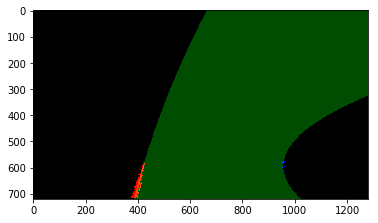

In [55]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

vid_section = VideoFileClip("../challenge_video.mp4")
image_clip = vid_section.fl_image(process_image) #NOTE: this function expects color images!!
%time image_clip.write_videofile('../output_video/P2_challenge_video_out.mp4', audio=False)